In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
library(ComplexHeatmap)

Warning message:
"package 'ComplexHeatmap' was built under R version 4.2.1"
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original fu

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [6]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [7]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

In [8]:
bpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_biocyc_pathways.txt')
bpath_df = read.csv(bpath_fname, sep='\t')

In [9]:
bpath_df = bpath_df %>% rename(gene_id = Accession.2) %>% 
    separate_longer_delim(Pathways.of.gene, delim  = ' // ') %>%
    separate_longer_delim(Ontology...pathway.type, delim  = ' // ') %>%
    filter(Ontology...pathway.type != 'Superpathways') %>%
    mutate(
        Pathways.of.gene = str_squish(Pathways.of.gene),
        Ontology...pathway.type = str_squish(Ontology...pathway.type)
          )


In [10]:
#tail(bpath_df)
table(bpath_df$Ontology...pathway.type)
table(bpath_df$Pathways.of.gene)



                                                         
                                                    1314 
                 8-oxo-GTP and 8-oxo-dGTP Detoxification 
                                                       1 
                                         Acid Resistance 
                                                       3 
                                    Aldehyde Degradation 
                                                       2 
                        Amine and Polyamine Biosynthesis 
                                                       7 
                         Amine and Polyamine Degradation 
                                                       3 
                                 Amino Acid Biosynthesis 
                                                     341 
                                  Amino Acid Degradation 
                                                     110 
                                 Aminoacyl-tRNA Charging 
             


                                                                                                 
                                                                                            1314 
                                                                   &alpha;-carotene biosynthesis 
                                                                                               2 
                                                                    &beta;-carotene biosynthesis 
                                                                                               2 
                                                       [2Fe-2S] iron-sulfur cluster biosynthesis 
                                                                                               5 
                                       <i>bis</i>(guanylyl molybdopterin) cofactor sulfurylation 
                                                                                               3 
                   

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

In [11]:
rnaseq_dpath = file.path('..', 'RNASEQ', 'DE_results')
list.files(rnaseq_dpath)


[1] "HOT1A3_DE_DESEQ_results.csv"                
 [2] "HOT1A3_DE_DESEQ_results_ref_vs_long.csv"    
 [3] "HOT1A3_DE_DESEQ_vsd.csv"                    
 [4] "HOT1A3_DE_genes_DESEQ_ref_vs_long_wKEGG.csv"
 [5] "HOT1A3_GOSEQ_results_ref_vs_long.csv"       
 [6] "MED4_DE_DESEQ_results.csv"                  
 [7] "MED4_DE_DESEQ_results_ref_vs_long.csv"      
 [8] "MED4_DE_DESEQ_vsd.csv"                      
 [9] "MED4_DE_genes_DESEQ_wKEGG_ref_vs_long.csv"  
[10] "MED4_GOSEQ_results_ref_vs_long.csv"

In [12]:
proteome_dpath = file.path('..', 'Proteome', 'data')
list.files(proteome_dpath)


[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "ALT_Axenic_DE.csv"                                                                              
 [4] "ALT_CC_DE.csv"                                                                                  
 [5] "C_ALT_proteome.txt"                                                                             
 [6] "C_ALT_proteome_norm.txt"                                                                        
 [7] "C_PRO_proteome.txt"                                                                             
 [8] "C_PRO_proteome_norm.txt"                                                                        
 [9] "Nov22_Processing.xlsx"                                                                          
[10] "P_axenic_proteome.txt"                                                                          
[11] "P_axenic_proteome_norm.txt"                                                                     
[12] "PRO_Axenic_DE.csv"                                                                              
[13] "PRO_CC_DE.csv"                                                                                  
[14] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [13]:
df_rnaseq1 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results_ref_vs_long.csv'))  %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

df_rnaseq2 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results.csv')) %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

In [14]:
unique(df_rnaseq2$contrast)

[1] "P2vsP1" "C1vsP1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

In [15]:
df_prot1 = read.csv(file.path(proteome_dpath,'PRO_CC_DE.csv'))
df_prot2 = read.csv(file.path(proteome_dpath,'PRO_Axenic_DE.csv'))

In [16]:
names(df_rnaseq1)
names(df_rnaseq2)
names(df_prot1)
names(df_prot2)



[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

In [17]:
unique(df_prot1$contrast)
unique(df_prot2$contrast)
unique(df_rnaseq1$contrast)
unique(df_rnaseq2$contrast)


[1] "C2 - C1"        "C3 - C1"        "C4 - C1"        "C5 - C1"       
[5] "Clongterm - C1"

[1] "P2 - P1" "P3 - P1" "P5 - P1"

[1] "Intercept"                  "treatment_long.term_vs_ref"

[1] "P2vsP1" "C1vsP1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

# GOSEQ

In [18]:
dp1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval') %>%
    mutate(Assay = 'Proteome')
dp2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')%>%
    mutate(Assay = 'Proteome')


In [19]:
dr1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
dr2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
    


In [20]:
df_all = bind_rows(dp1, dp2, dr1, dr2)

In [21]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "P2 - P1" = 'P2vsP1_prot',
    "P3 - P1" = 'P3vsP1_prot',
    "P5 - P1" = 'P5vsP1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "P2vsP1" = 'P2vsP1_rna', 
    "C1vsP1" = 'C1vsP1_rna', 
    "C2vsC1" = 'C2vsC1_rna', 
    "C3vsC1" = 'C3vsC1_rna', 
    "C4vsC1" = 'C4vsC1_rna', 
    "C5vsC1" = 'C5vsC1_rna')
    
    
df_all = df_all %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [22]:
gtf_fpath = file.path('..','genomes', 'MED4', 'genomic.gtf')
SAF <- Rsubread::flattenGTF(gtf_fpath, GTF.featureType = "CDS")
GeneLength <- rowsum(SAF$End-SAF$Start+1, SAF$GeneID)
GeneLength = as.data.frame(GeneLength) 
names(GeneLength) = 'Length'
GeneLength = GeneLength %>% rownames_to_column('gene_id')


Flattening GTF file: C:\Users\Osnat\Documents\GitHub\CC1A3\genomes\MED4\genomic.gtf
Output SAF file: ./.Rsubread_flattenGTF_pid1212

Looking for 'CDS' features... (grouped by 'gene_id')

Finished.



In [23]:
df_all = left_join(df_all, GeneLength, by = 'gene_id')

In [24]:
df_all

contrast gene_id      logFC      AveExpr     pvalue       padj        
1     C2 - C1  TX50_RS01980  2.6029332  0.91671556 5.951467e-07 0.0004868287
2     C2 - C1  TX50_RS05125  1.7956460  2.04648813 8.763244e-07 0.0004868287
3     C2 - C1  TX50_RS09075  1.1167539  1.46785946 1.025622e-06 0.0004868287
4     C2 - C1  TX50_RS05175  1.4380690 -0.20702445 2.486196e-06 0.0008850858
5     C2 - C1  TX50_RS08845 -0.9884268  3.74974295 3.186503e-06 0.0009075161
6     C2 - C1  TX50_RS01985  1.7087460 -0.25577666 5.226353e-06 0.0012403878
7     C2 - C1  TX50_RS05585  2.3211759 -1.72601579 6.907967e-06 0.0014052779
8     C2 - C1  TX50_RS05180  1.4995632  1.34725170 1.099431e-05 0.0017487735
9     C2 - C1  TX50_RS05170  1.6961969 -1.34694055 1.135667e-05 0.0017487735
10    C2 - C1  TX50_RS07865  1.3468844  1.29842981 1.244679e-05 0.0017487735
11    C2 - C1  TX50_RS04160  1.0422090 -0.19498831 1.468205e-05 0.0017487735
12    C2 - C1  TX50_RS07755 -1.6856352  3.03145873 1.531966e-05 0.0017487735
13    C2 - C1  TX50_RS01975  2.7204049 -2.51073856 1.615740e-05 0.0017487735
14    C2 - C1  TX50_RS01795  1.1292019 -2.13131898 1.719300e-05 0.0017487735
15    C2 - C1  TX50_RS05830  1.2333476 -1.38758233 2.254932e-05 0.0021406822
16    C2 - C1  TX50_RS01620 -1.0312176  4.75975157 2.667470e-05 0.0023740479
17    C2 - C1  TX50_RS05135  2.1339753 -0.45089397 2.942548e-05 0.0023777618
18    C2 - C1  TX50_RS04285  0.8861923  5.19382242 3.005598e-05 0.0023777618
19    C2 - C1  TX50_RS00840  0.9973780  2.83088462 3.244572e-05 0.0024317214
20    C2 - C1  TX50_RS07090  0.8326759  4.39304956 3.637684e-05 0.0025900308
21    C2 - C1  TX50_RS01275  1.7603264  1.24846350 4.978681e-05 0.0032116453
22    C2 - C1  TX50_RS05580  2.9084625 -0.98016783 5.184816e-05 0.0032116453
23    C2 - C1  TX50_RS05115  0.9566263  1.07116629 5.258699e-05 0.0032116453
24    C2 - C1  TX50_RS03160 -0.8411973  1.55098858 5.412885e-05 0.0032116453
25    C2 - C1  TX50_RS00070 -0.9446316  0.01522325 6.032841e-05 0.0033485959
26    C2 - C1  TX50_RS04030 -0.8496043  4.10854232 6.114009e-05 0.0033485959
27    C2 - C1  TX50_RS04820 -1.4475288 -0.03773708 6.409682e-05 0.0033515045
28    C2 - C1  TX50_RS03015  0.7703025  0.82302939 6.590037e-05 0.0033515045
29    C2 - C1  TX50_RS04910  2.5511150  5.63148746 7.310912e-05 0.0035899099
30    C2 - C1  TX50_RS06225  0.8860563  0.96424656 7.869063e-05 0.0037351817
⋮     ⋮        ⋮            ⋮          ⋮           ⋮            ⋮           
24348 C5vsC1   TX50_RS09745 -1.3348623   82.626698 1.159048e-02 5.263716e-02
24349 C5vsC1   TX50_RS09750 -1.8732931  213.265107 4.511059e-02 1.398655e-01
24350 C5vsC1   TX50_RS09755 -0.9517516  229.634883 7.381151e-02 1.994527e-01
24351 C5vsC1   TX50_RS09760 -0.6576445    7.416545 5.860466e-01 7.448740e-01
24352 C5vsC1   TX50_RS09765 -1.6203712   35.964266 2.794831e-03 1.869133e-02
24353 C5vsC1   TX50_RS09770 -4.3461845    6.500273 9.076308e-03 4.415966e-02
24354 C5vsC1   TX50_RS09775 -0.2812124   91.738114 4.674206e-01 6.490590e-01
24355 C5vsC1   TX50_RS09780 -0.2954429  377.599020 5.494372e-01 7.183895e-01
24356 C5vsC1   TX50_RS09785 -1.1284521   77.554290 1.815533e-02 7.150109e-02
24357 C5vsC1   TX50_RS09790 -0.1781373  117.561929 4.863640e-01 6.678485e-01
24358 C5vsC1   TX50_RS09795 -2.3652482  144.033286 1.778696e-02 7.050034e-02
24359 C5vsC1   TX50_RS09800 -1.0757704  990.293863 7.503843e-02 2.007169e-01
24360 C5vsC1   TX50_RS09805 -5.1028850  102.631580 5.340997e-06 1.235773e-04
24361 C5vsC1   TX50_RS09810 -4.0537809  246.964274 1.577950e-08 8.345100e-07
24362 C5vsC1   TX50_RS09815 -1.4766567 1301.573746 1.073421e-02 4.942542e-02
24363 C5vsC1   TX50_RS09820 -0.9090064 1661.019631 1.419581e-01 3.058751e-01
24364 C5vsC1   TX50_RS09825  1.4320110  335.895318 9.803139e-05 1.417626e-03
24365 C5vsC1   TX50_RS09830  4.0607446 2098.390306 2.468833e-21 9.139619e-19
24366 C5vsC1   TX50_RS09835  2.0446330    7.514383 3.438768e-02 1.162895e-01
24367 C5vsC1   TX50_RS09840  4.3943475 1505.075959 5.113276e-27 3.154891e-24
24

In [25]:
df_all = df_all %>% 
    mutate(
        down = ((logFC < 0) & (padj < 0.1)),
        up   = ((logFC > 0) & (padj < 0.1)),
)

In [26]:
hpath_df = hpath_df %>% mutate(gene = if_else(gene != '', gene, gene_id))

In [27]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [28]:
table(bpath_df$Pathways.of.gene)


                                                                                                 
                                                                                            1314 
                                                                   &alpha;-carotene biosynthesis 
                                                                                               2 
                                                                    &beta;-carotene biosynthesis 
                                                                                               2 
                                                       [2Fe-2S] iron-sulfur cluster biosynthesis 
                                                                                               5 
                                       <i>bis</i>(guanylyl molybdopterin) cofactor sulfurylation 
                                                                                               3 
                   

In [69]:
run_enrichment <- function(contrastname, encolname, testcolname) {
    mpath_df = bpath_df %>%
       pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
       distinct(PATH, gene_id, .keep_all= TRUE) %>%
       select(gene_id, PATH)
    #path_names = bpath_df %>%
    #   pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
    #   distinct(PATH)
    test_df = df_all %>% drop_na(padj) %>% filter(contrast1 == contrastname)
    test_df$sigval = if_else(test_df[[testcolname]], 1, 0)
    DEgenes = test_df$sigval
    names(DEgenes) = test_df$gene_id
    table(DEgenes)
    LENgenes = test_df$Length
    names(LENgenes) = test_df$gene_id
    pwf = nullp(DEgenes, bias.data=LENgenes)
    goseq_res = goseq(pwf, gene2cat = as.data.frame(mpath_df))
    #goseq_res = left_join(goseq_res, path_names)
    goseq_res = goseq_res %>% filter(numInCat>=5) %>% filter(!category %in% '')
    goseq_res$padj = p.adjust(goseq_res$over_represented_pvalue, method="BH")
    goseq_res = goseq_res %>%
       relocate(padj, .after = over_represented_pvalue) #%>%
       #relocate(PATH, .after = category) 
    goseq_res$type = testcolname
    goseq_res$enrich = encolname
    goseq_res$contrast = contrastname
    goseq_res$organism = 'MED4'
    #return(mpath_df)
    return (goseq_res)
}

In [70]:
names(bpath_df)

[1] "Gene.Name"               "Accession.1"            
[3] "Product"                 "gene_id"                
[5] "Pathways.of.gene"        "Ontology...pathway.type"

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


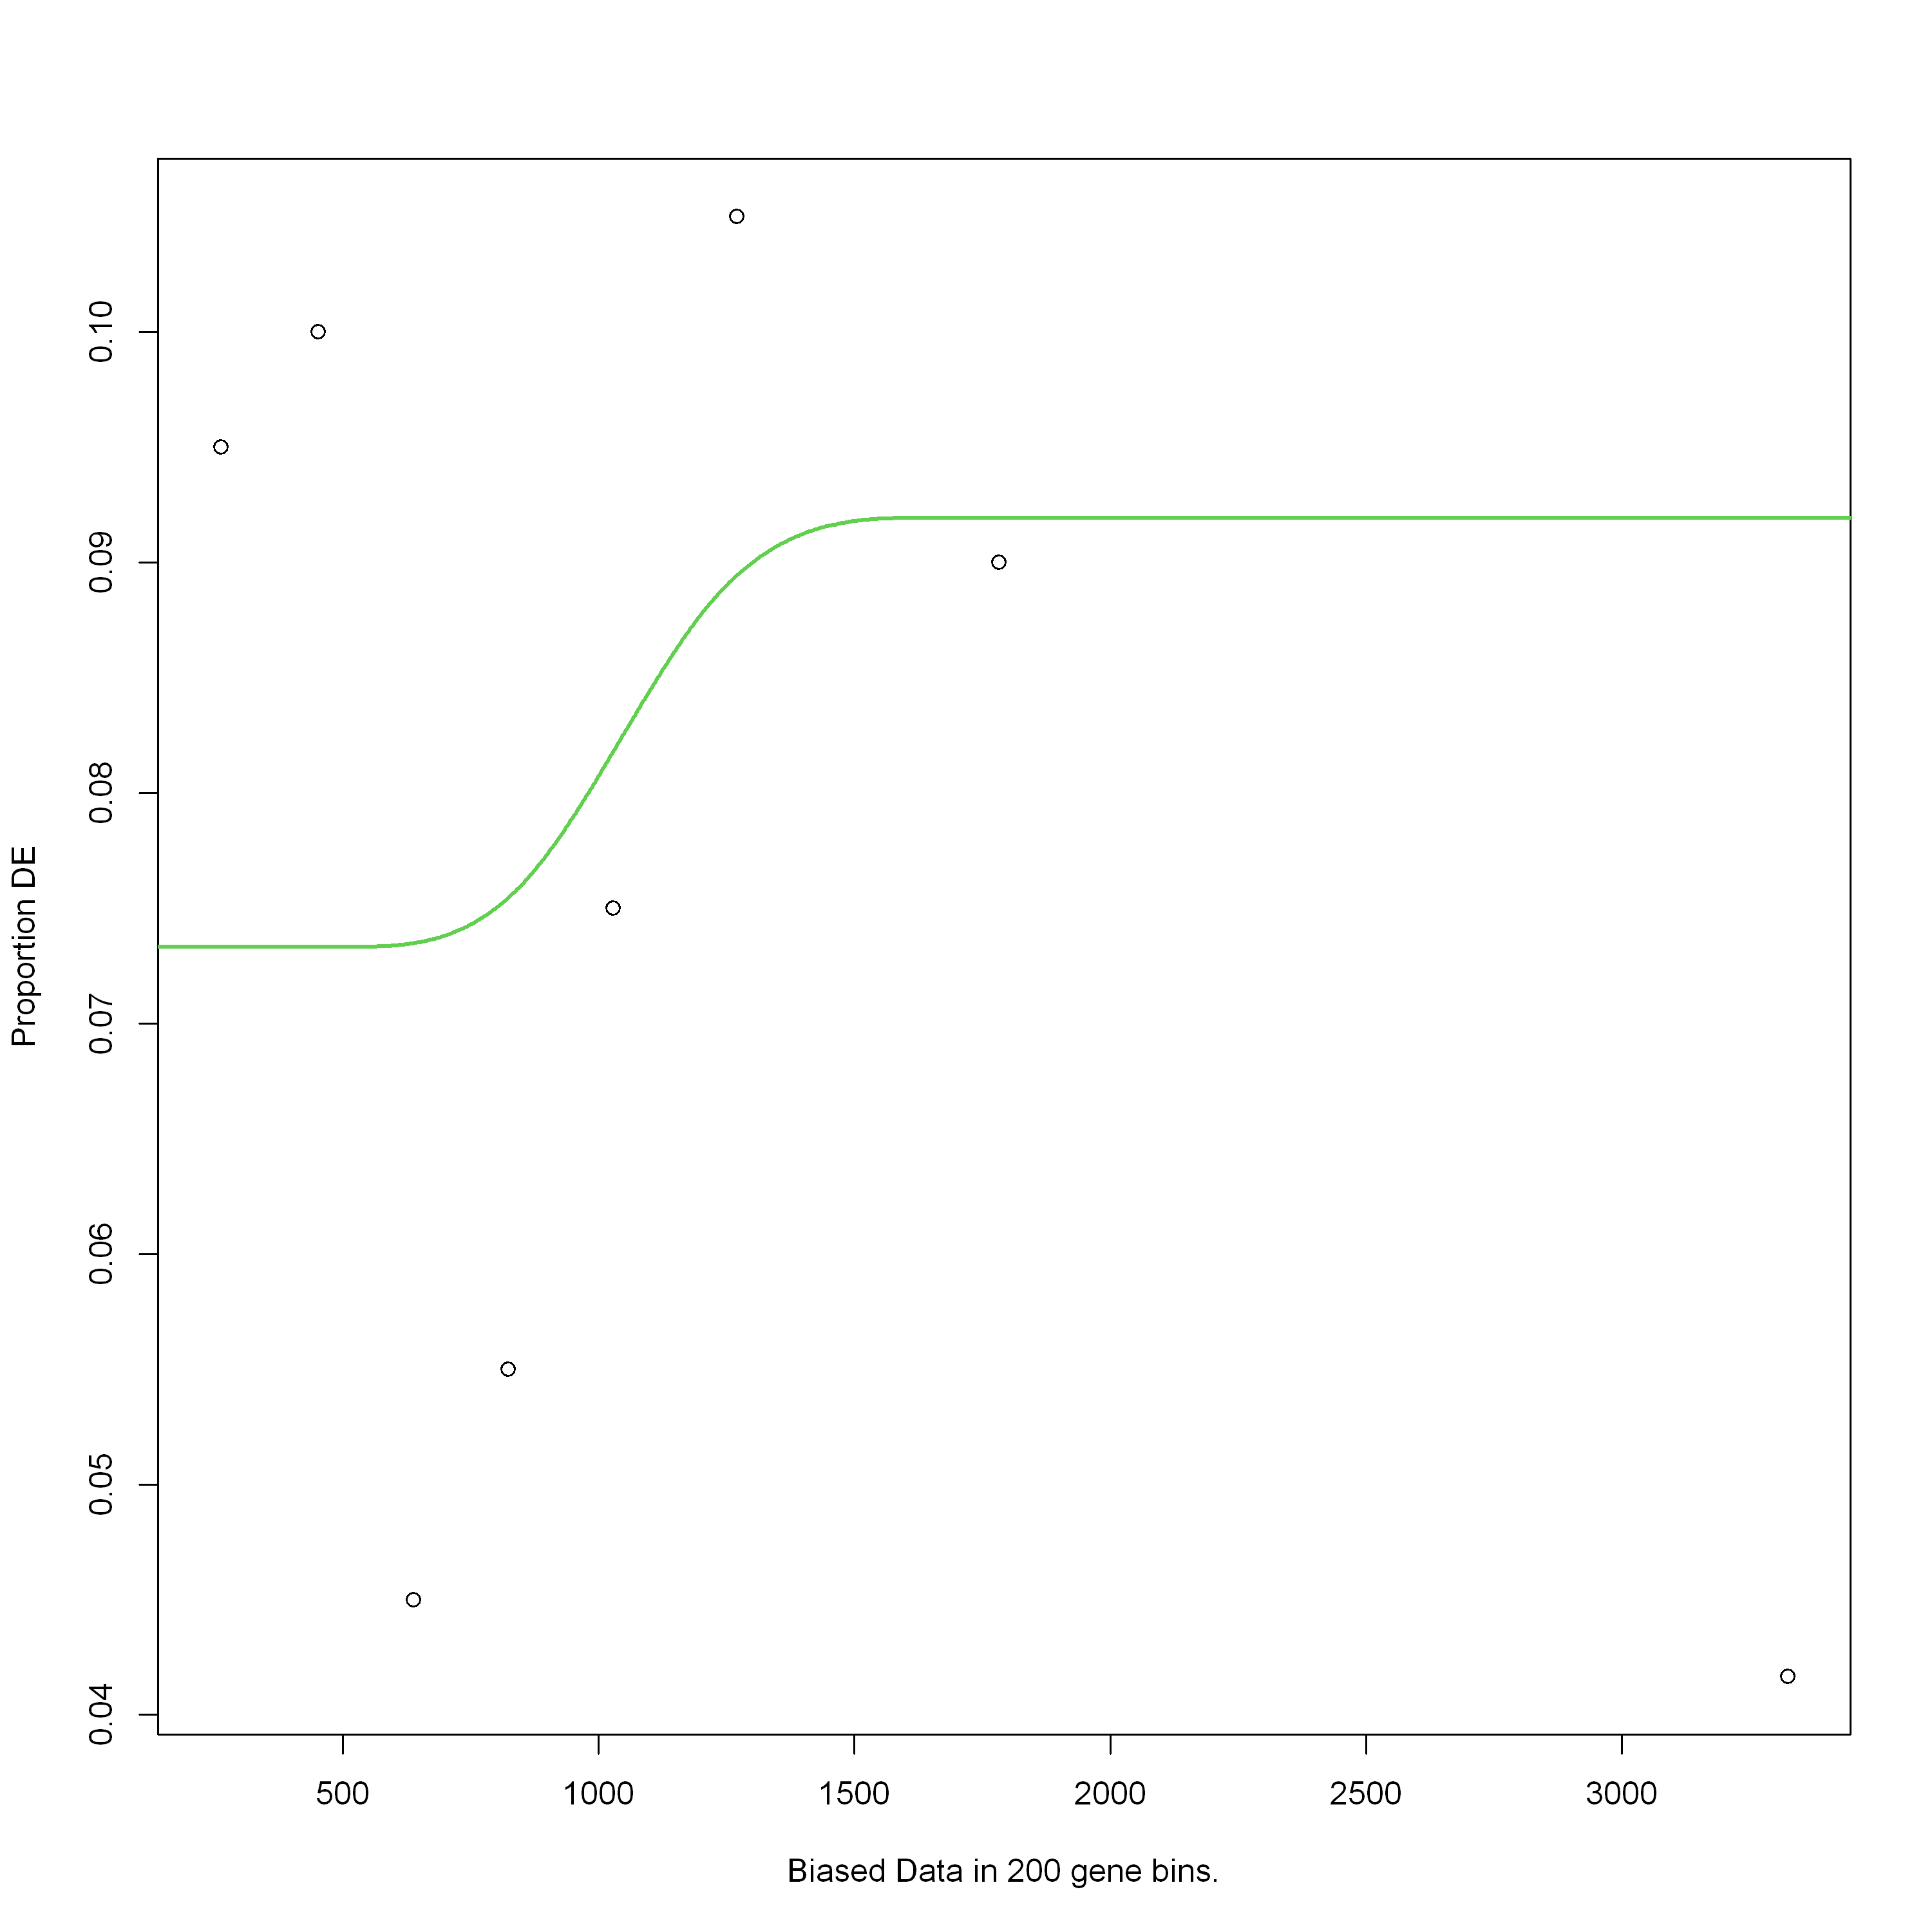

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


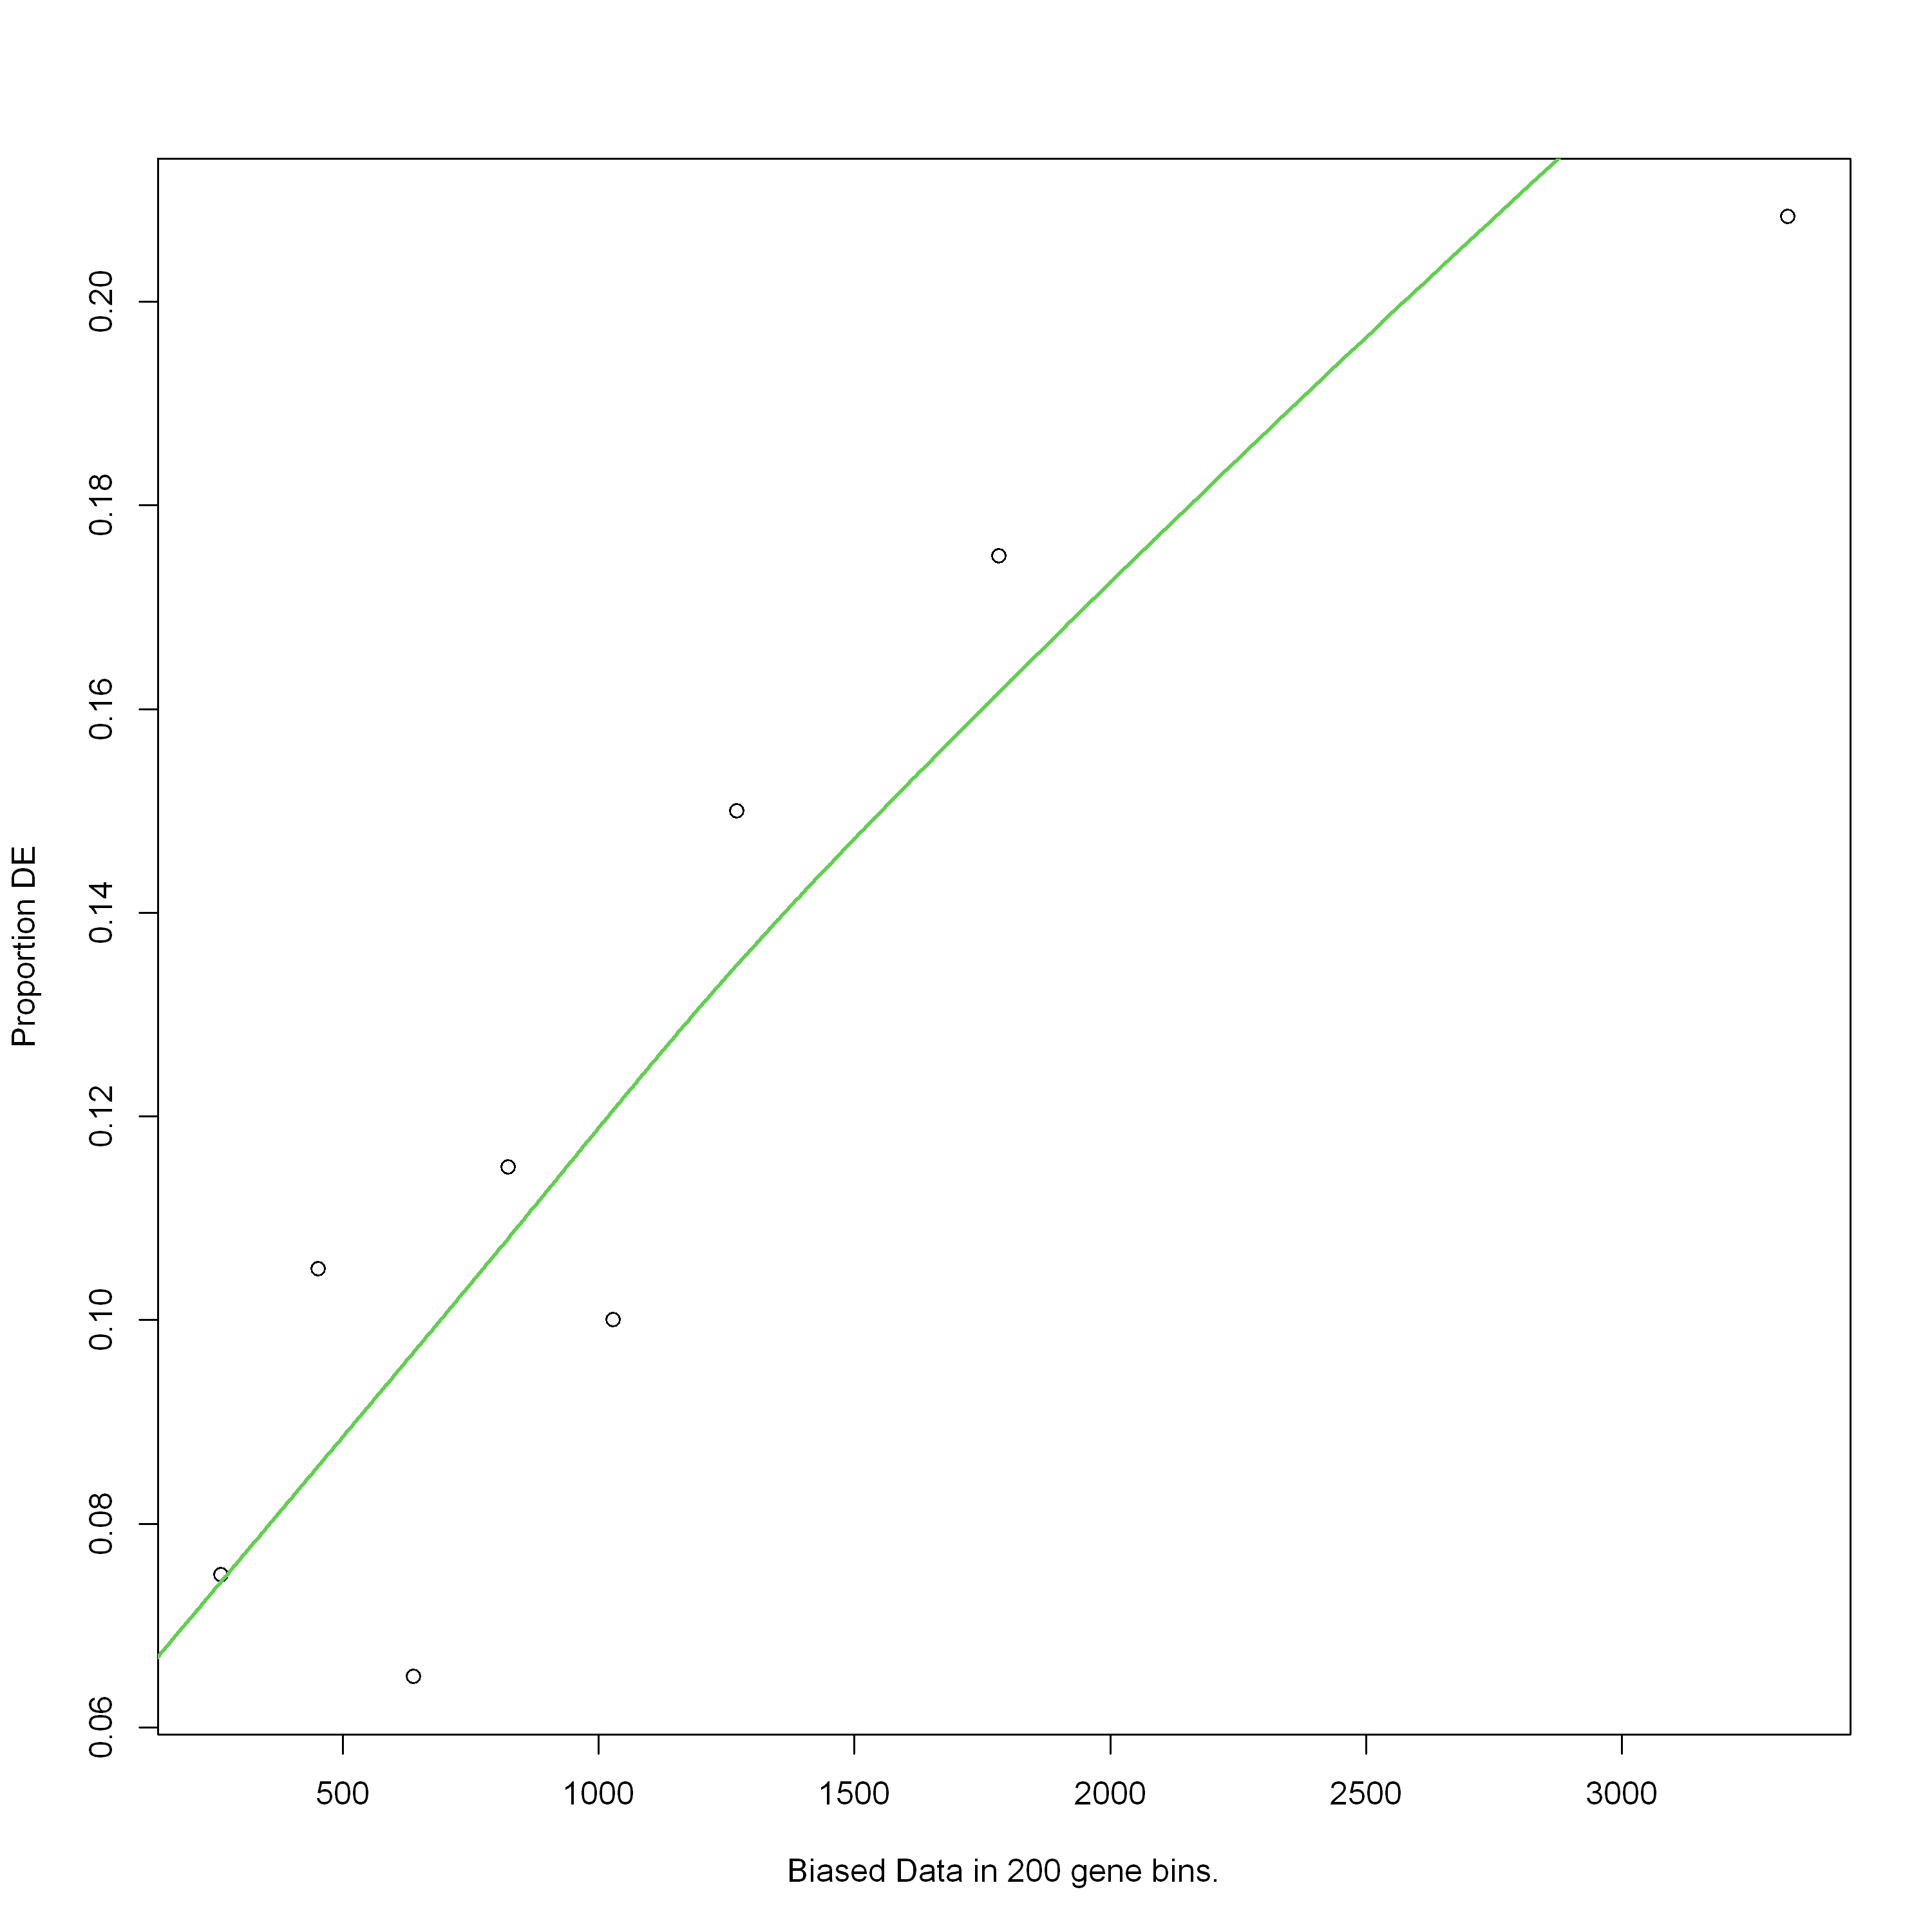

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


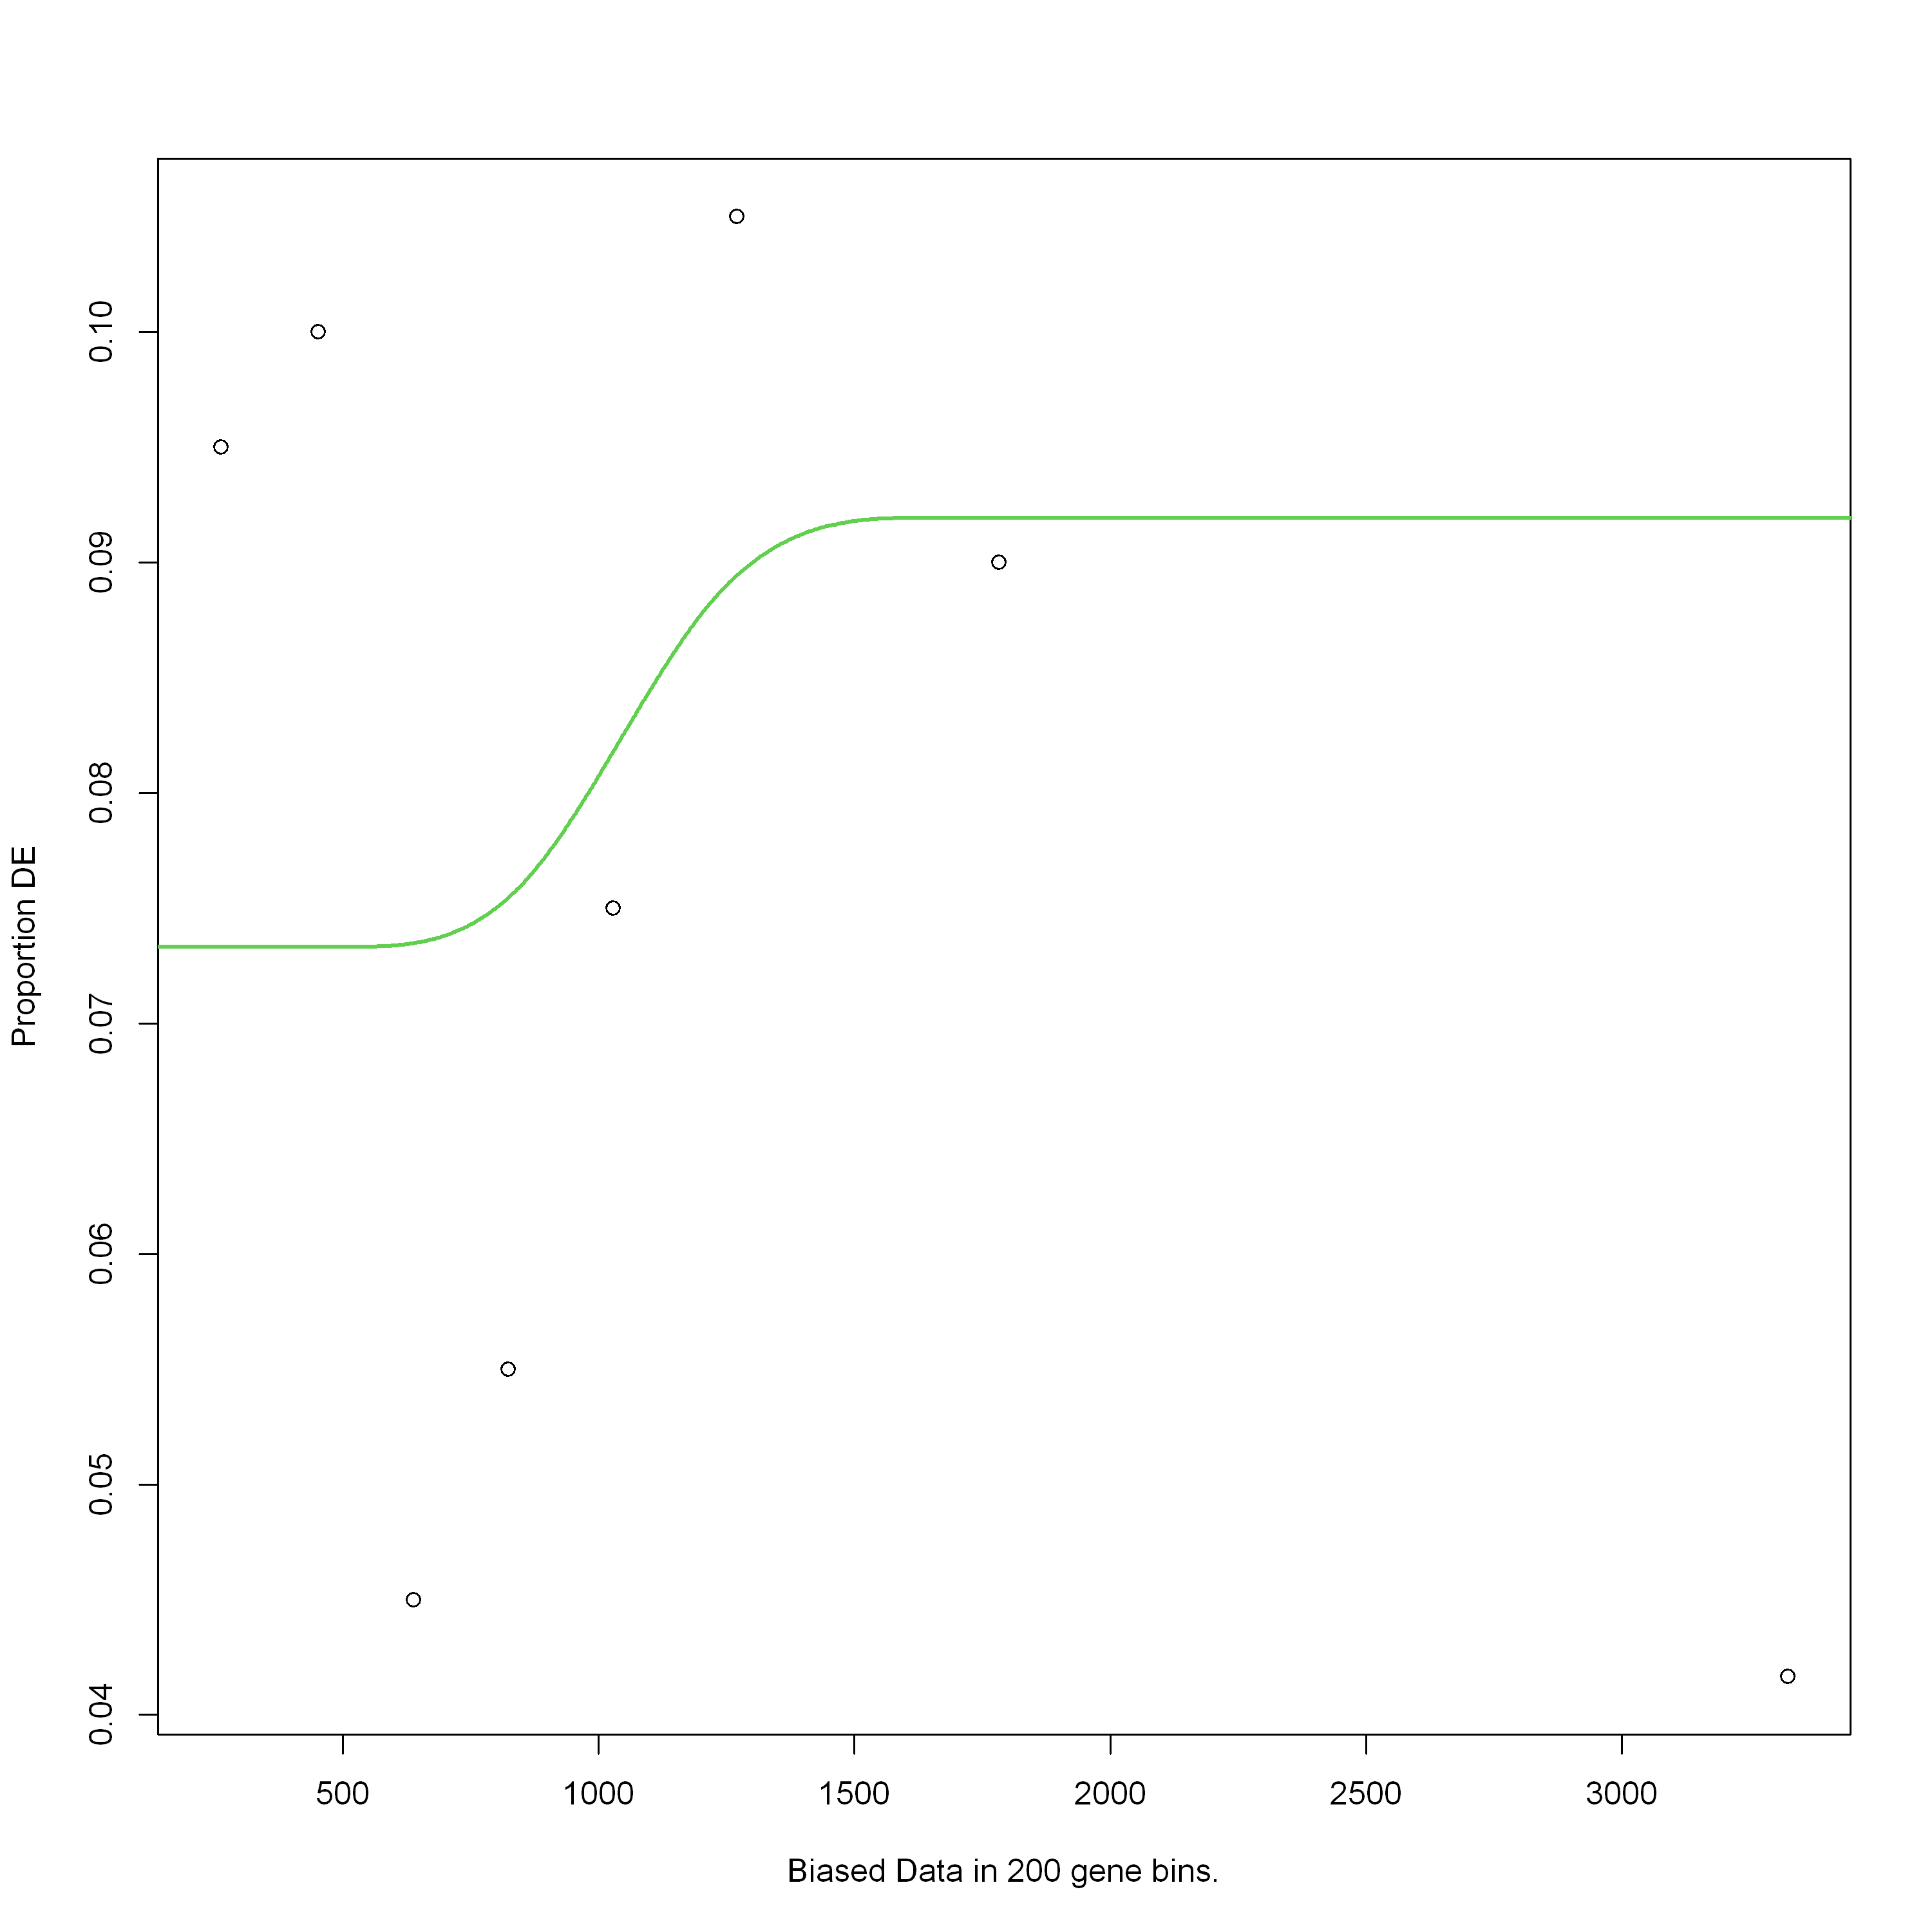

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



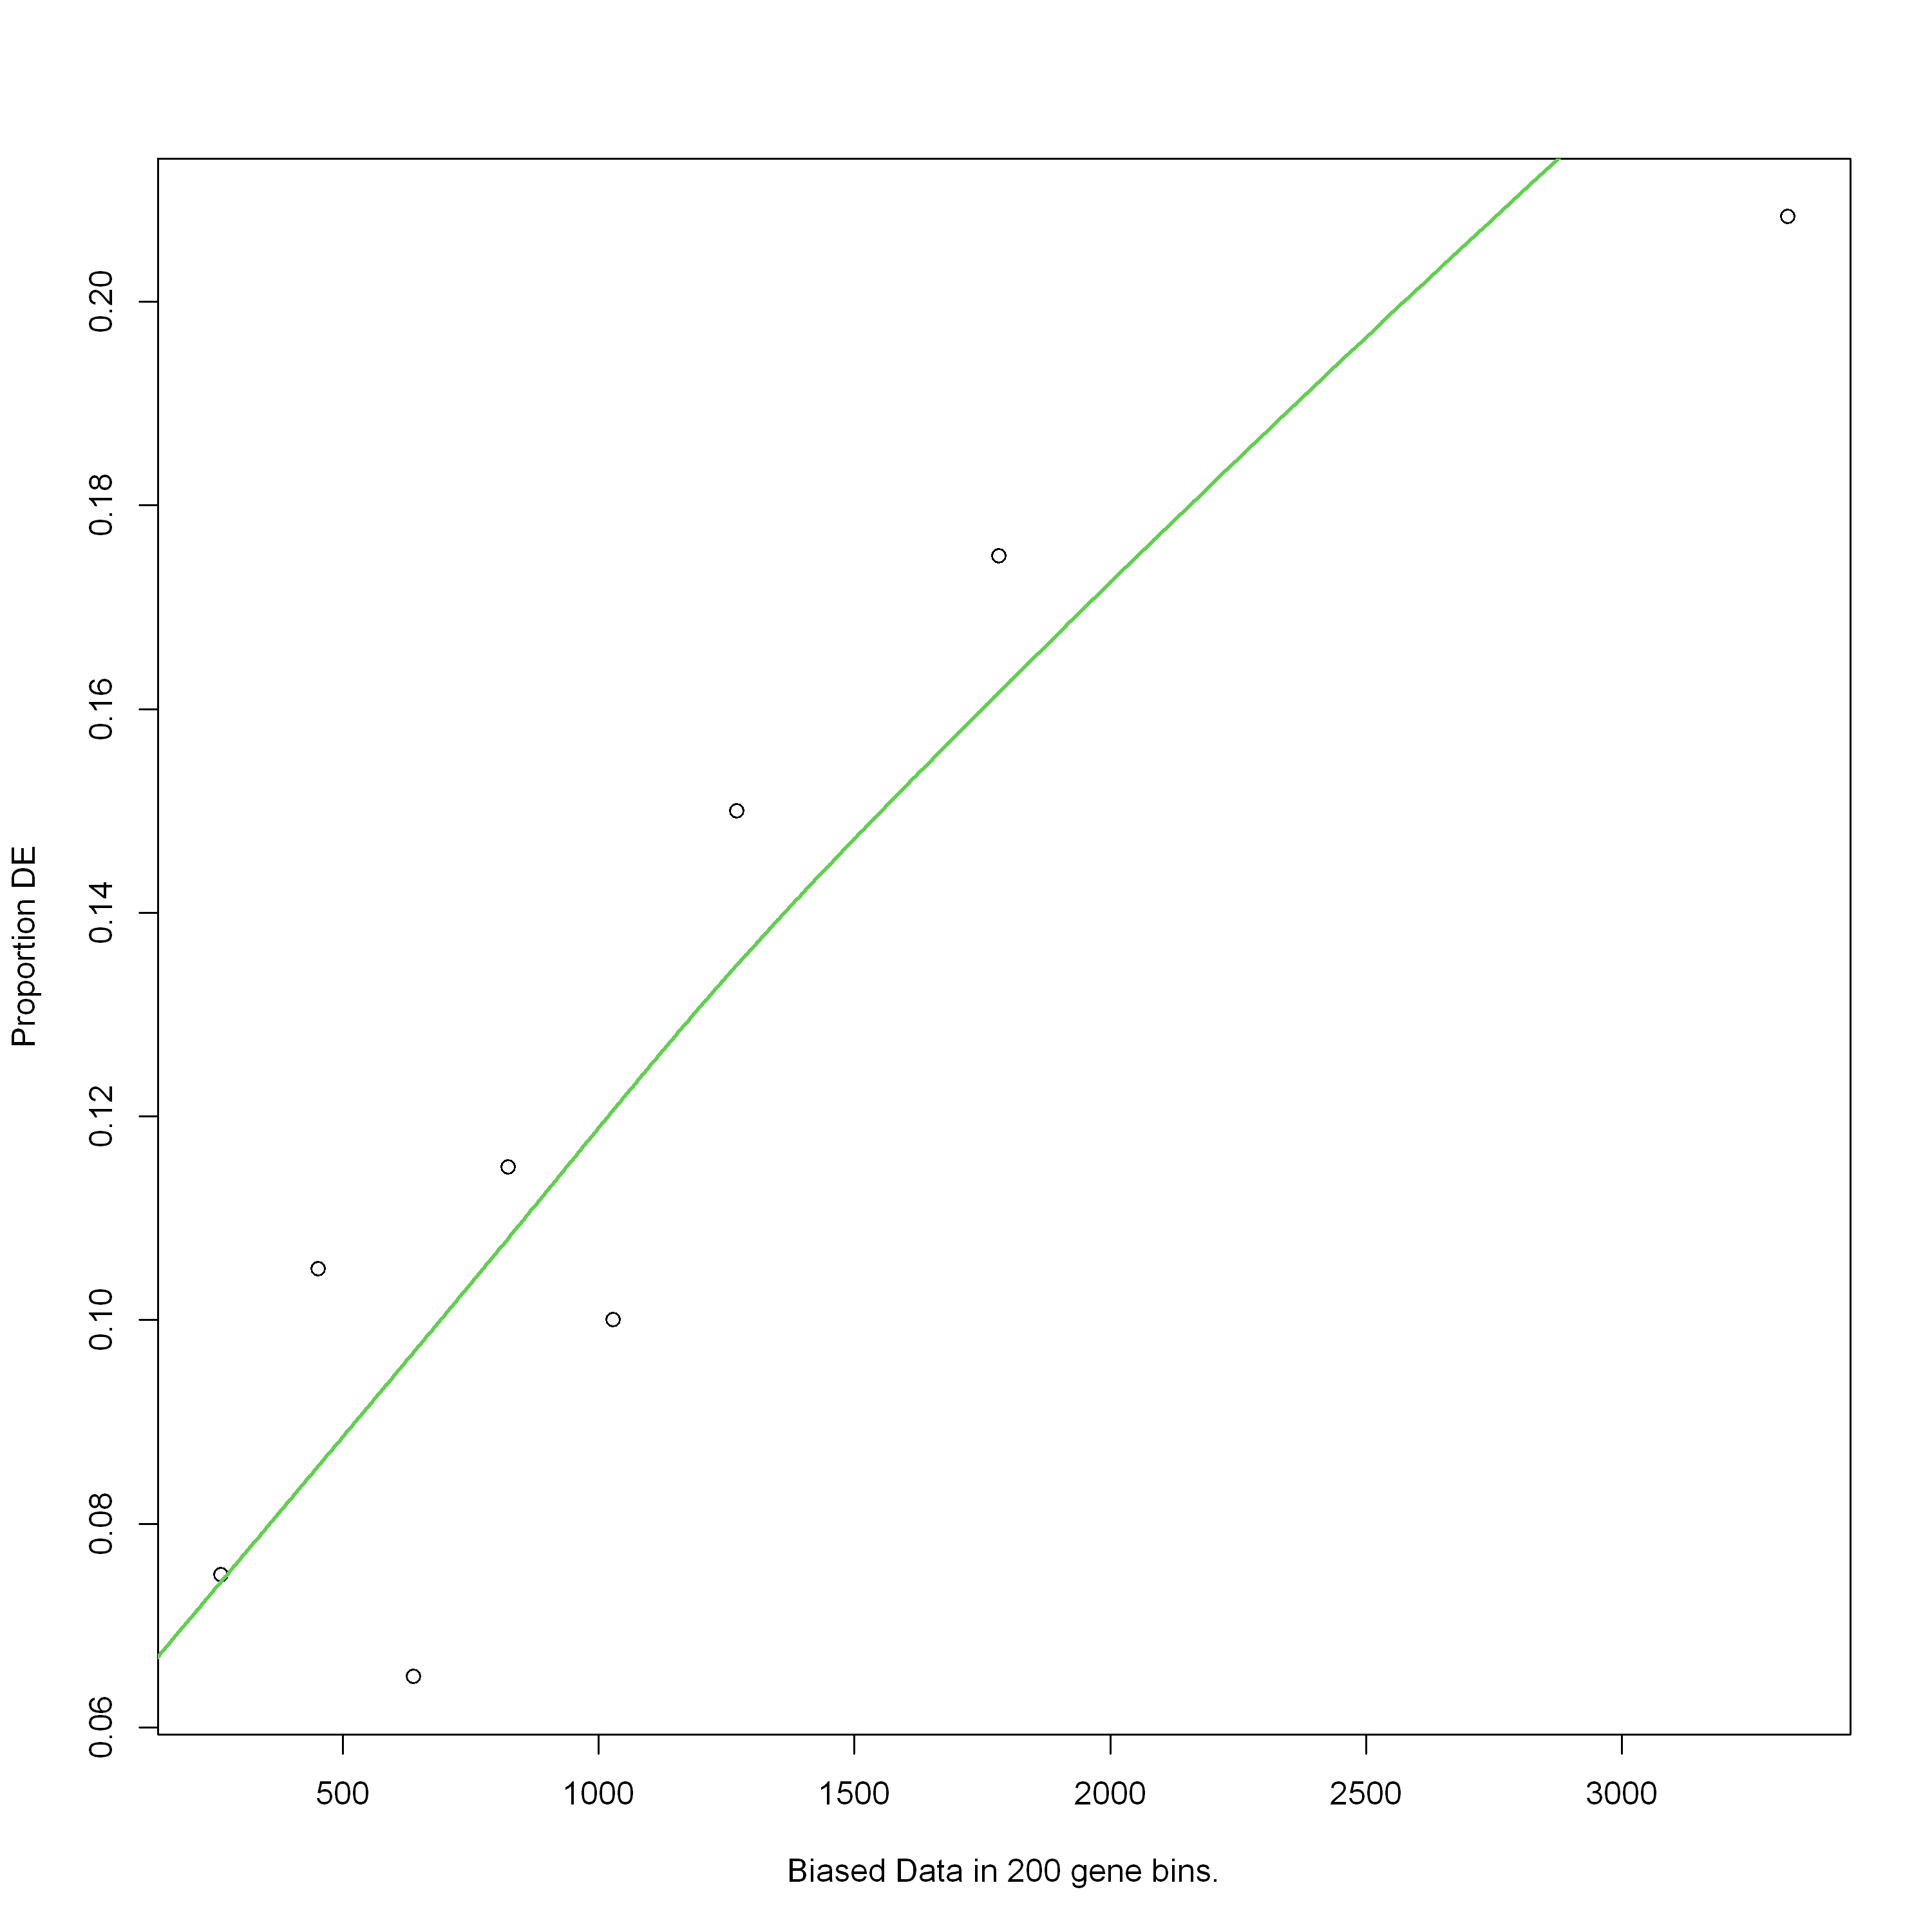

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


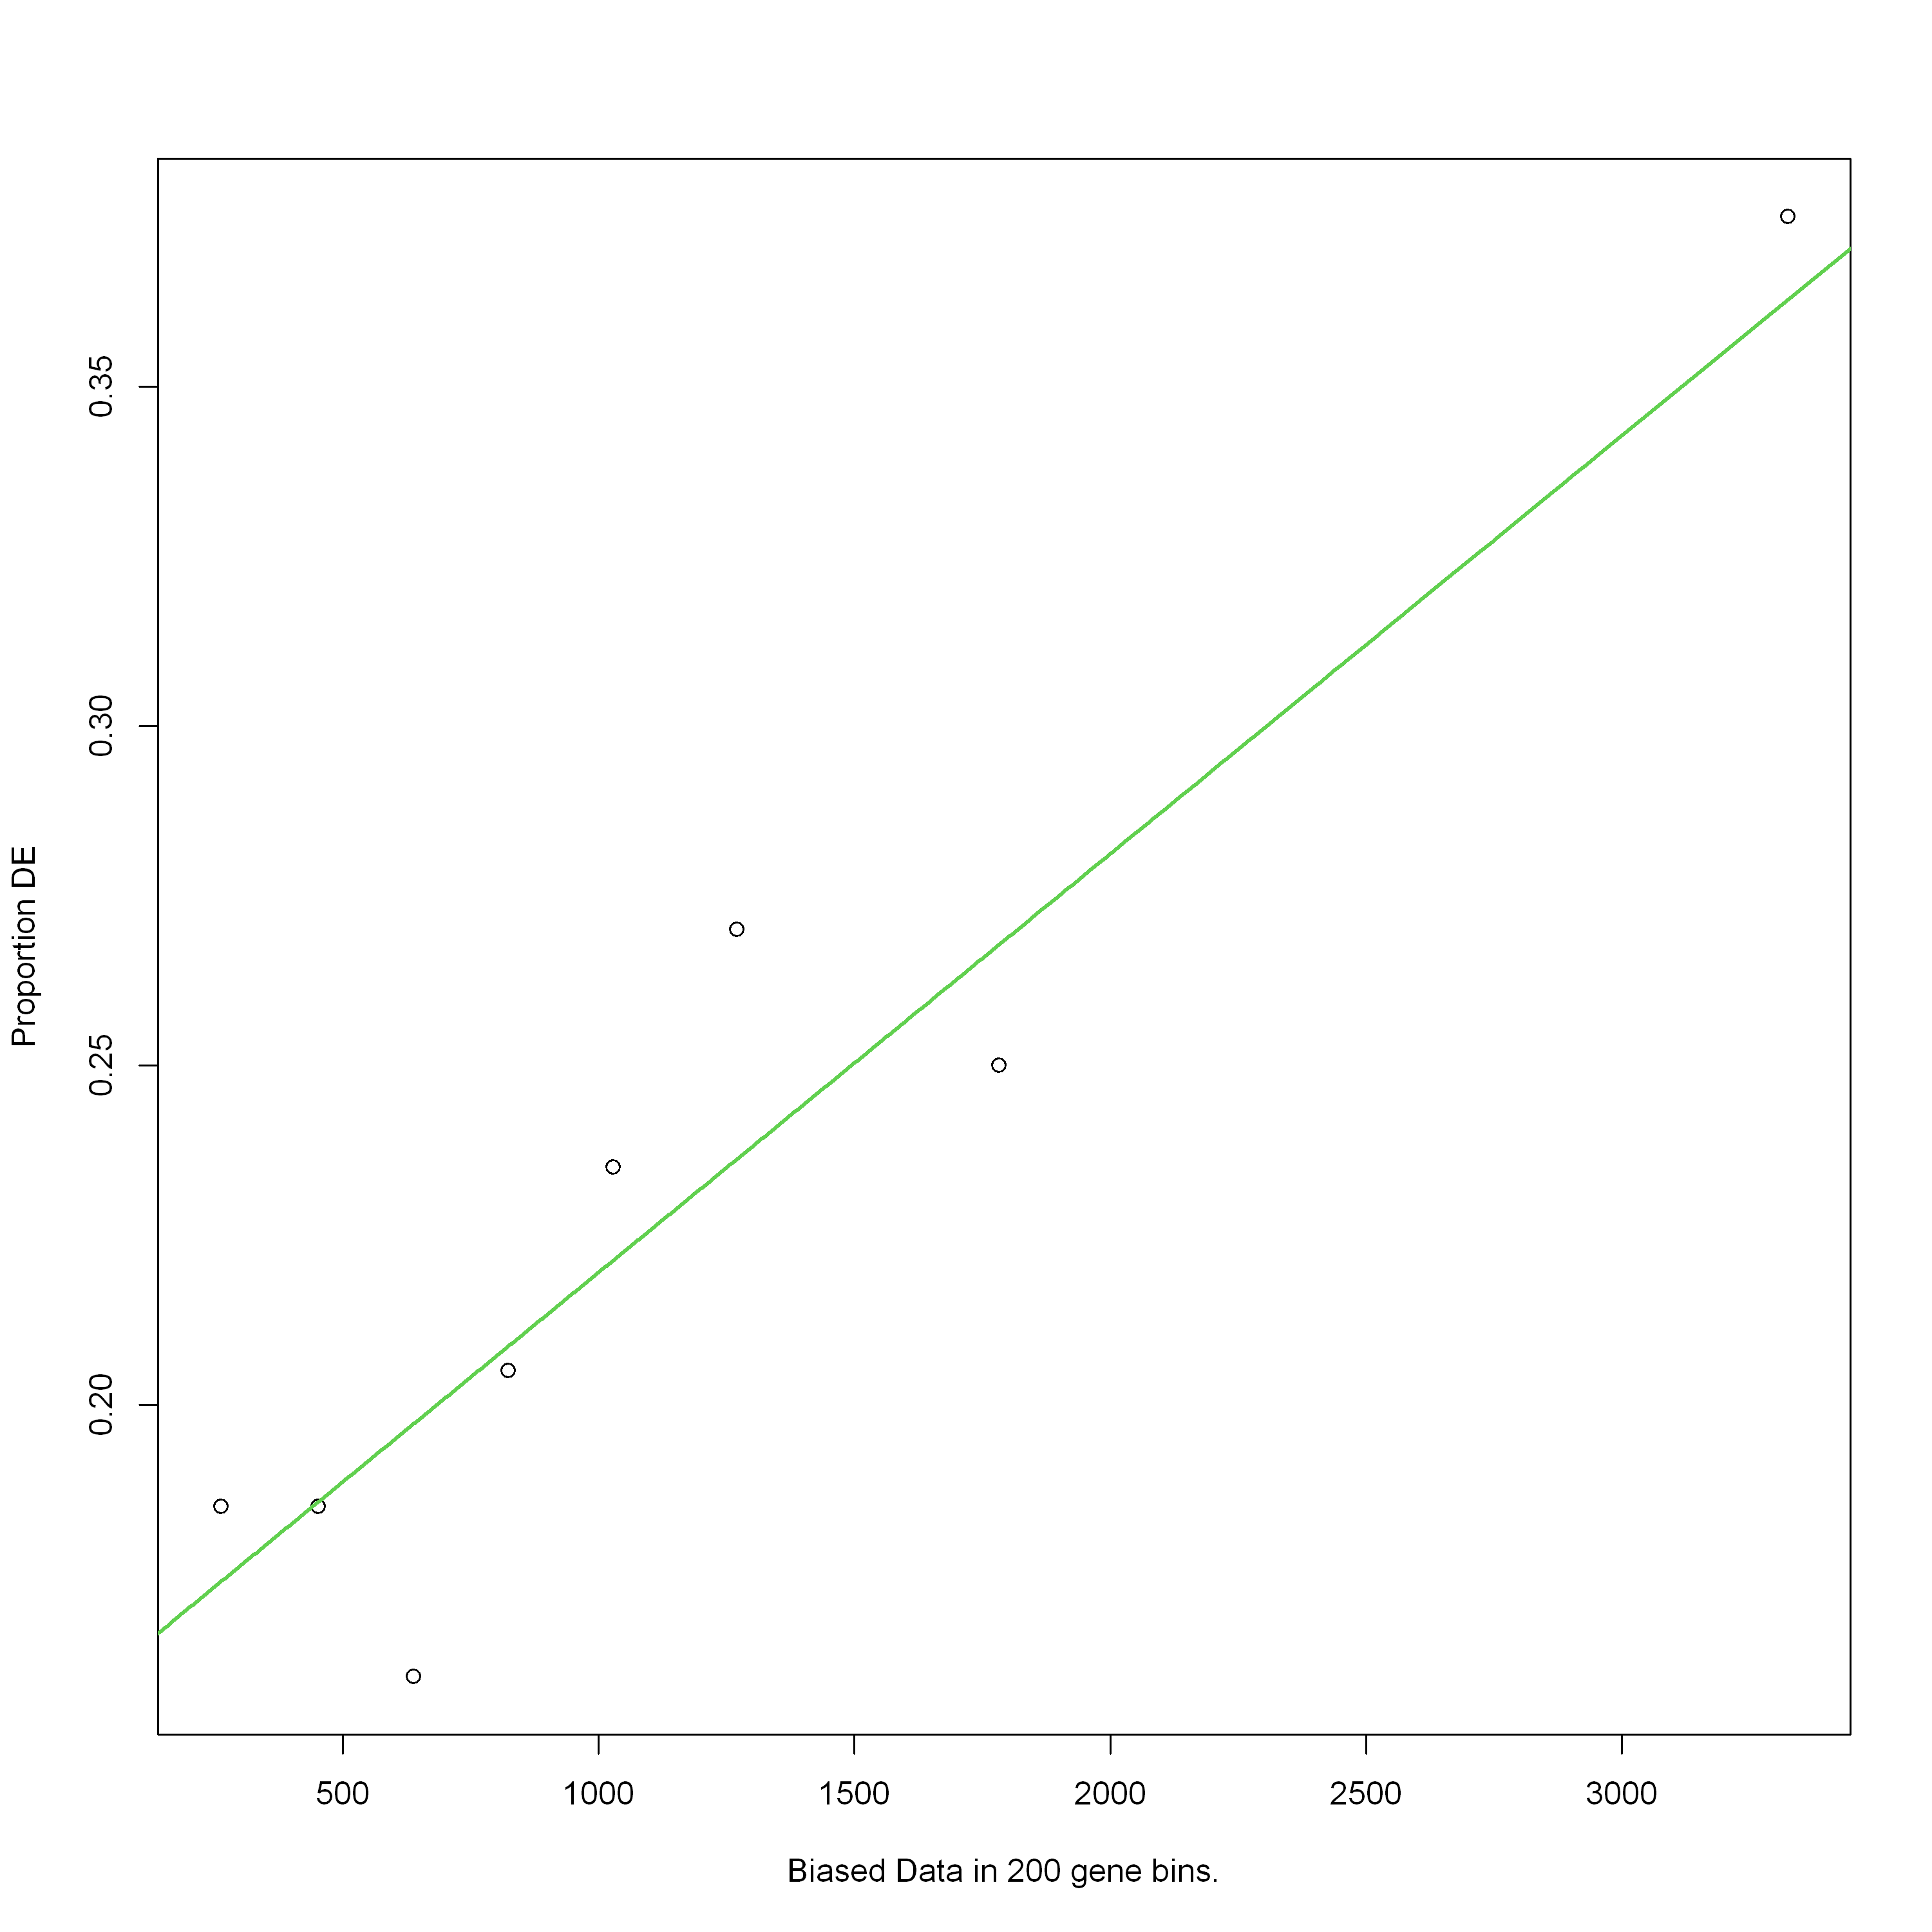

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



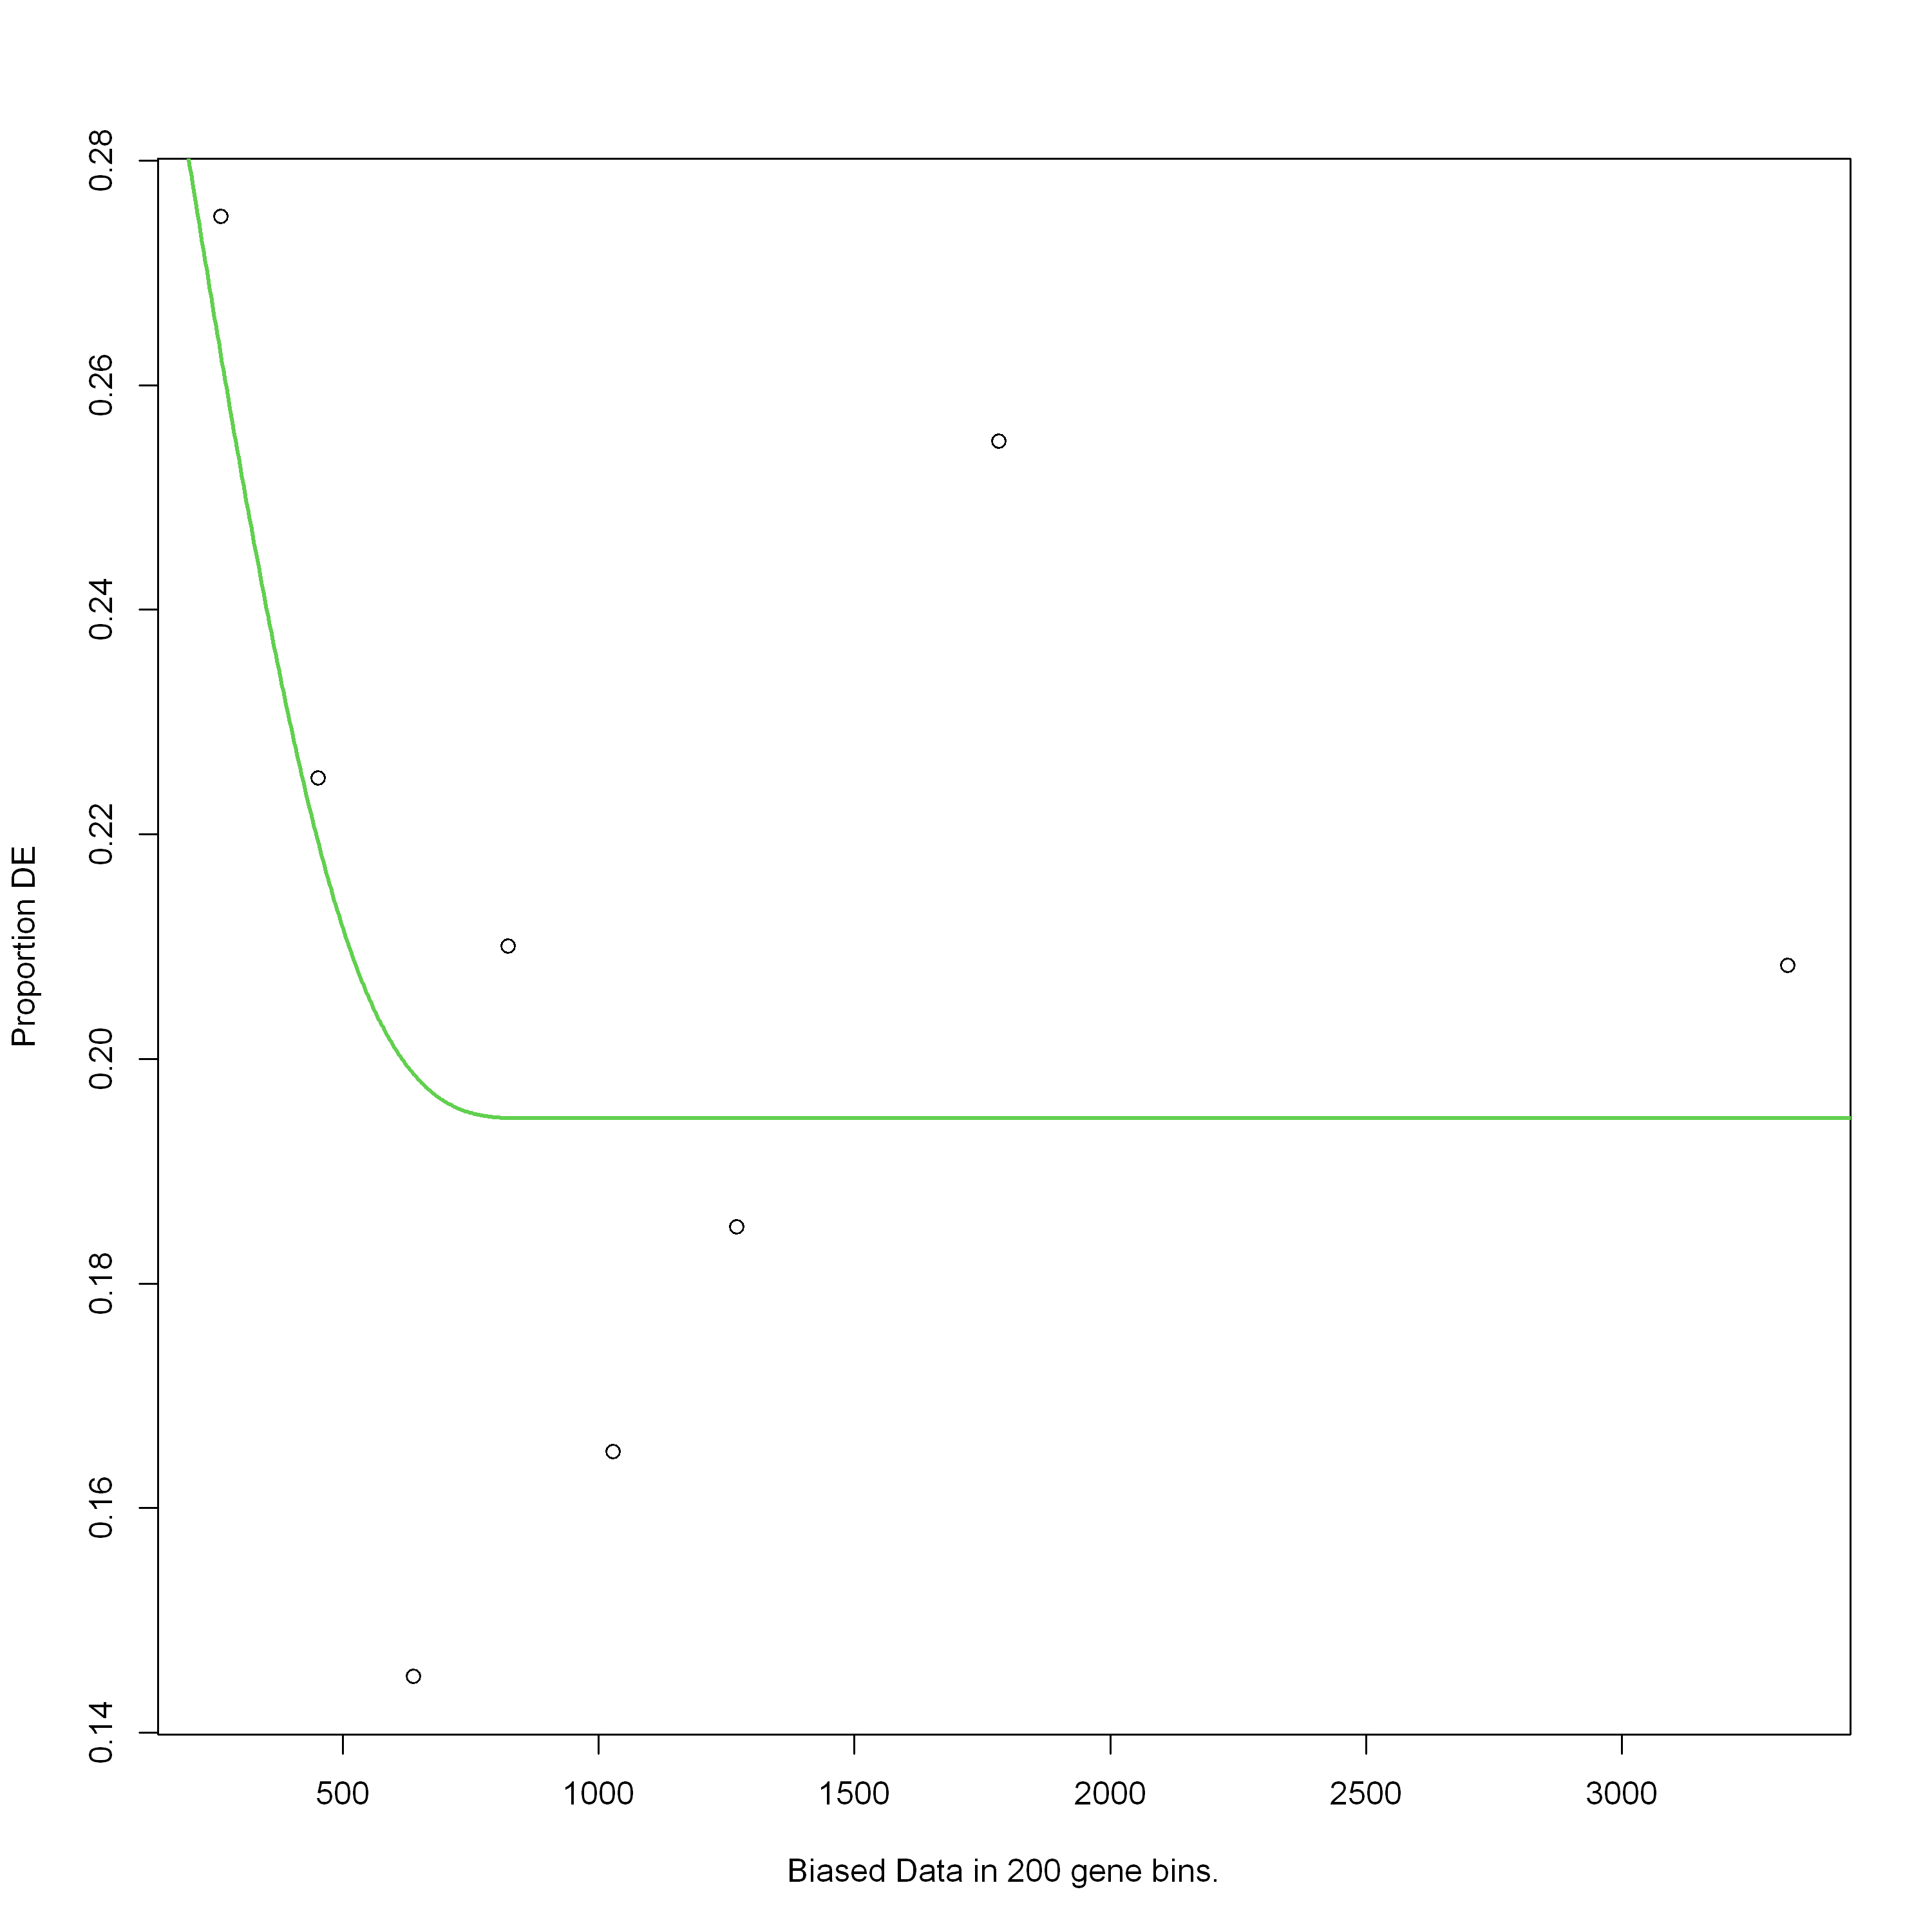

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


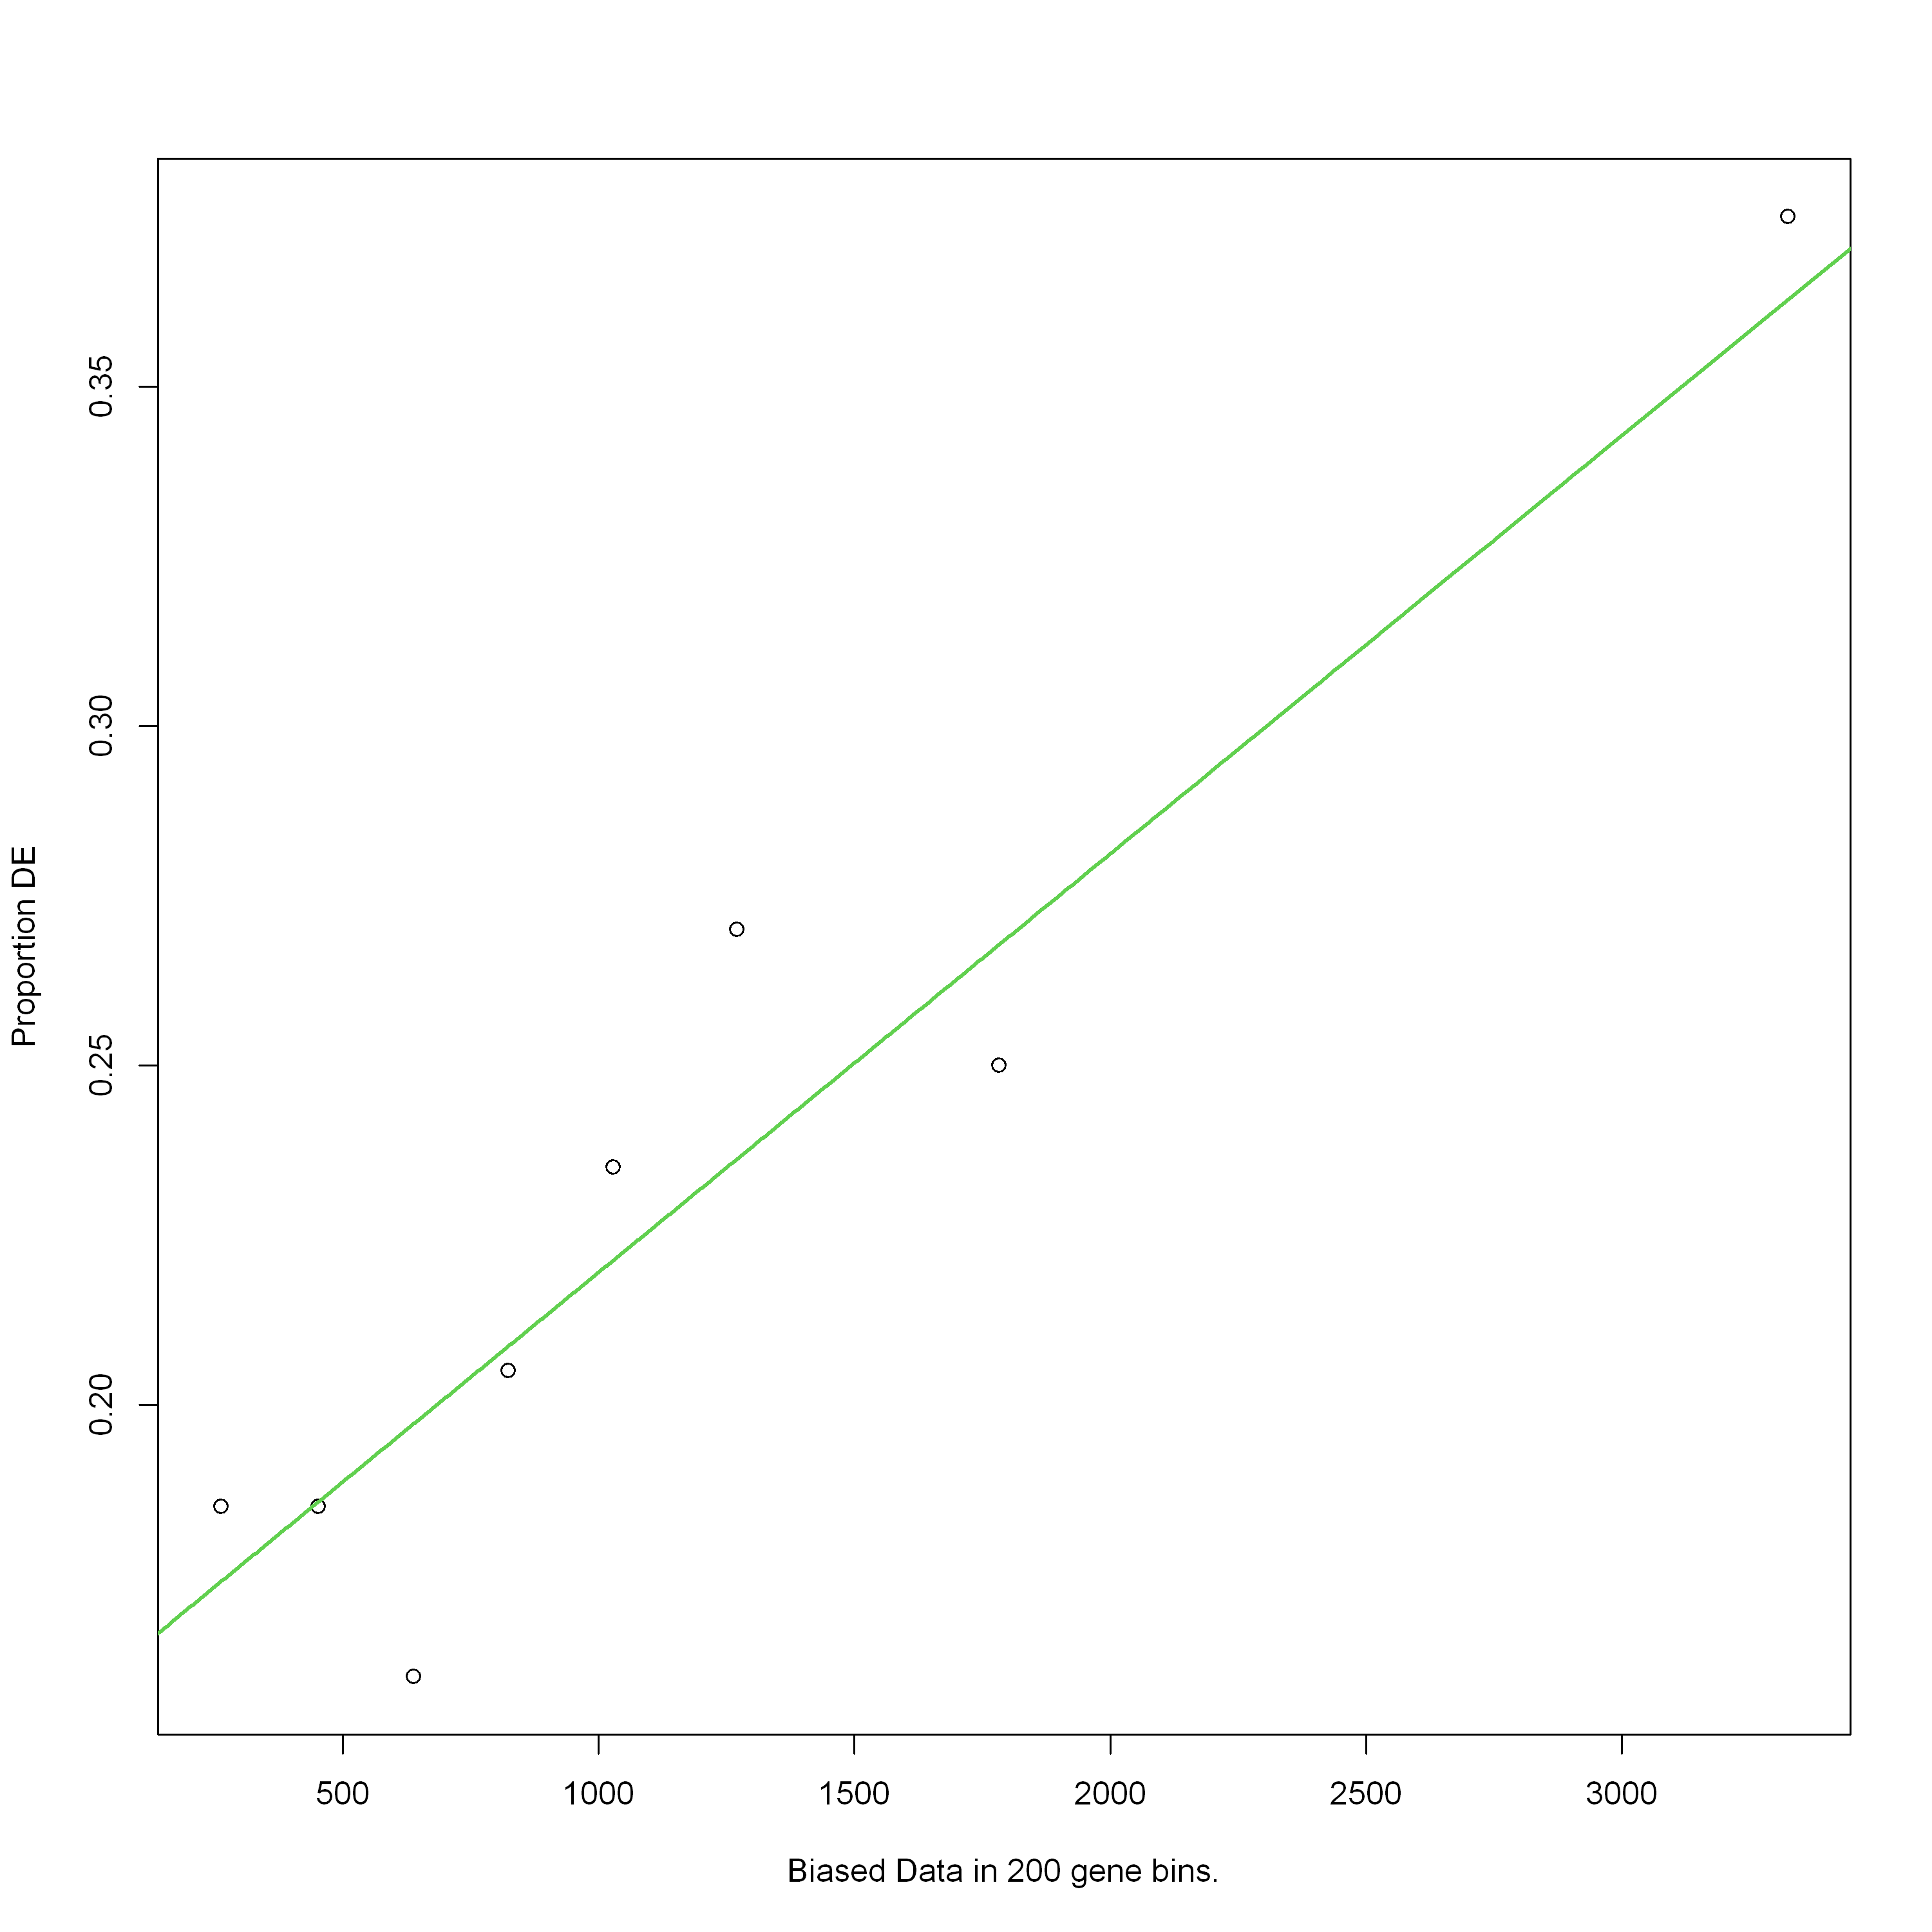

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



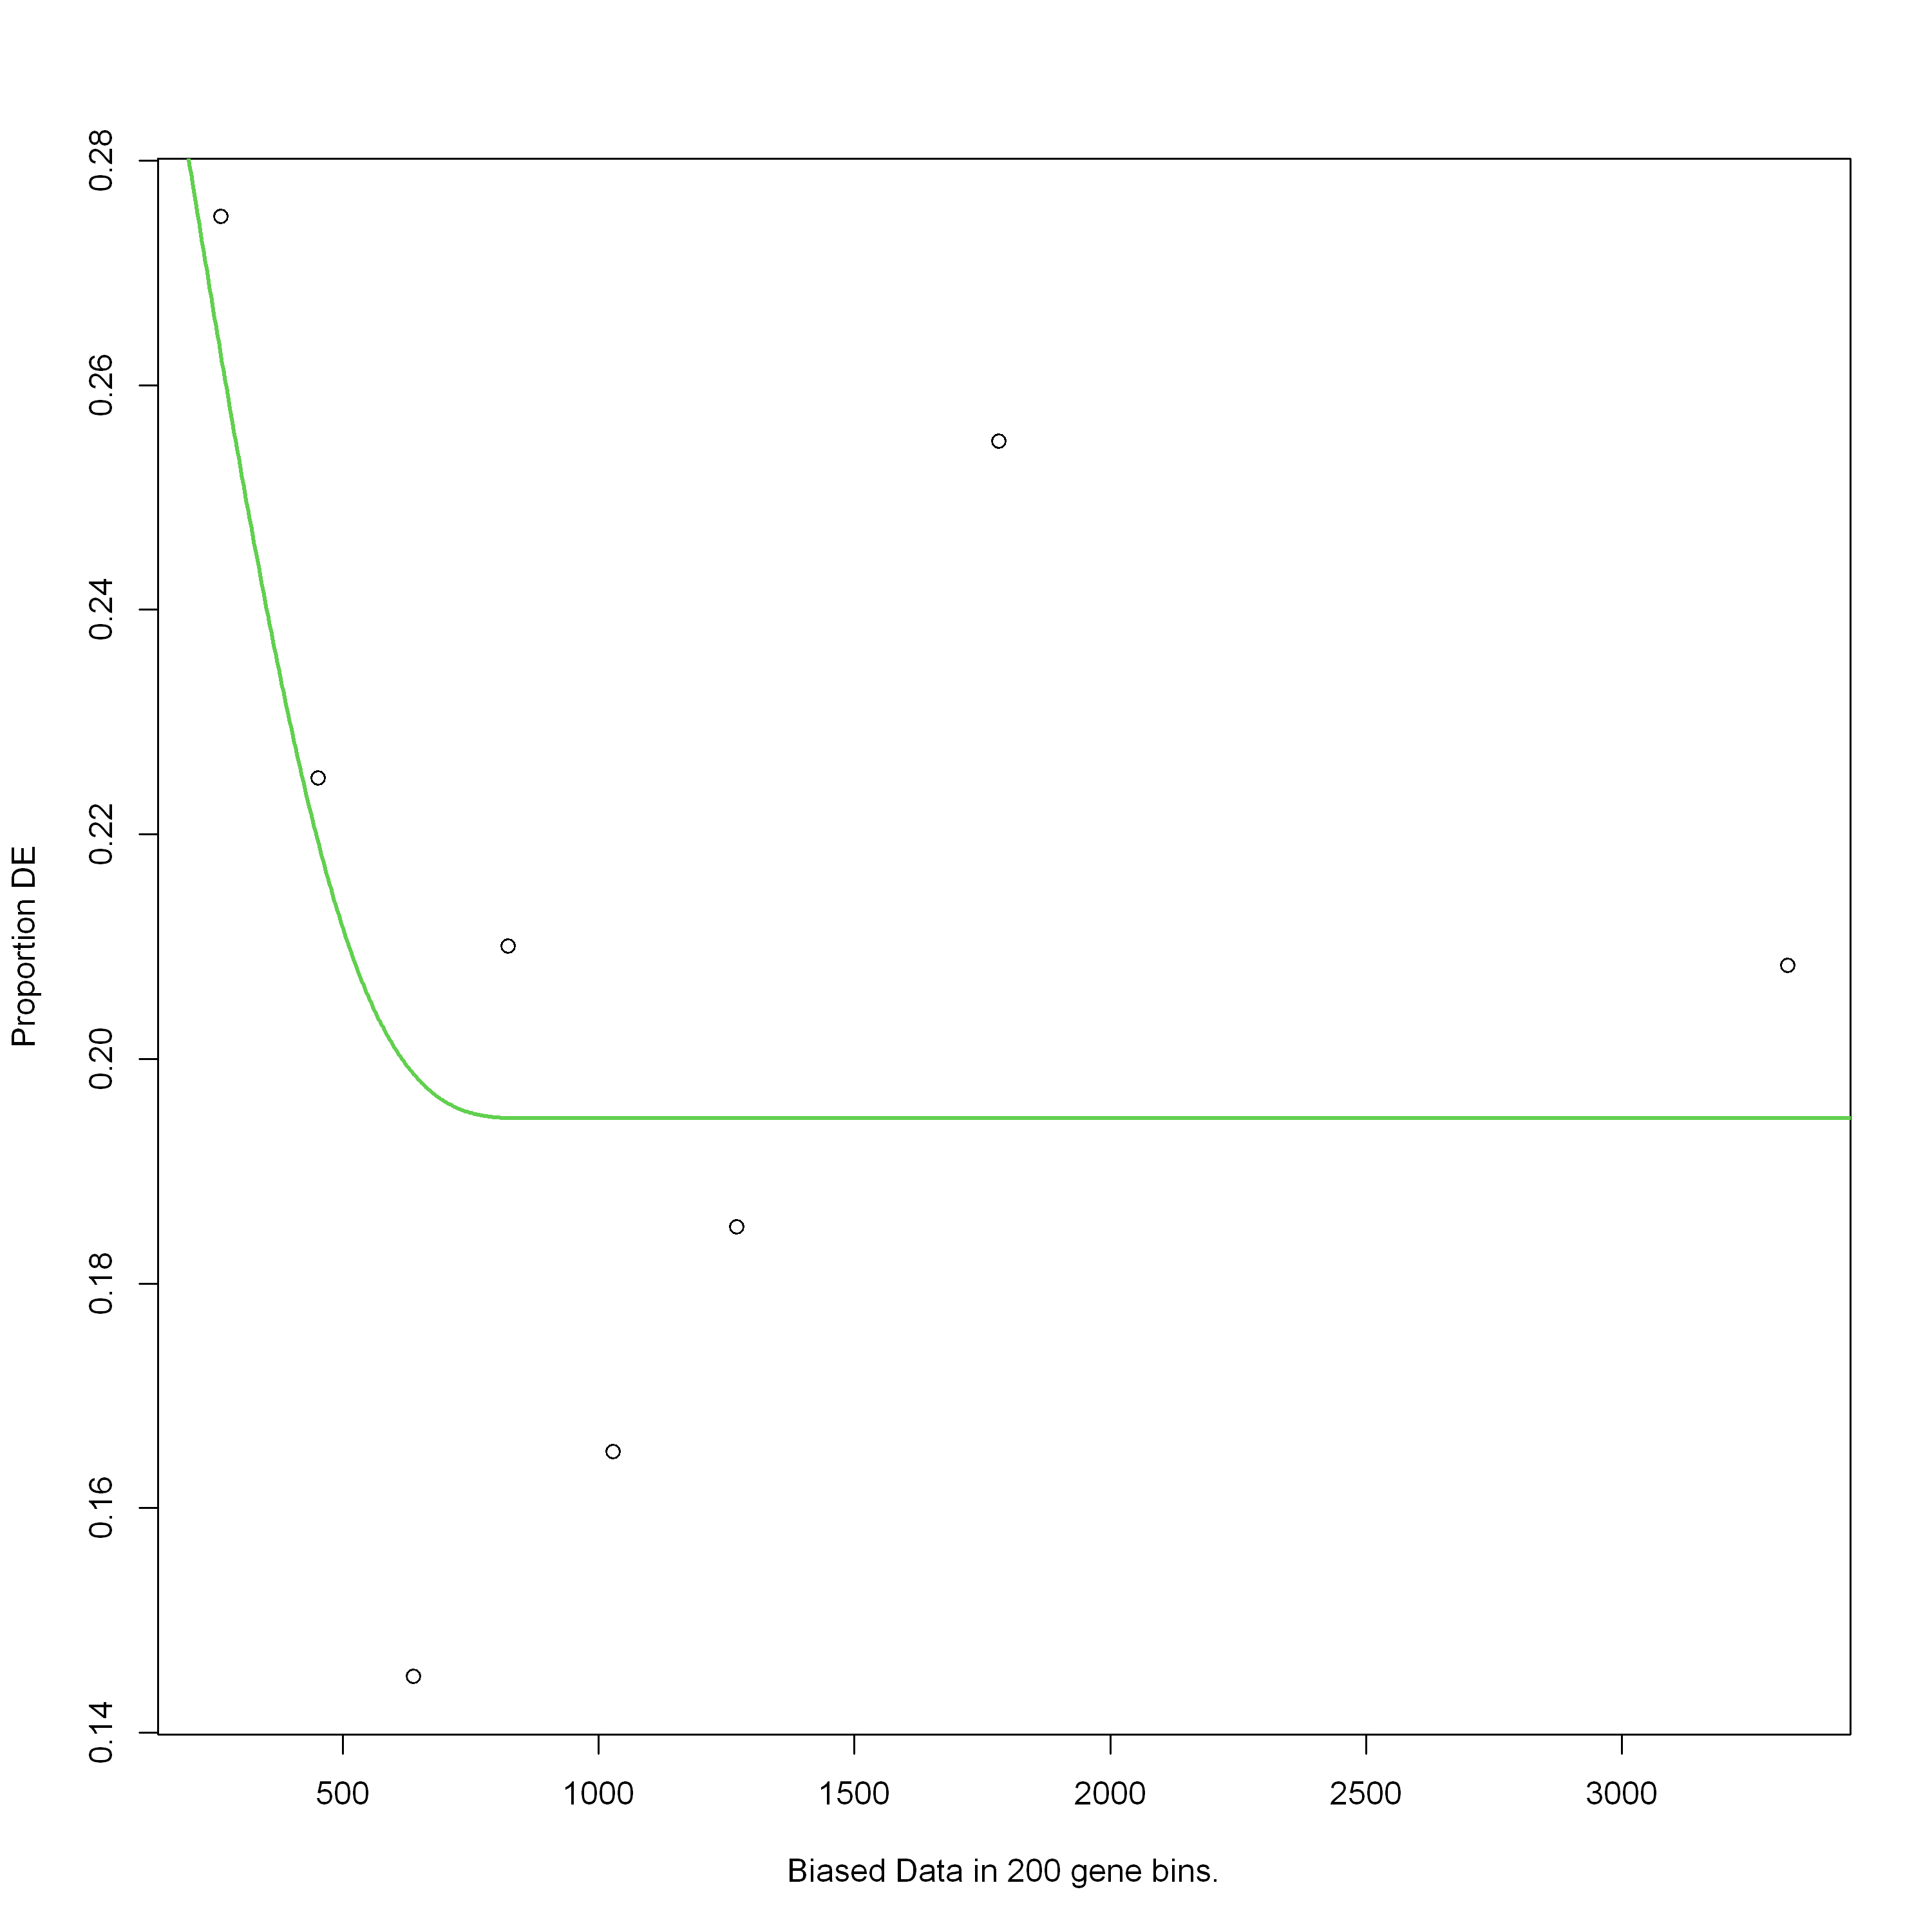

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


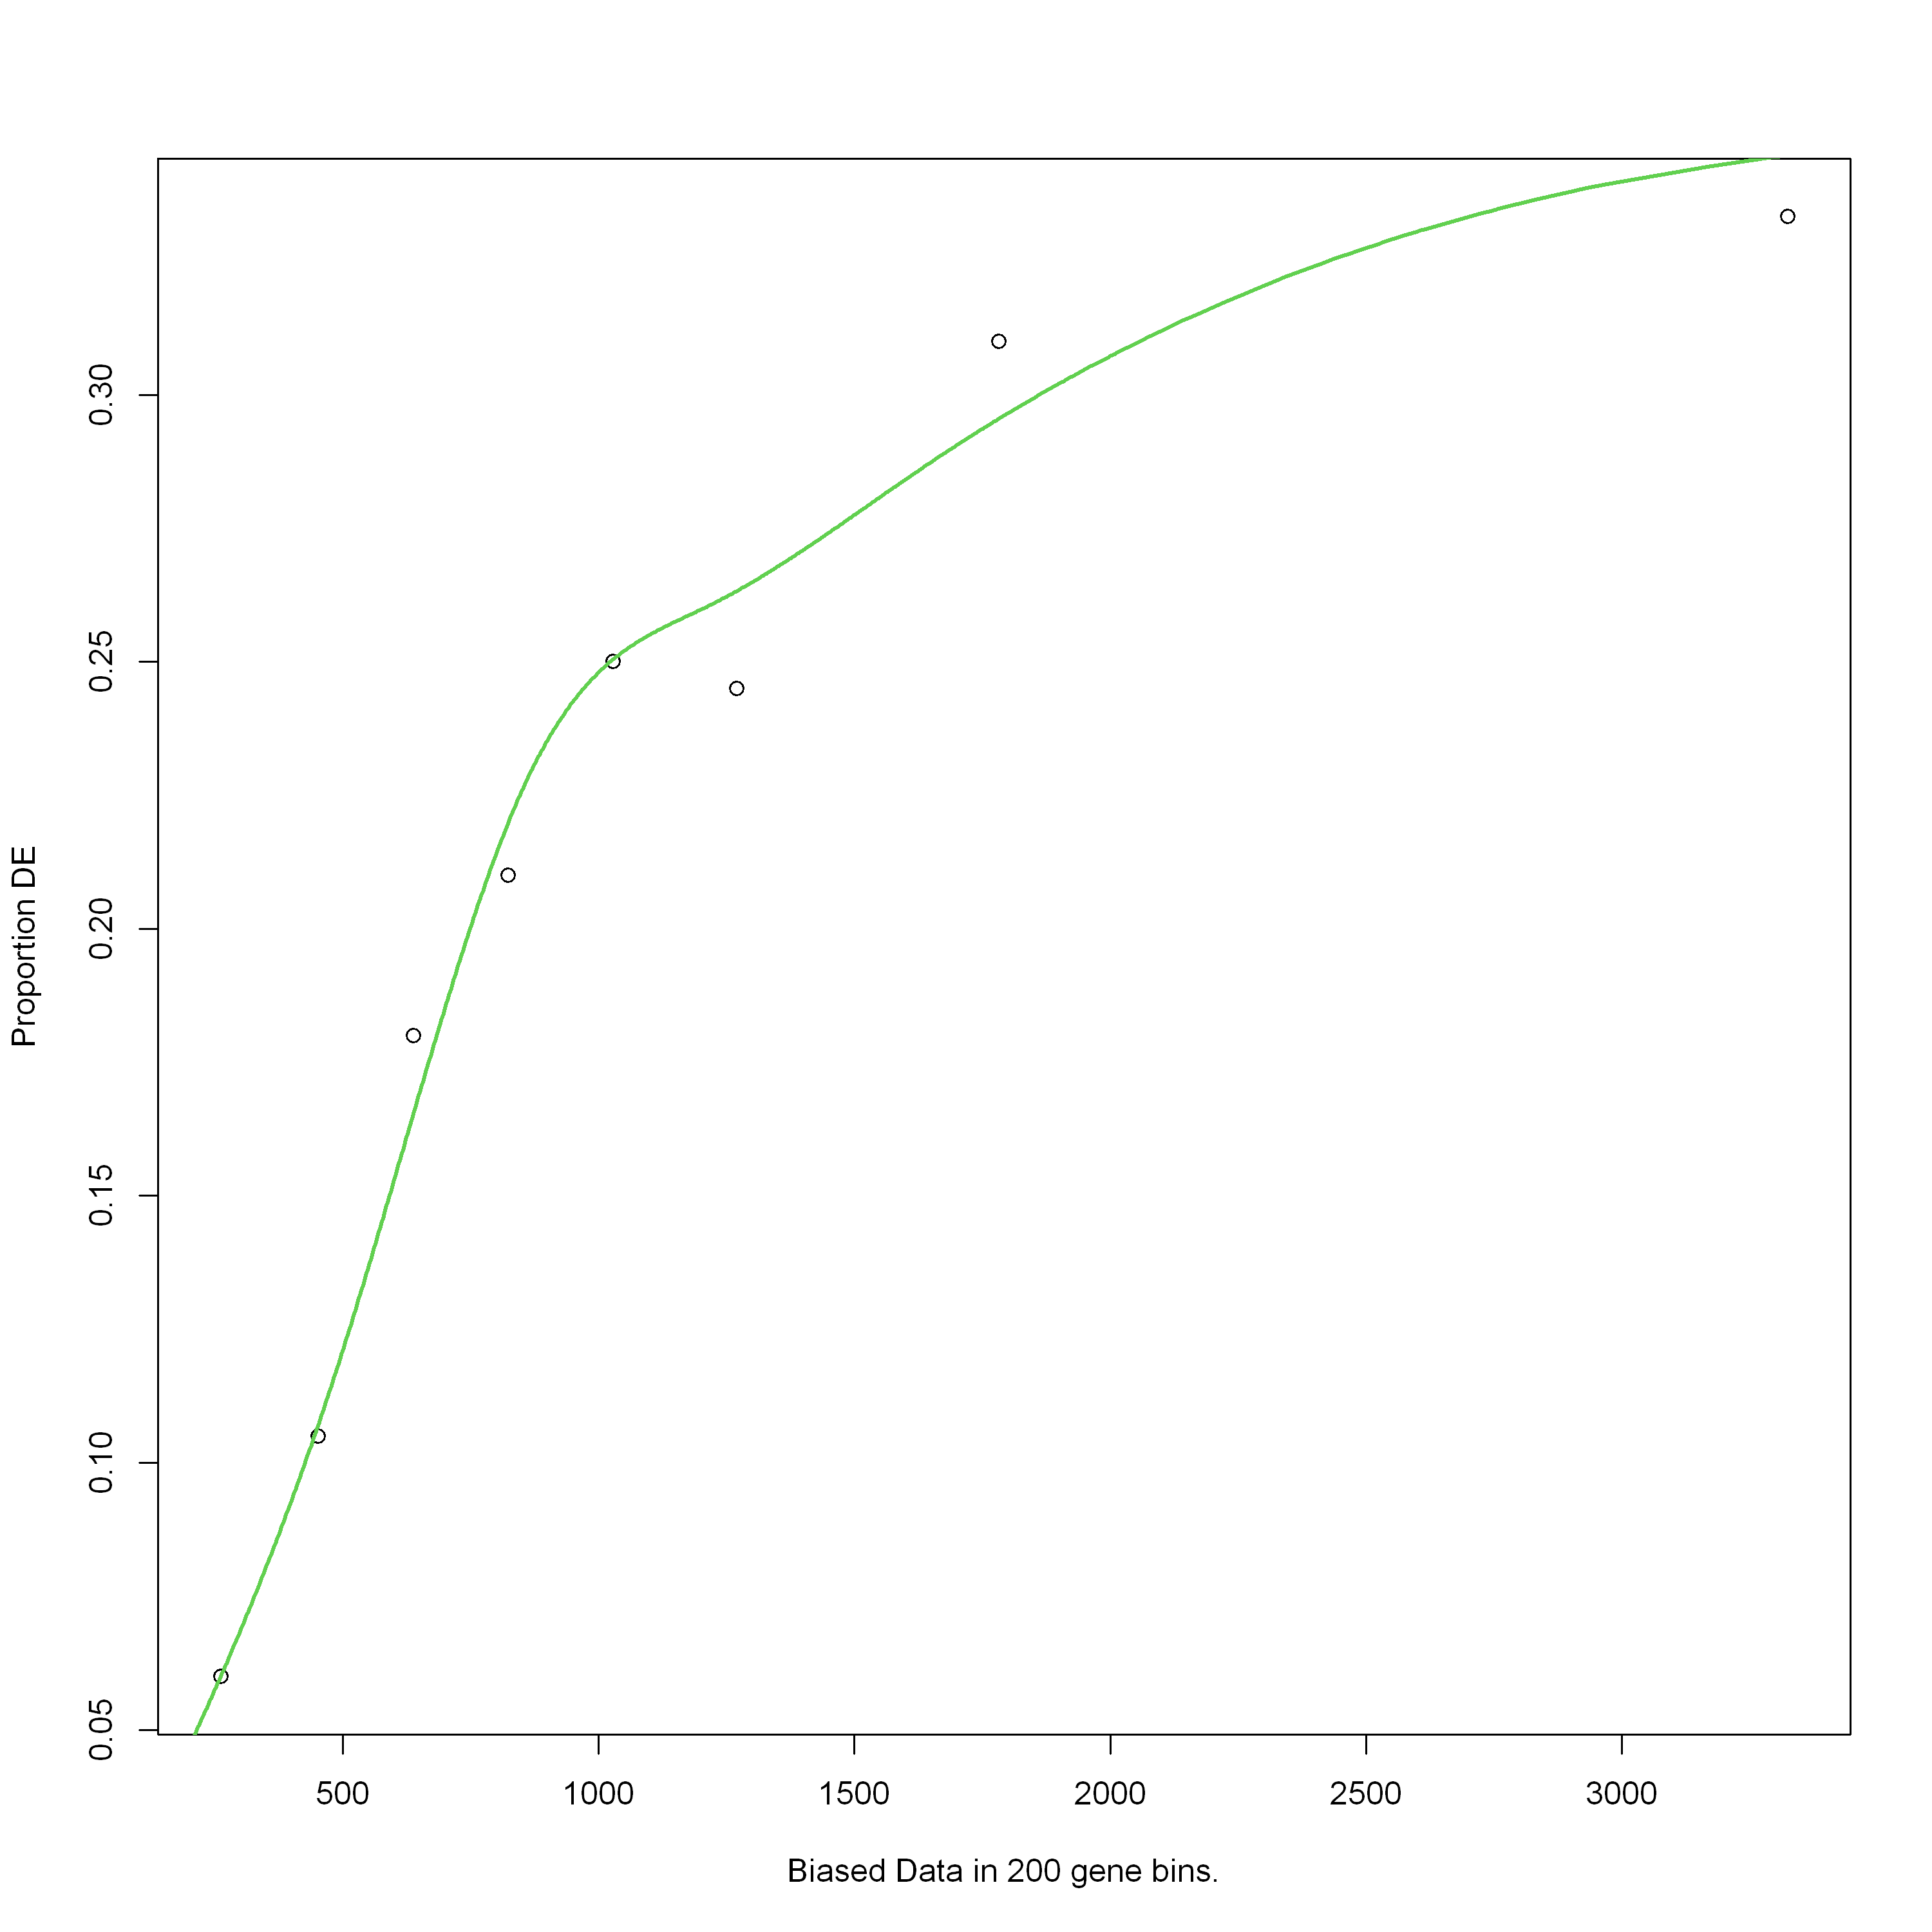

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



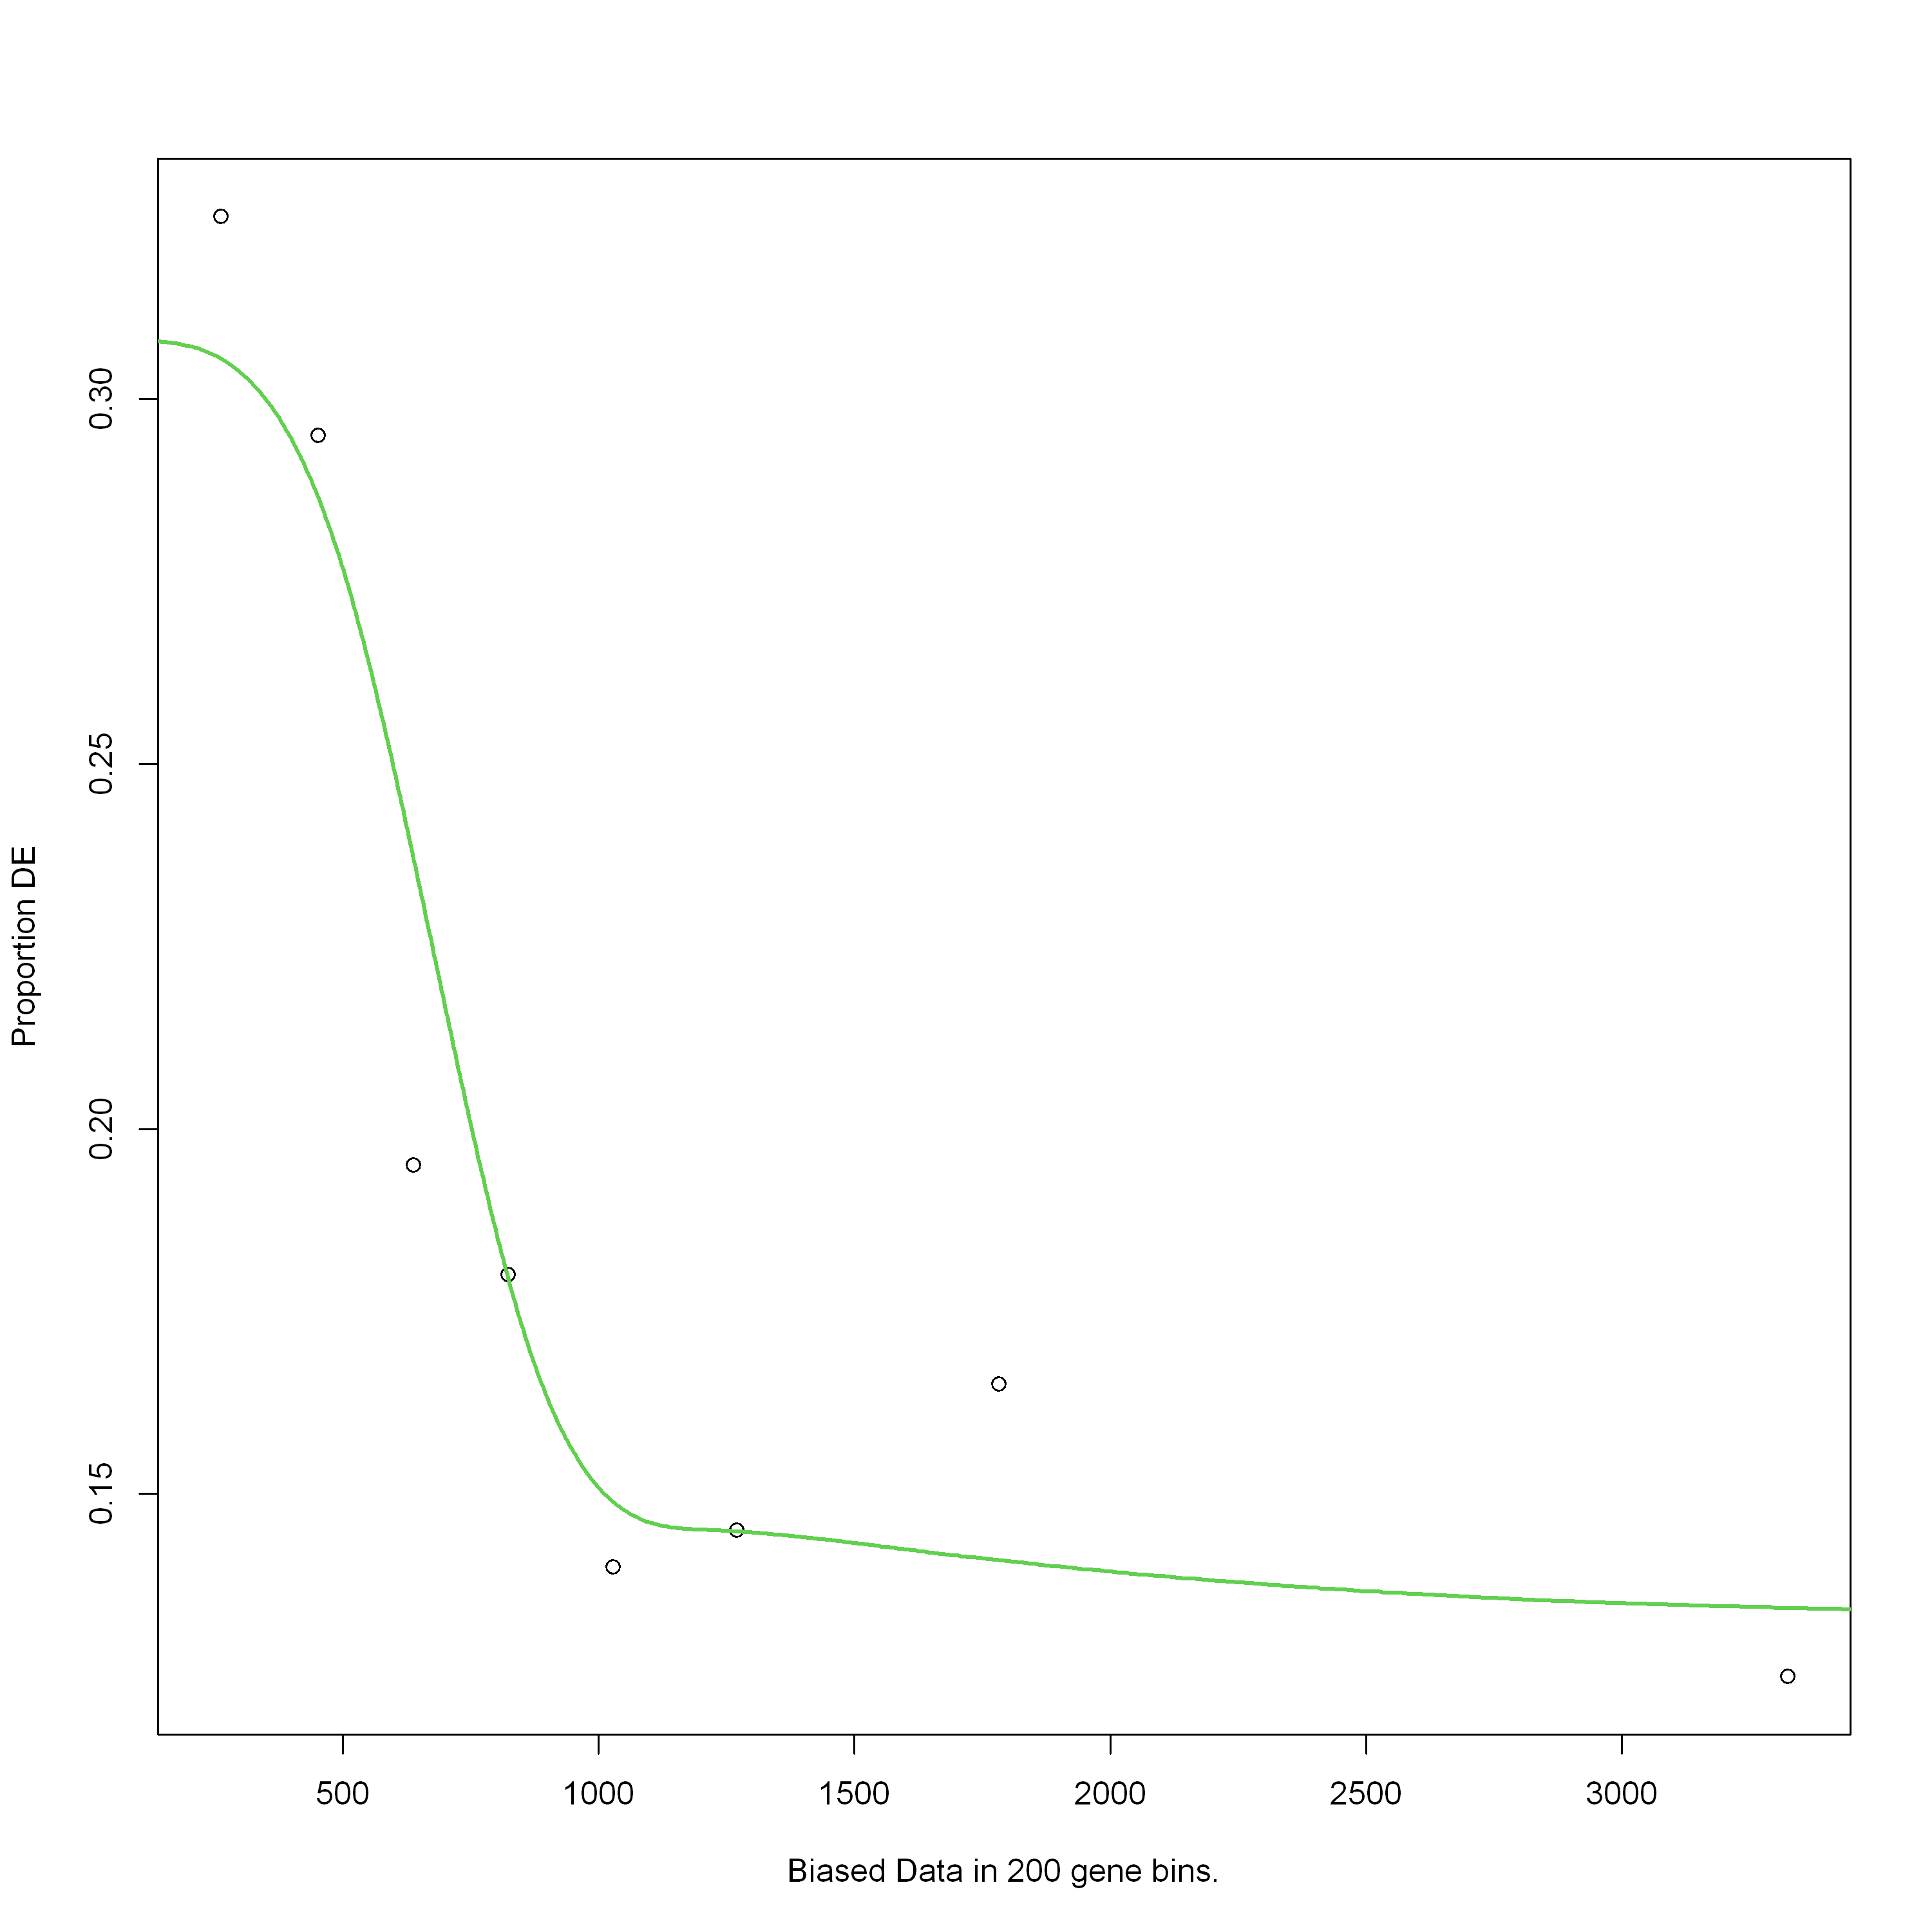

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


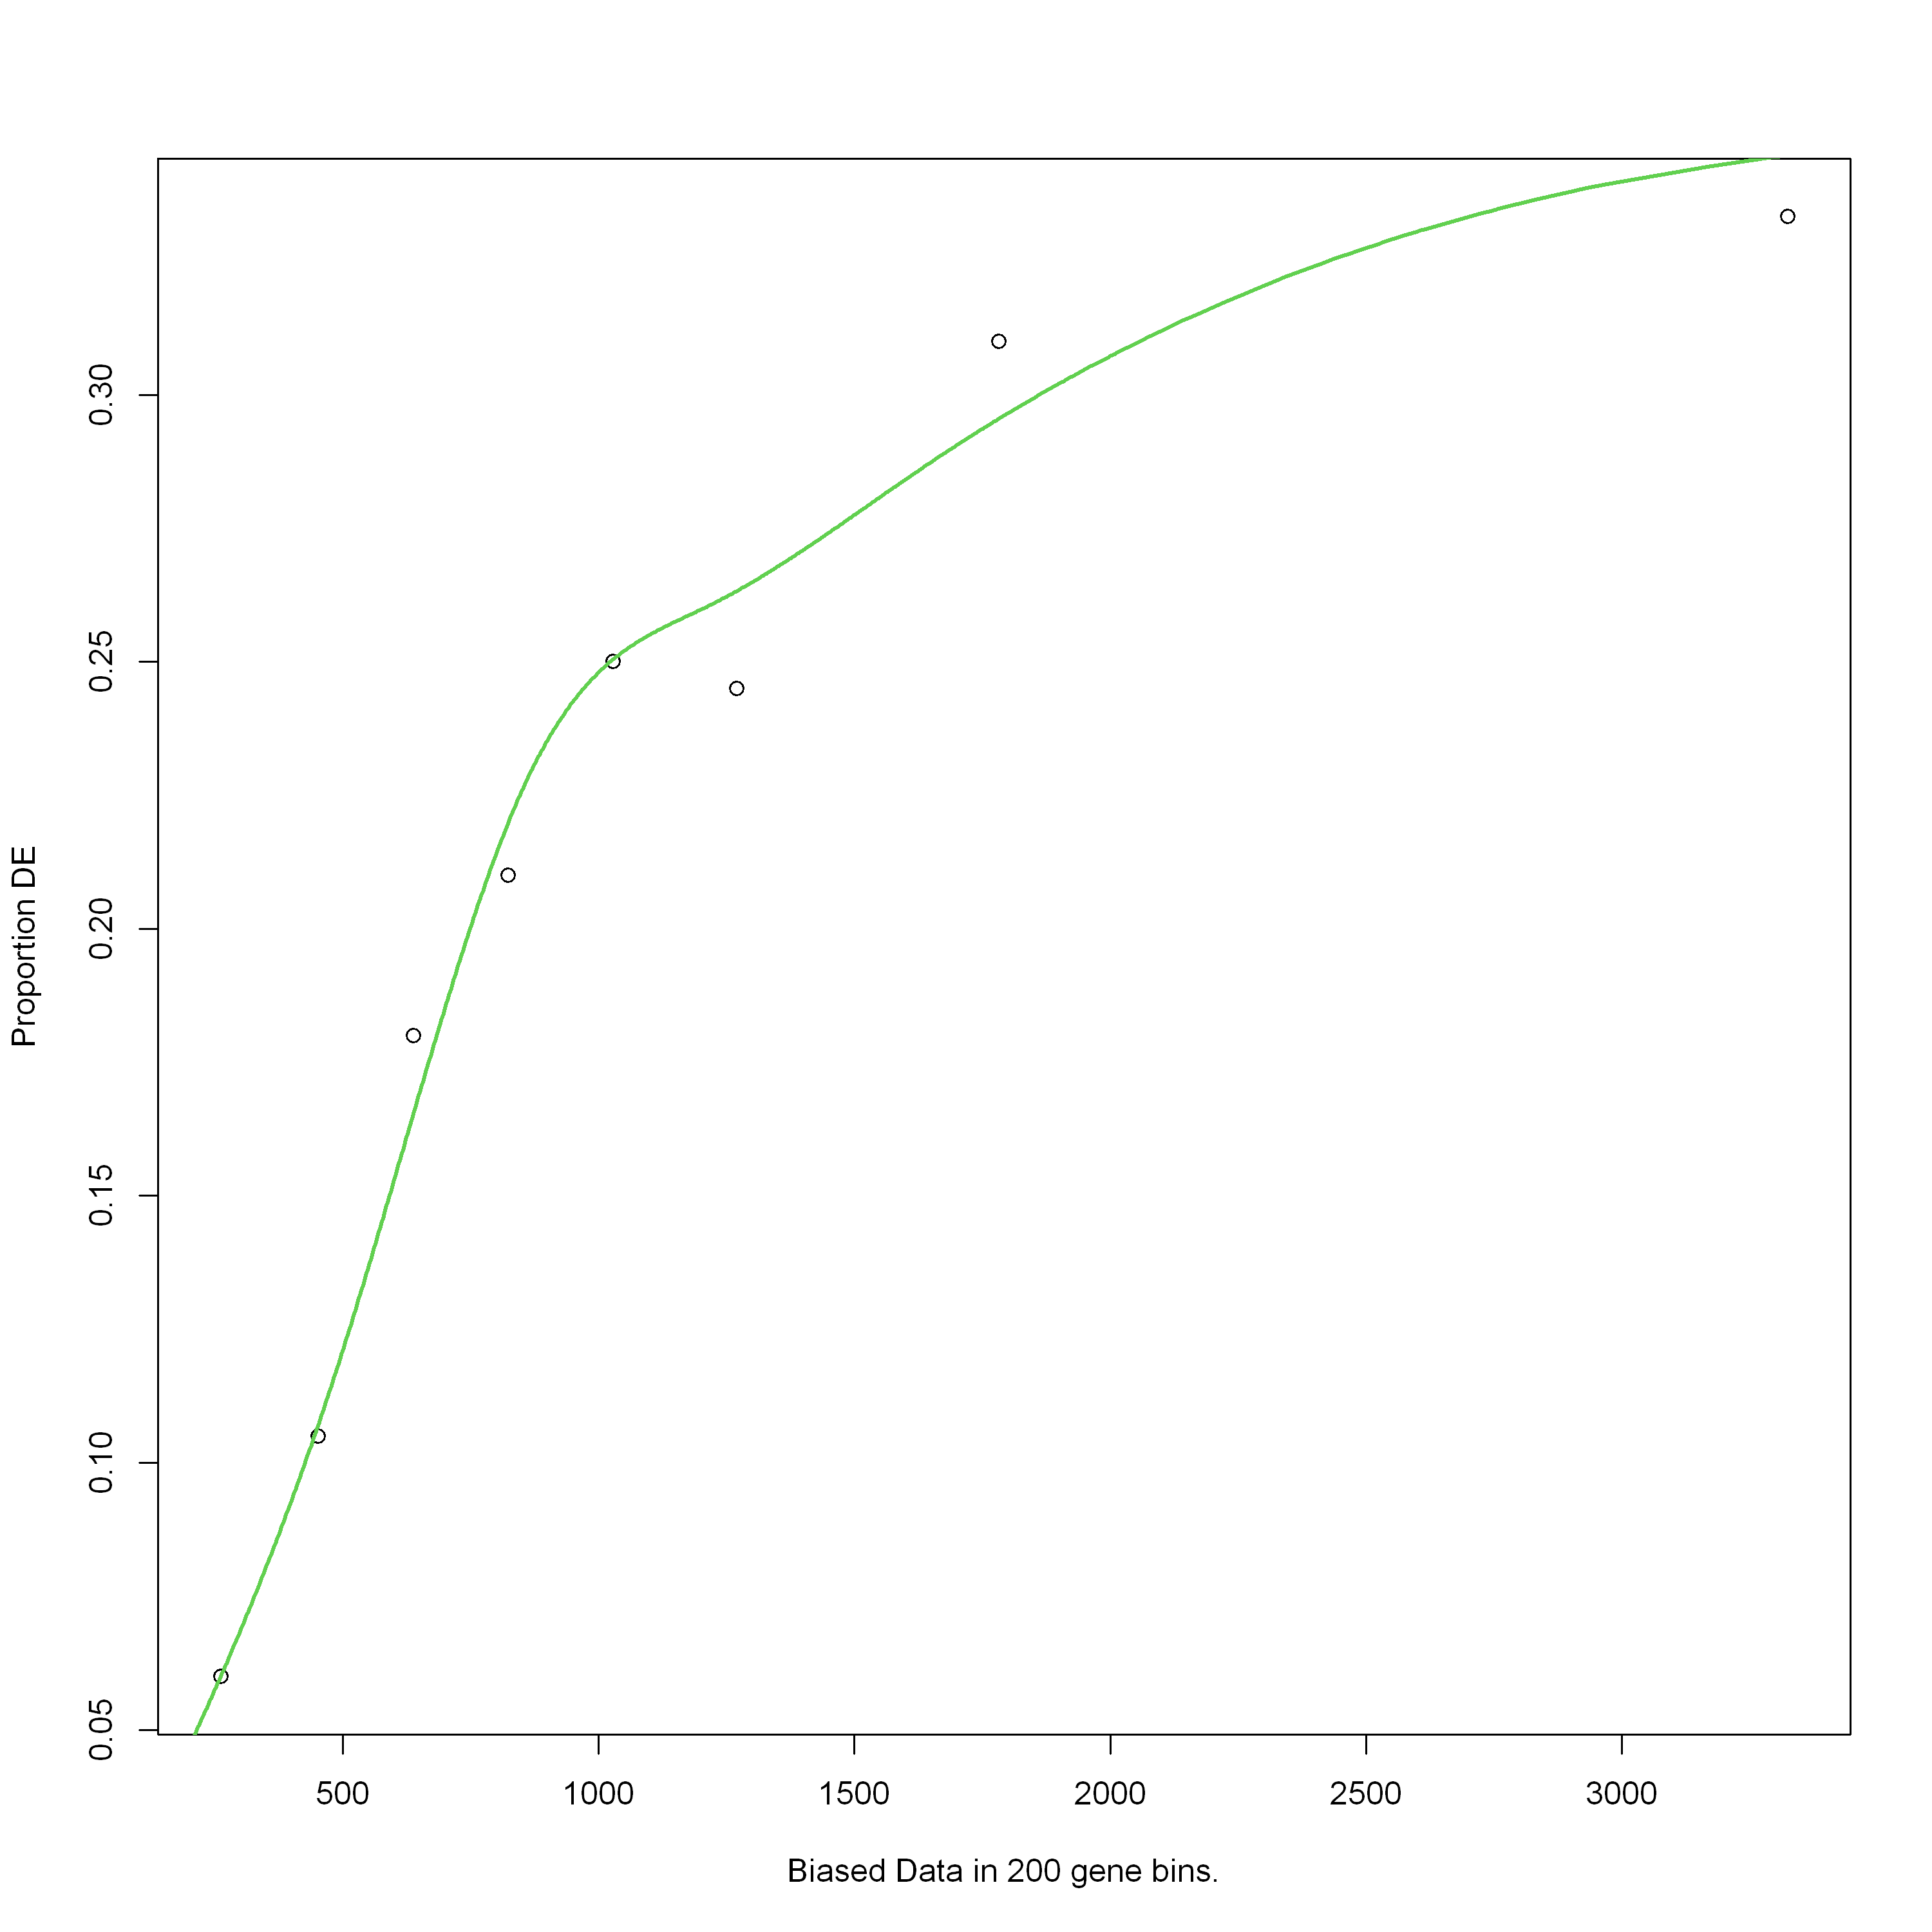

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



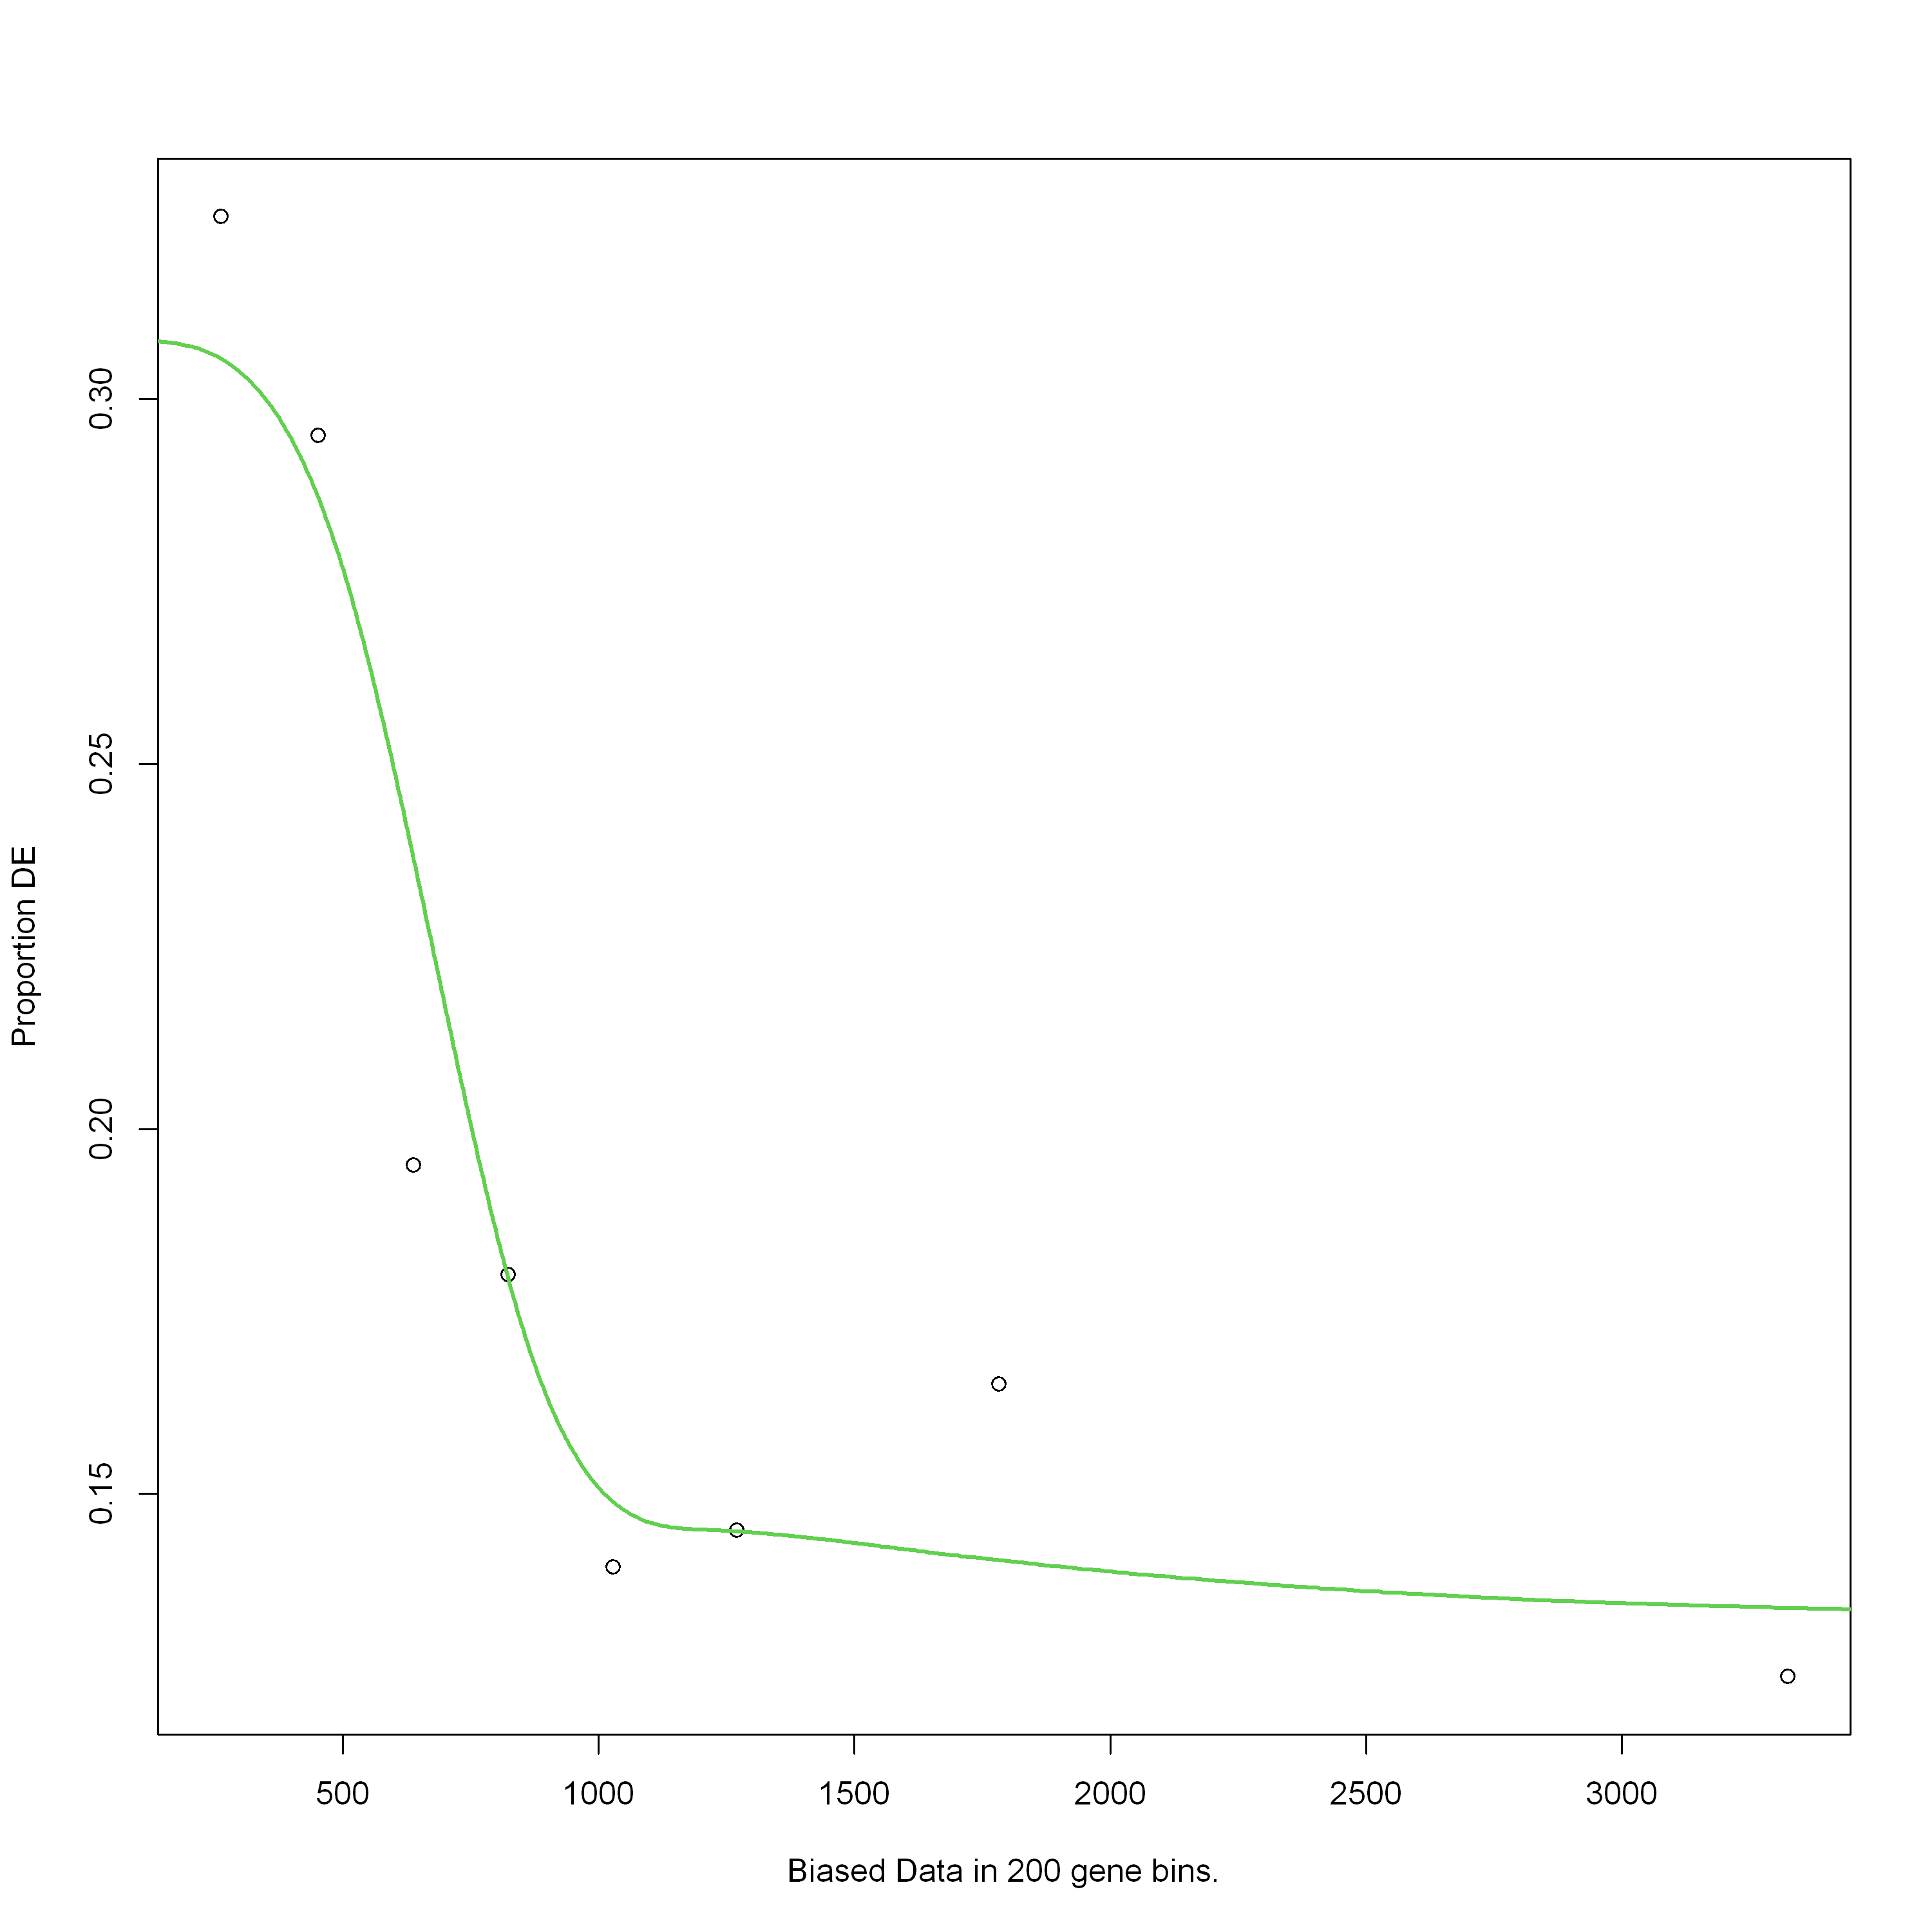

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


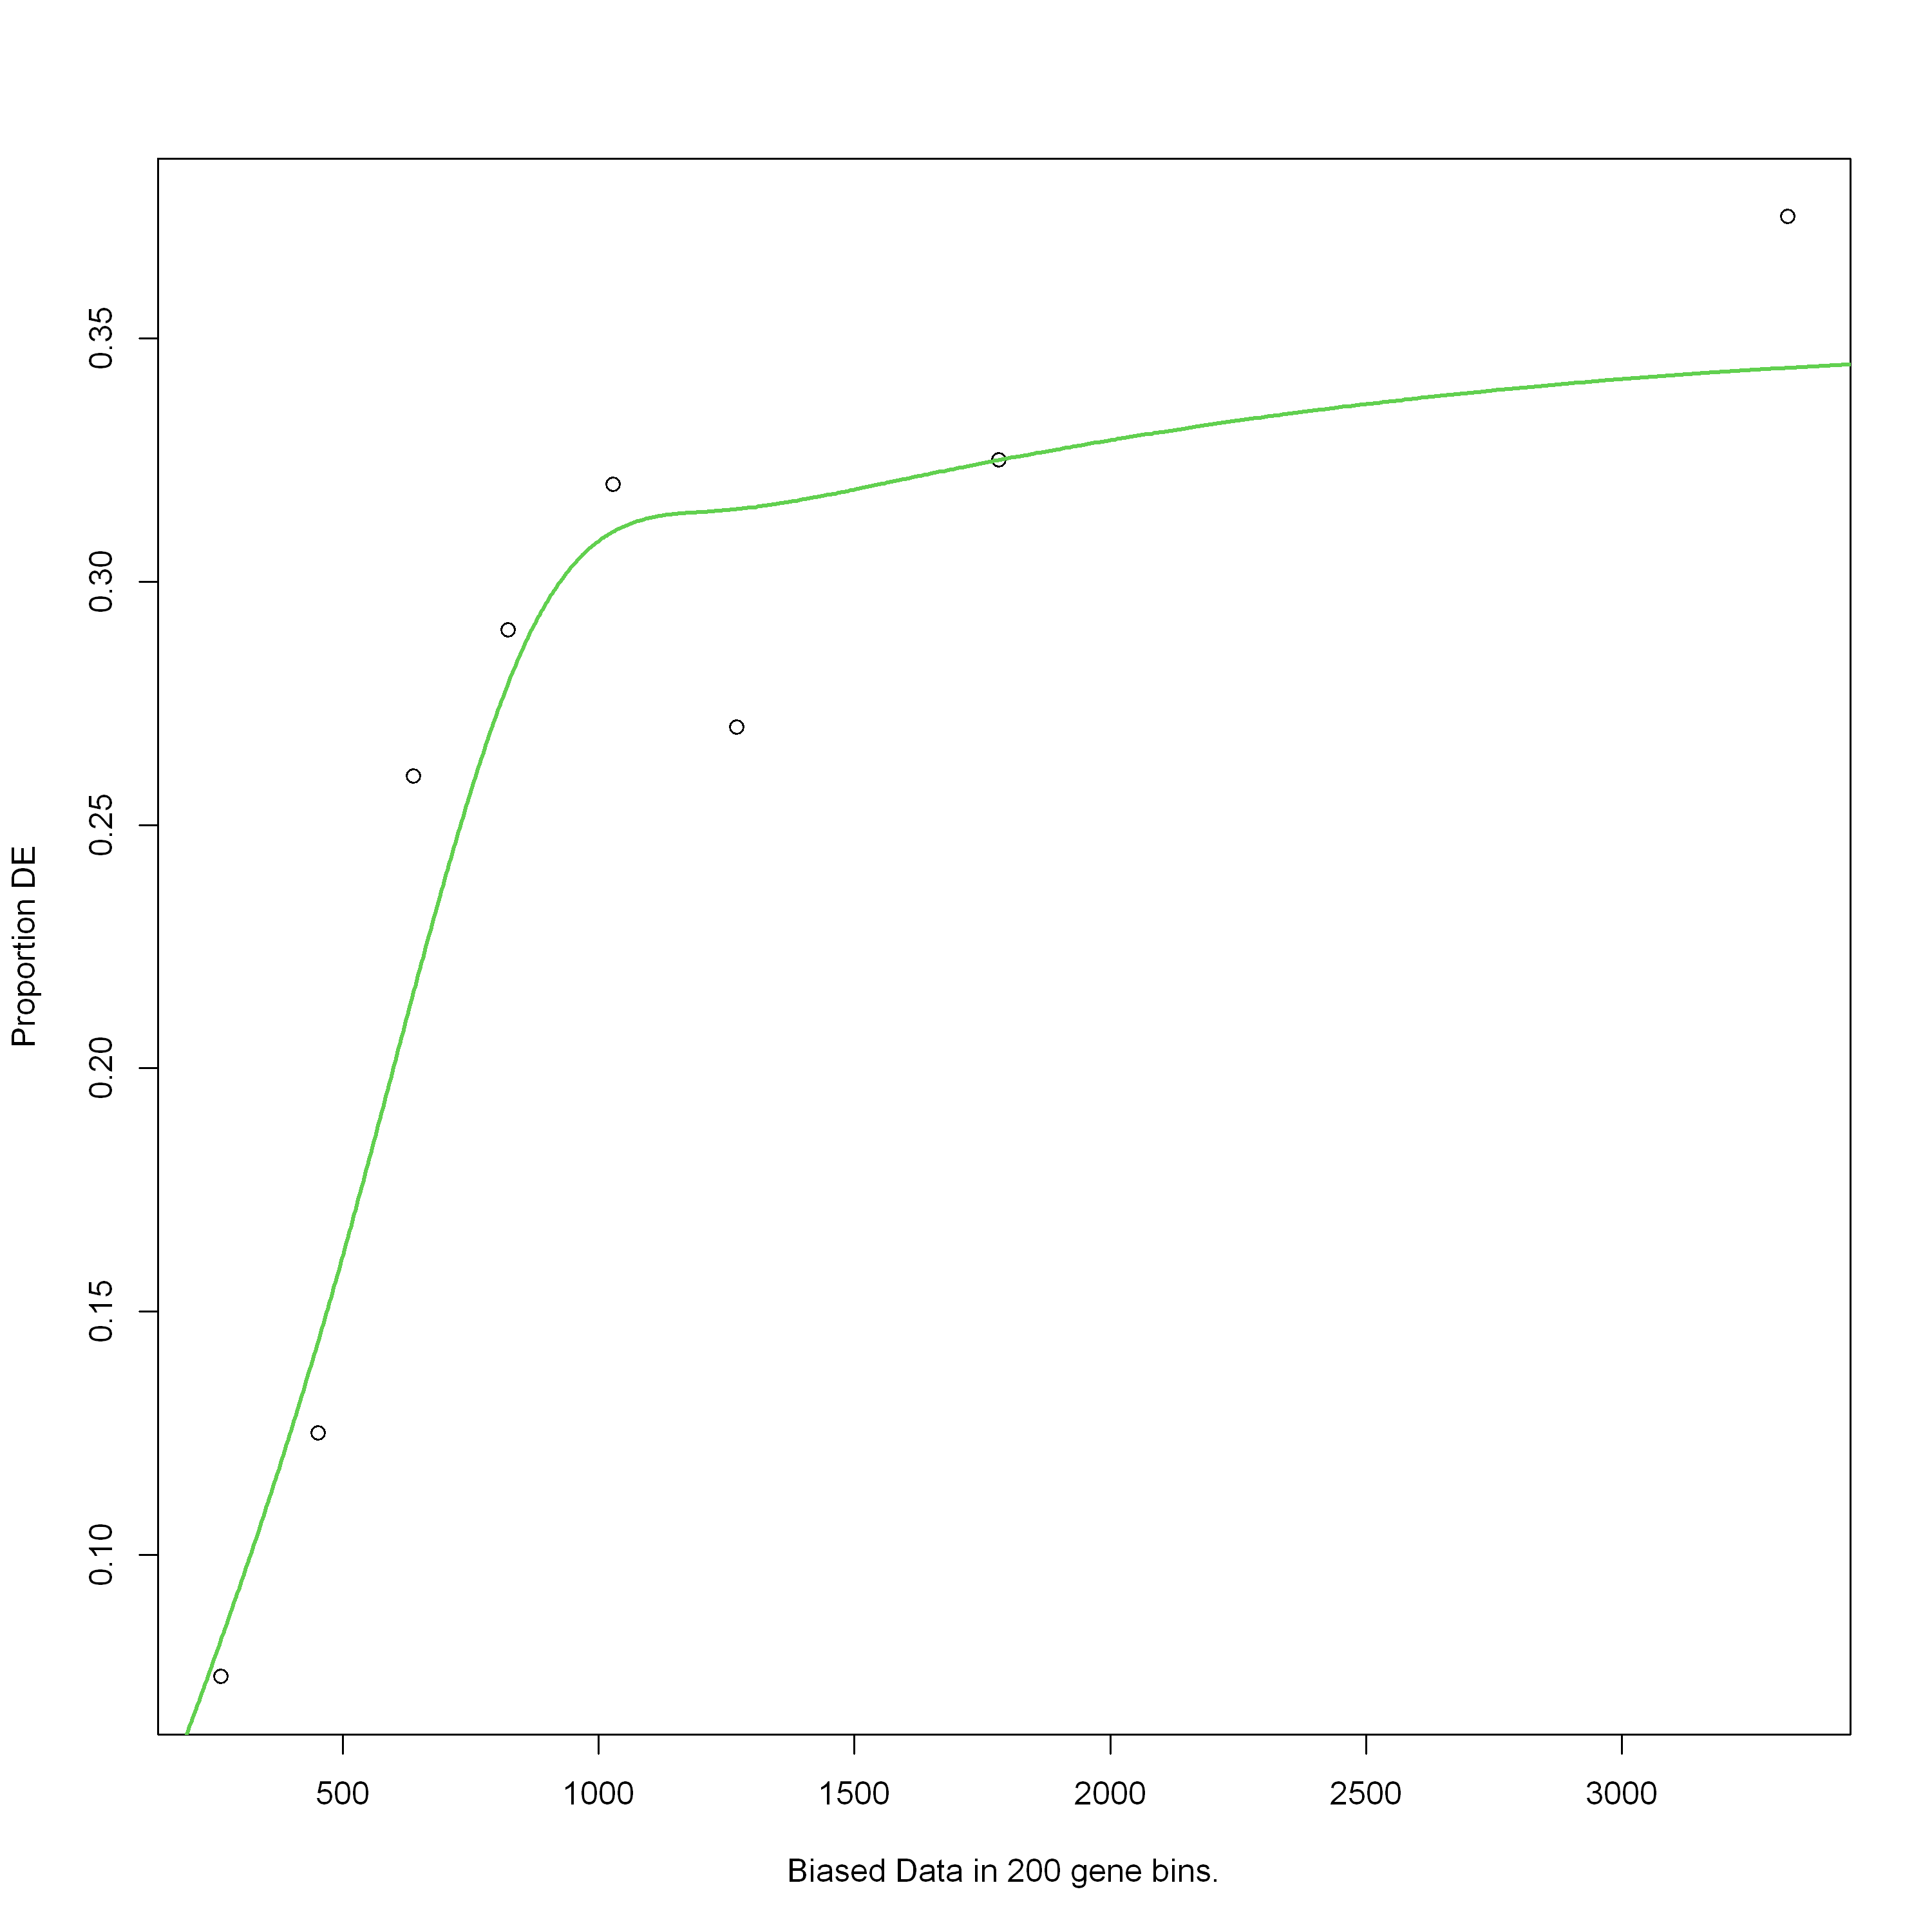

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



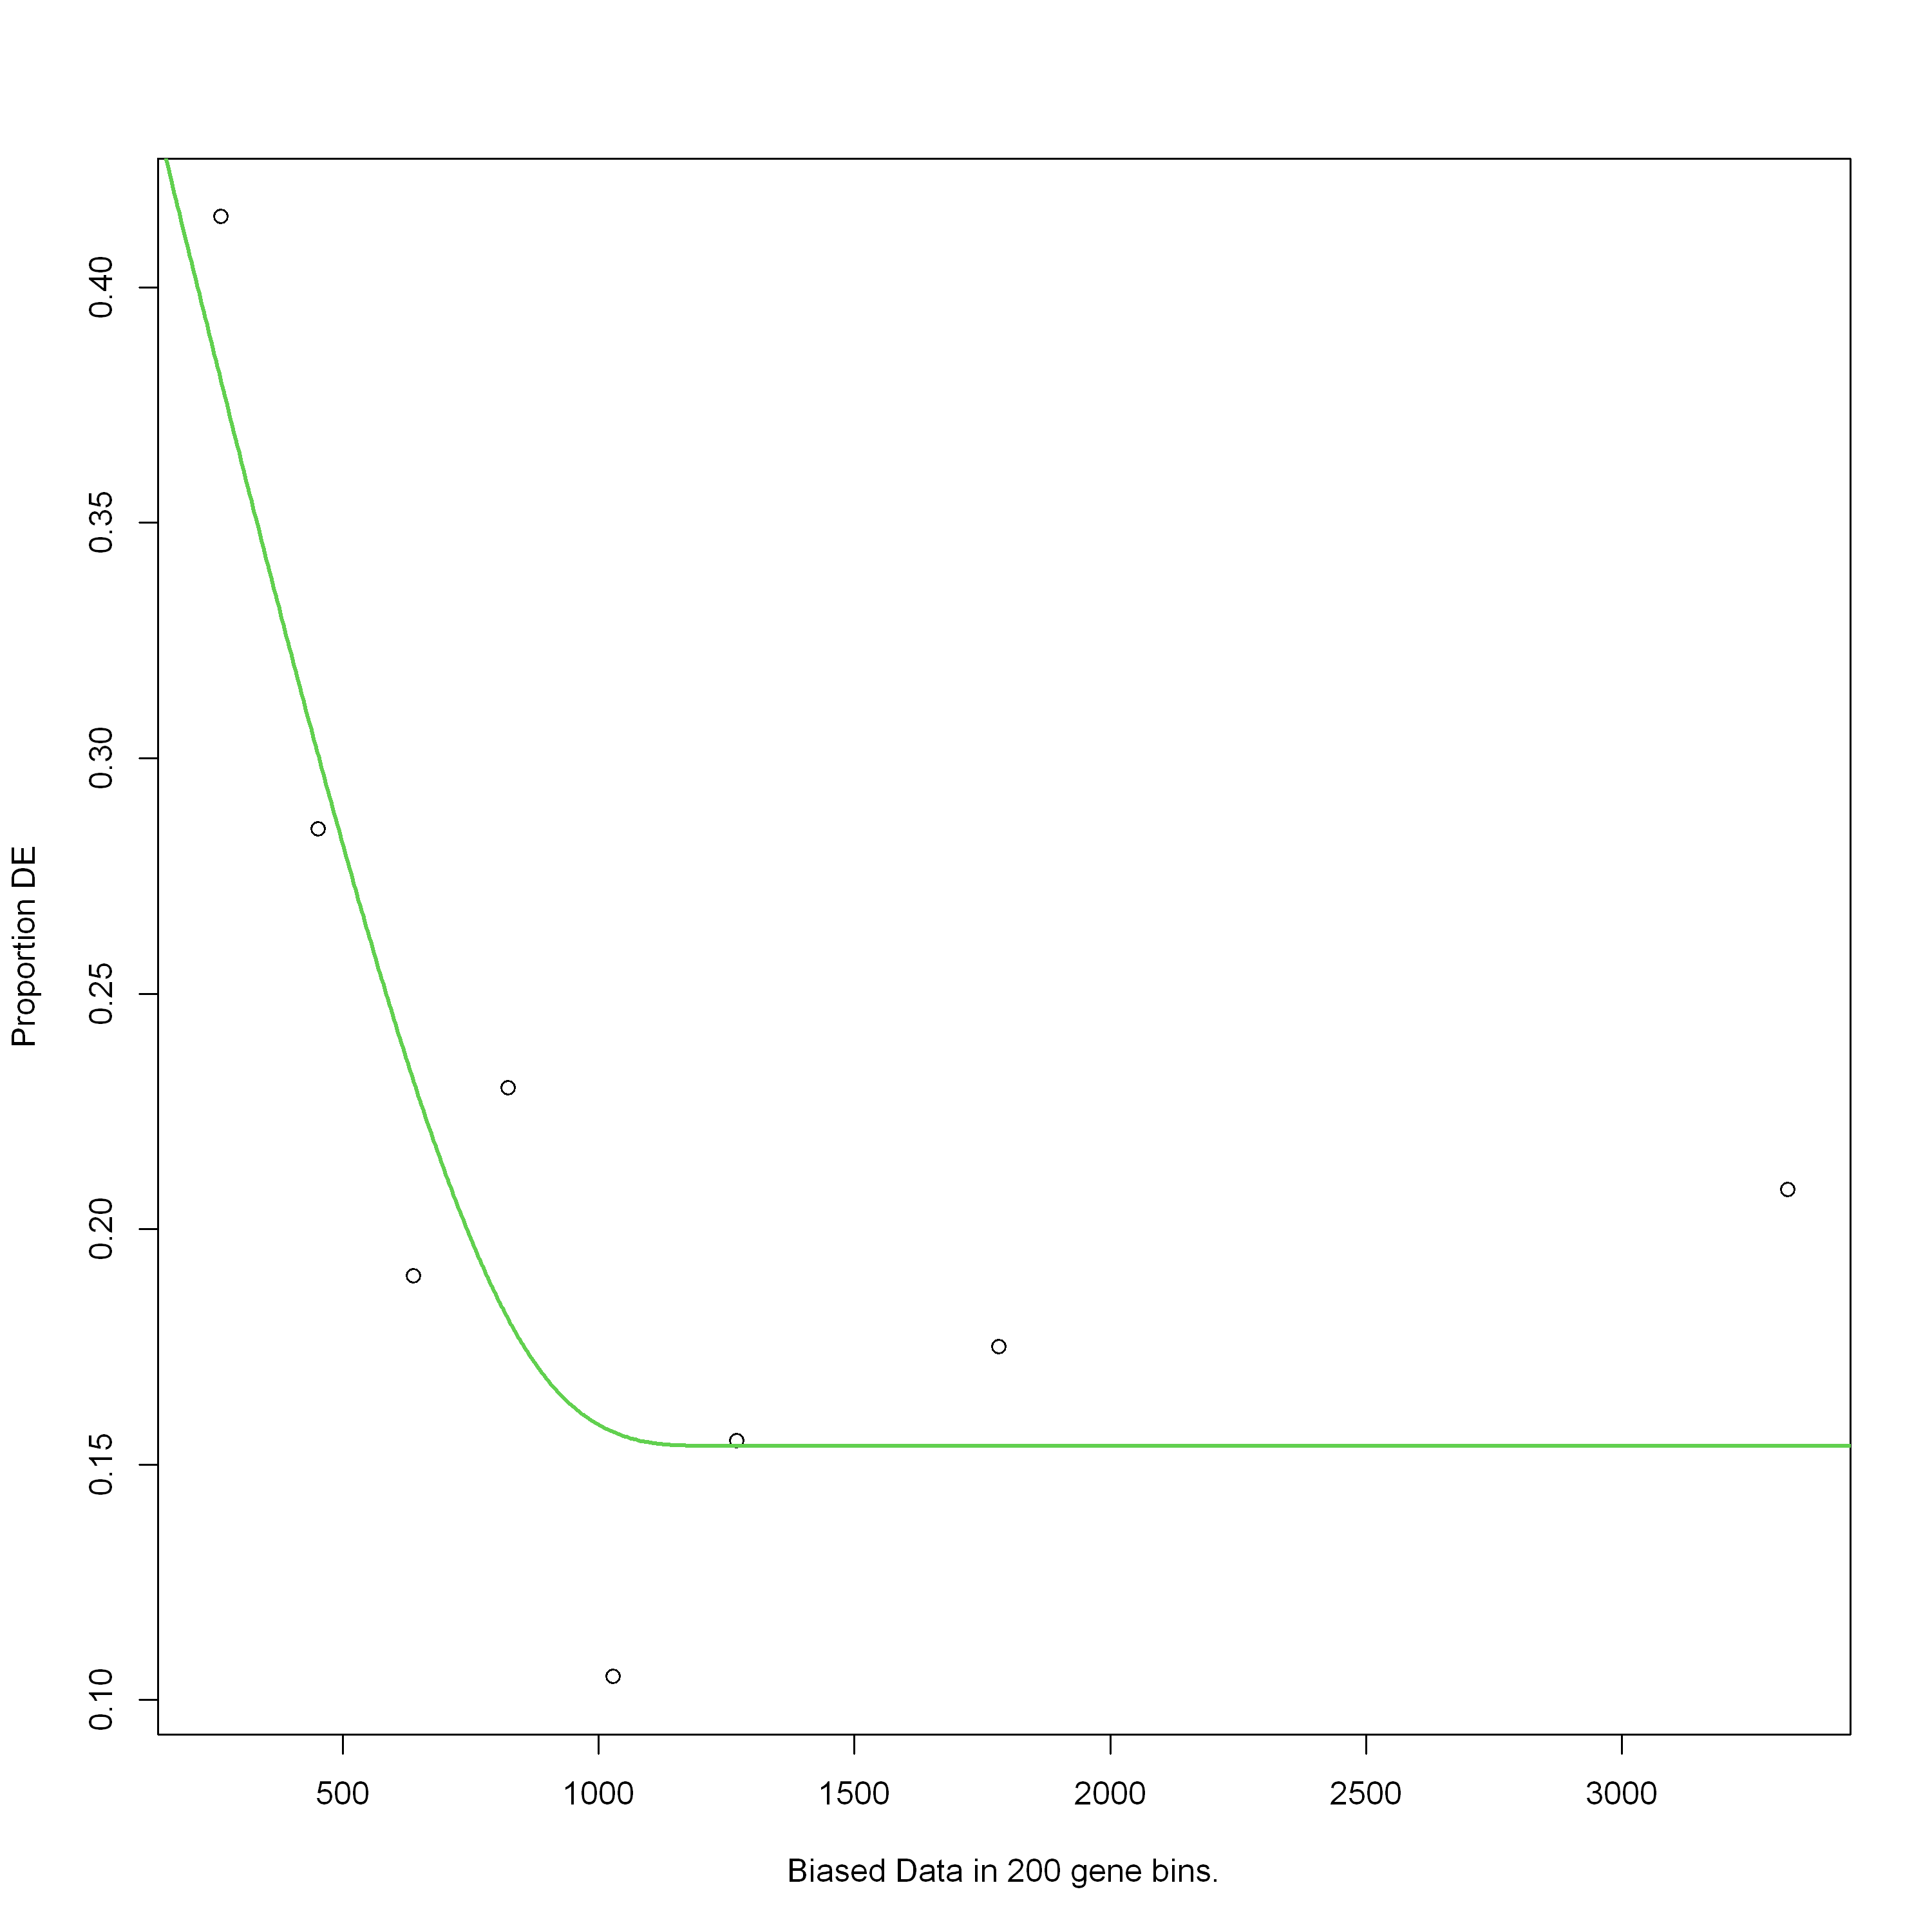

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


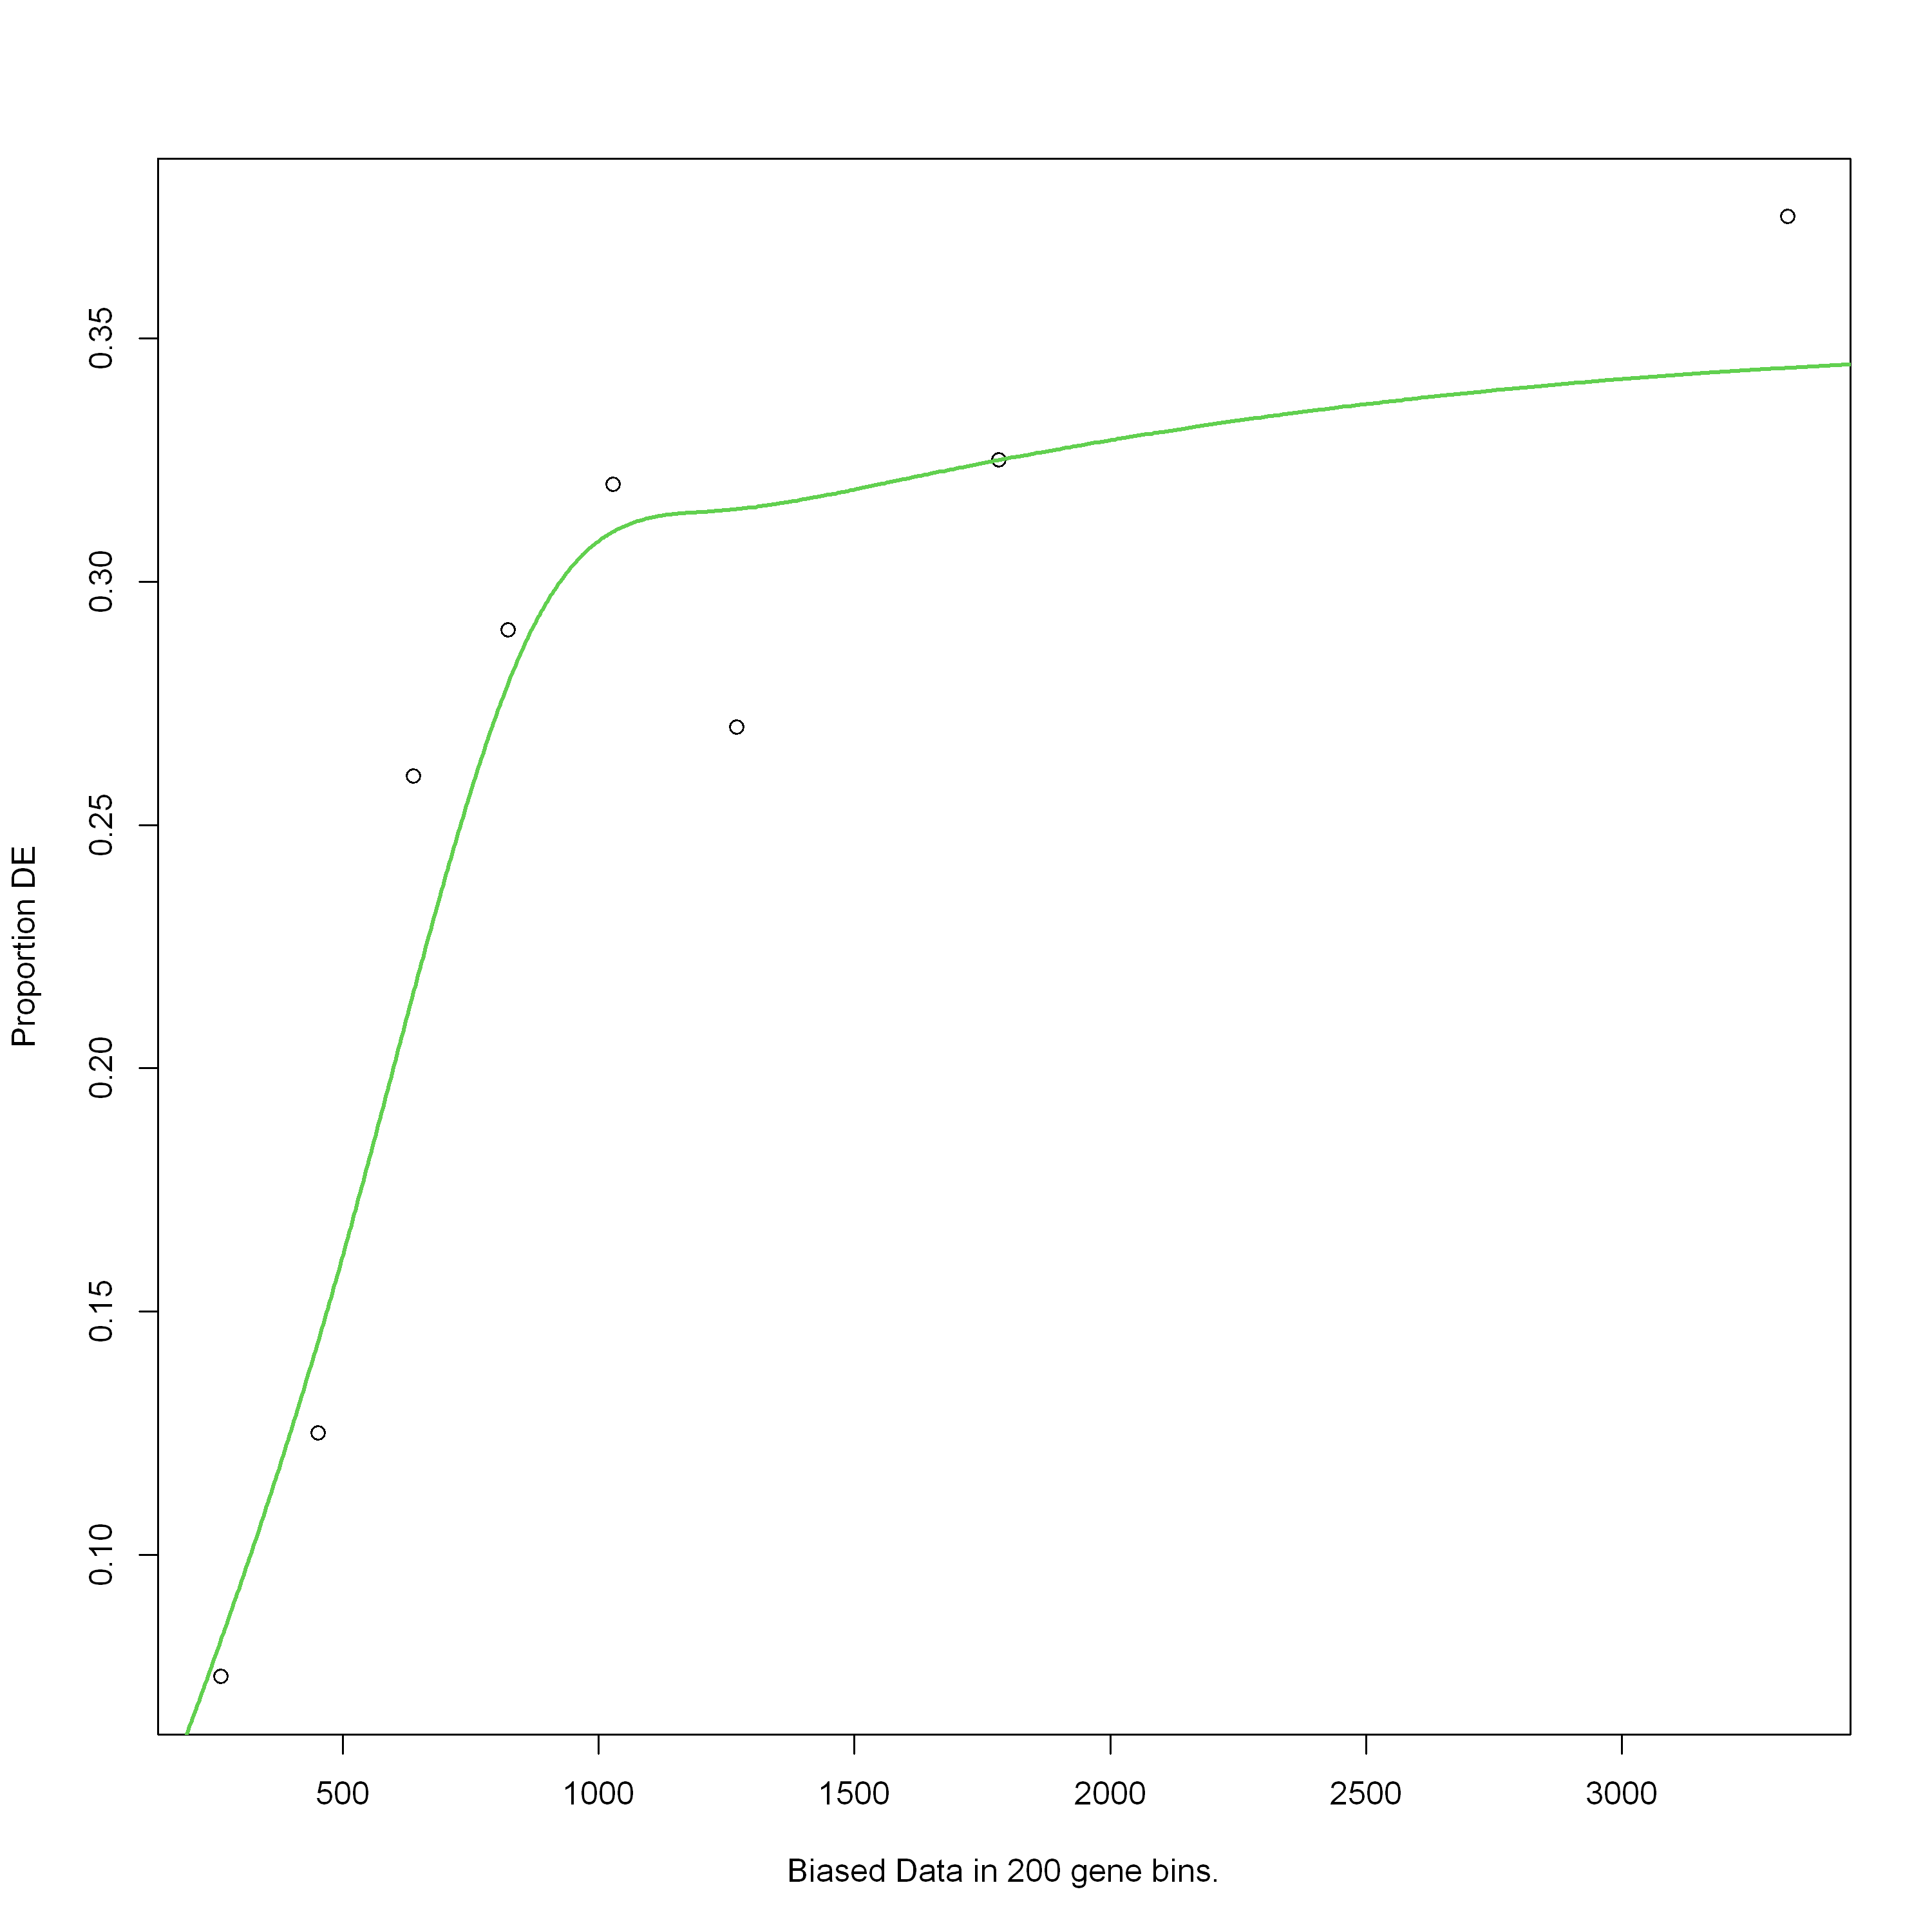

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



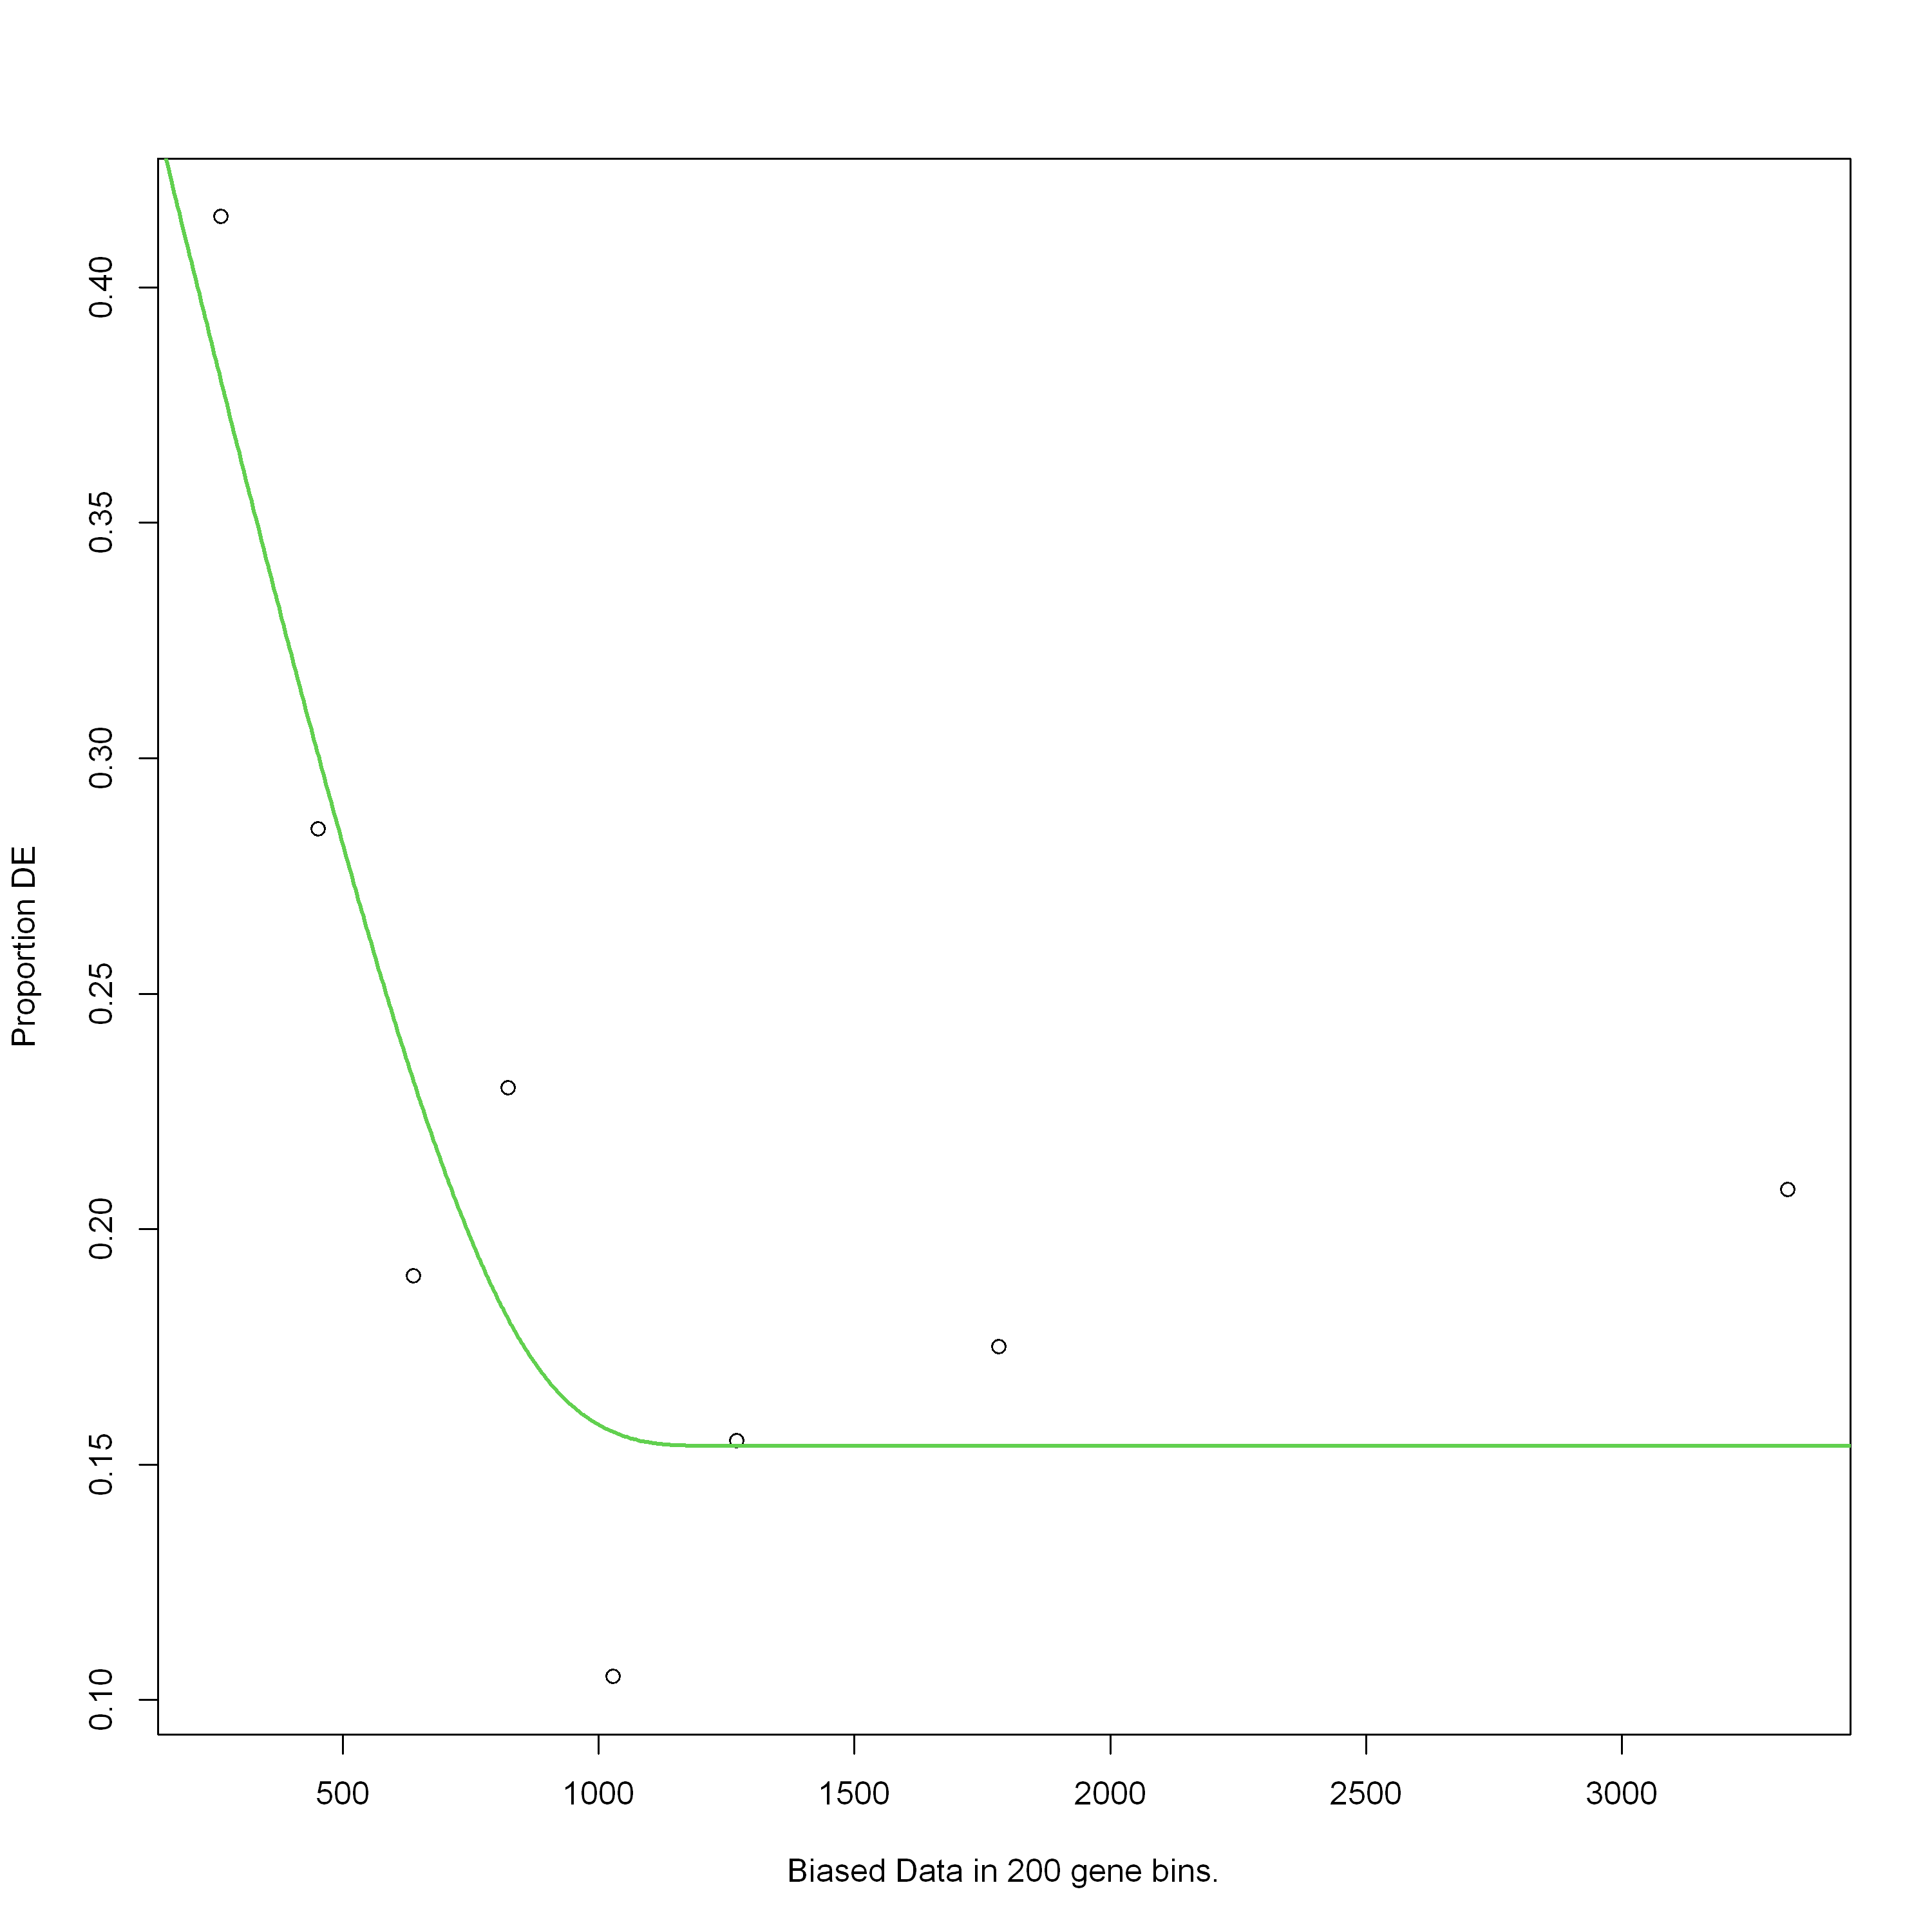

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


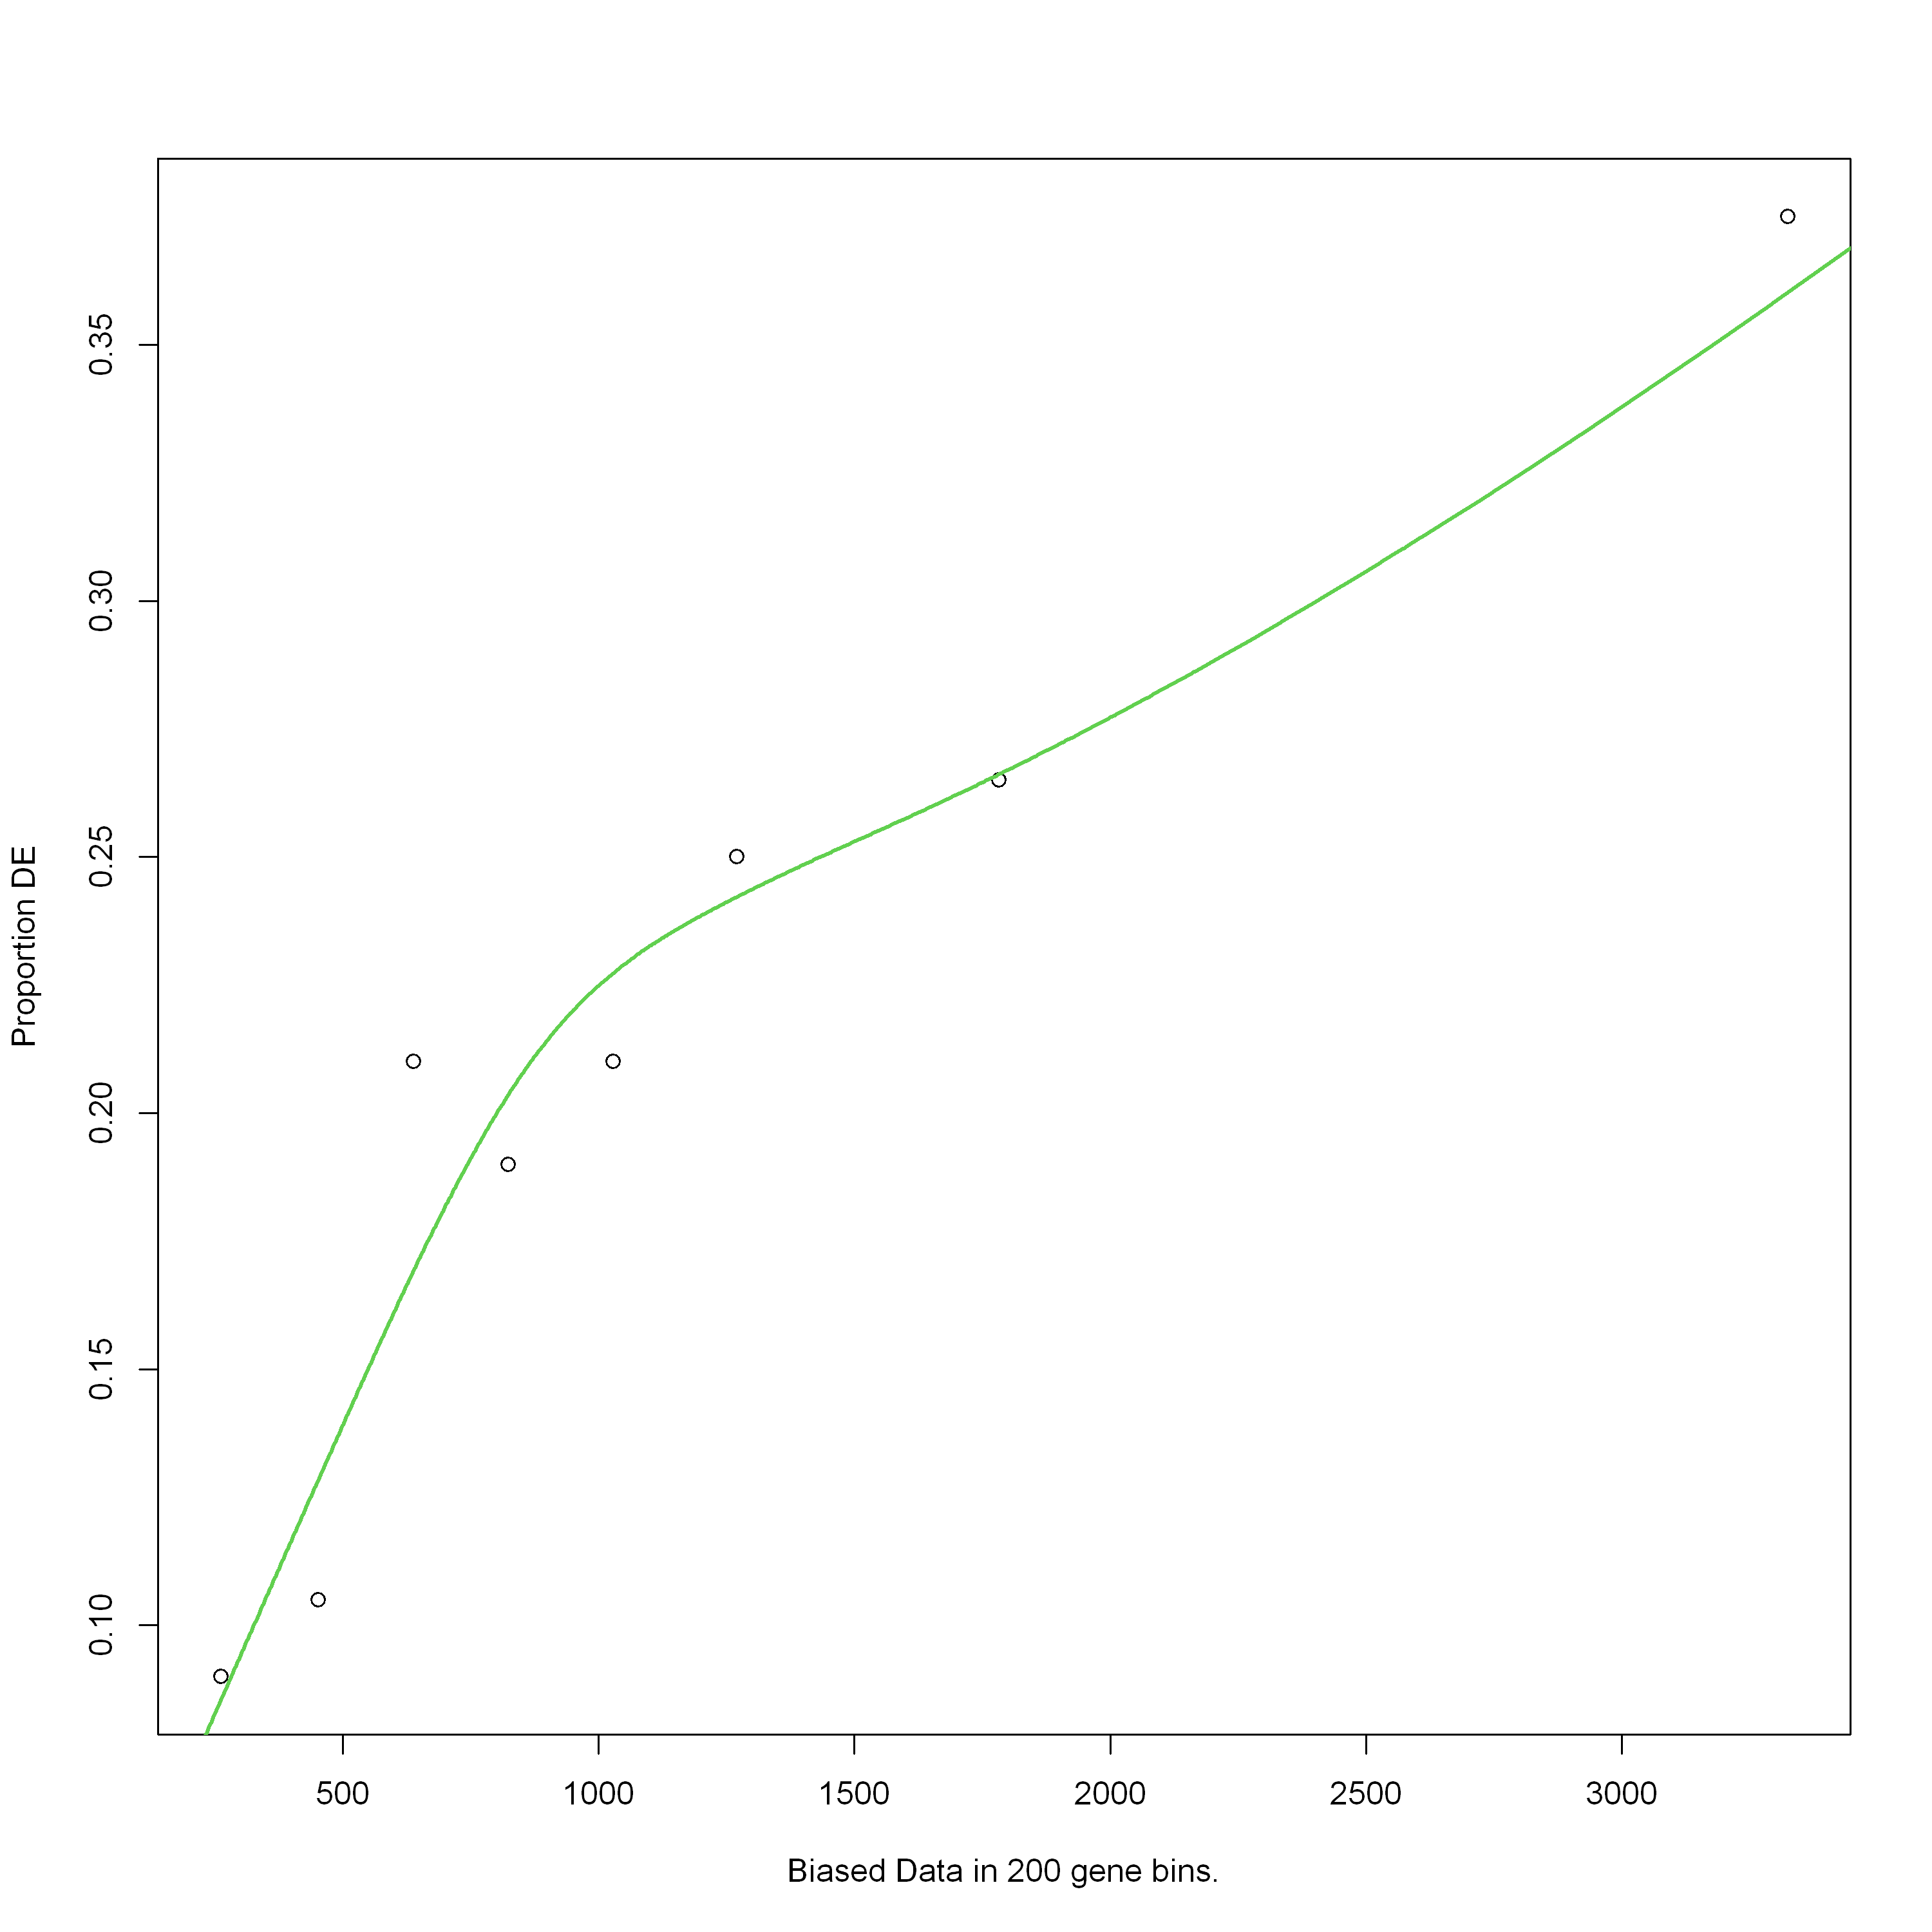

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



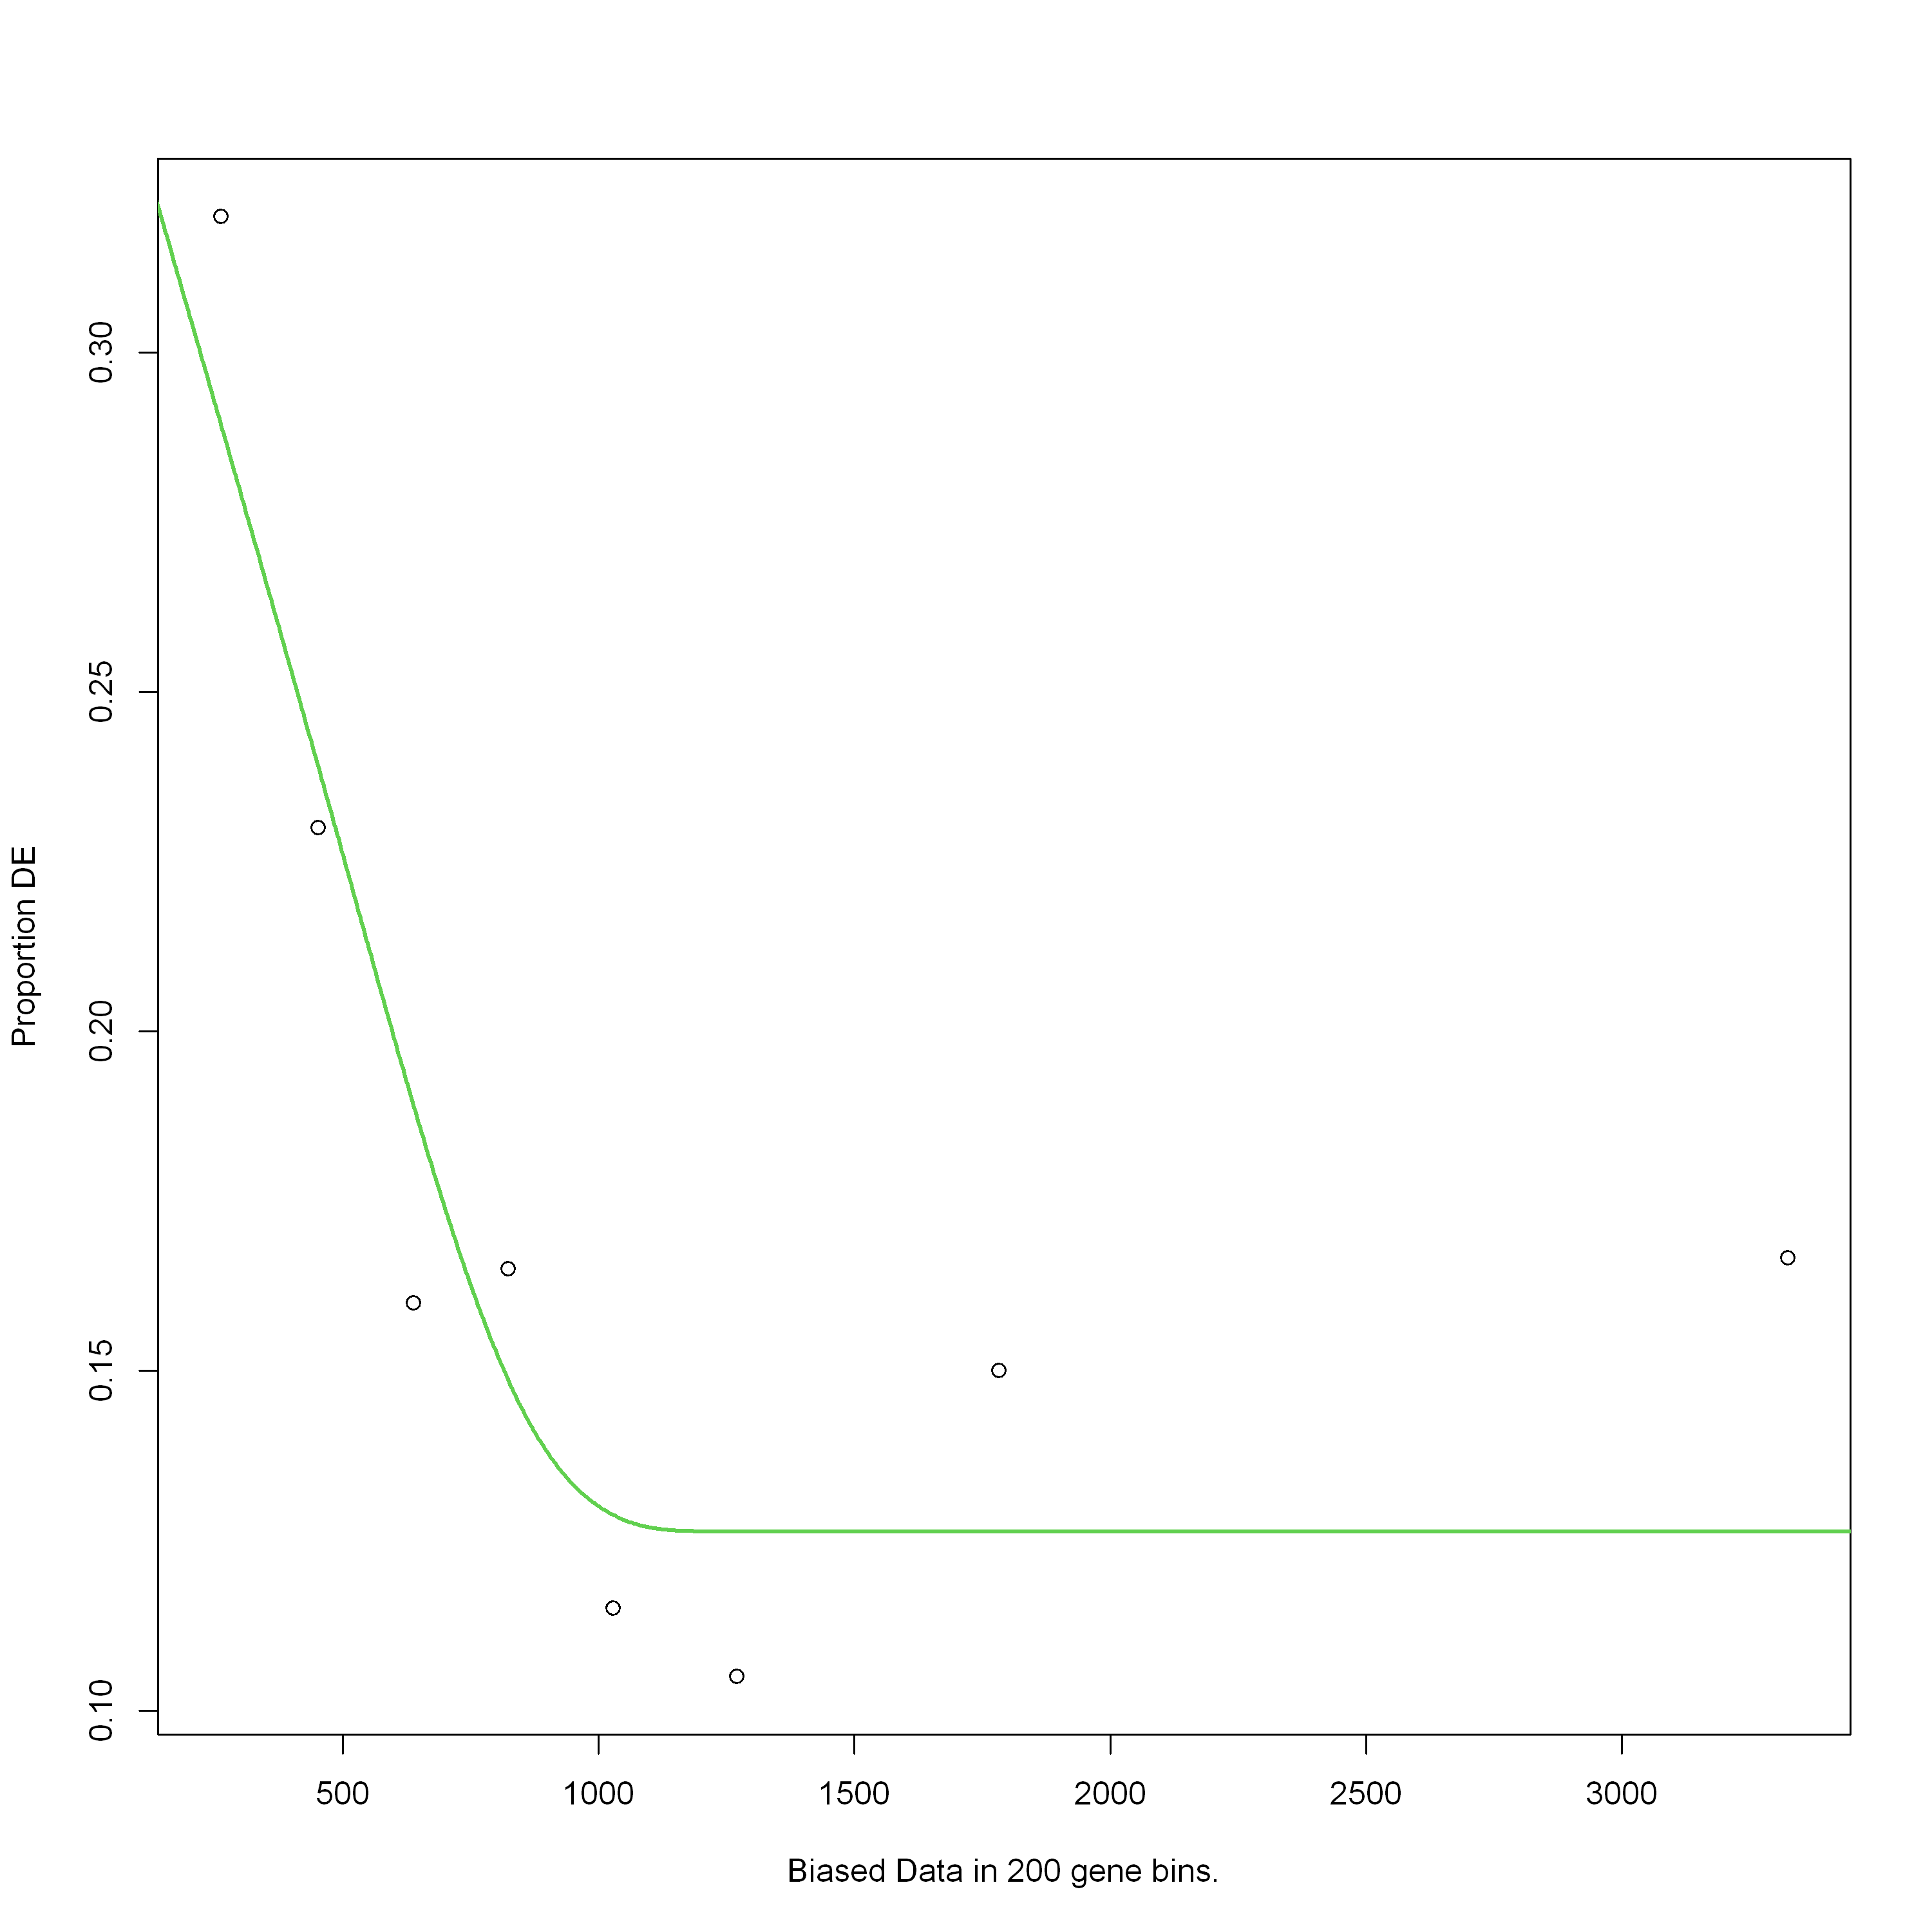

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


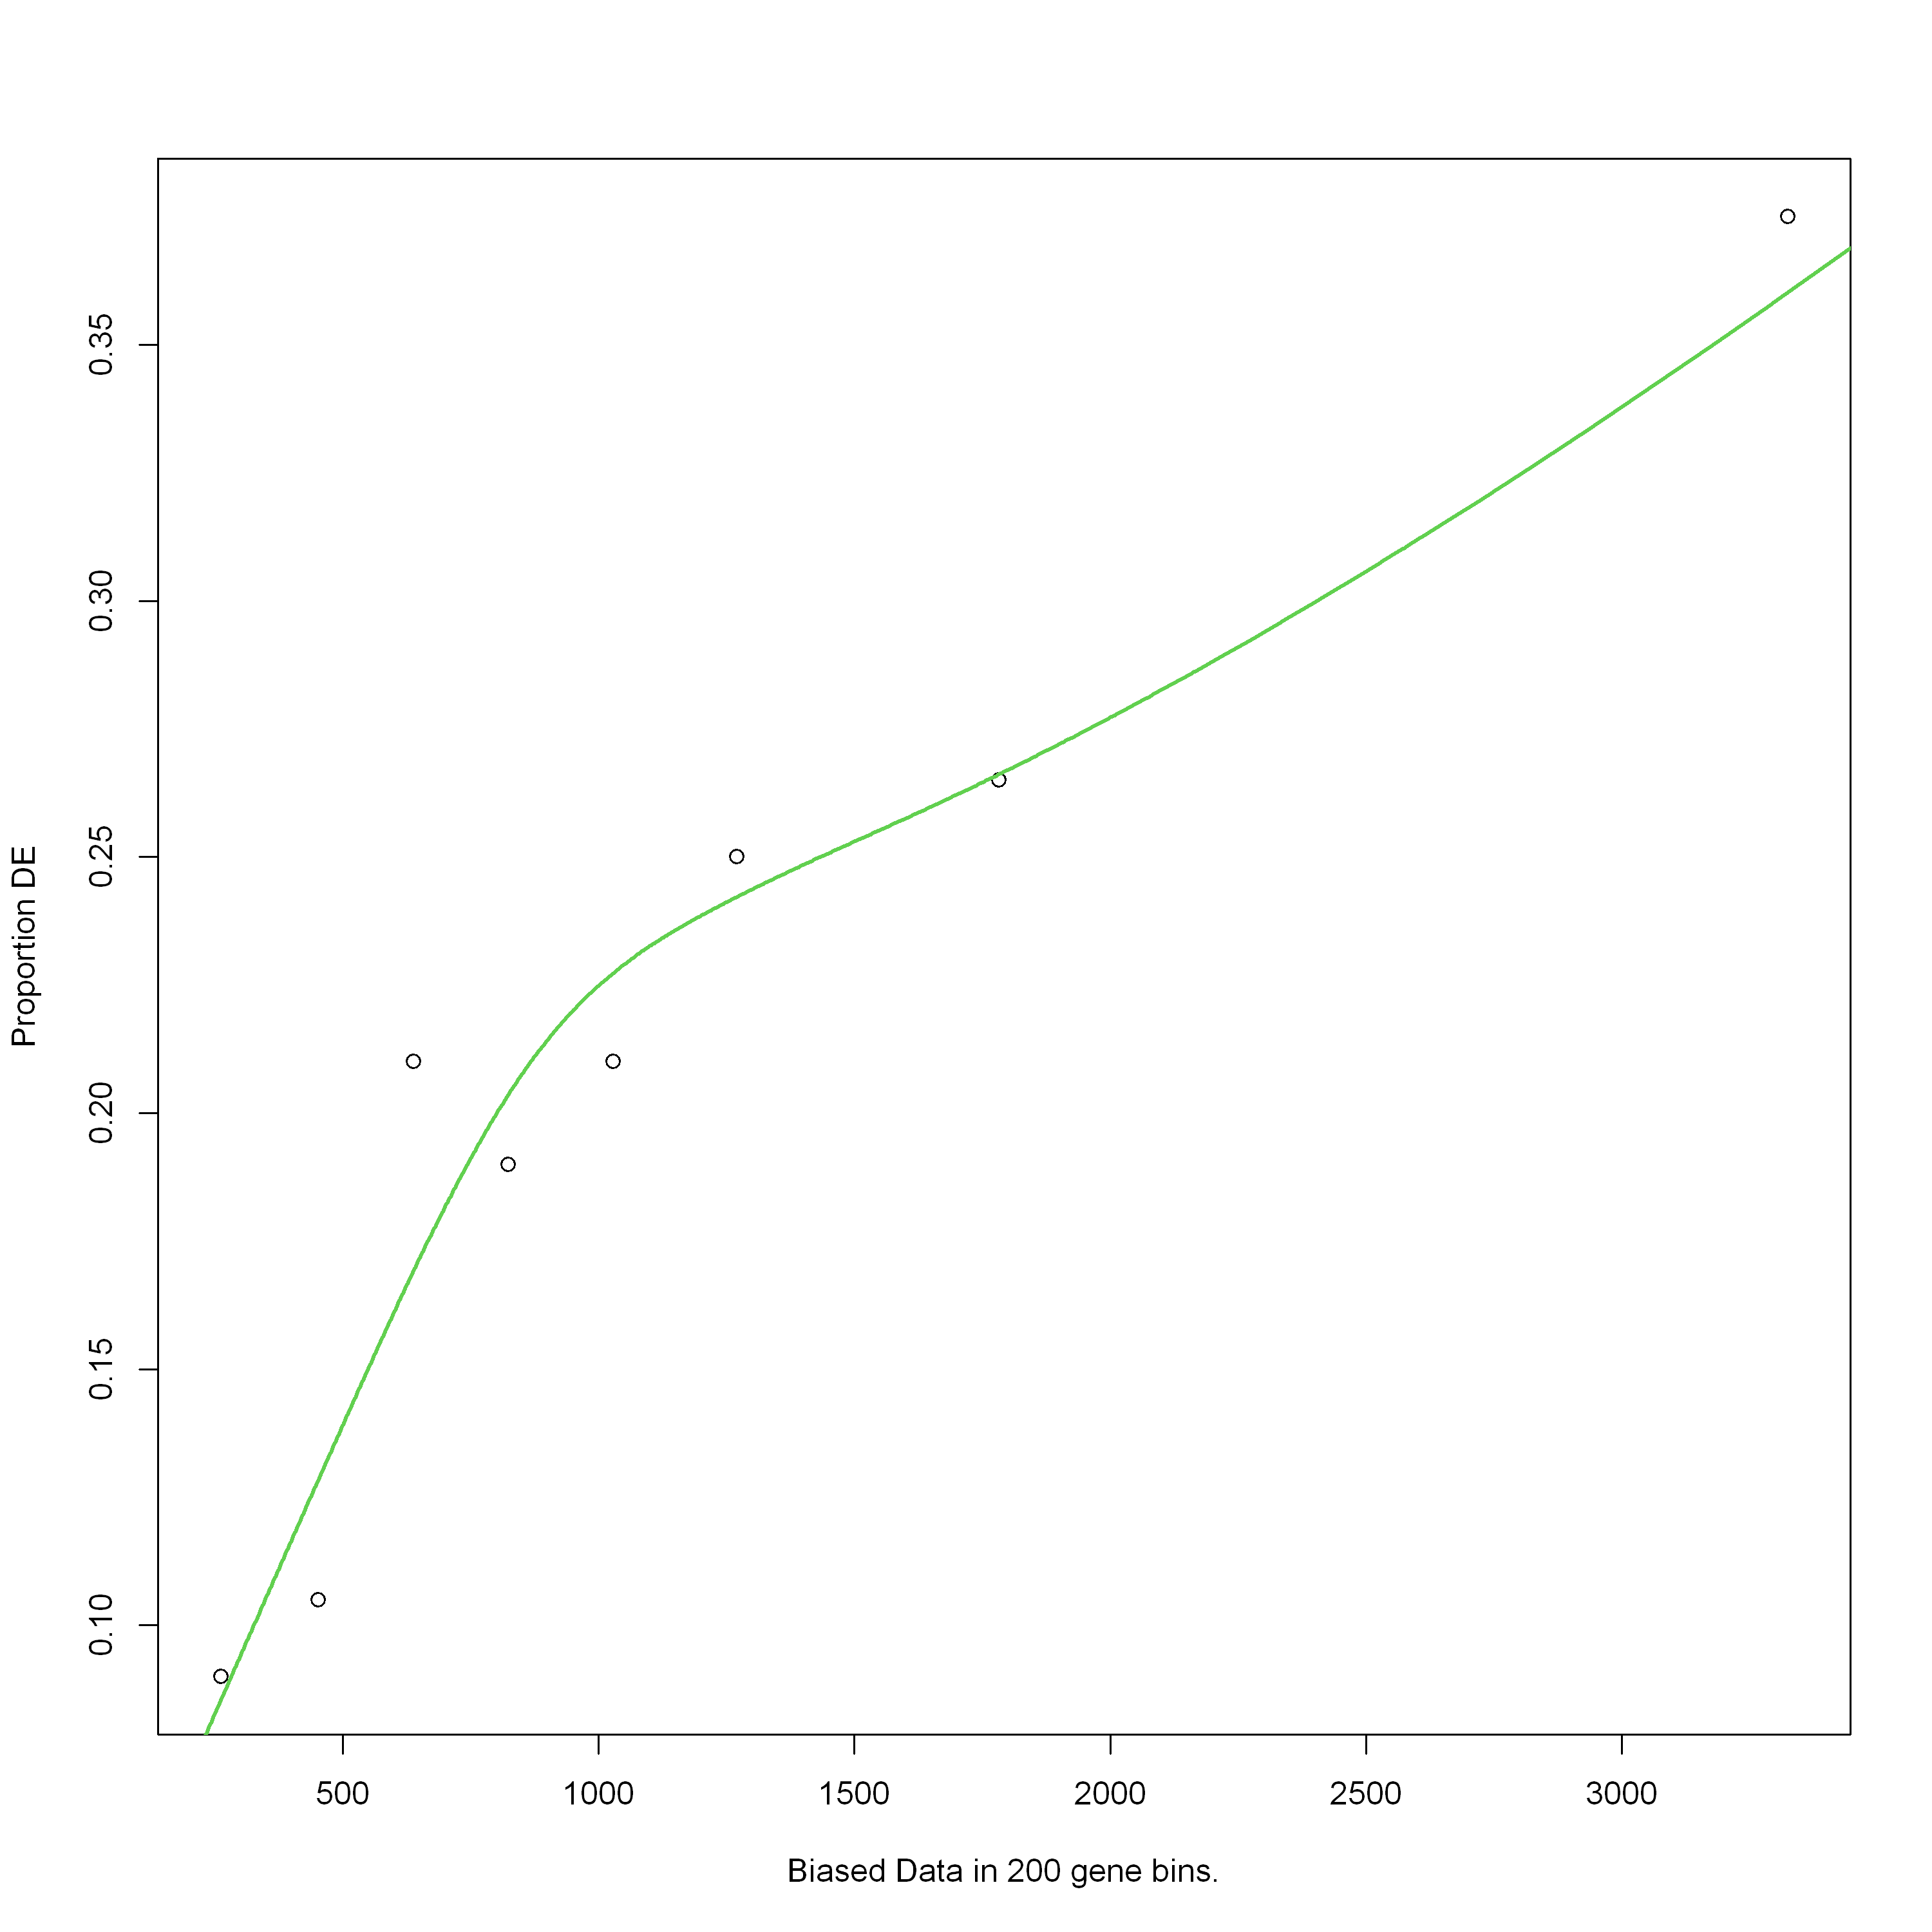

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



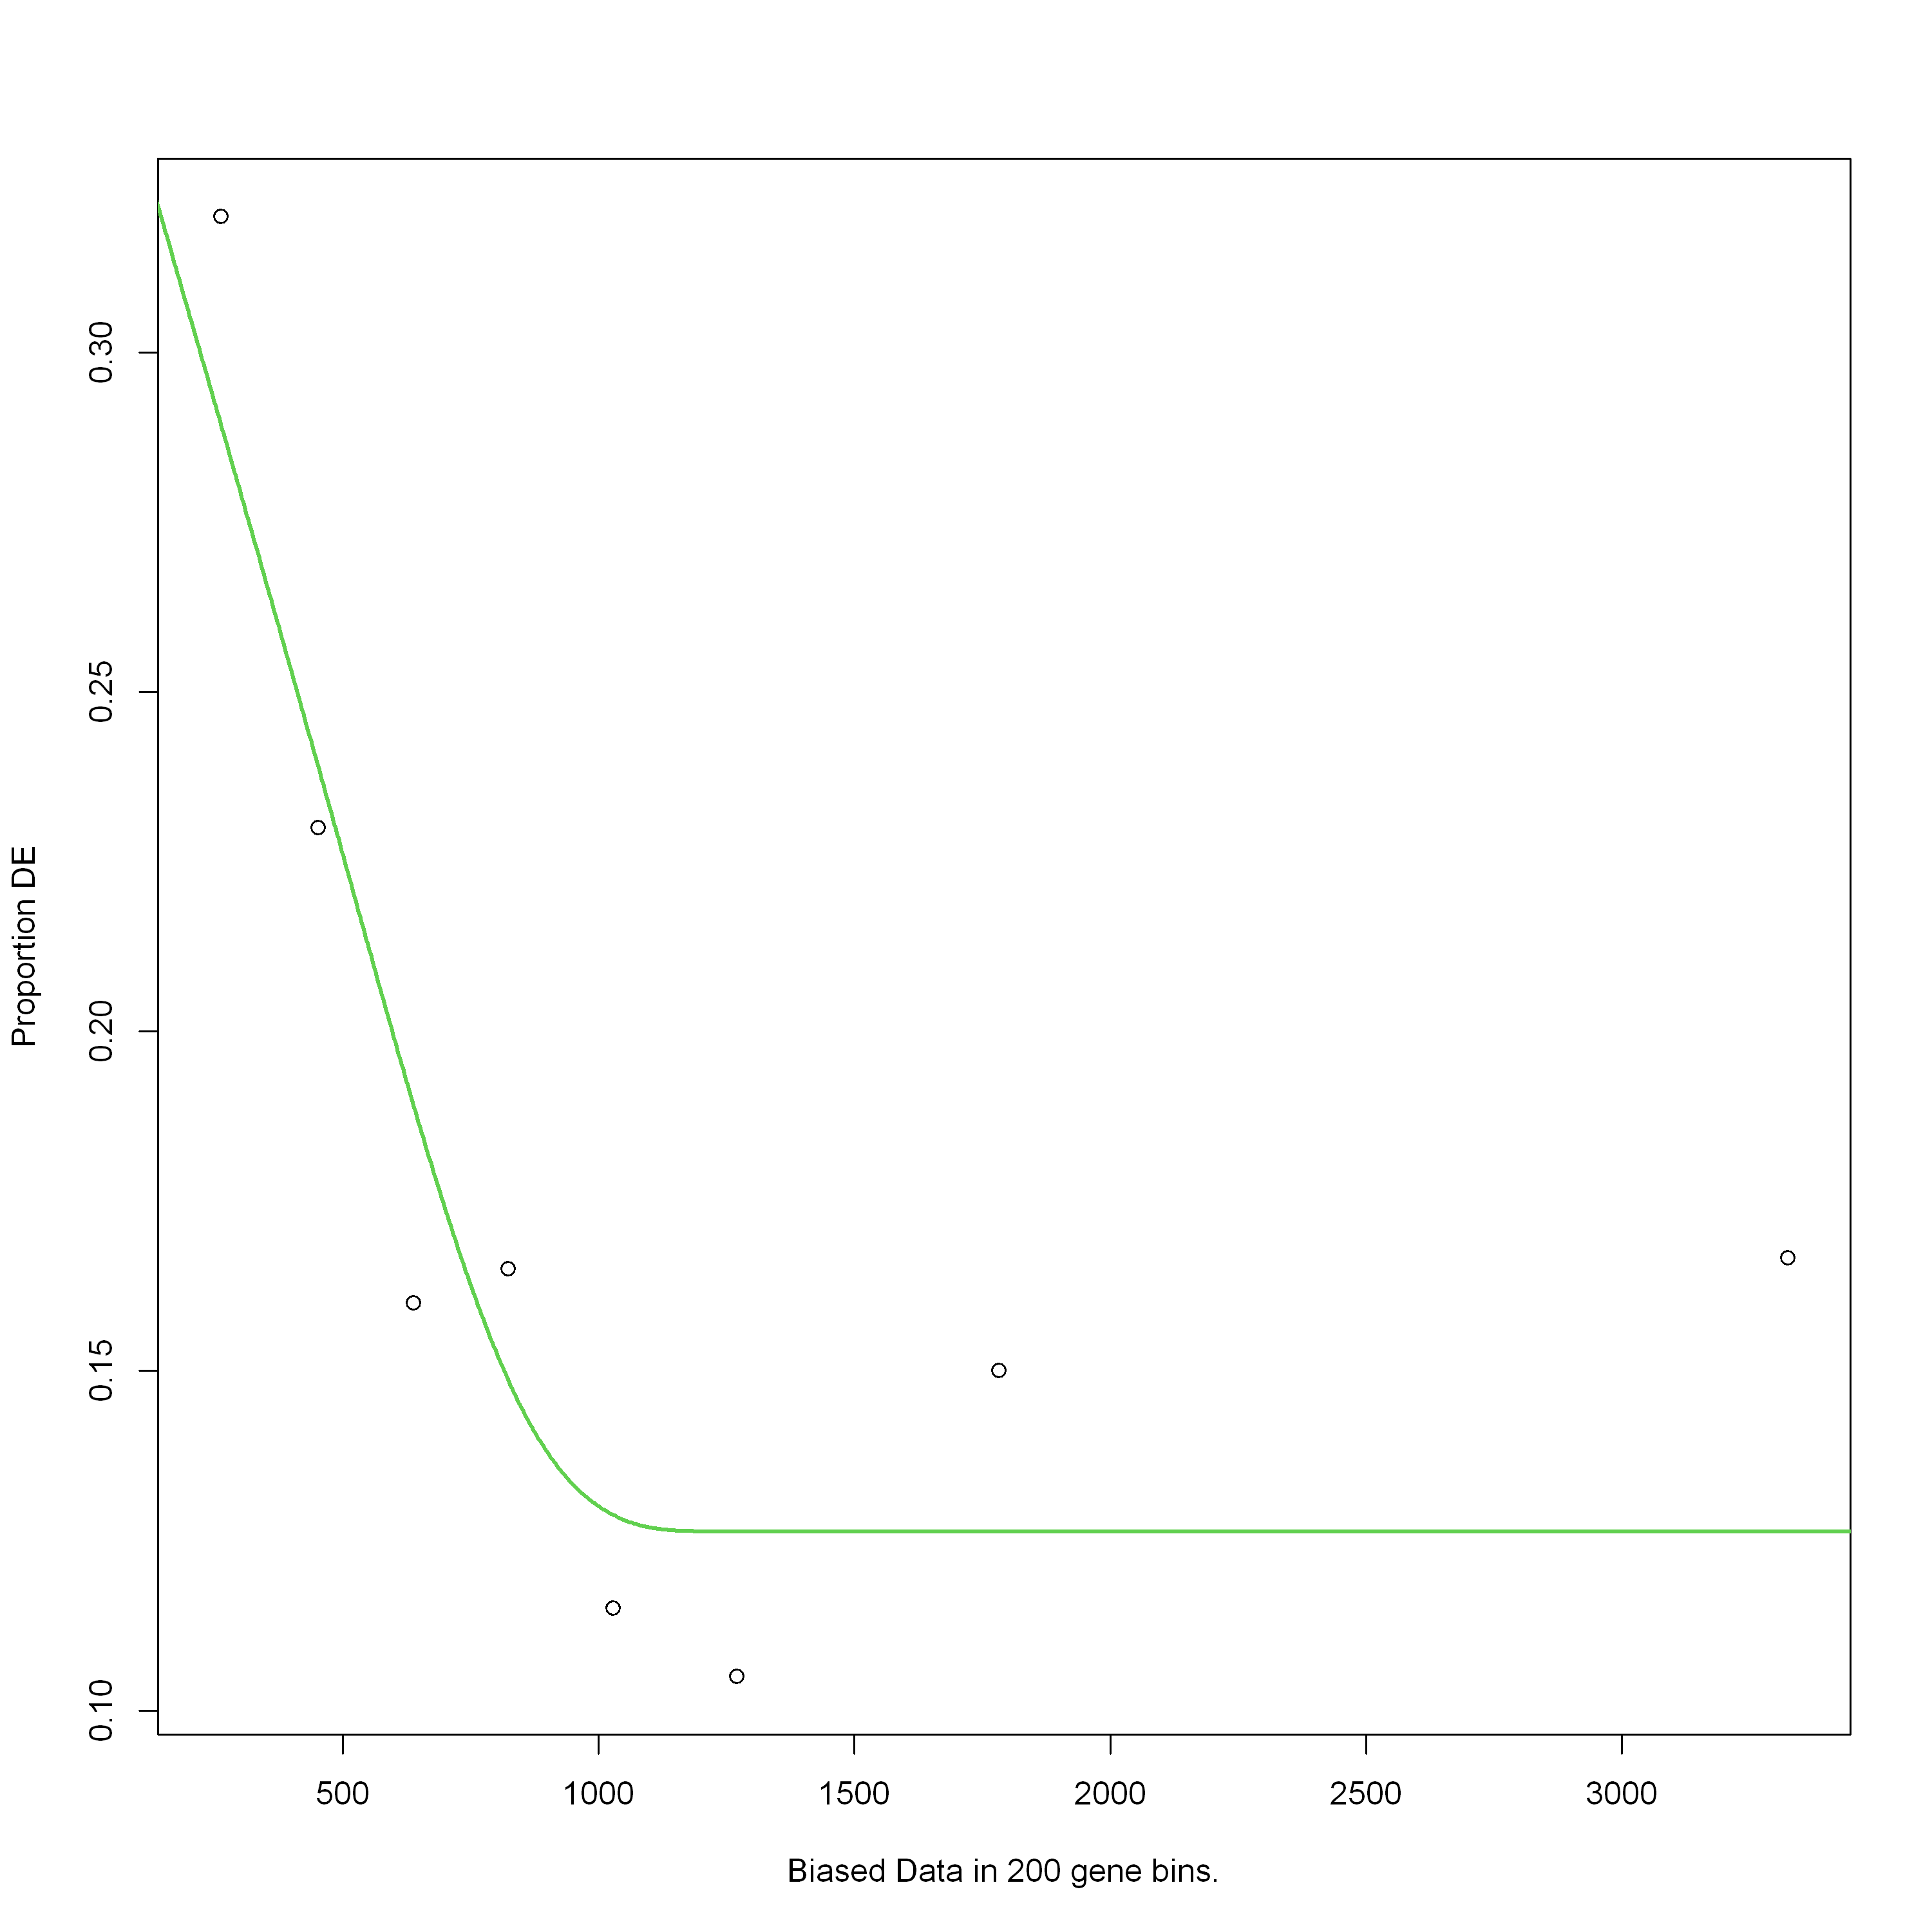

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


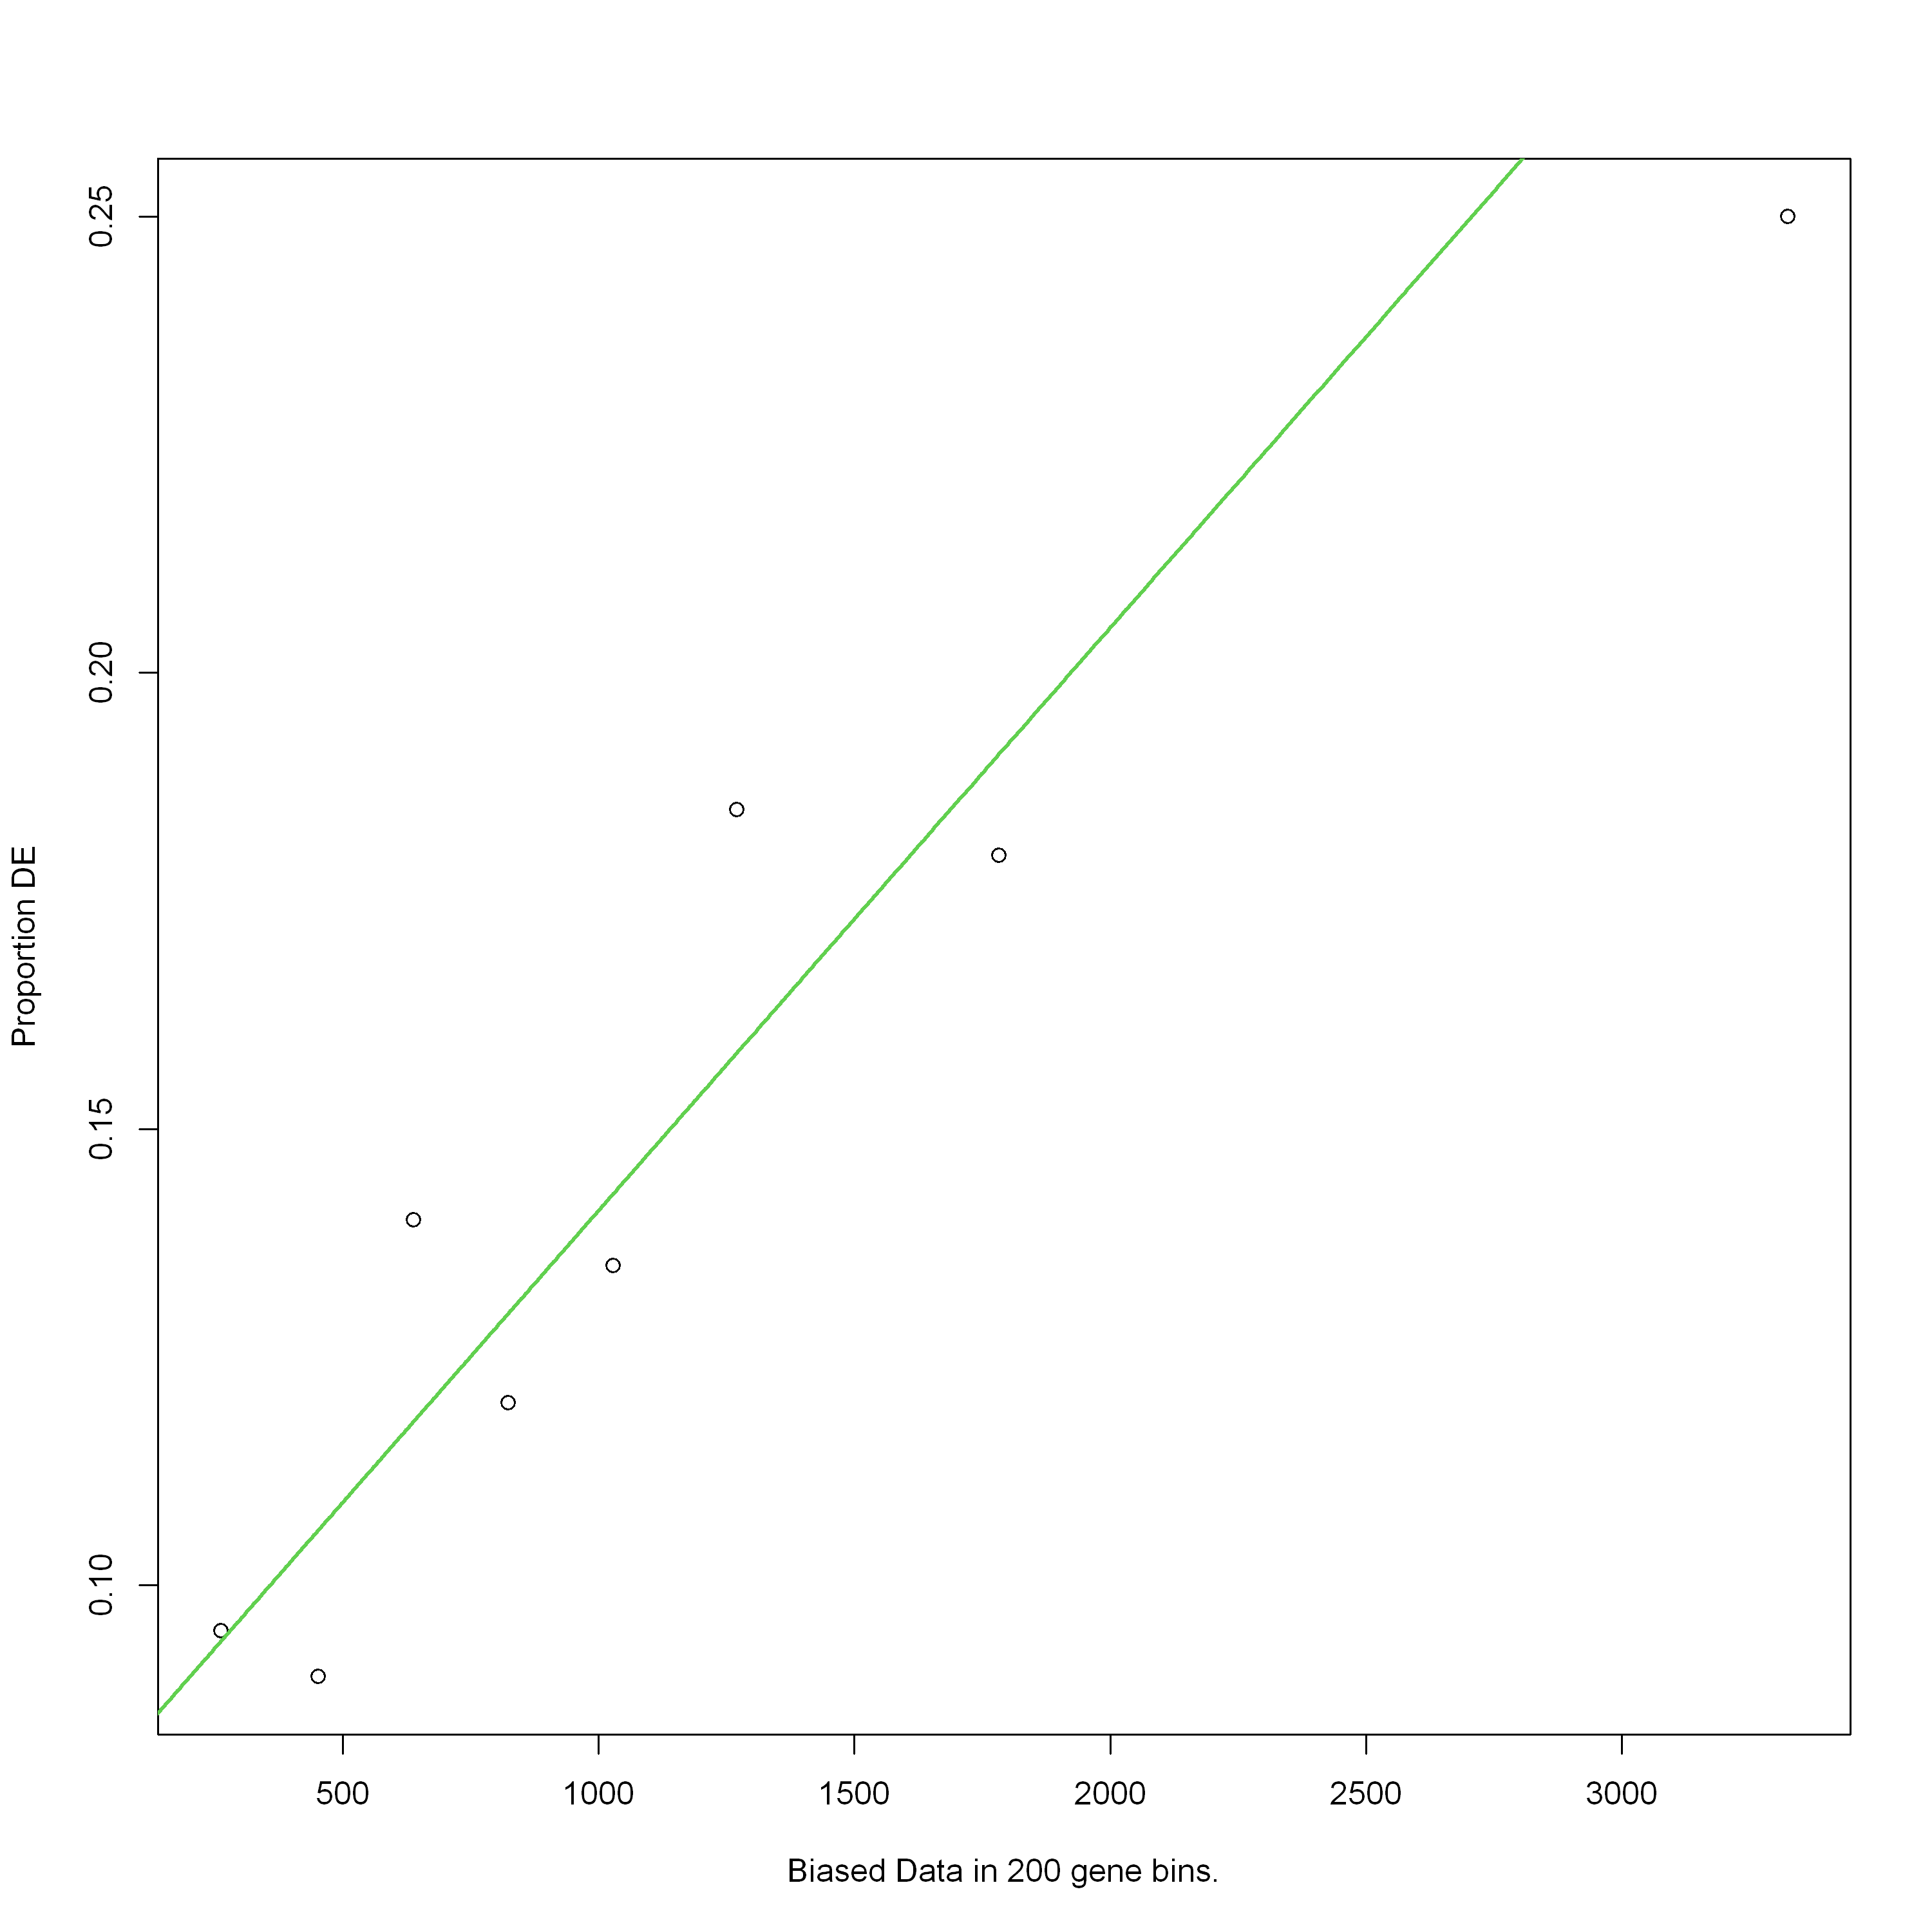

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



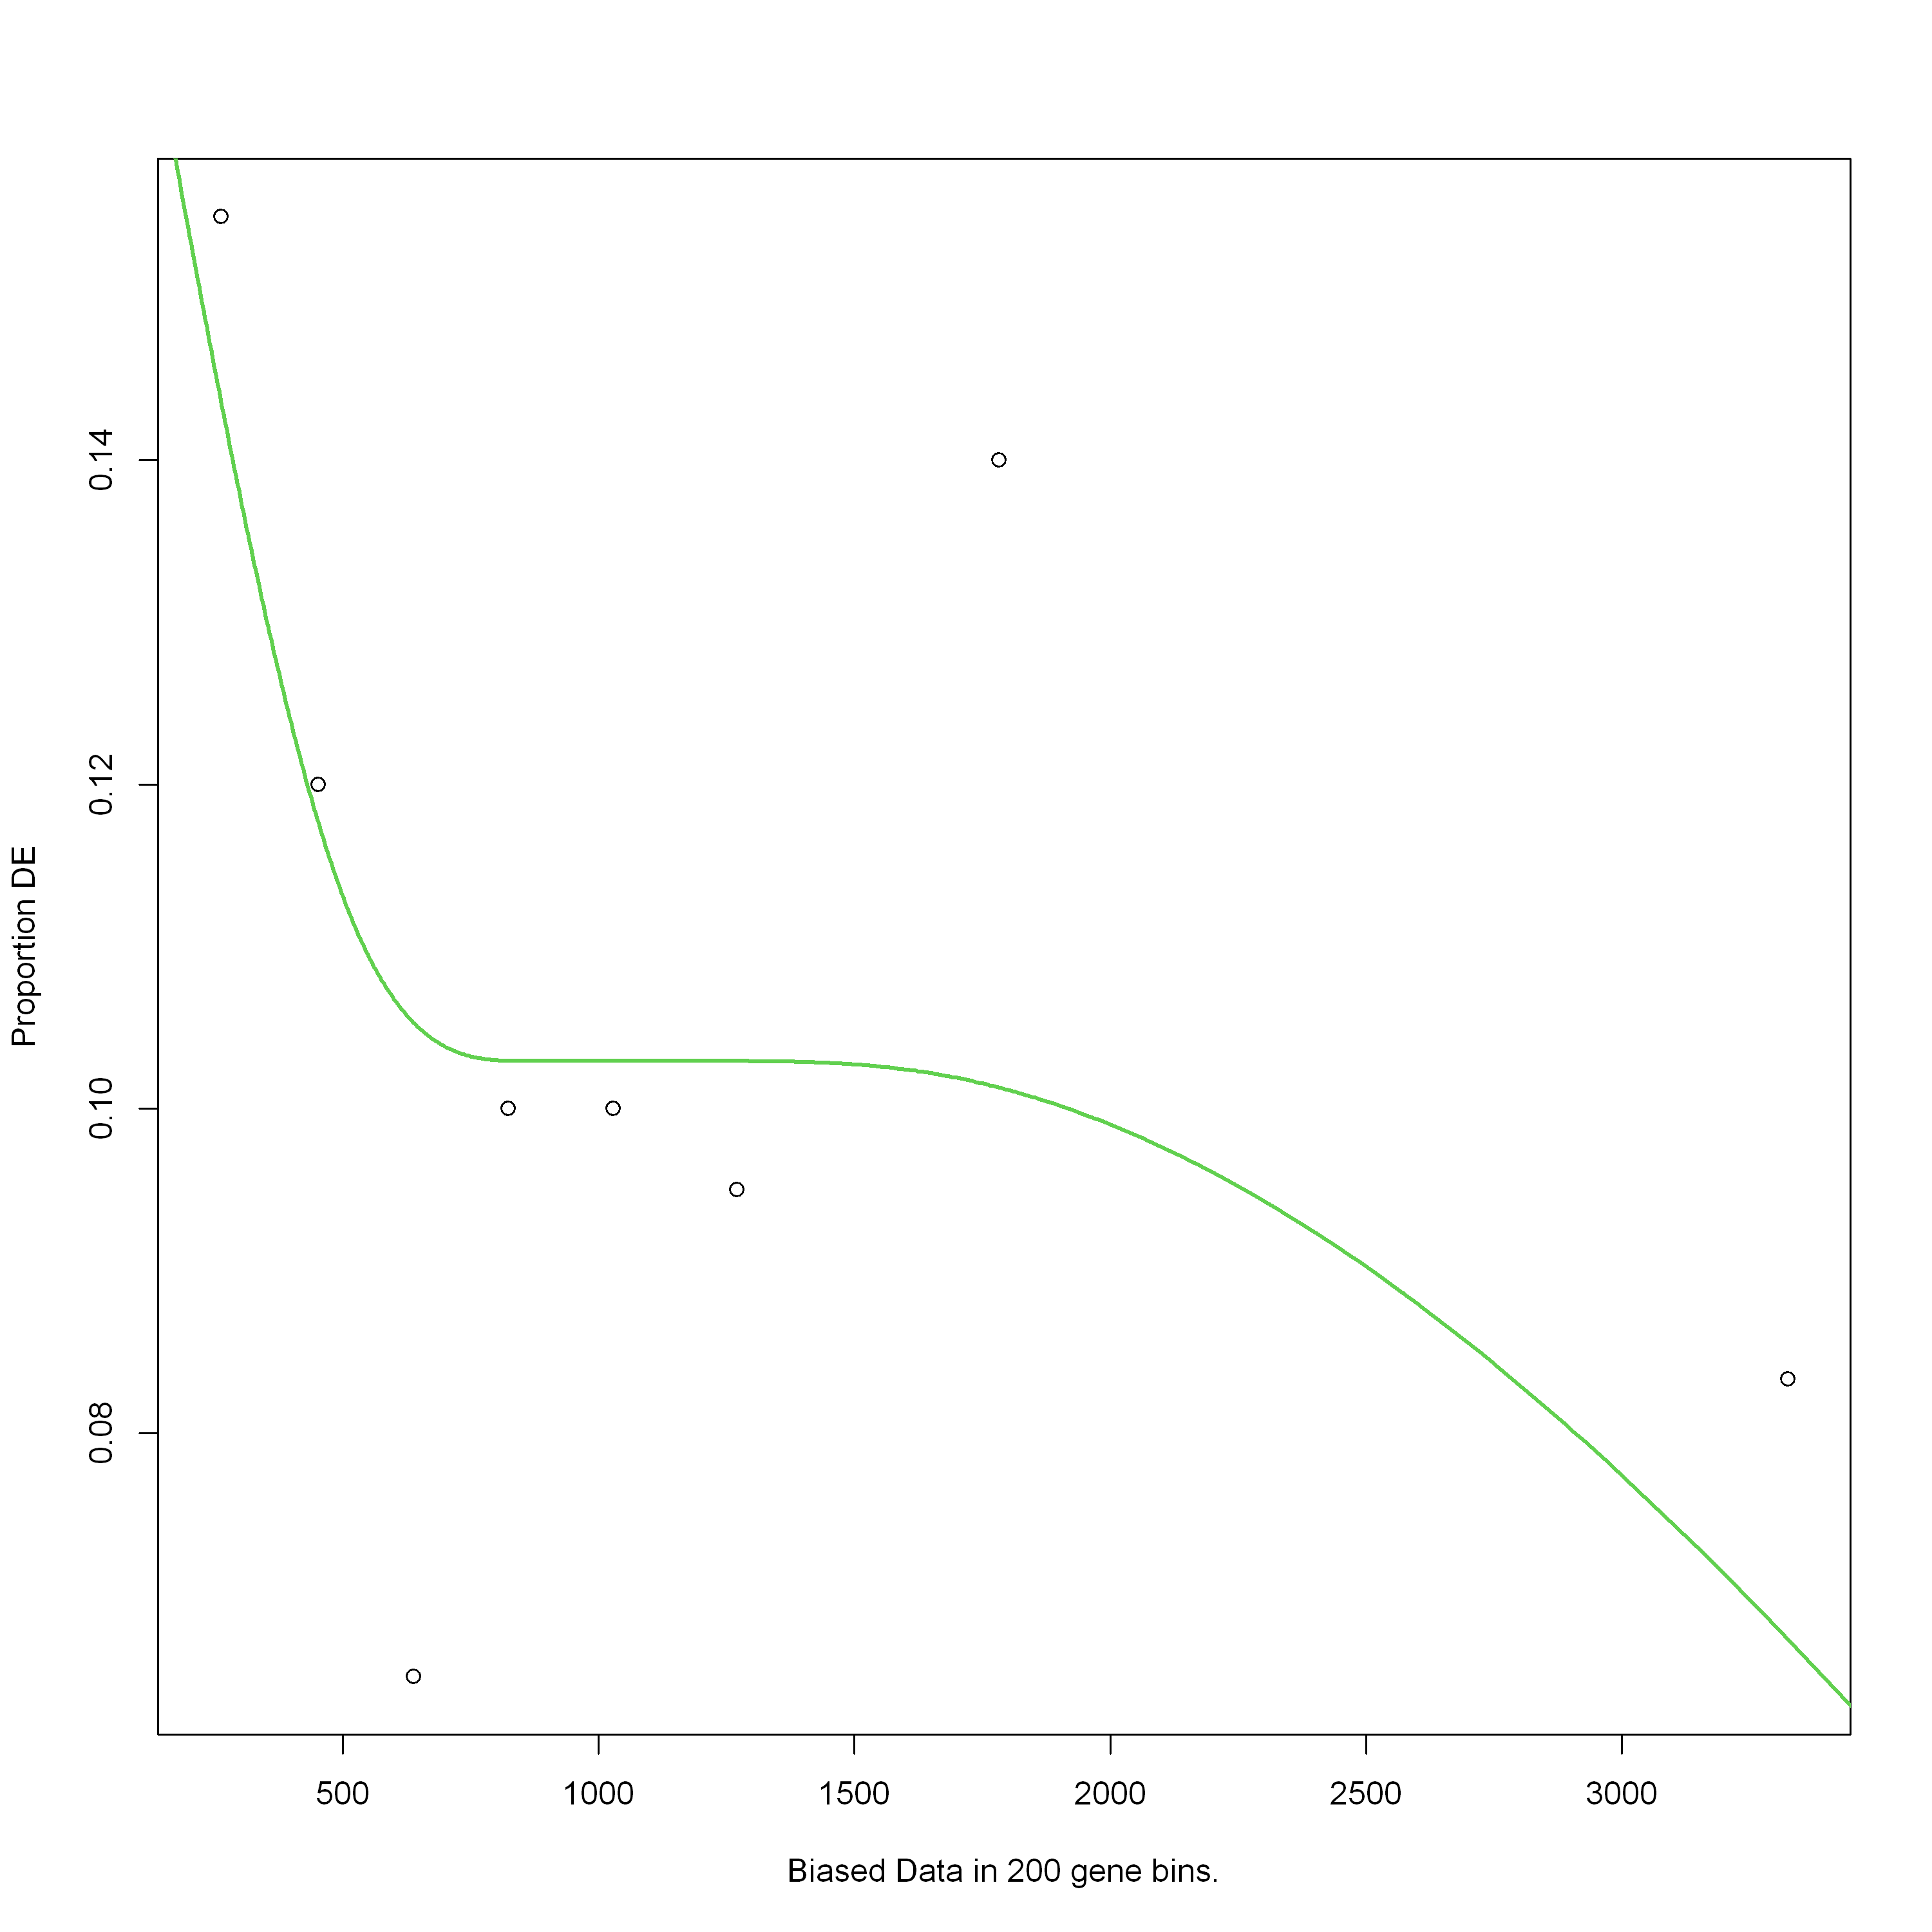

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


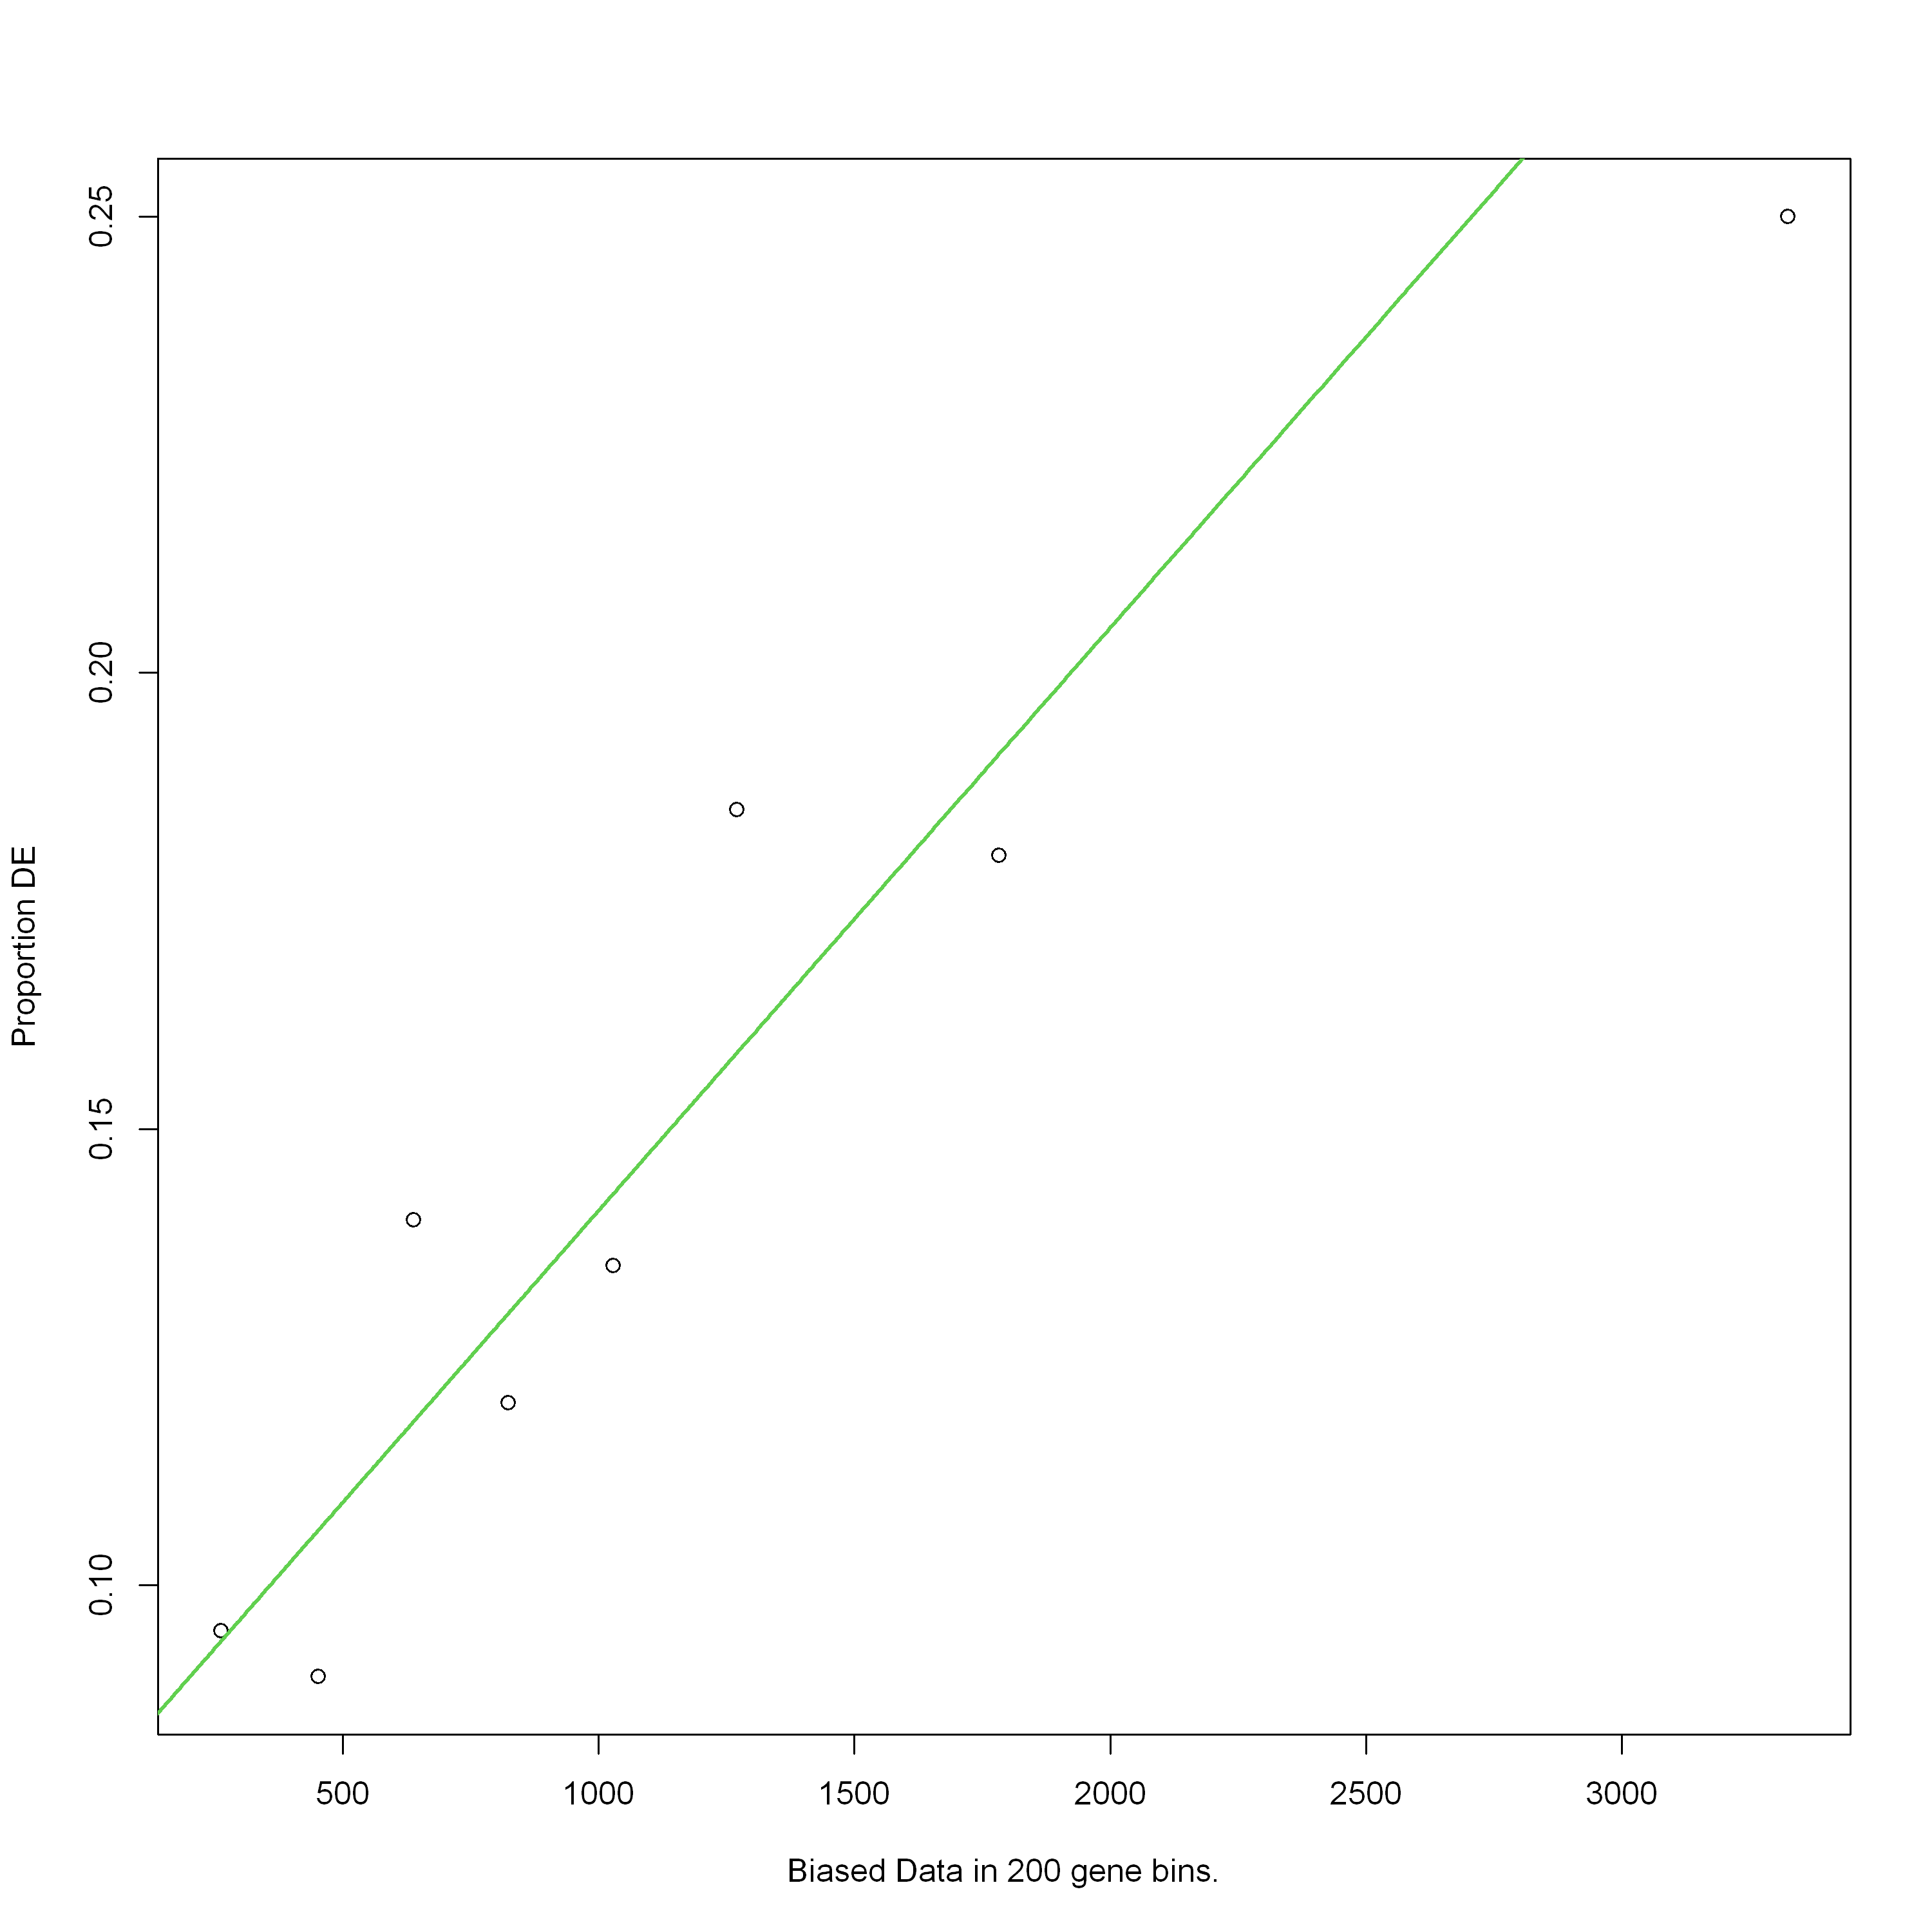

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



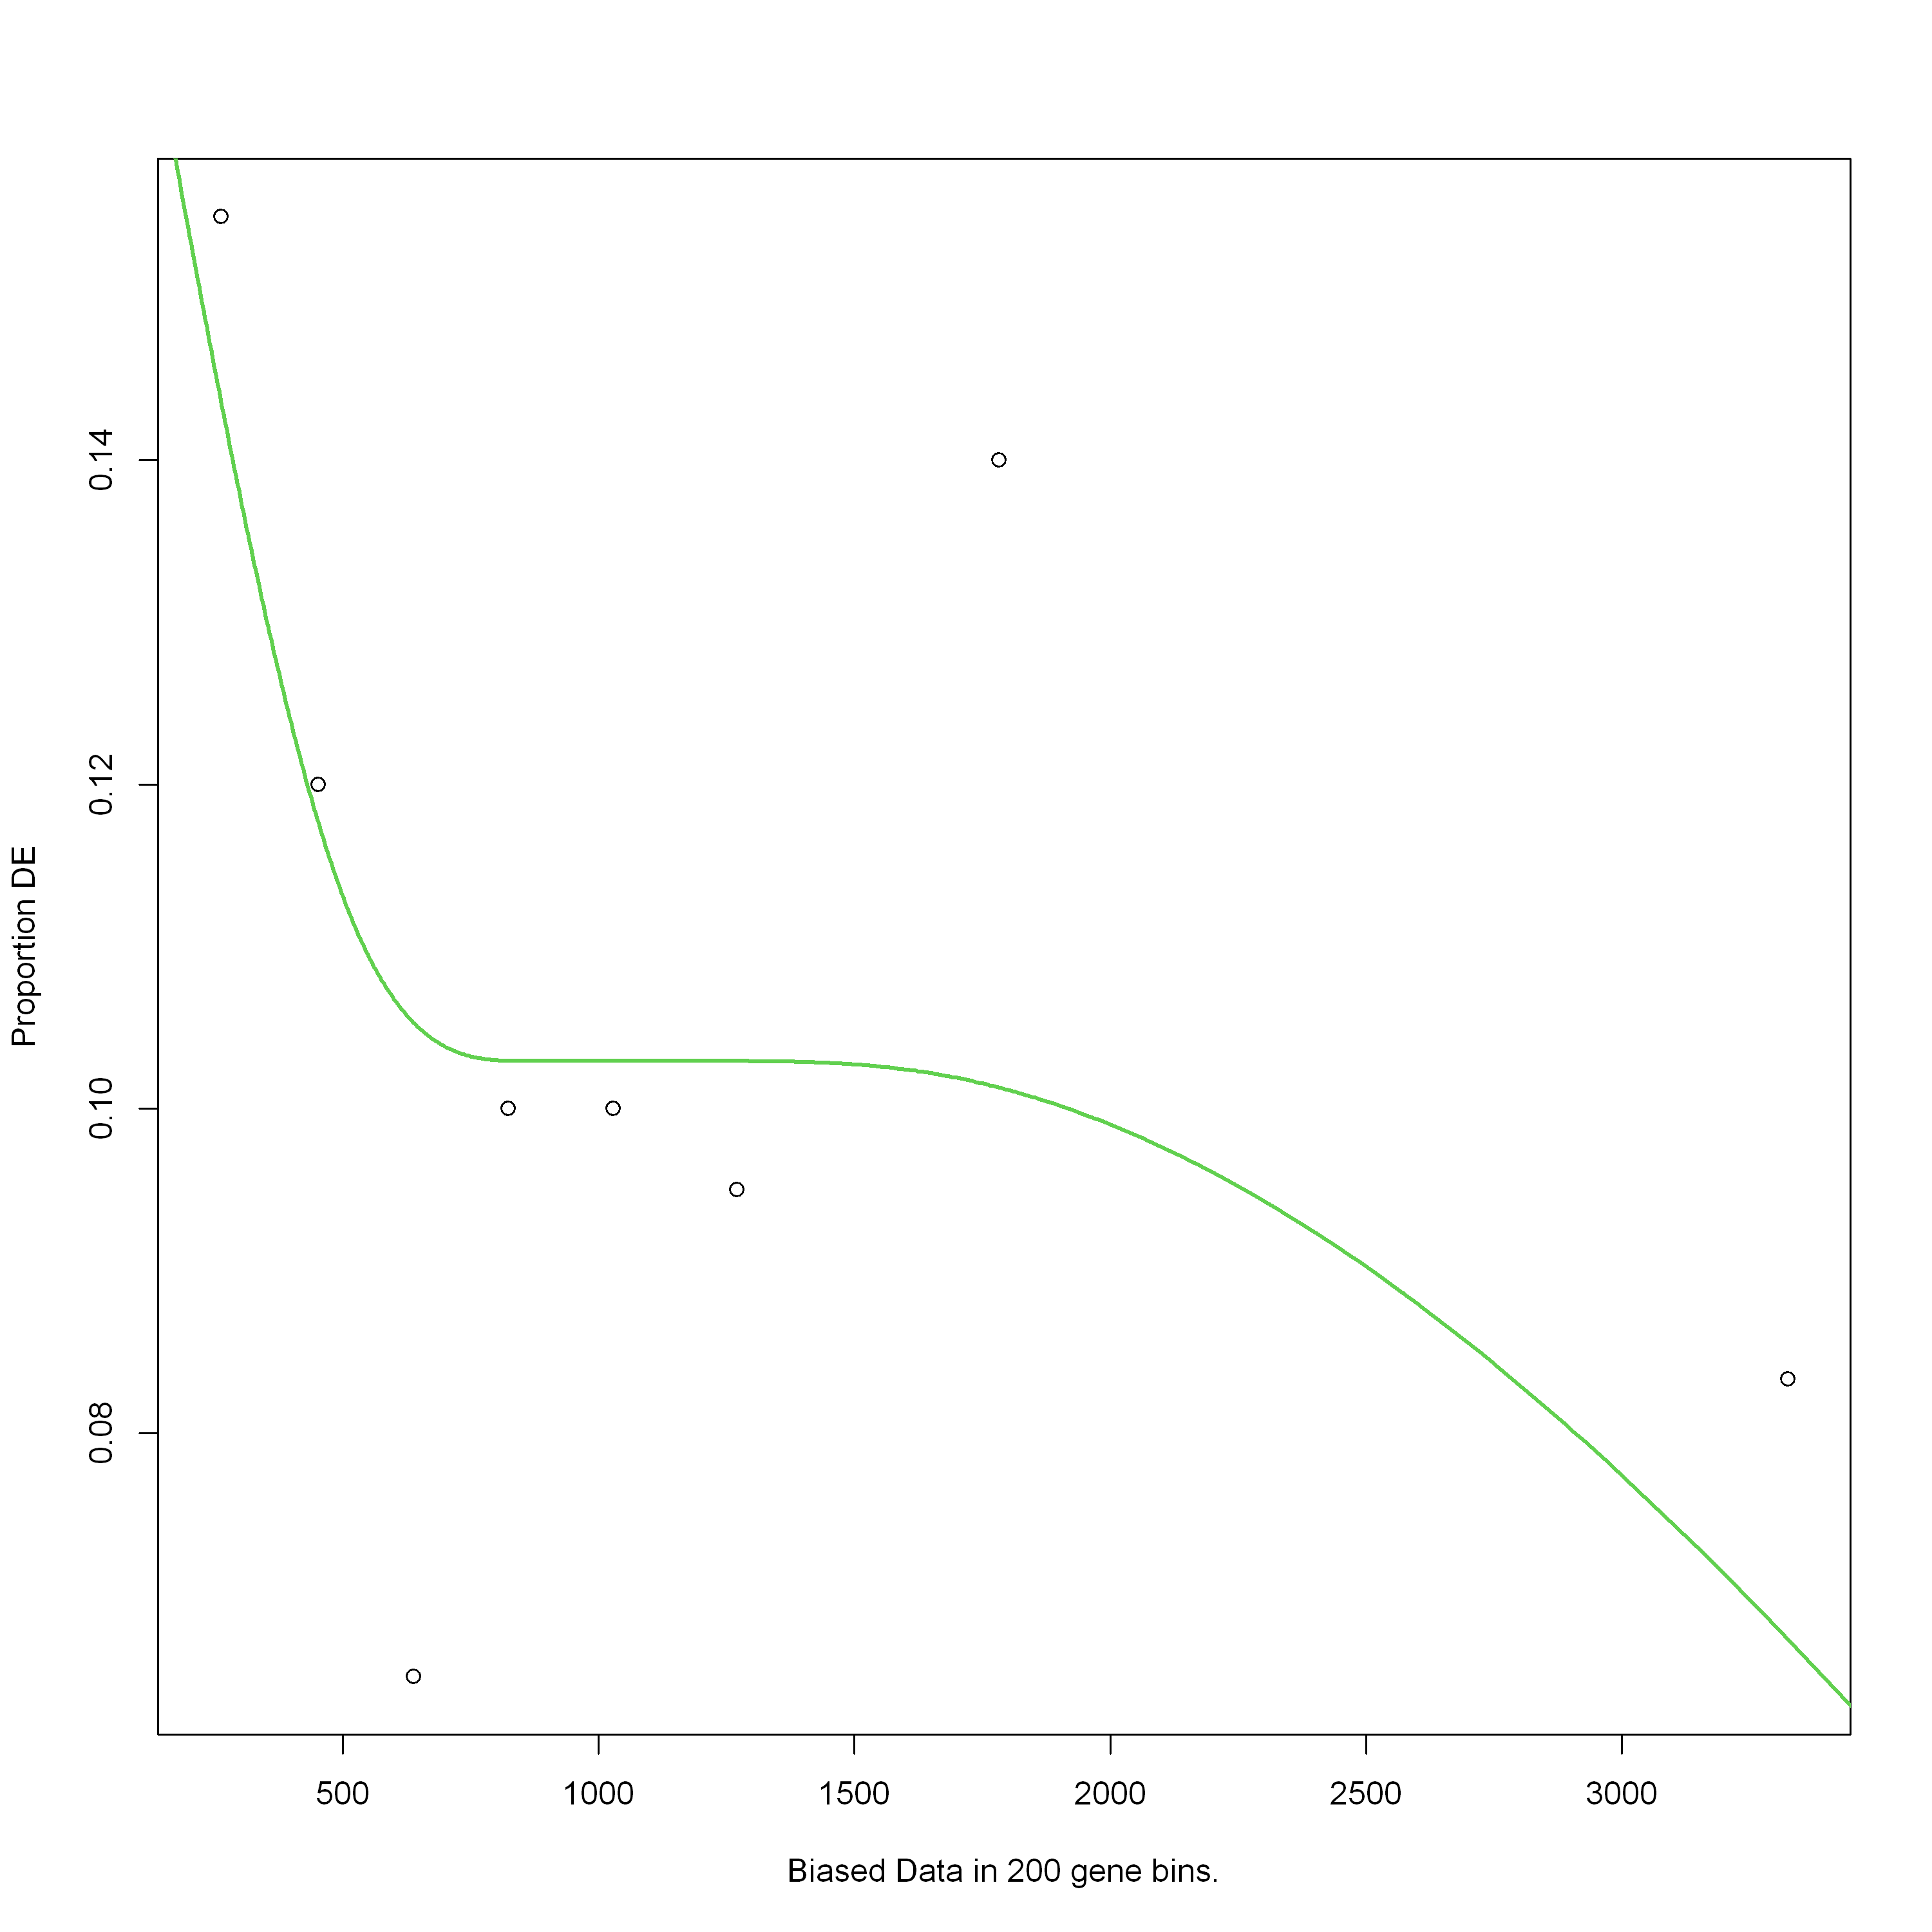

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


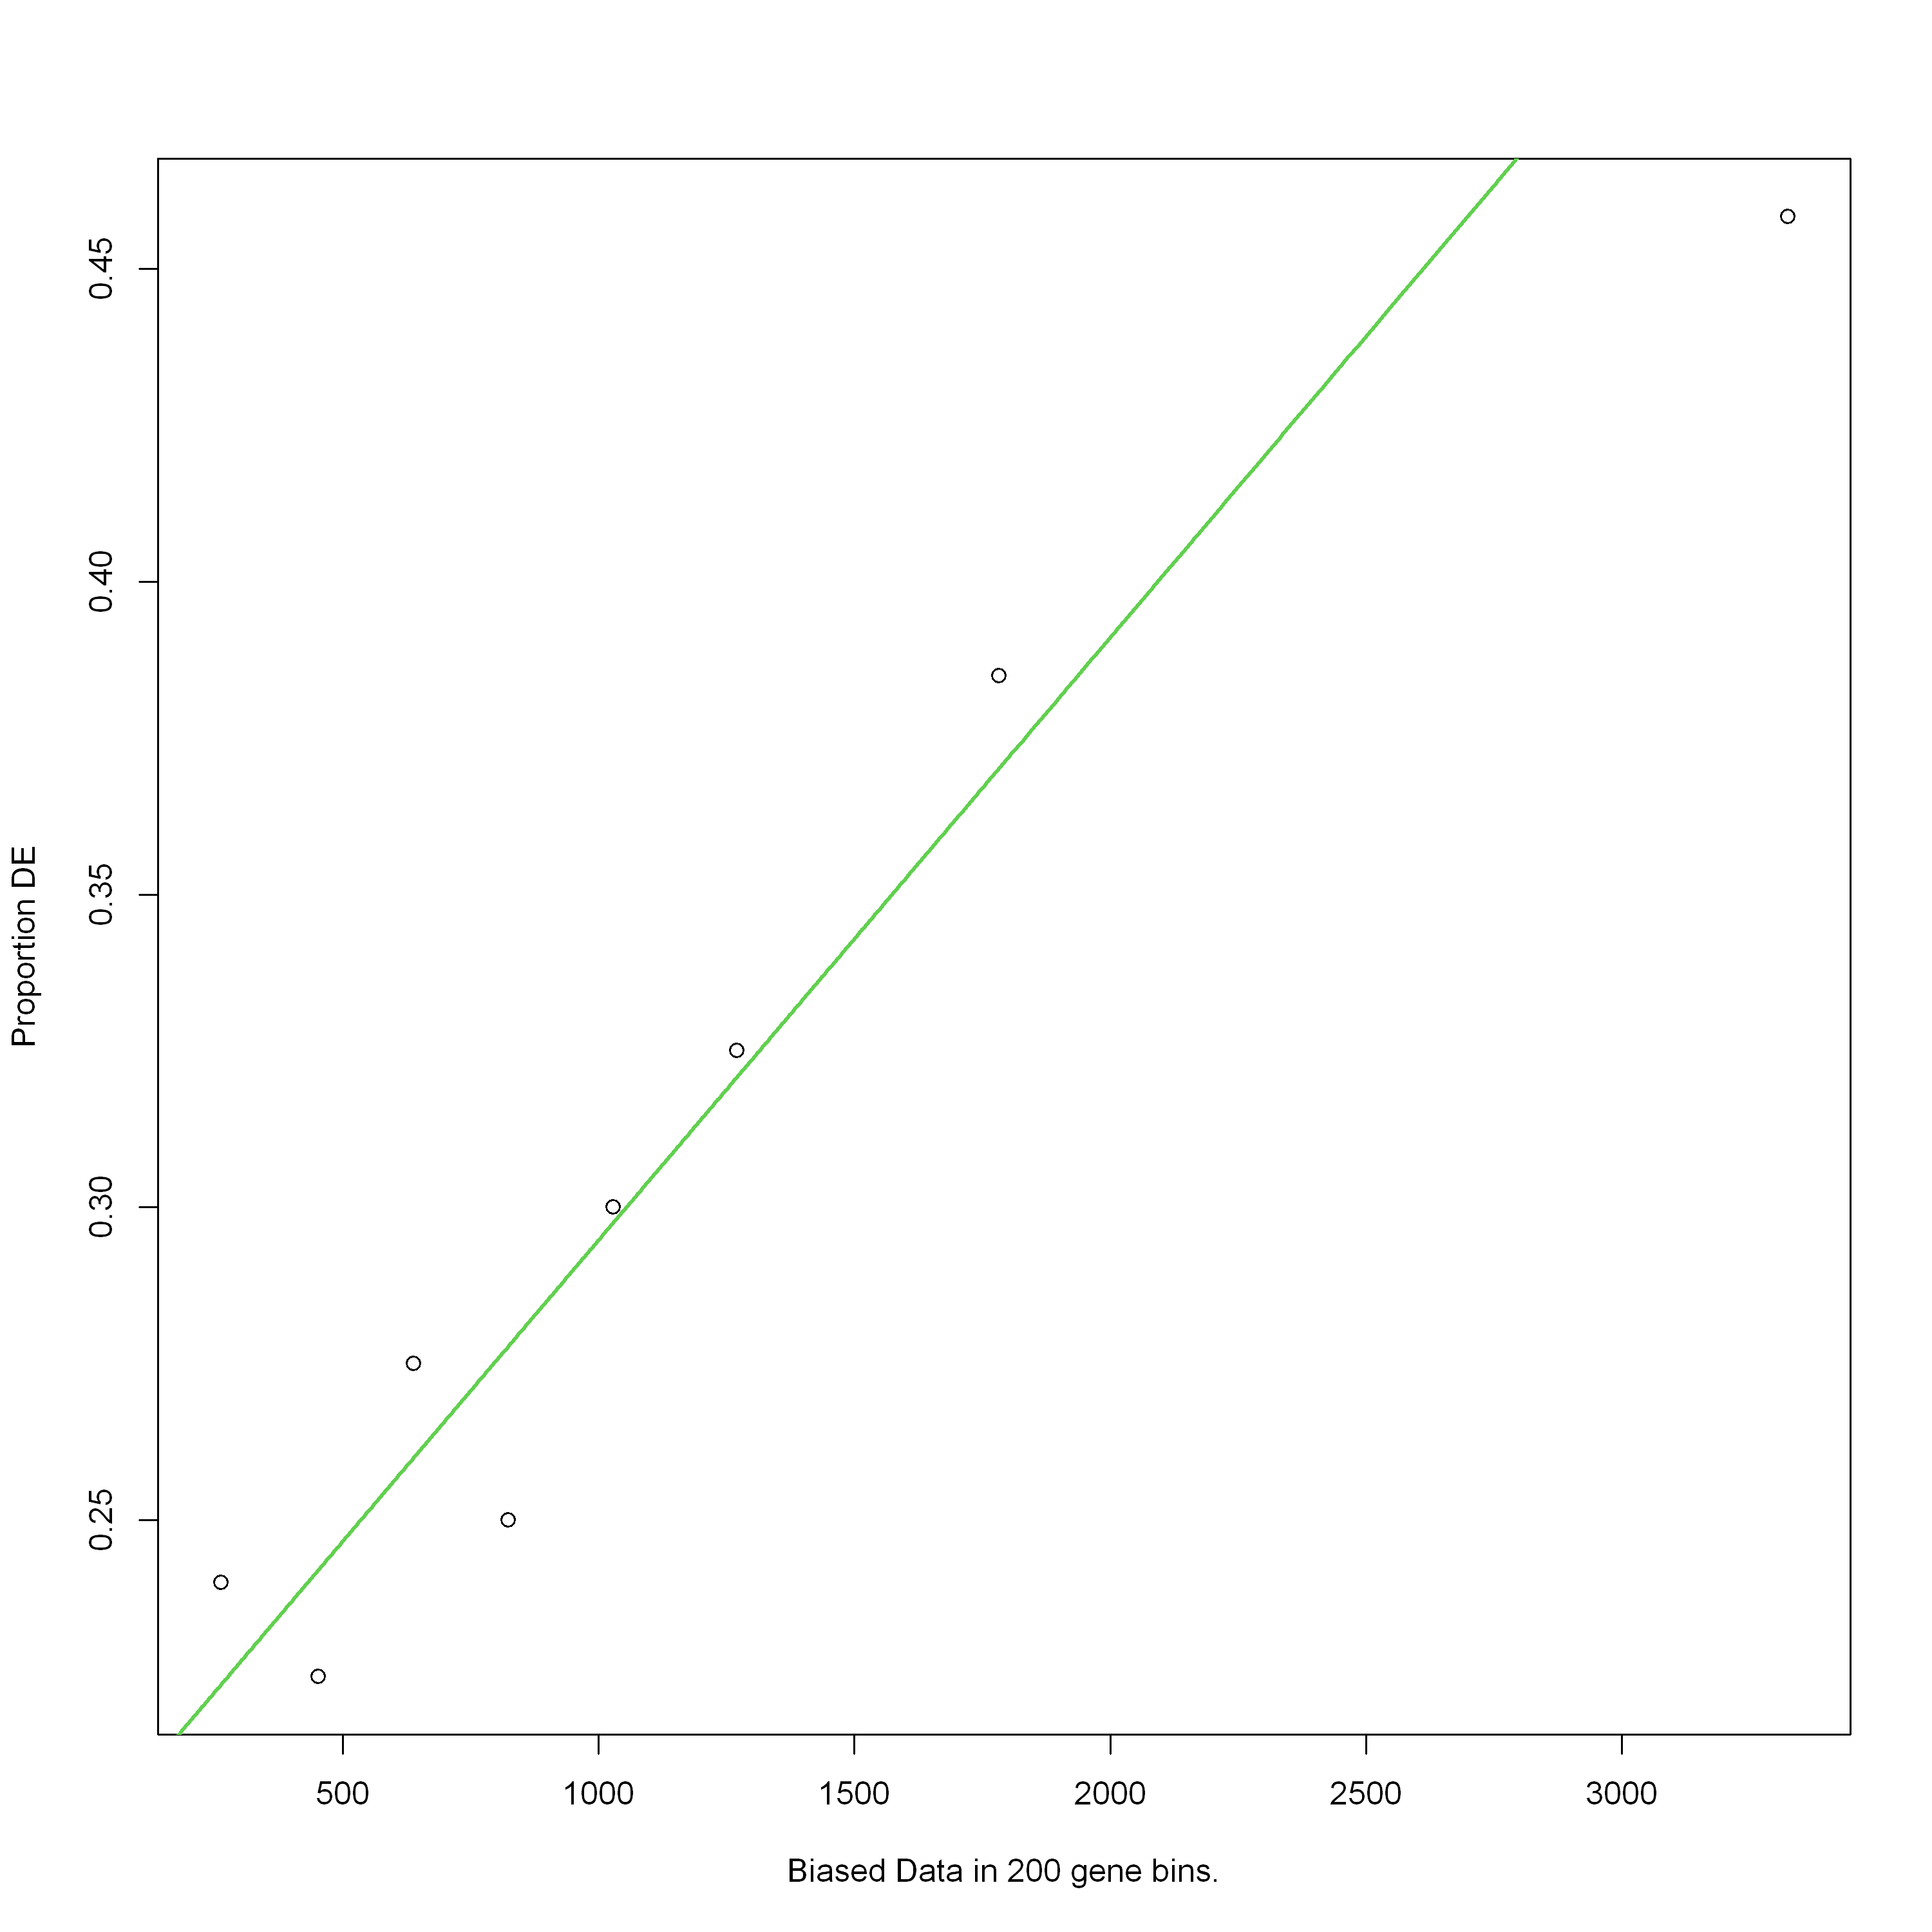

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



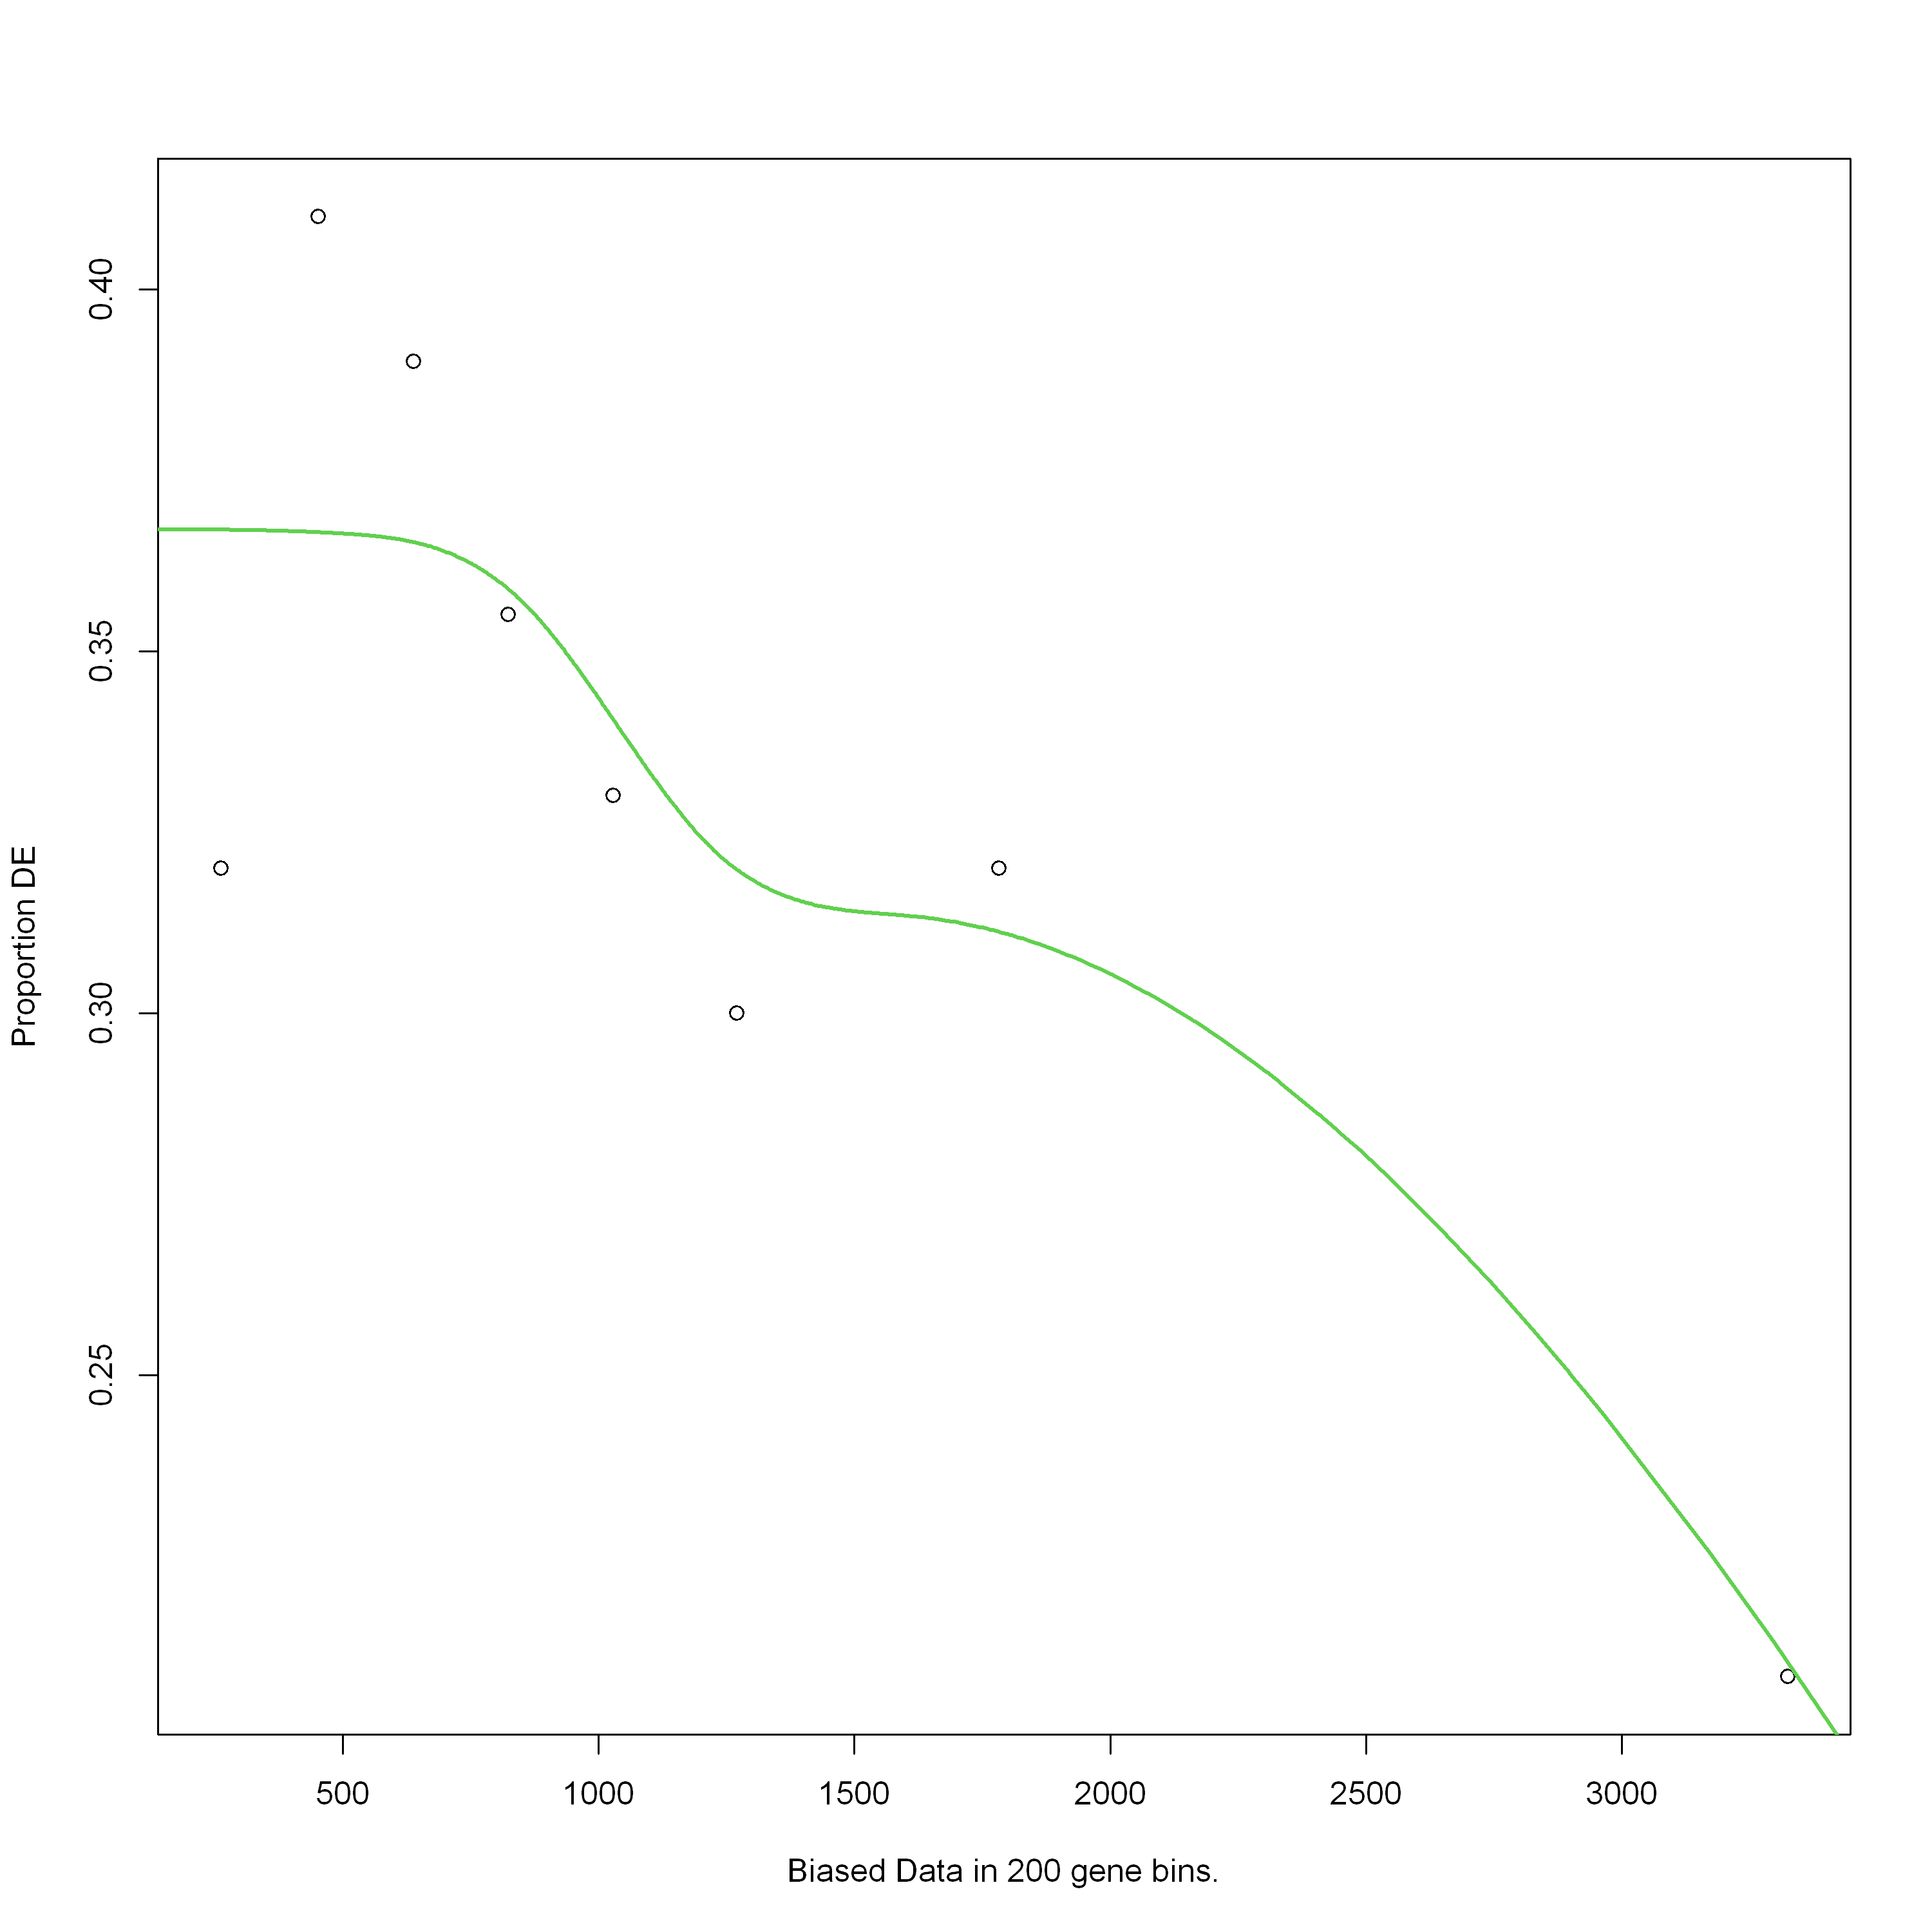

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


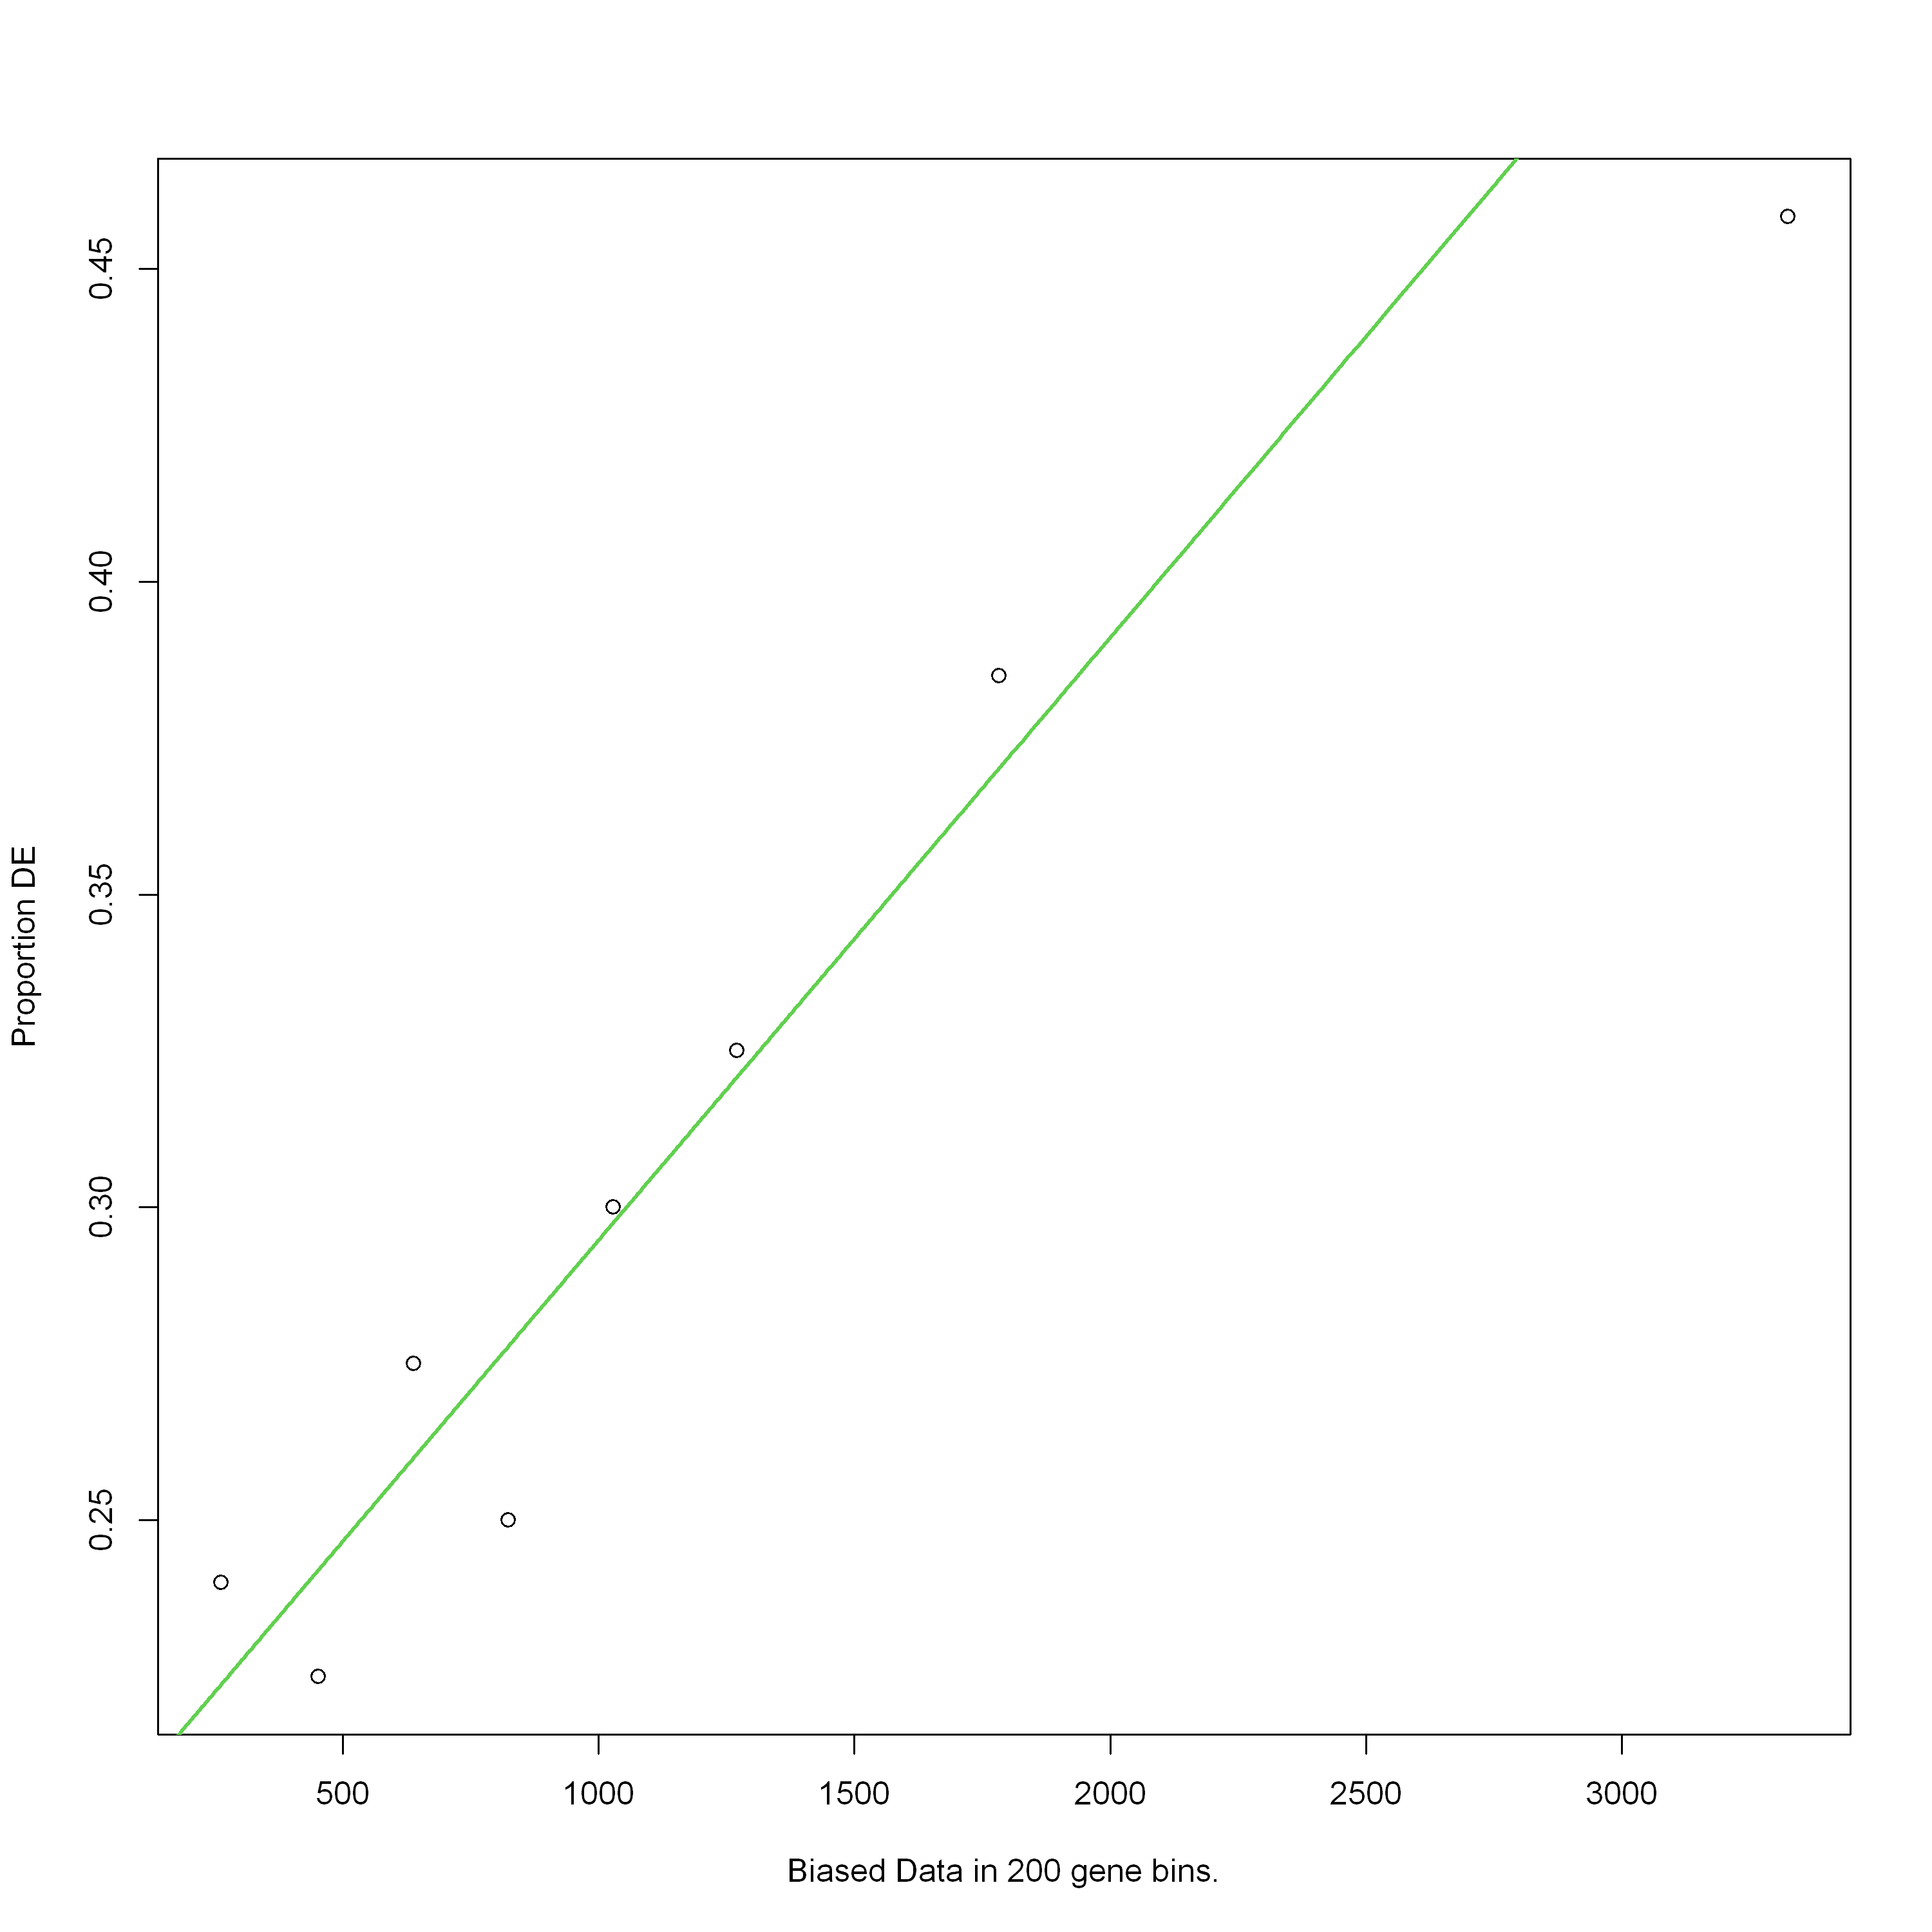

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



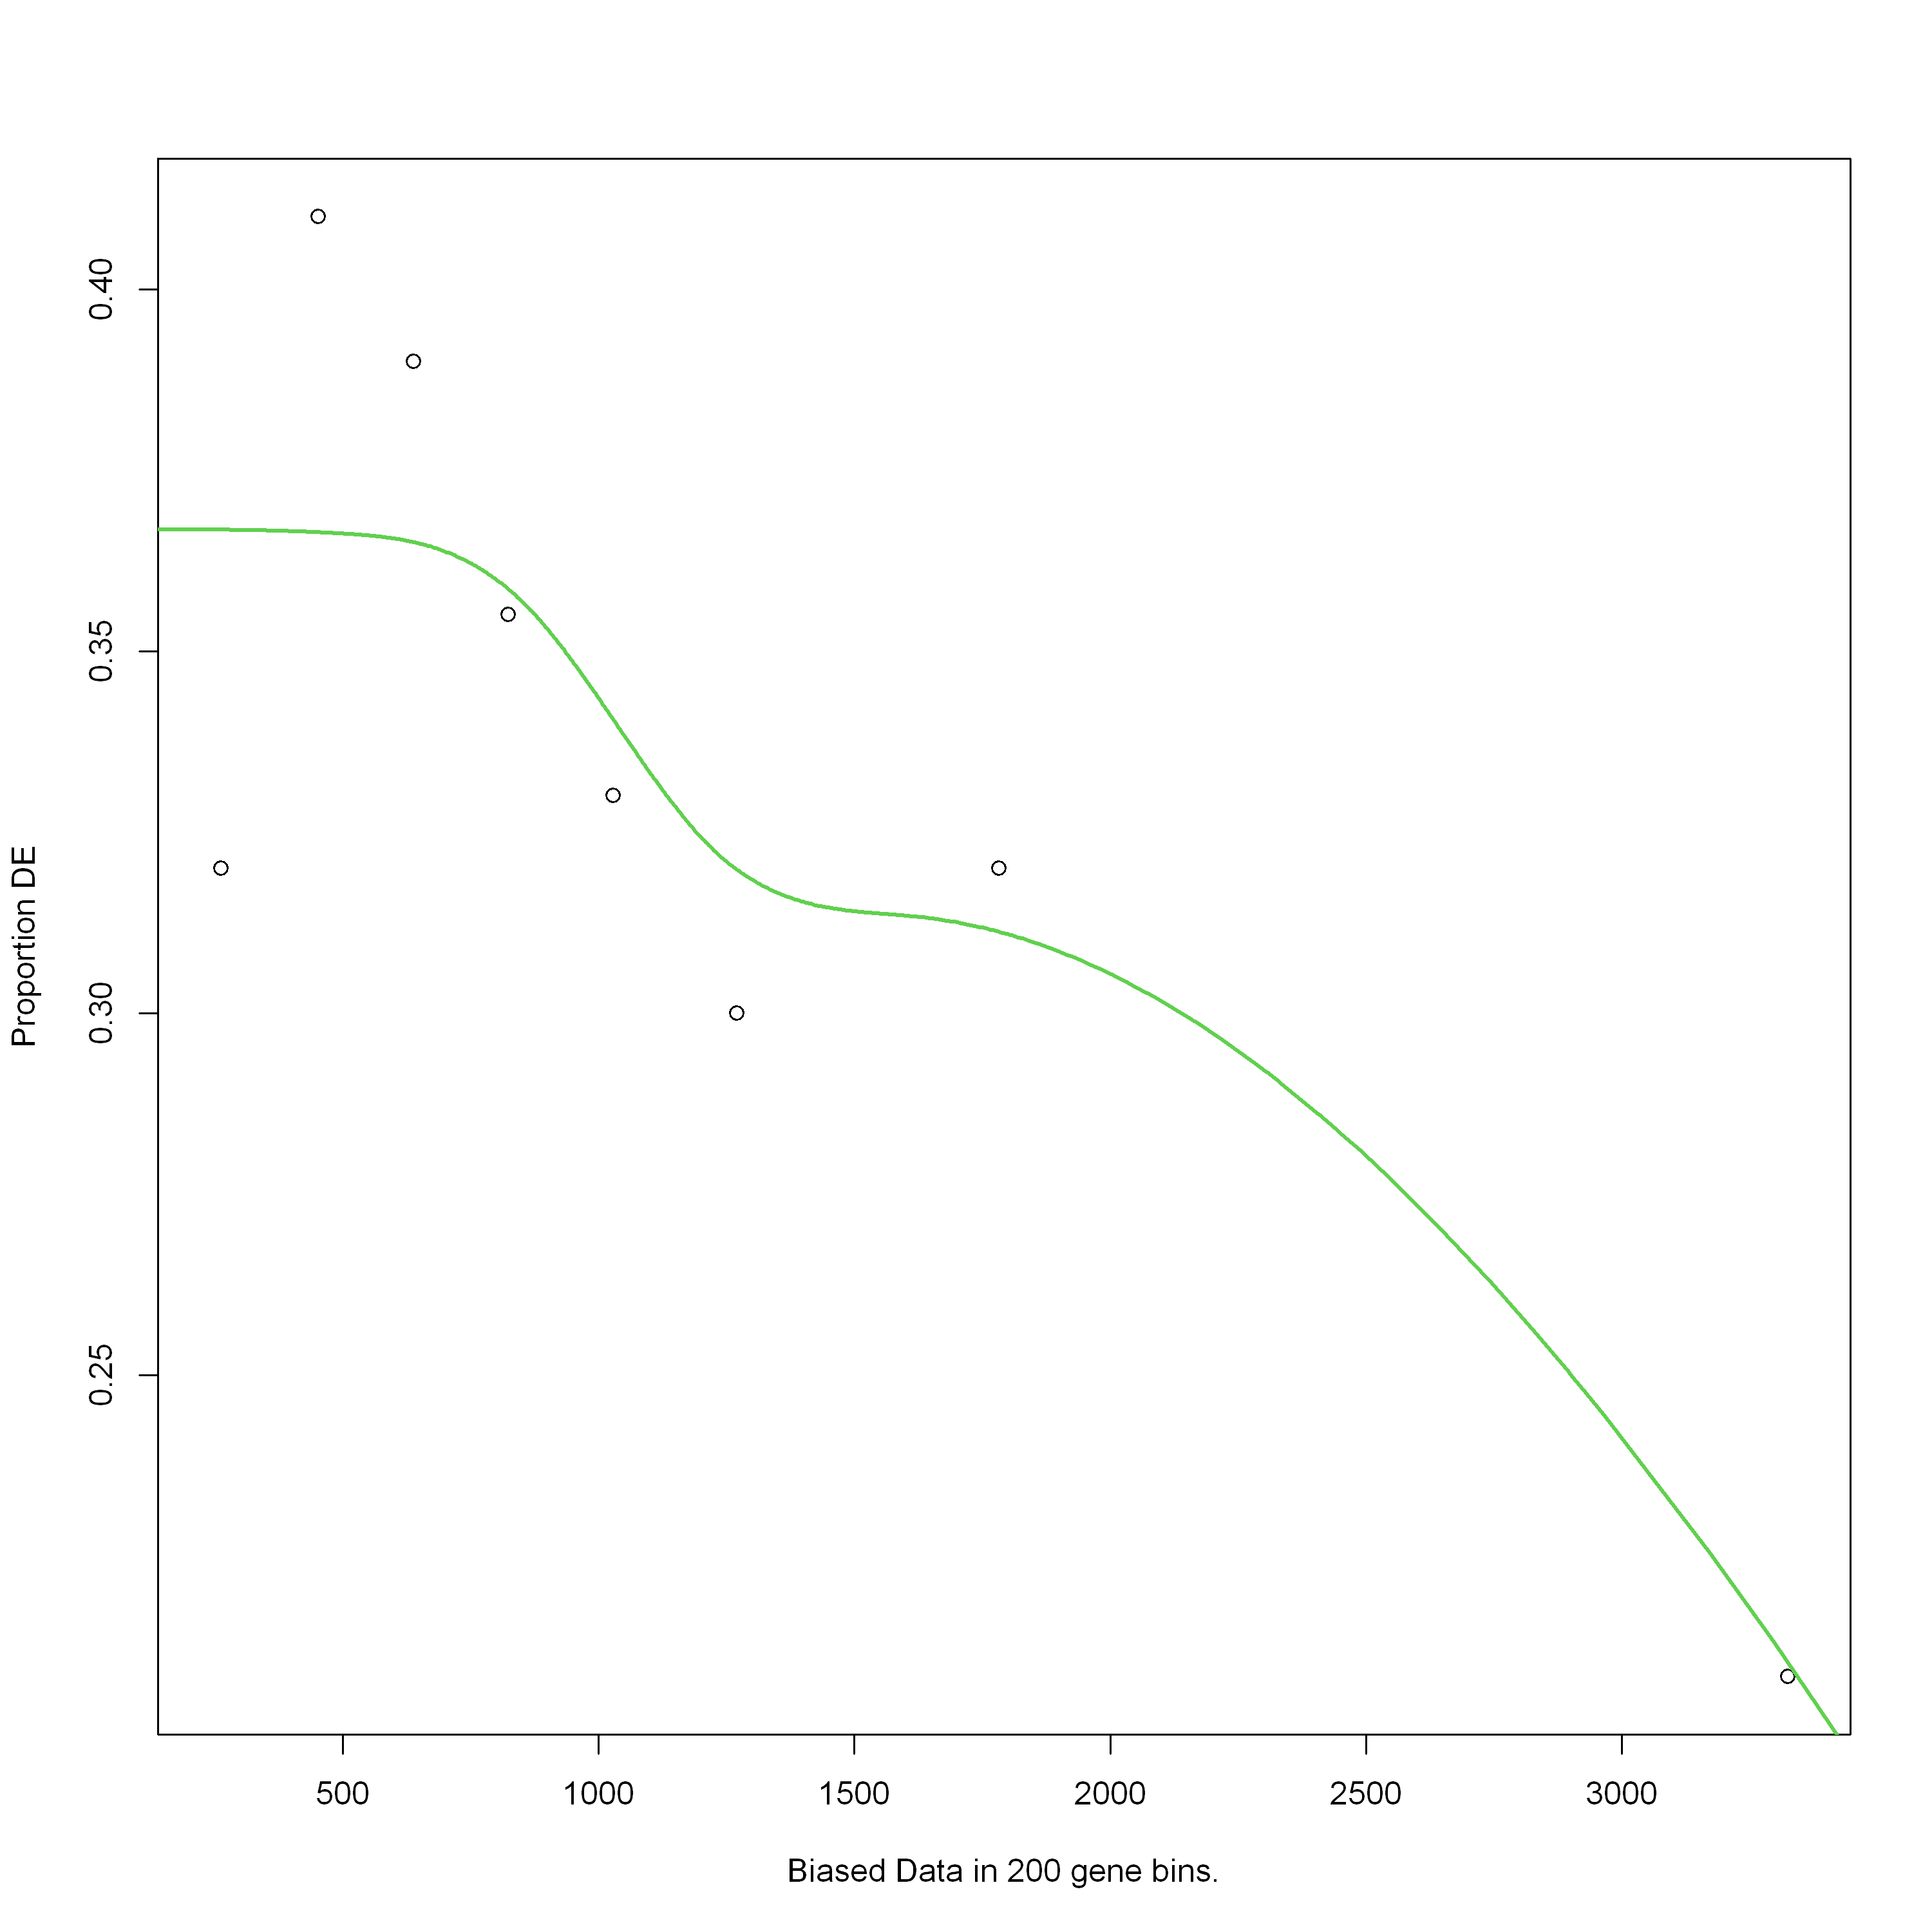

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


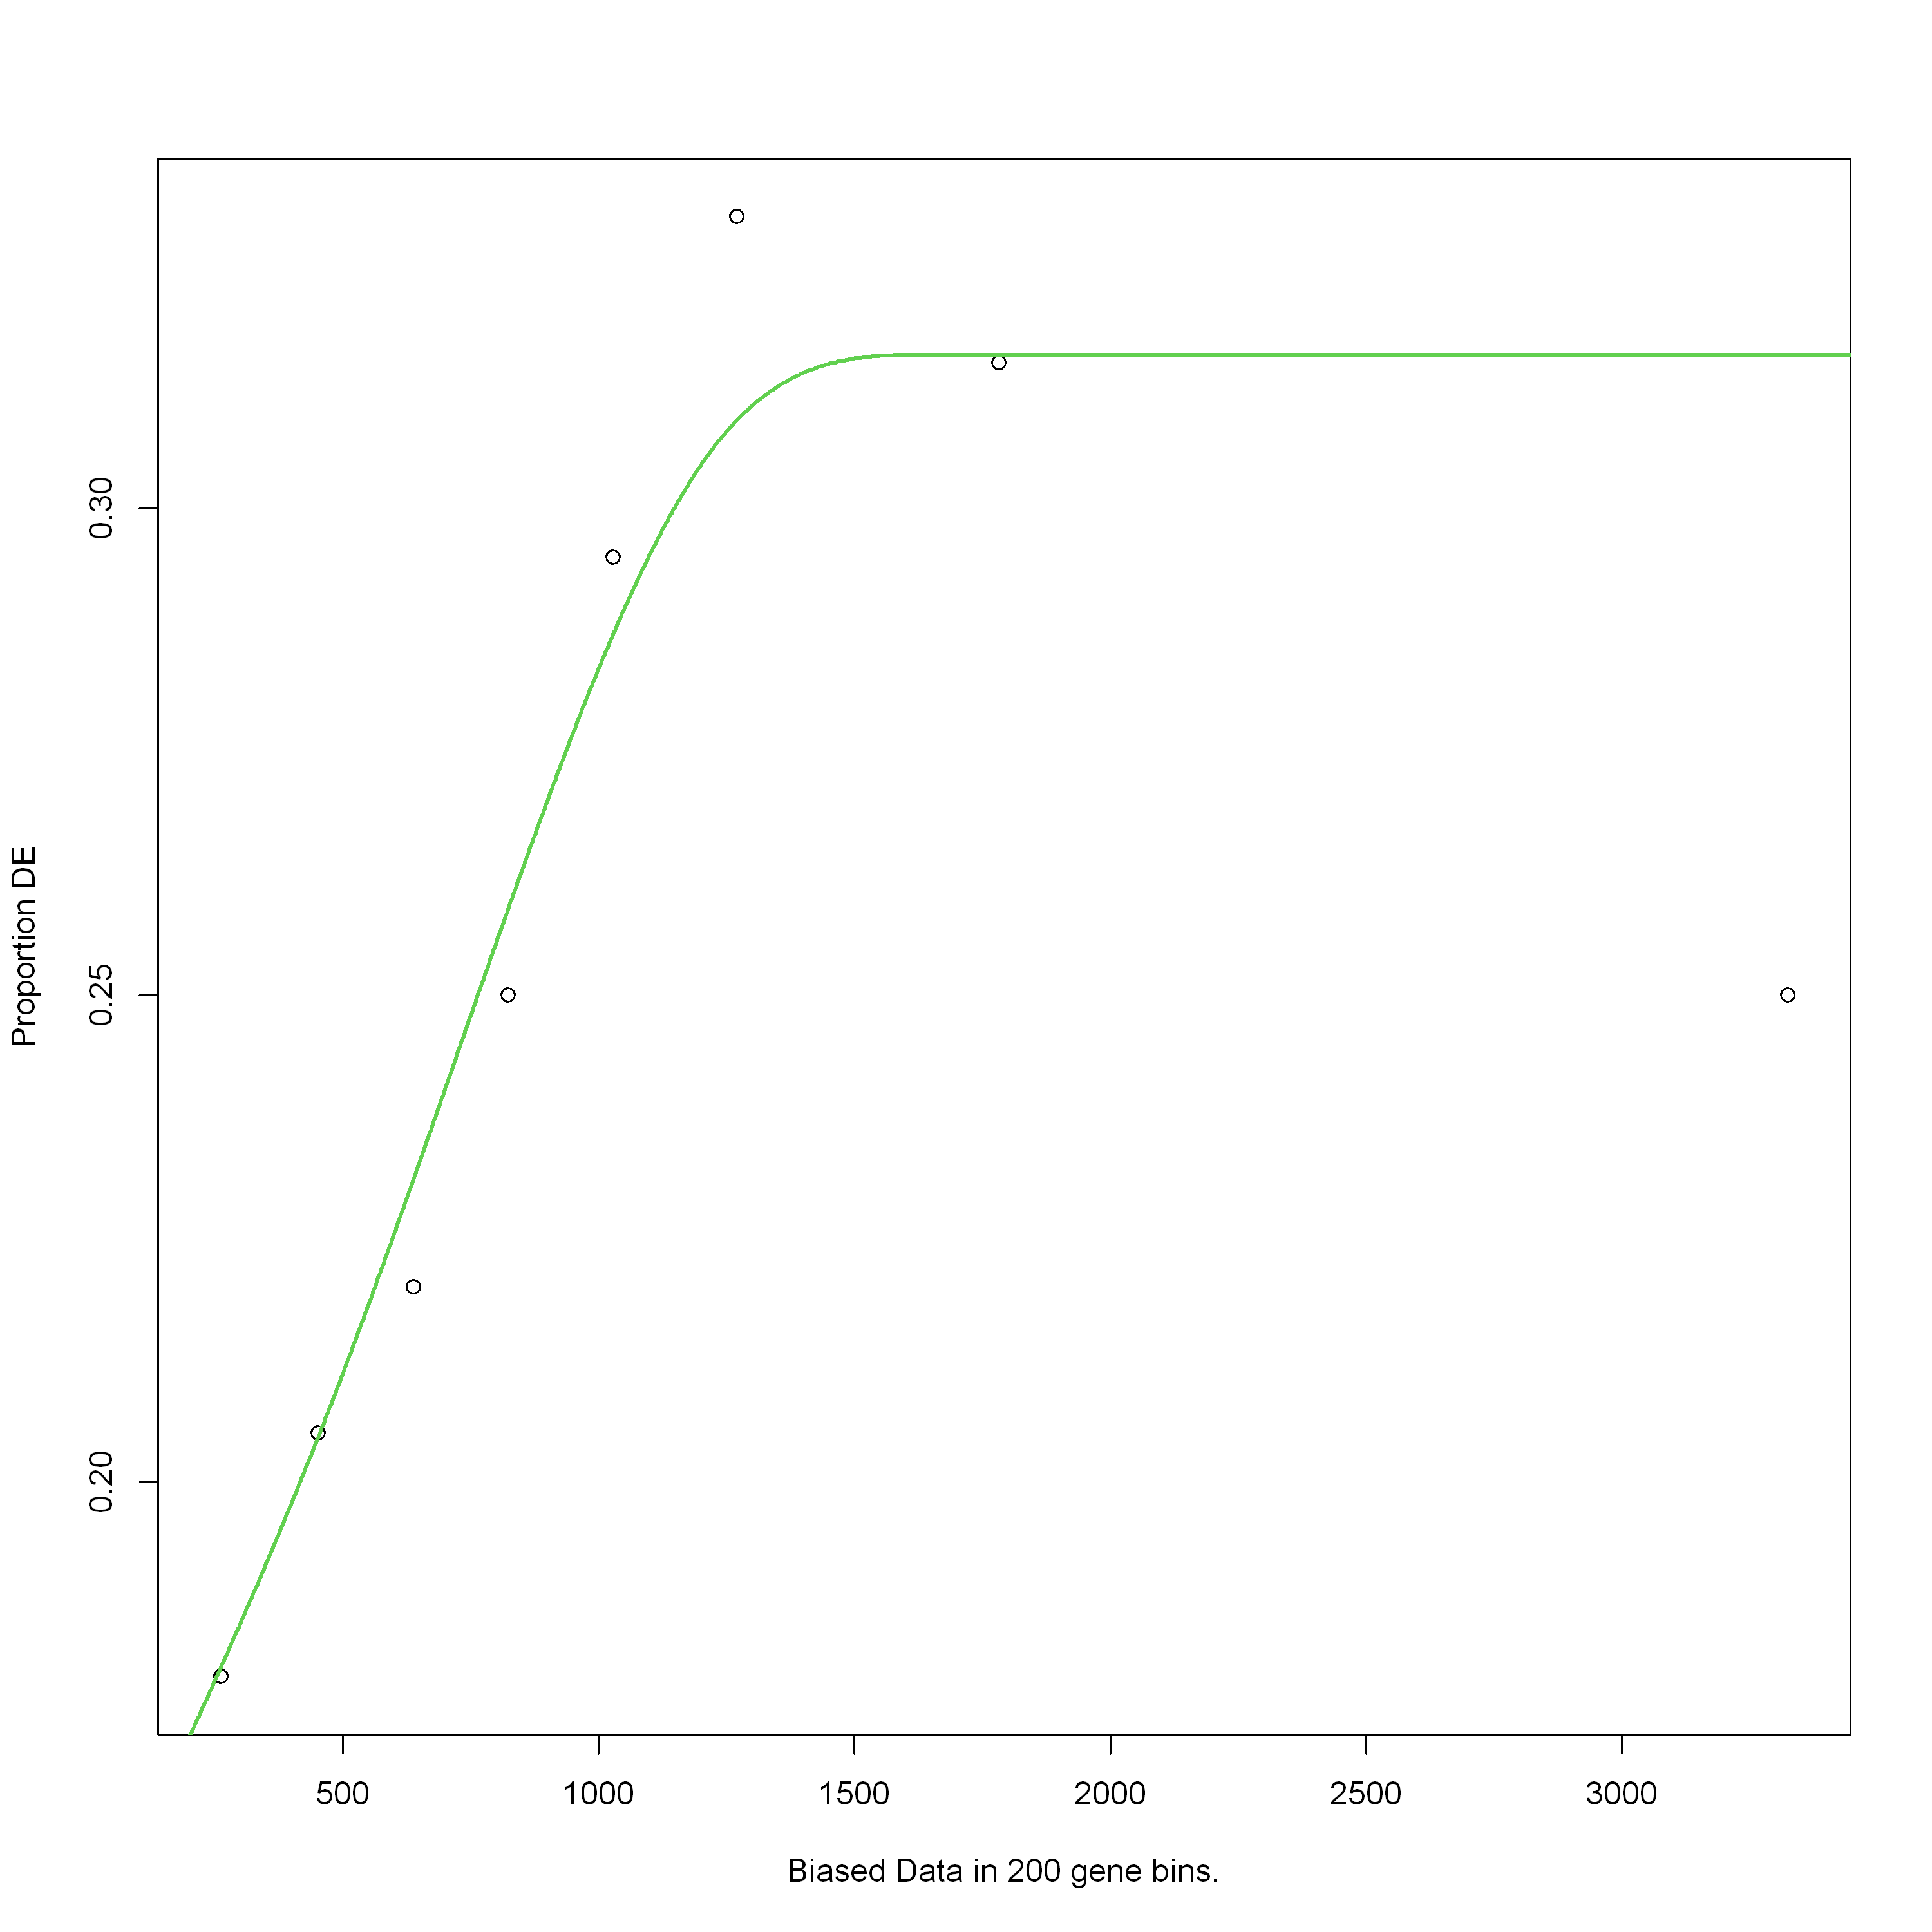

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



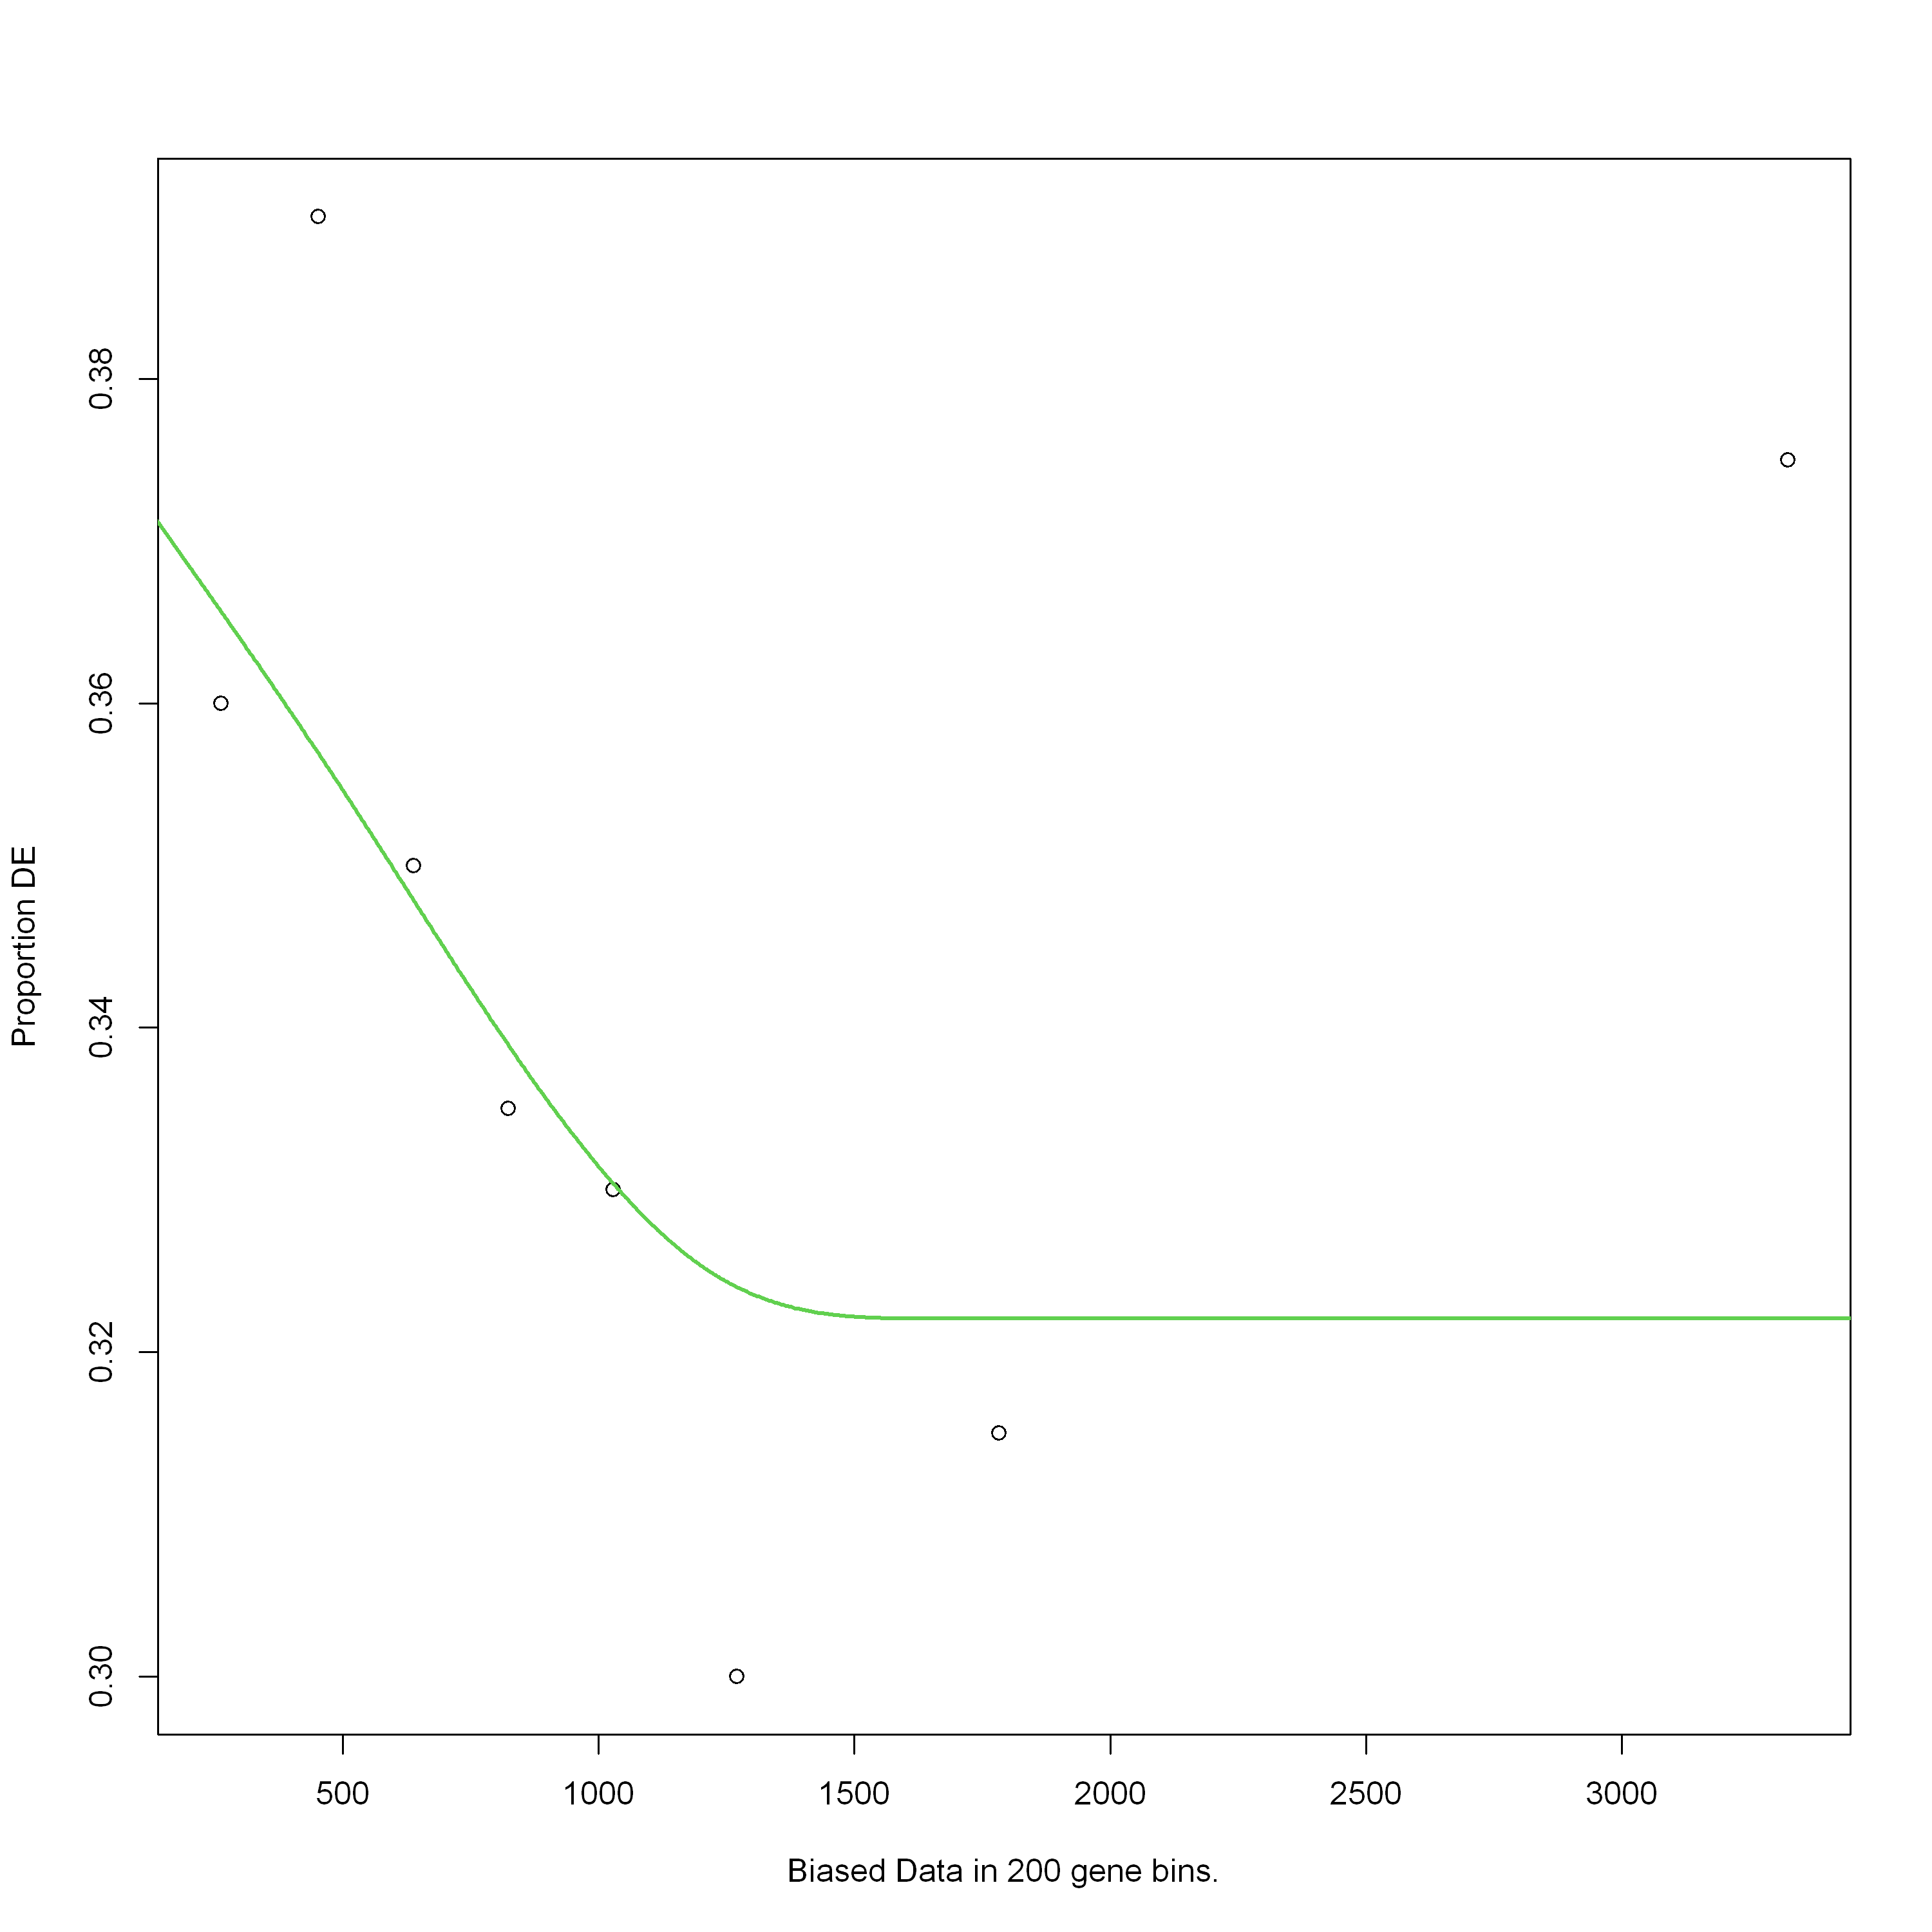

Using manually entered categories.

For 18 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



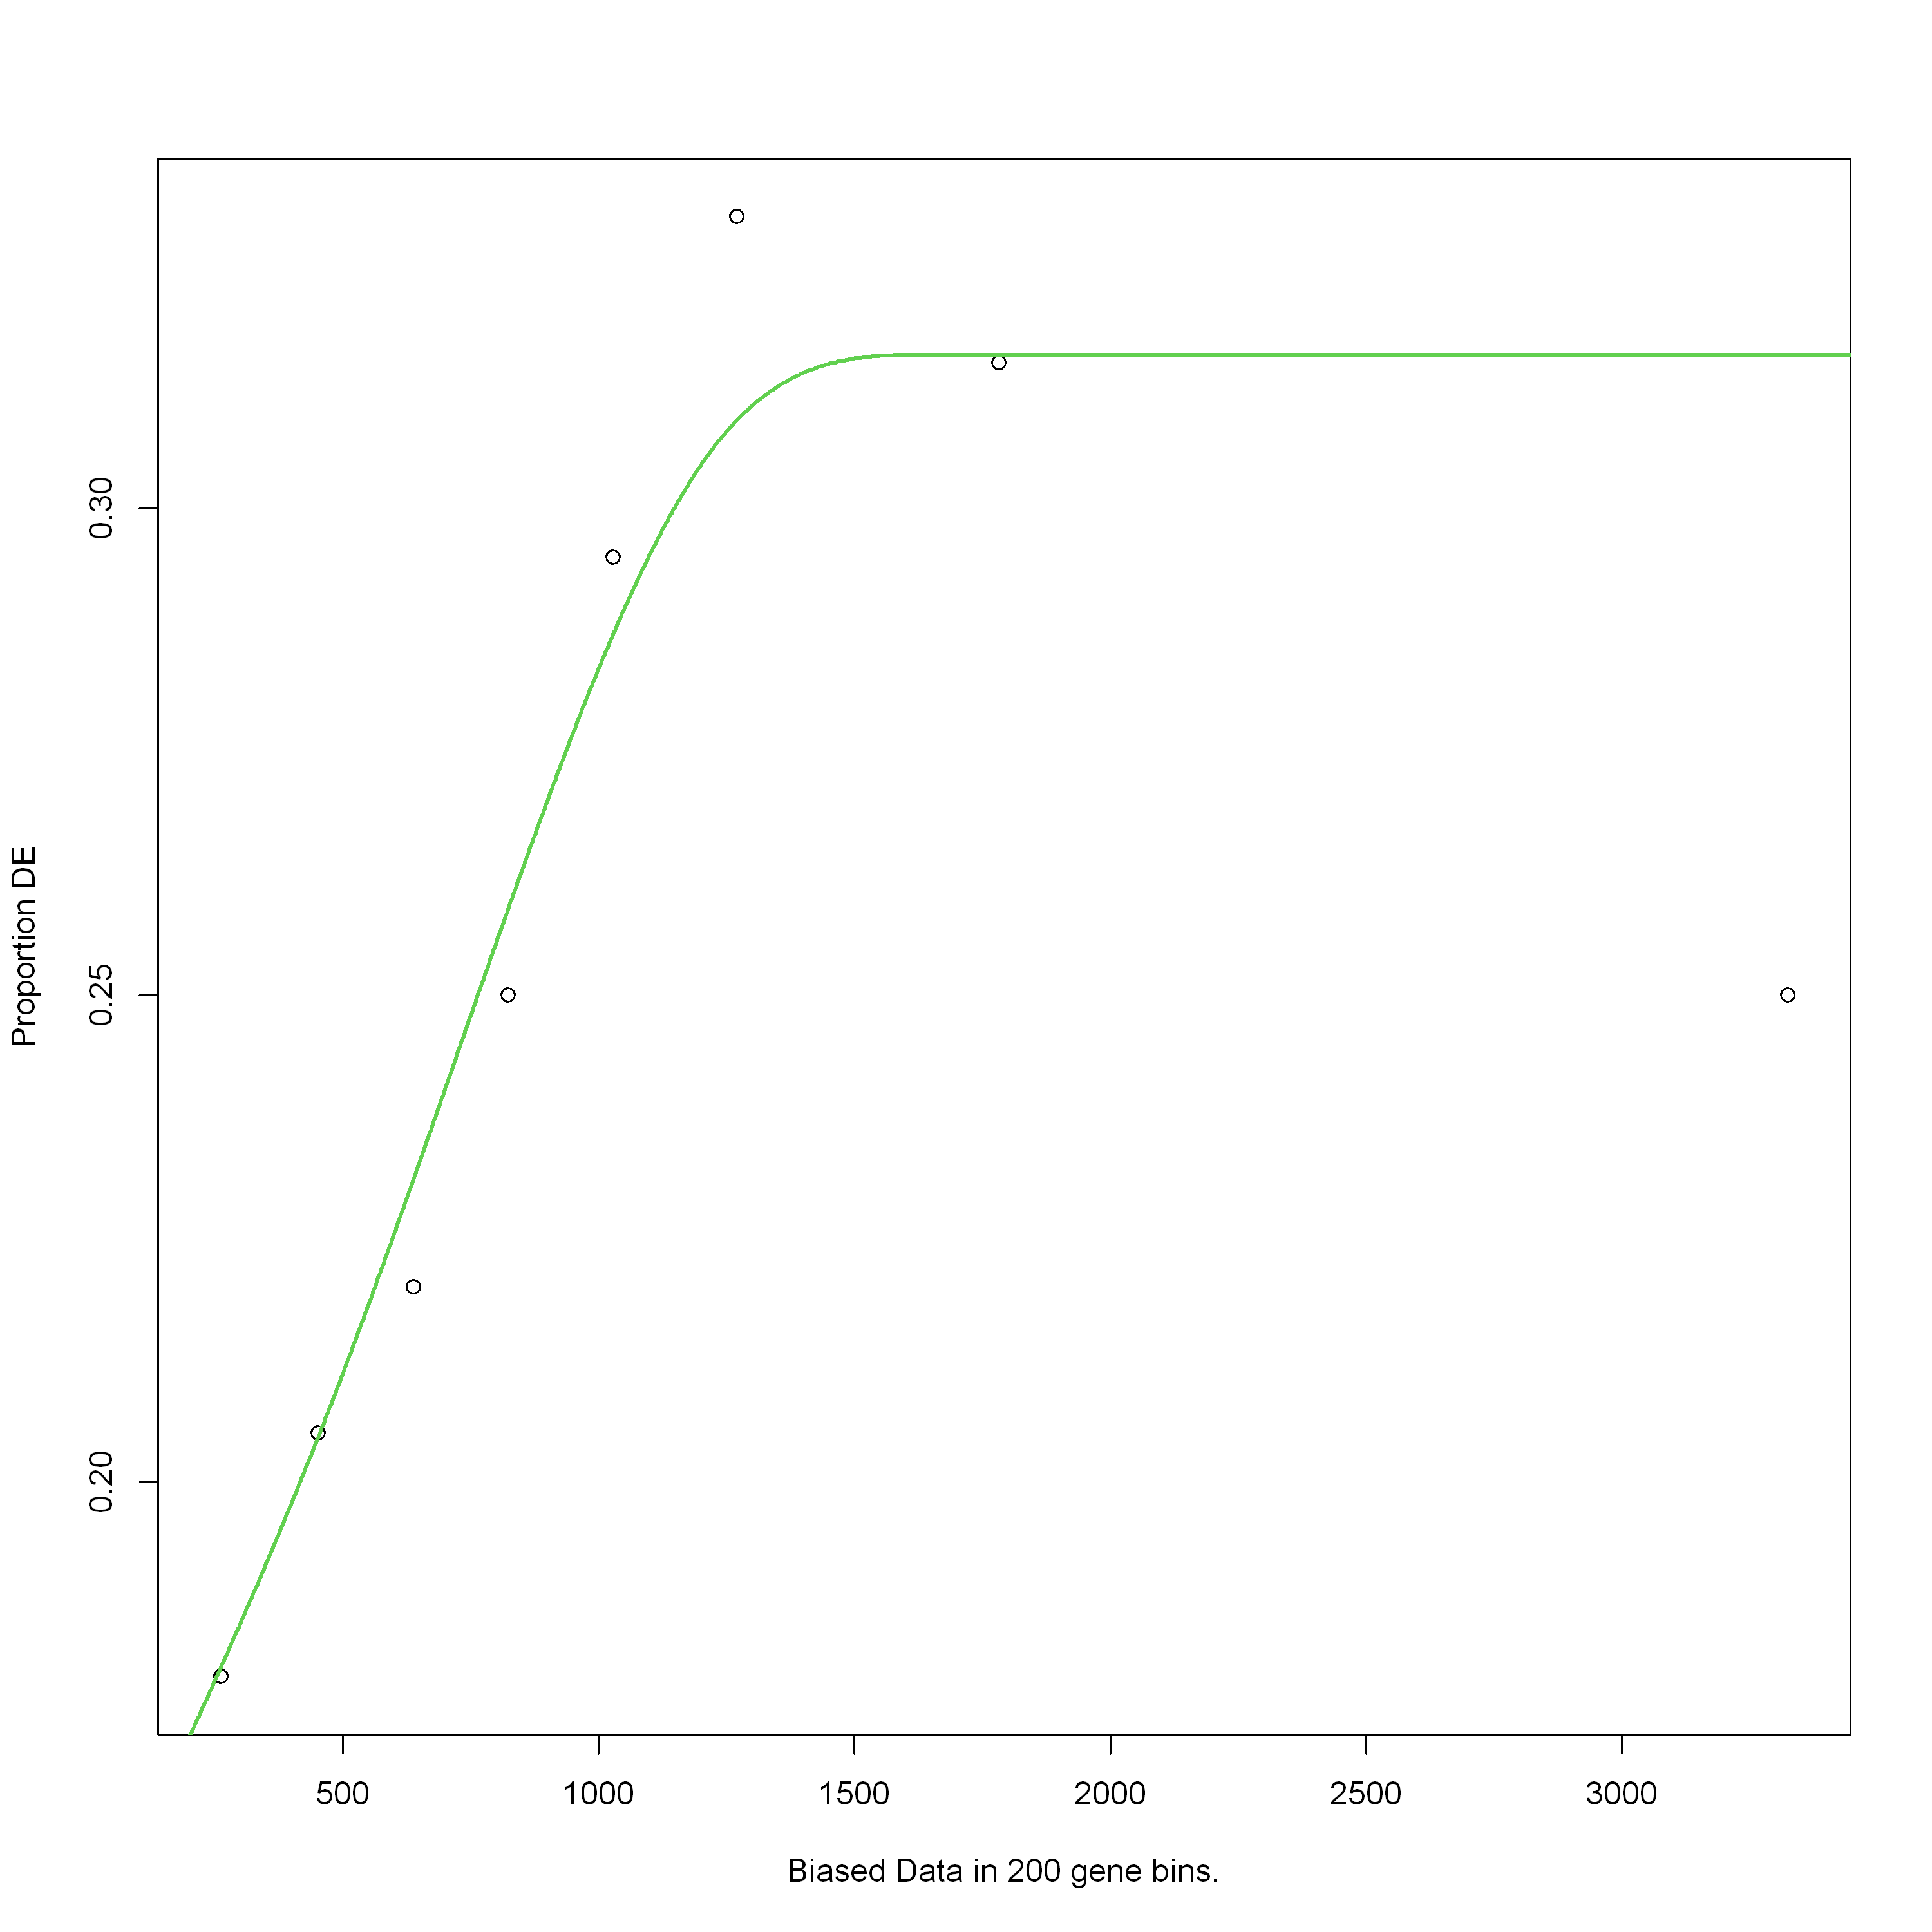

Using manually entered categories.

For 105 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



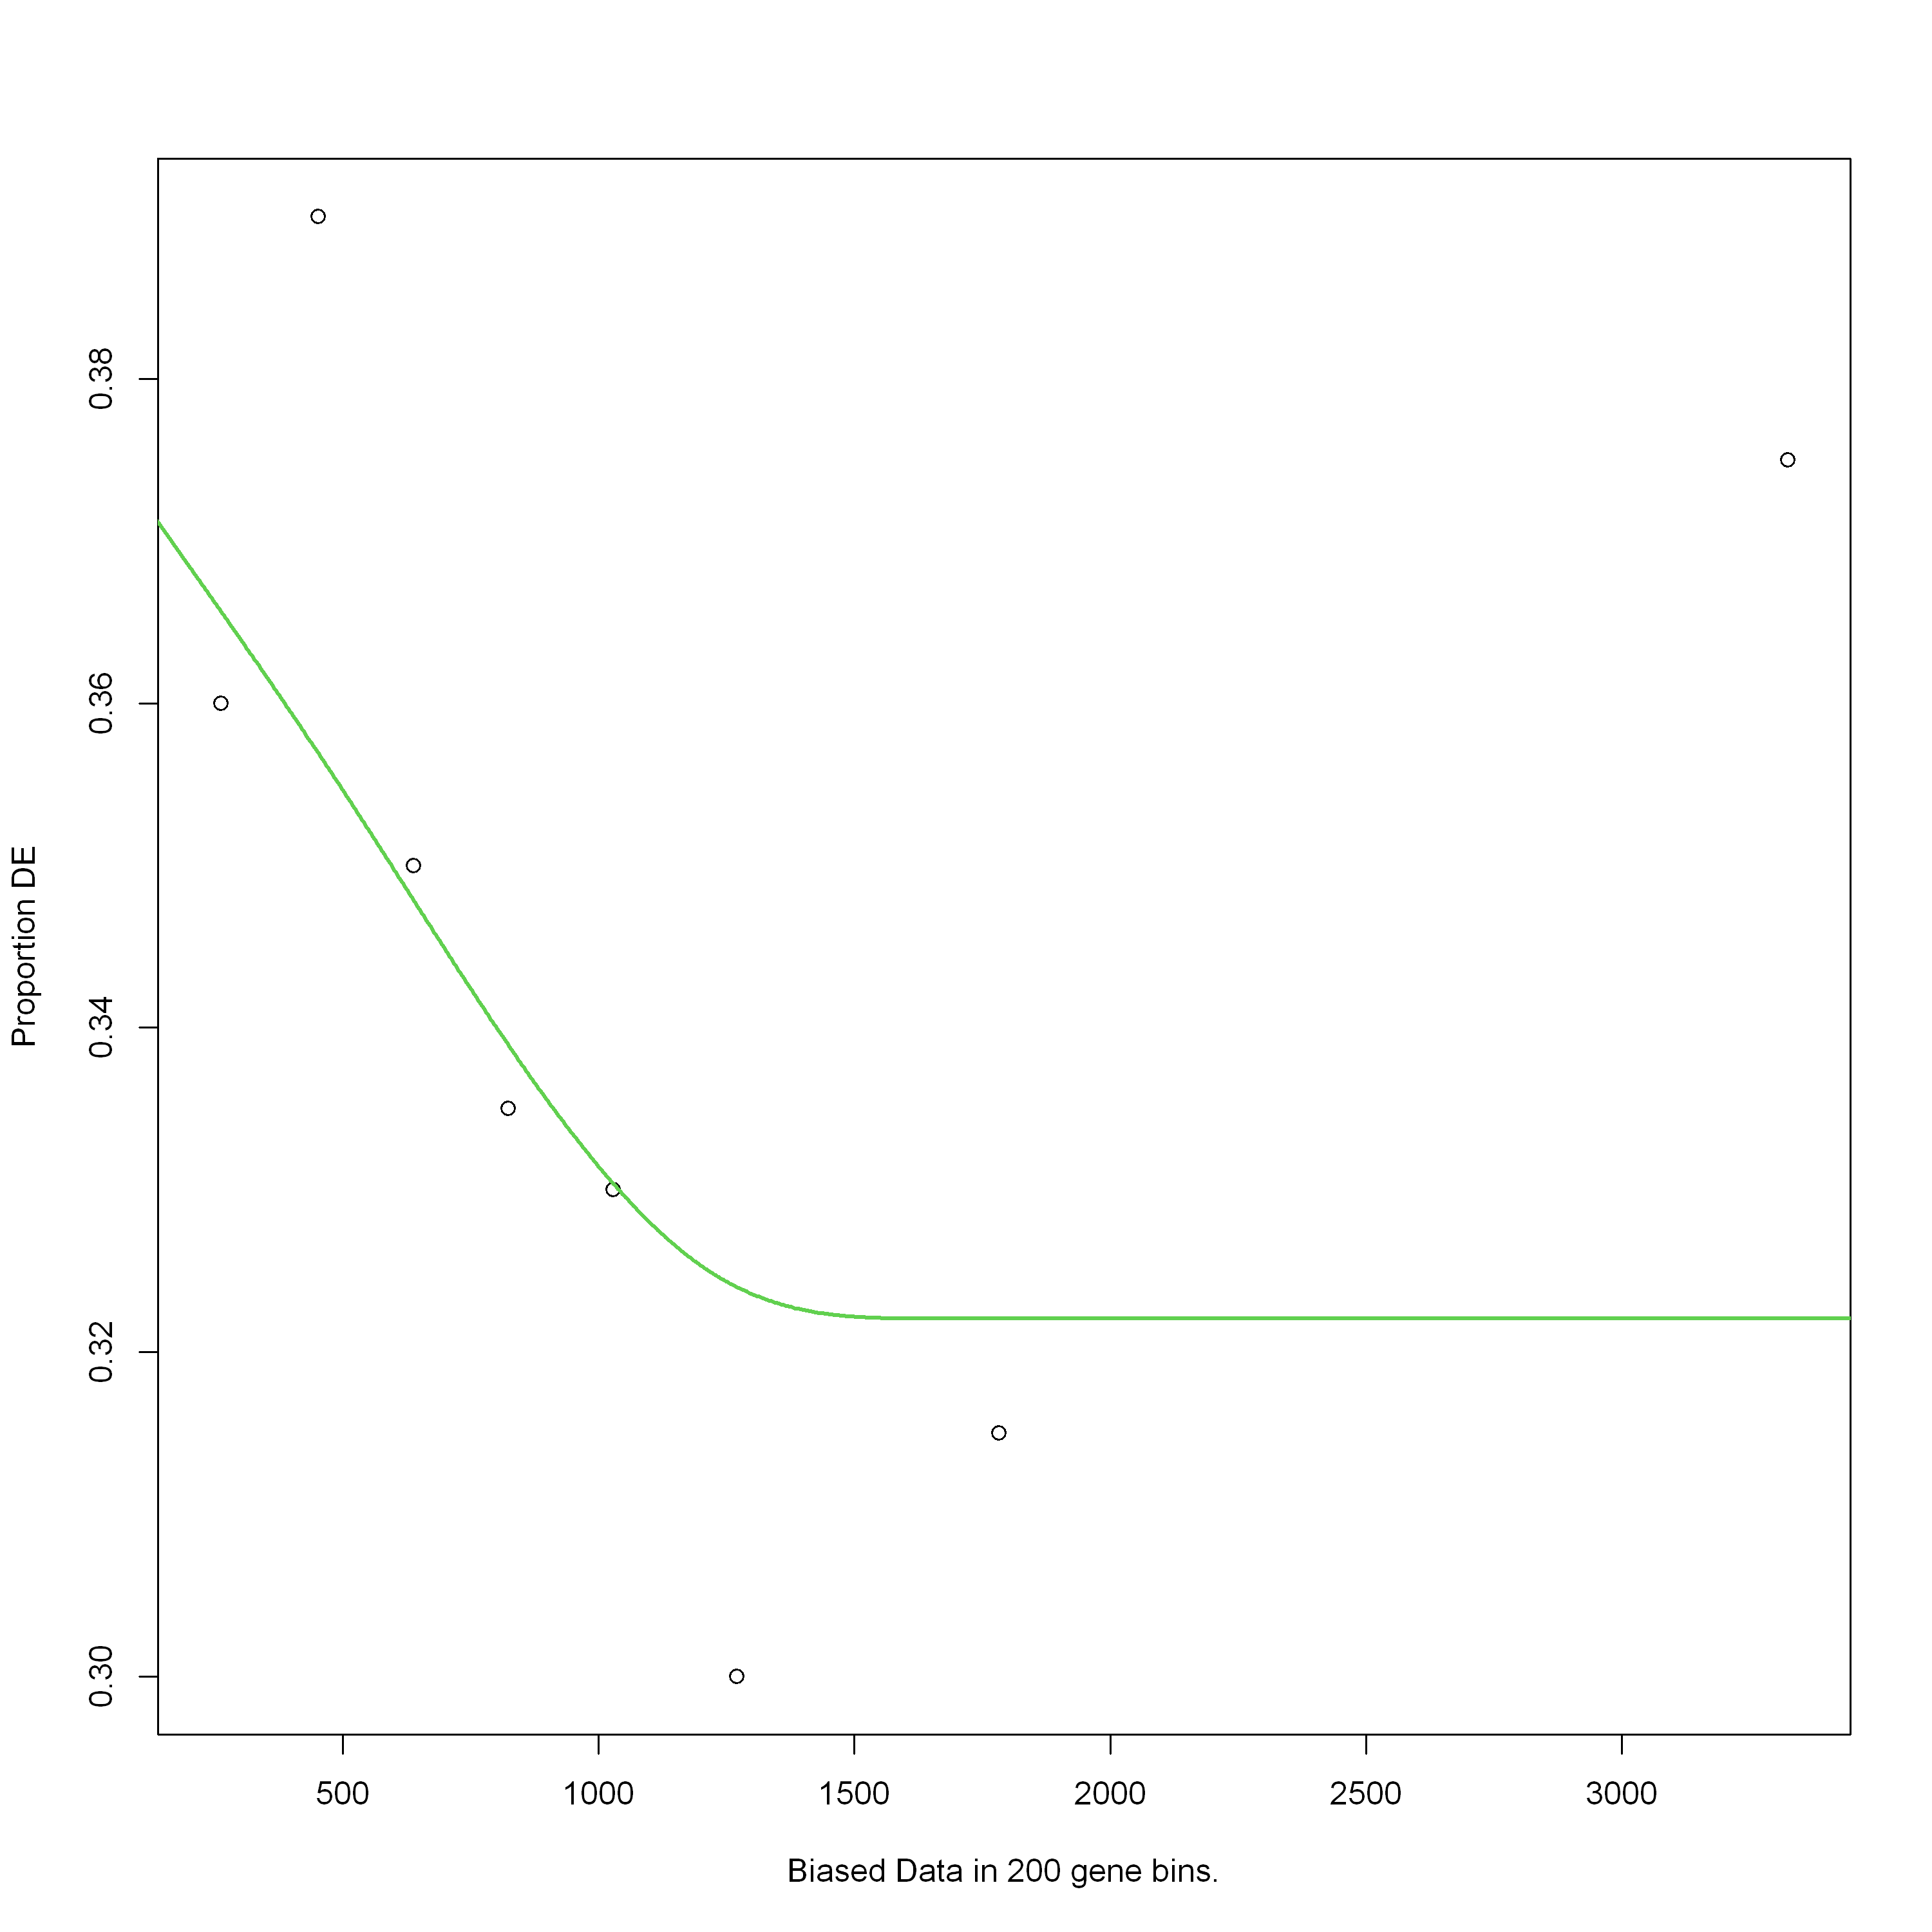

Using manually entered categories.

For 105 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



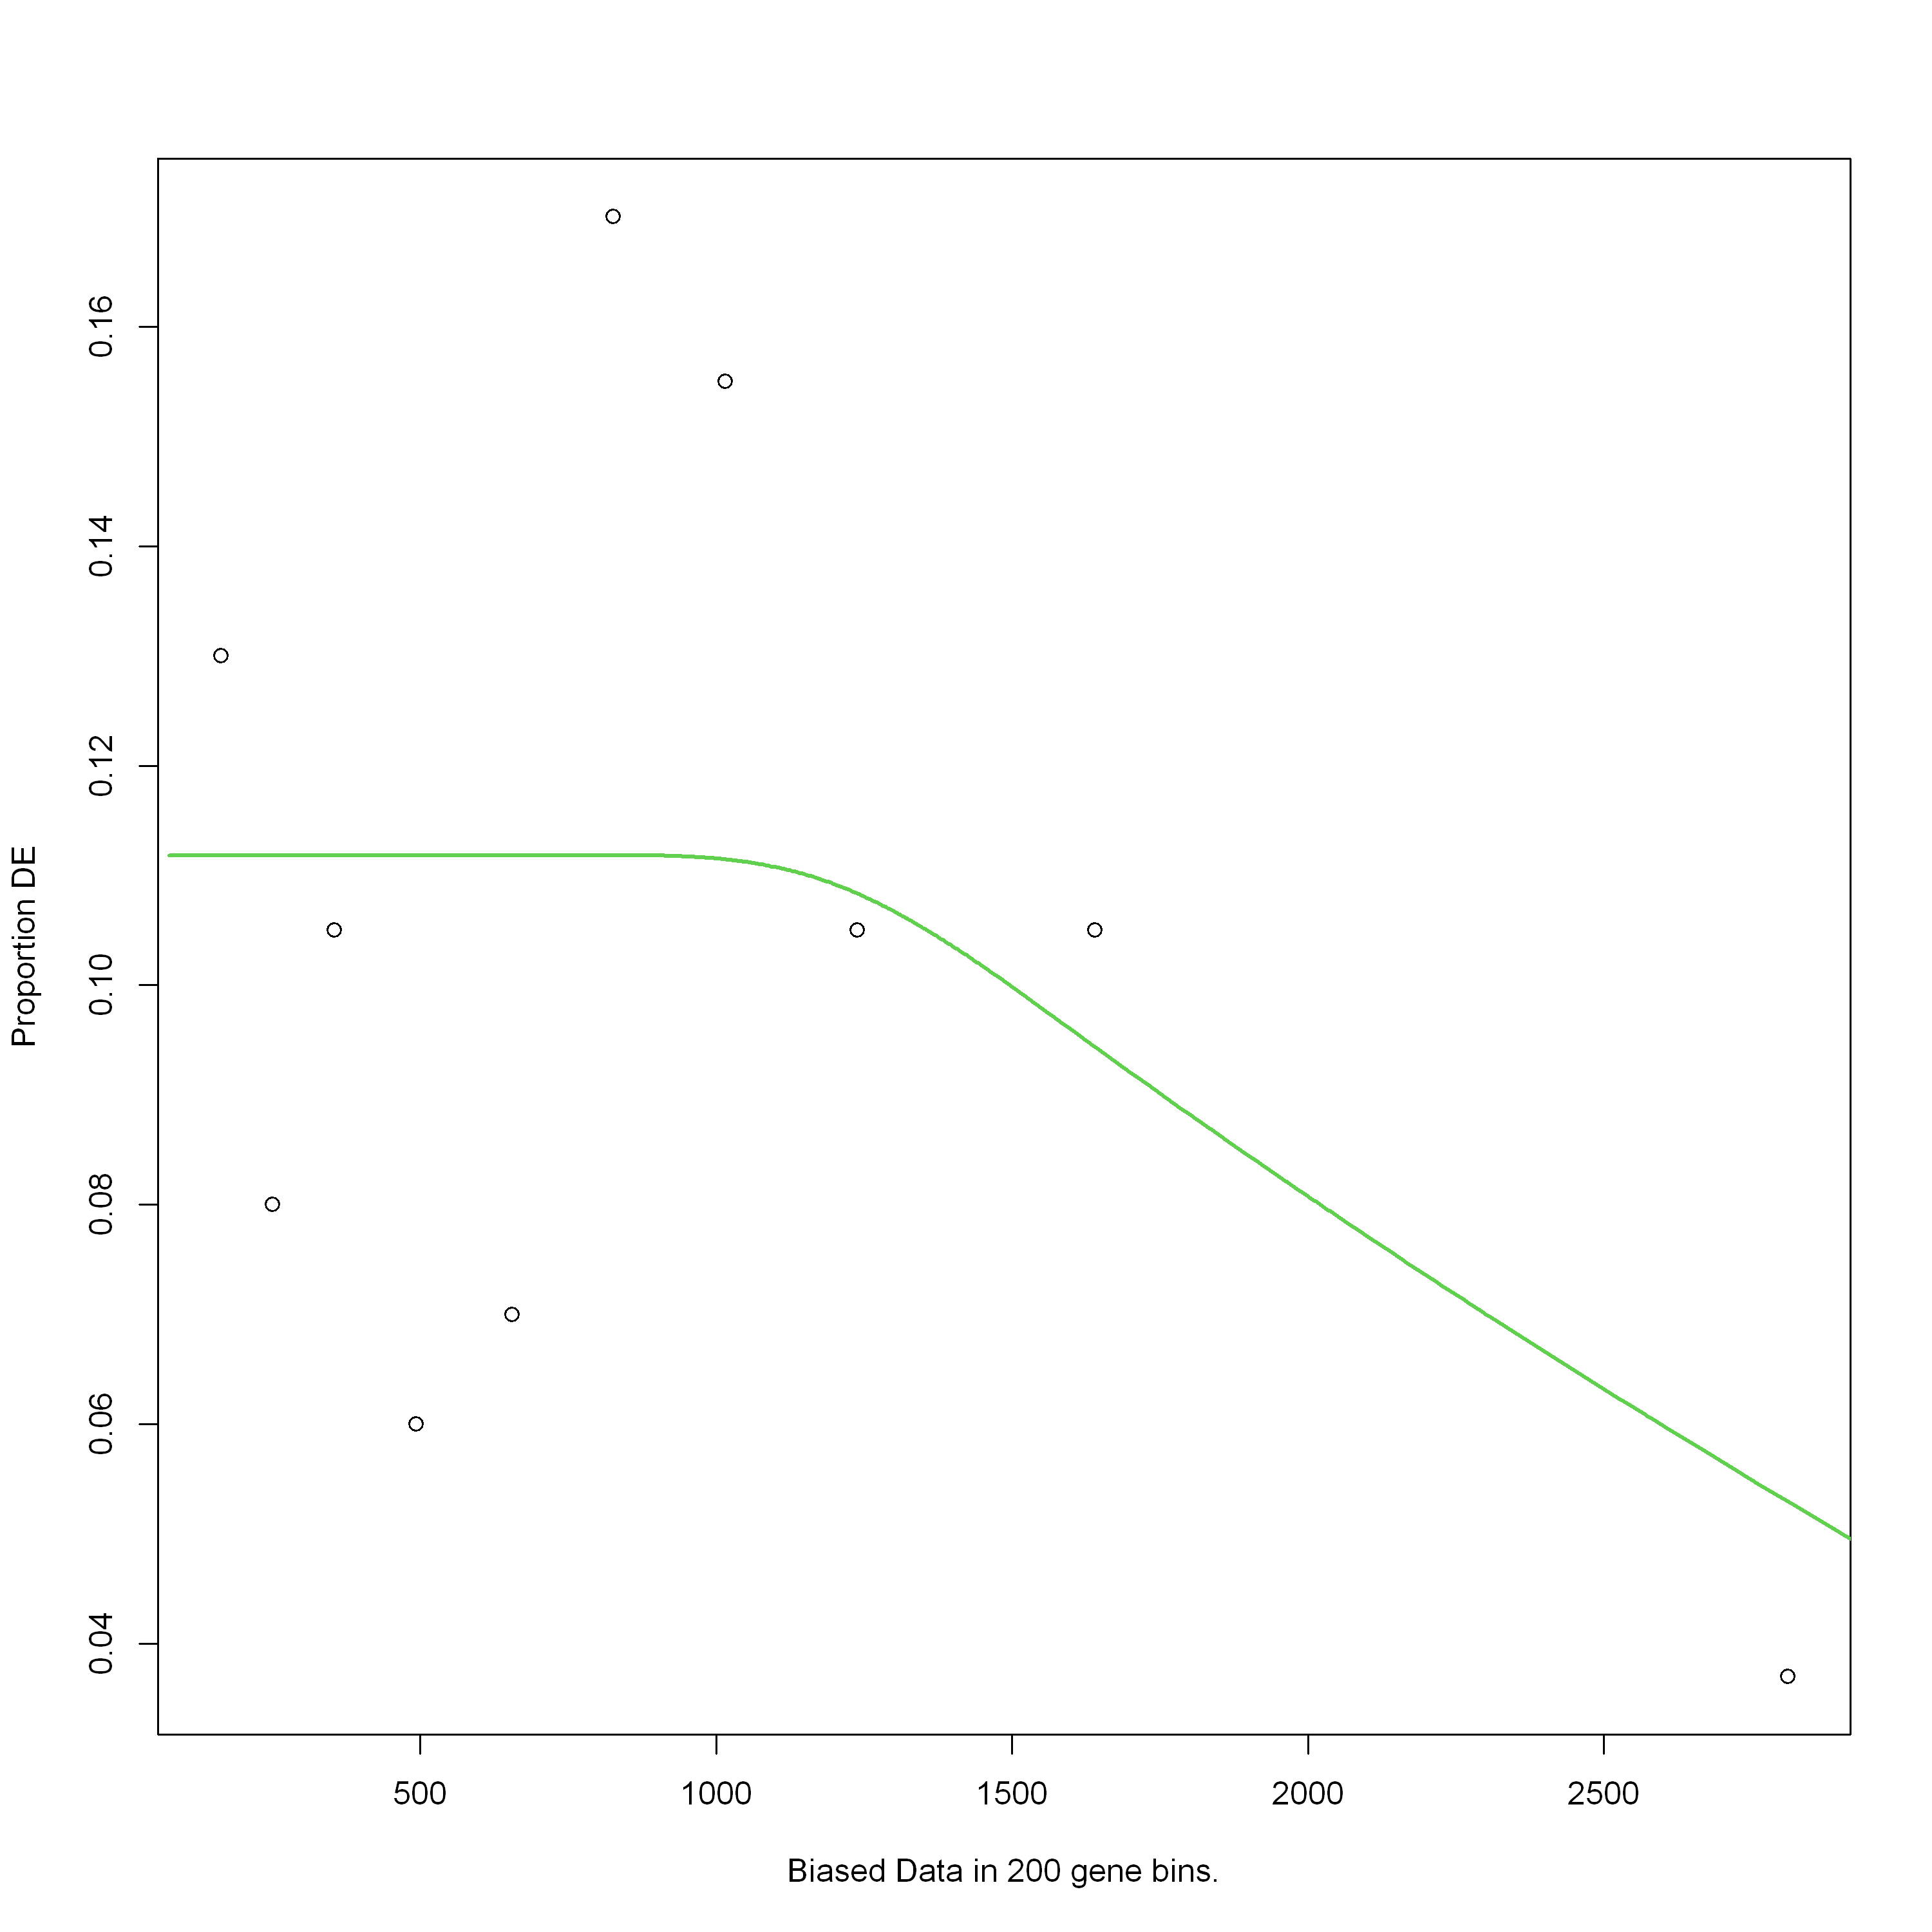

Using manually entered categories.

For 105 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



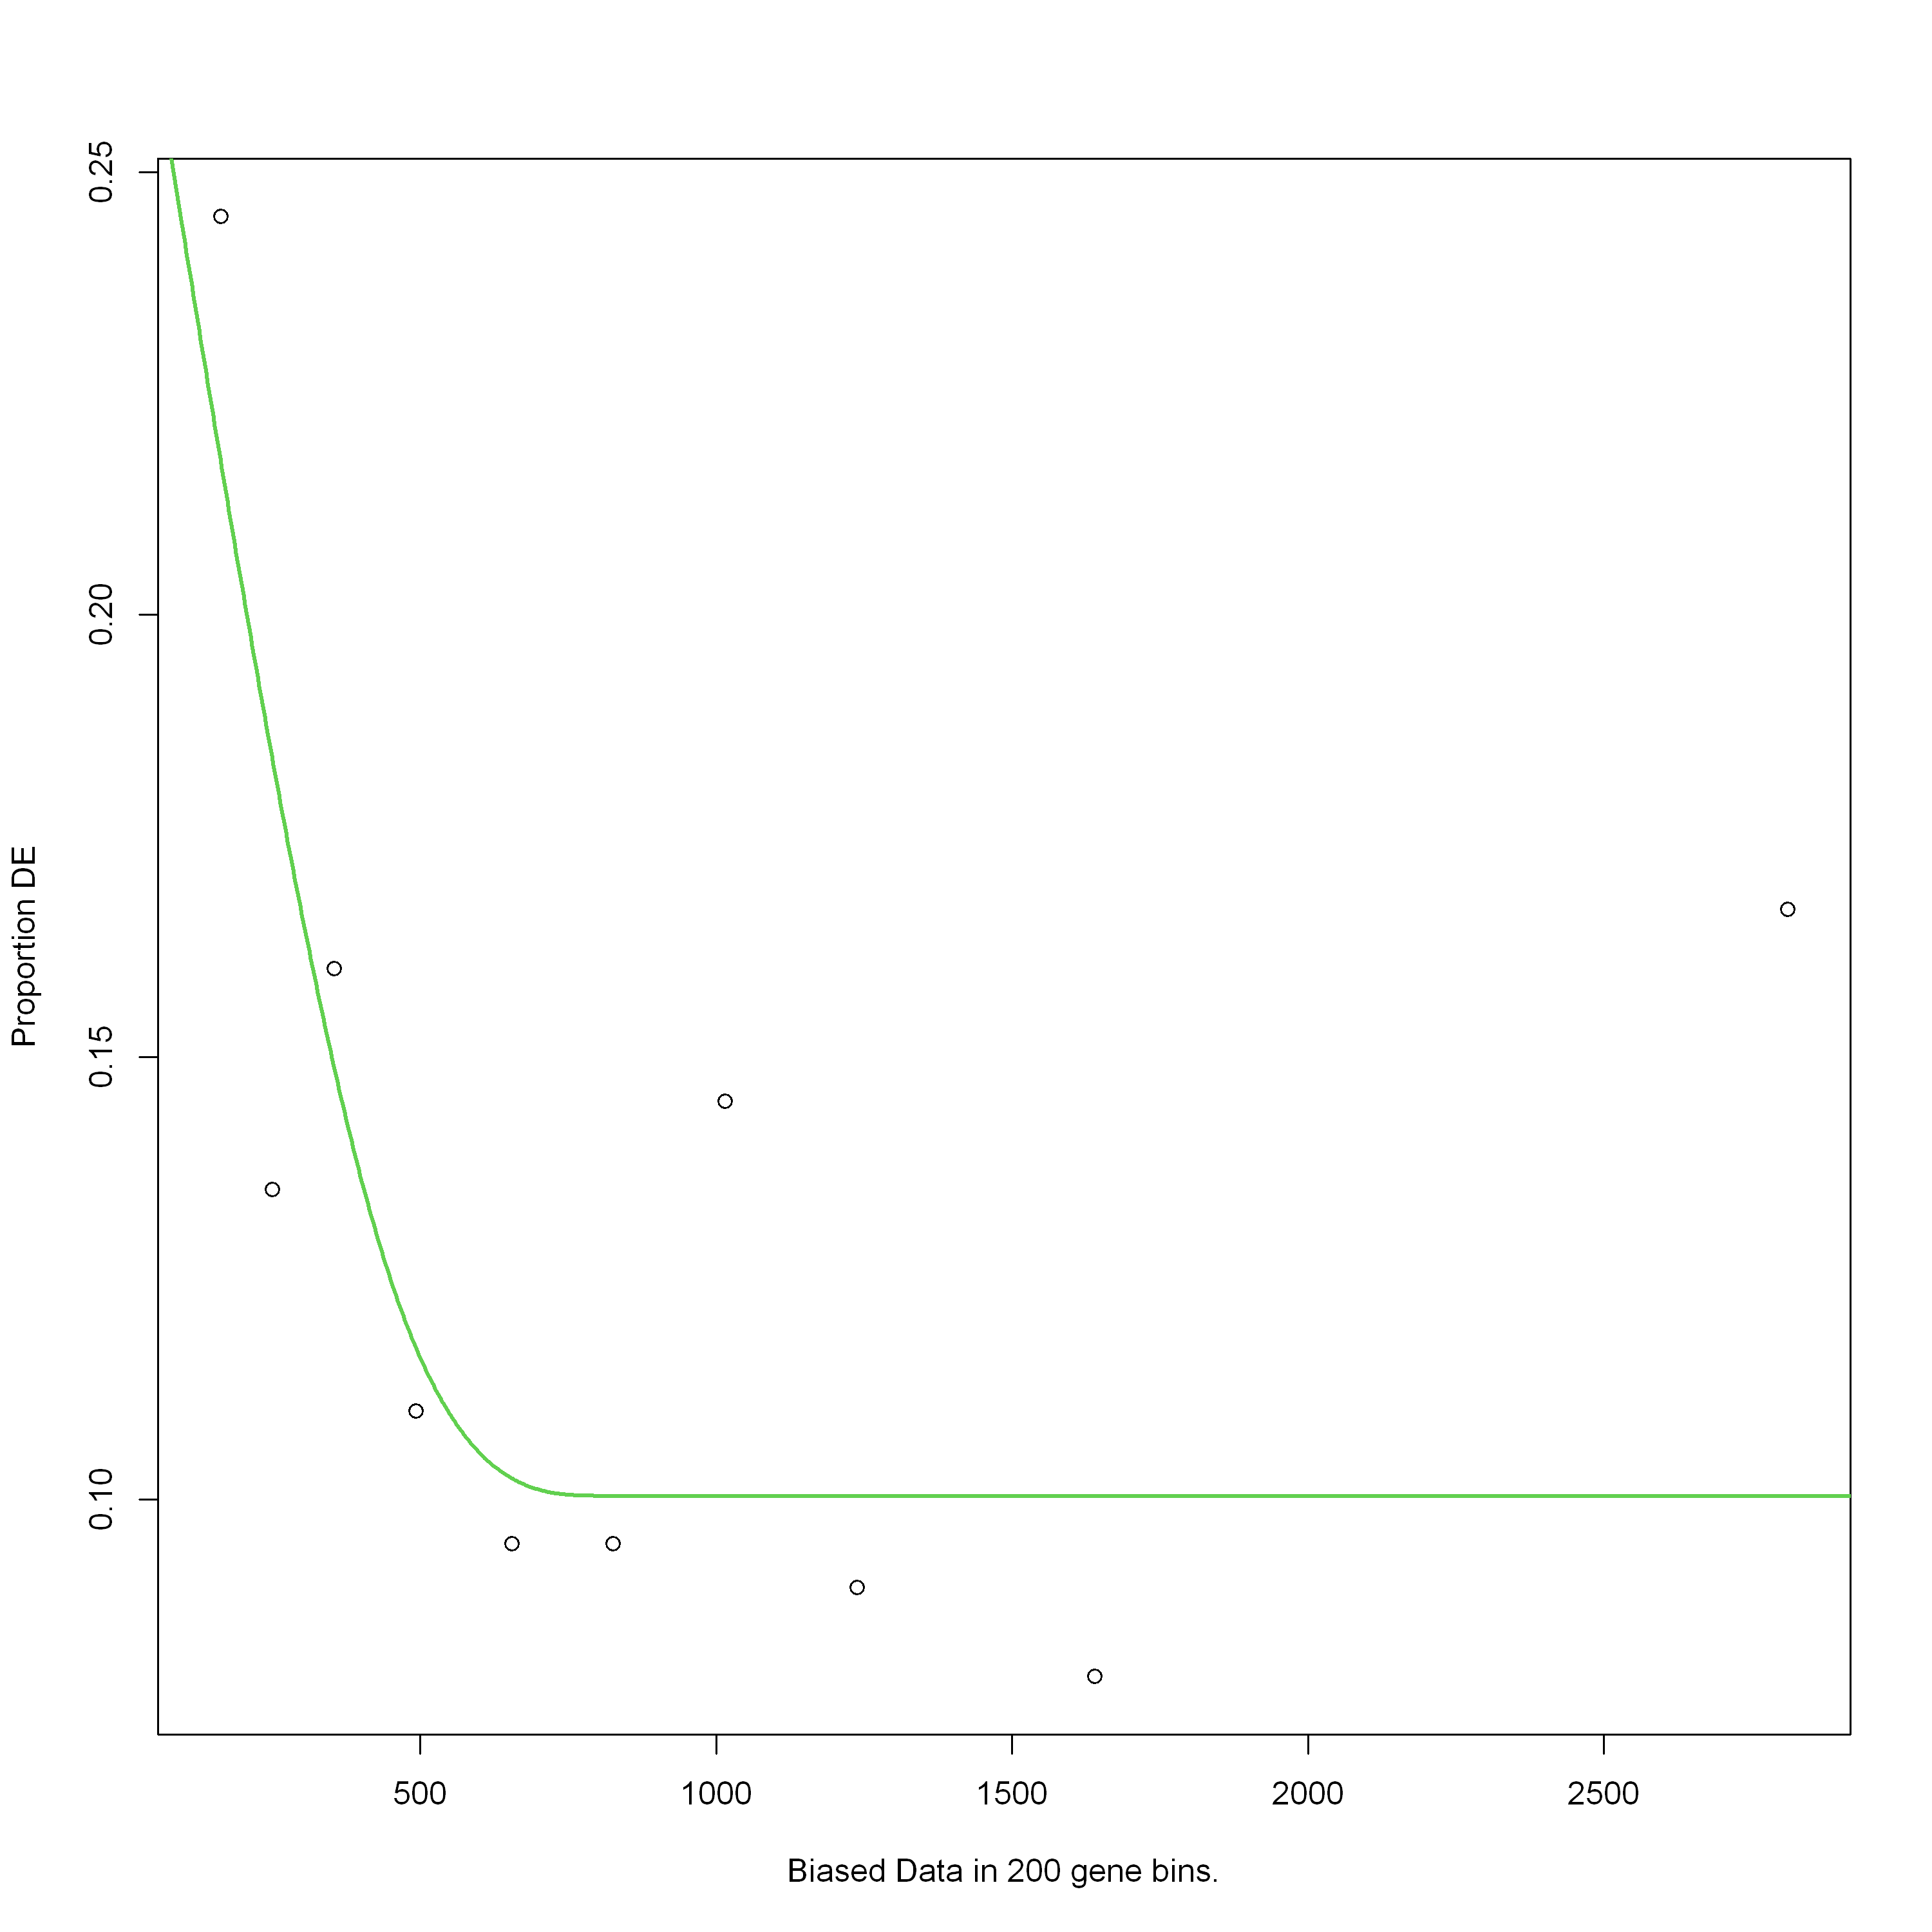

Using manually entered categories.

For 105 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



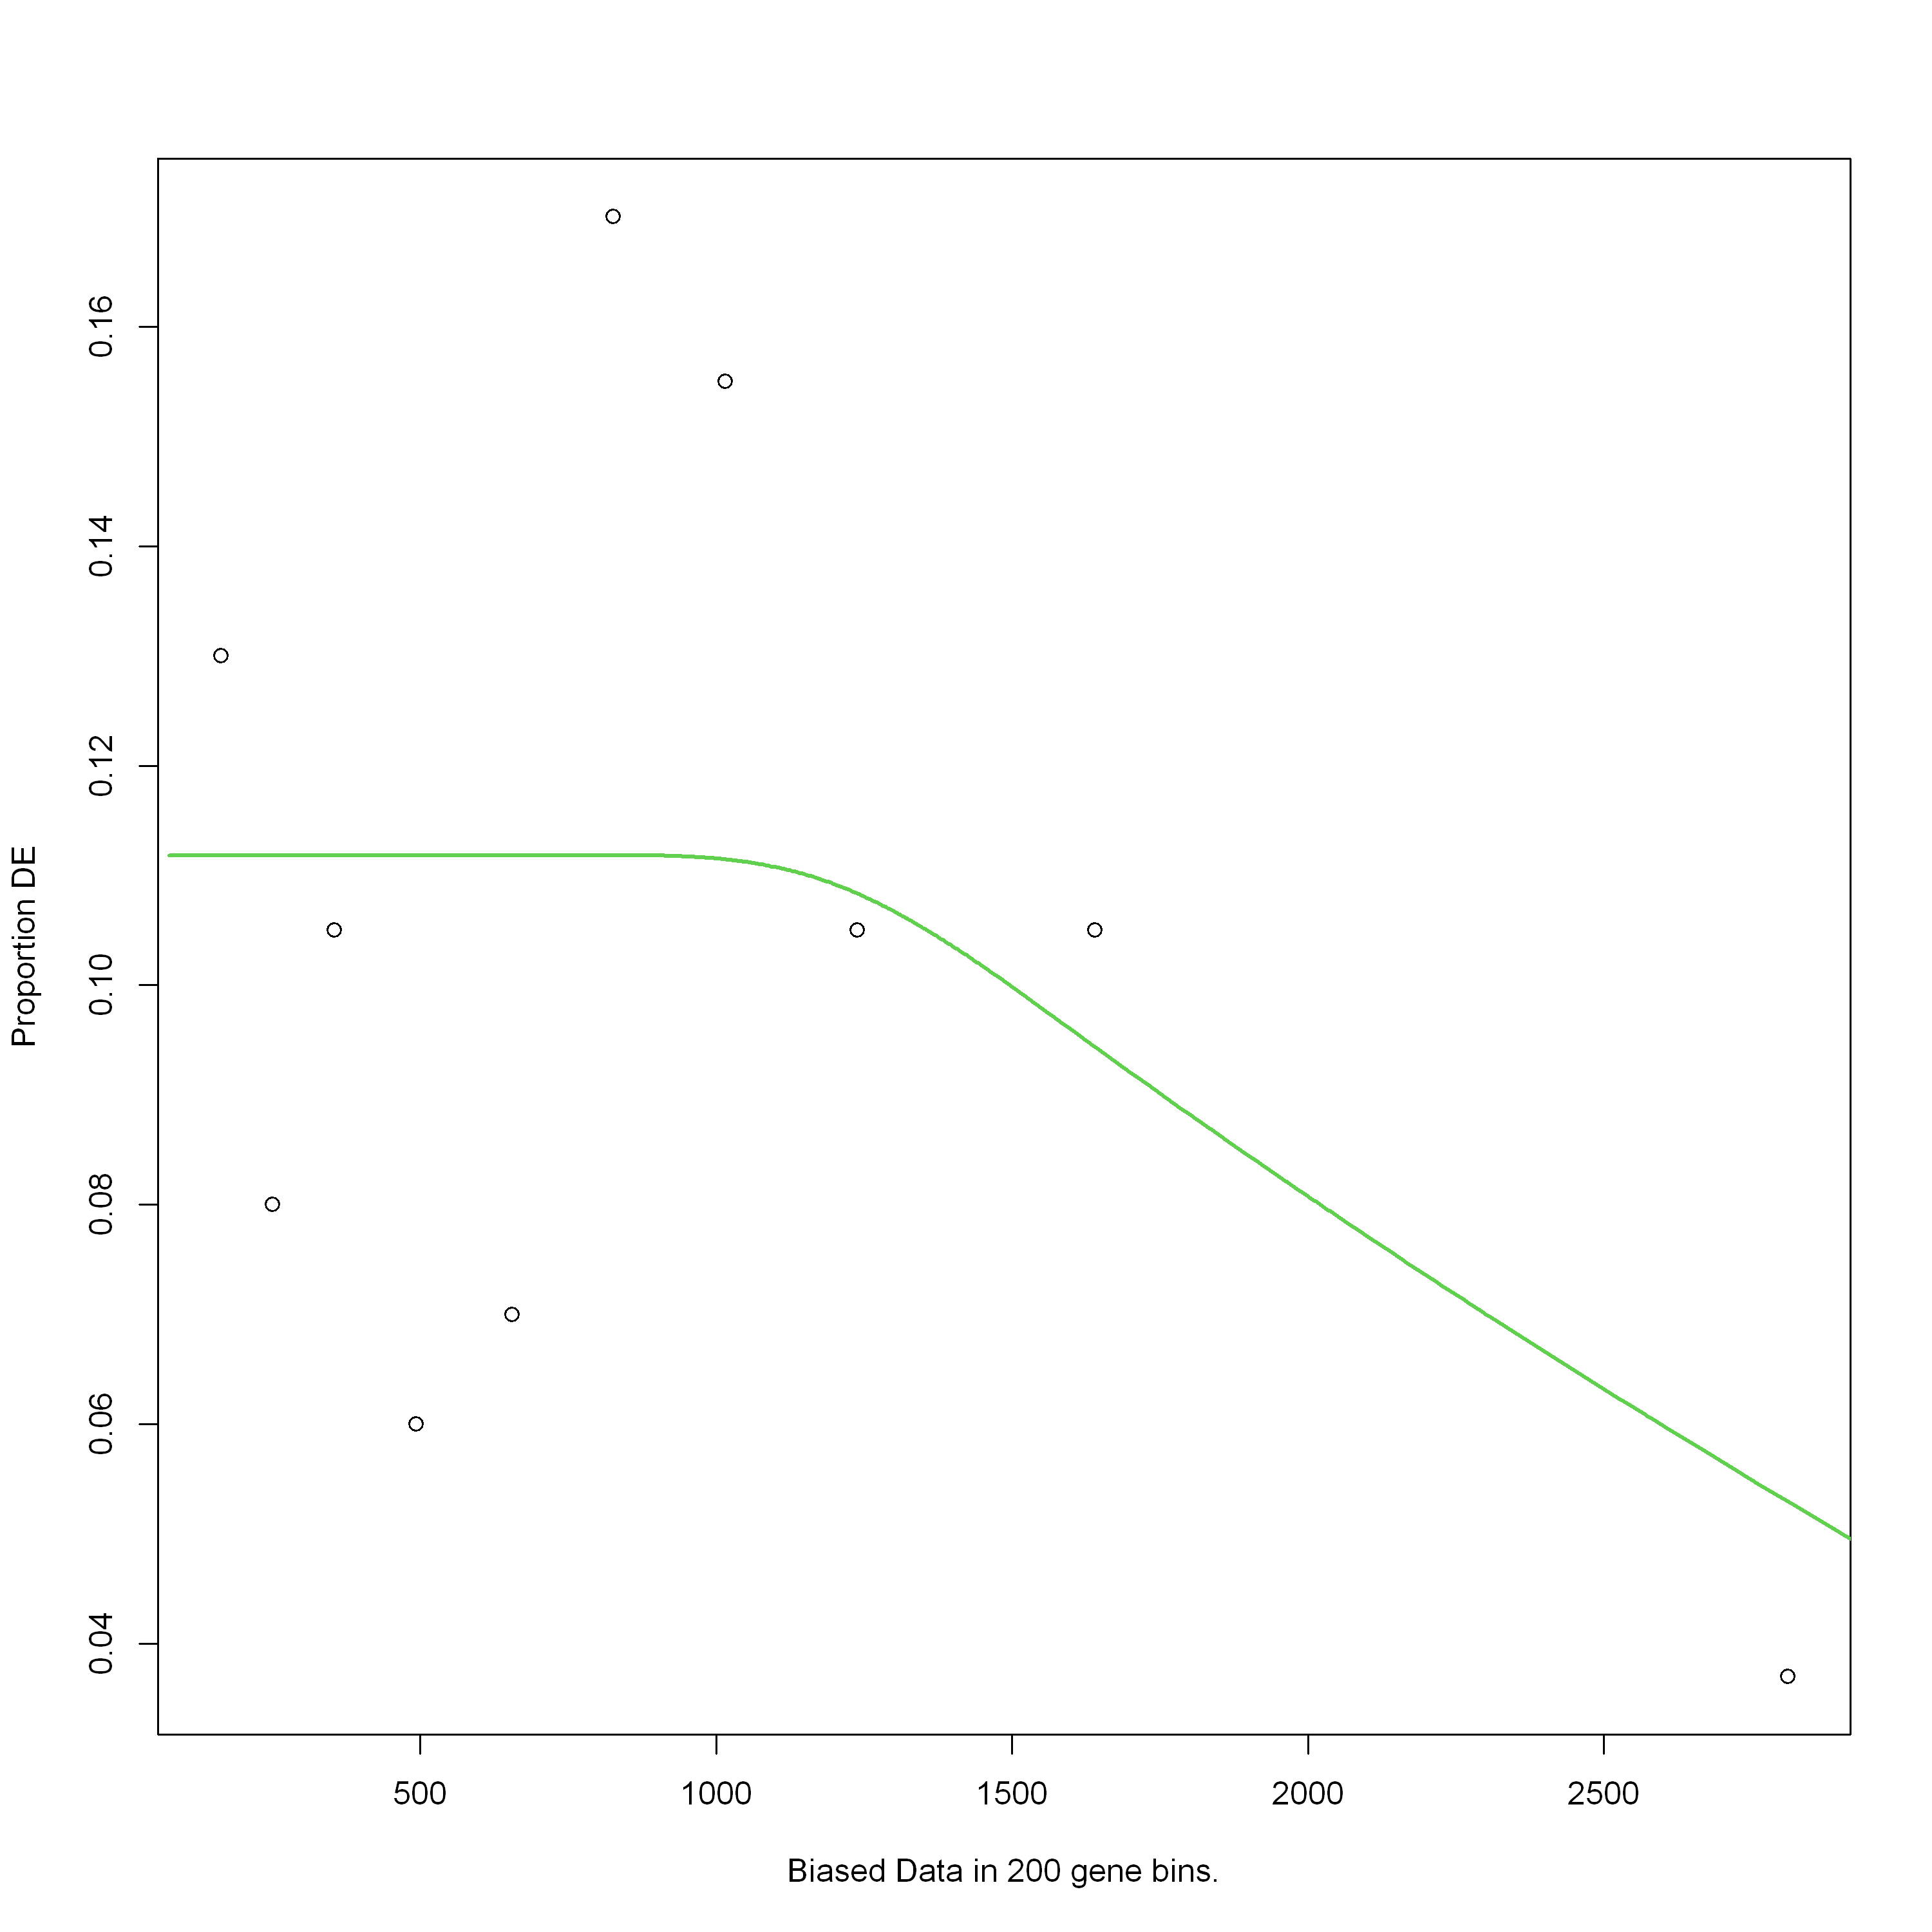

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


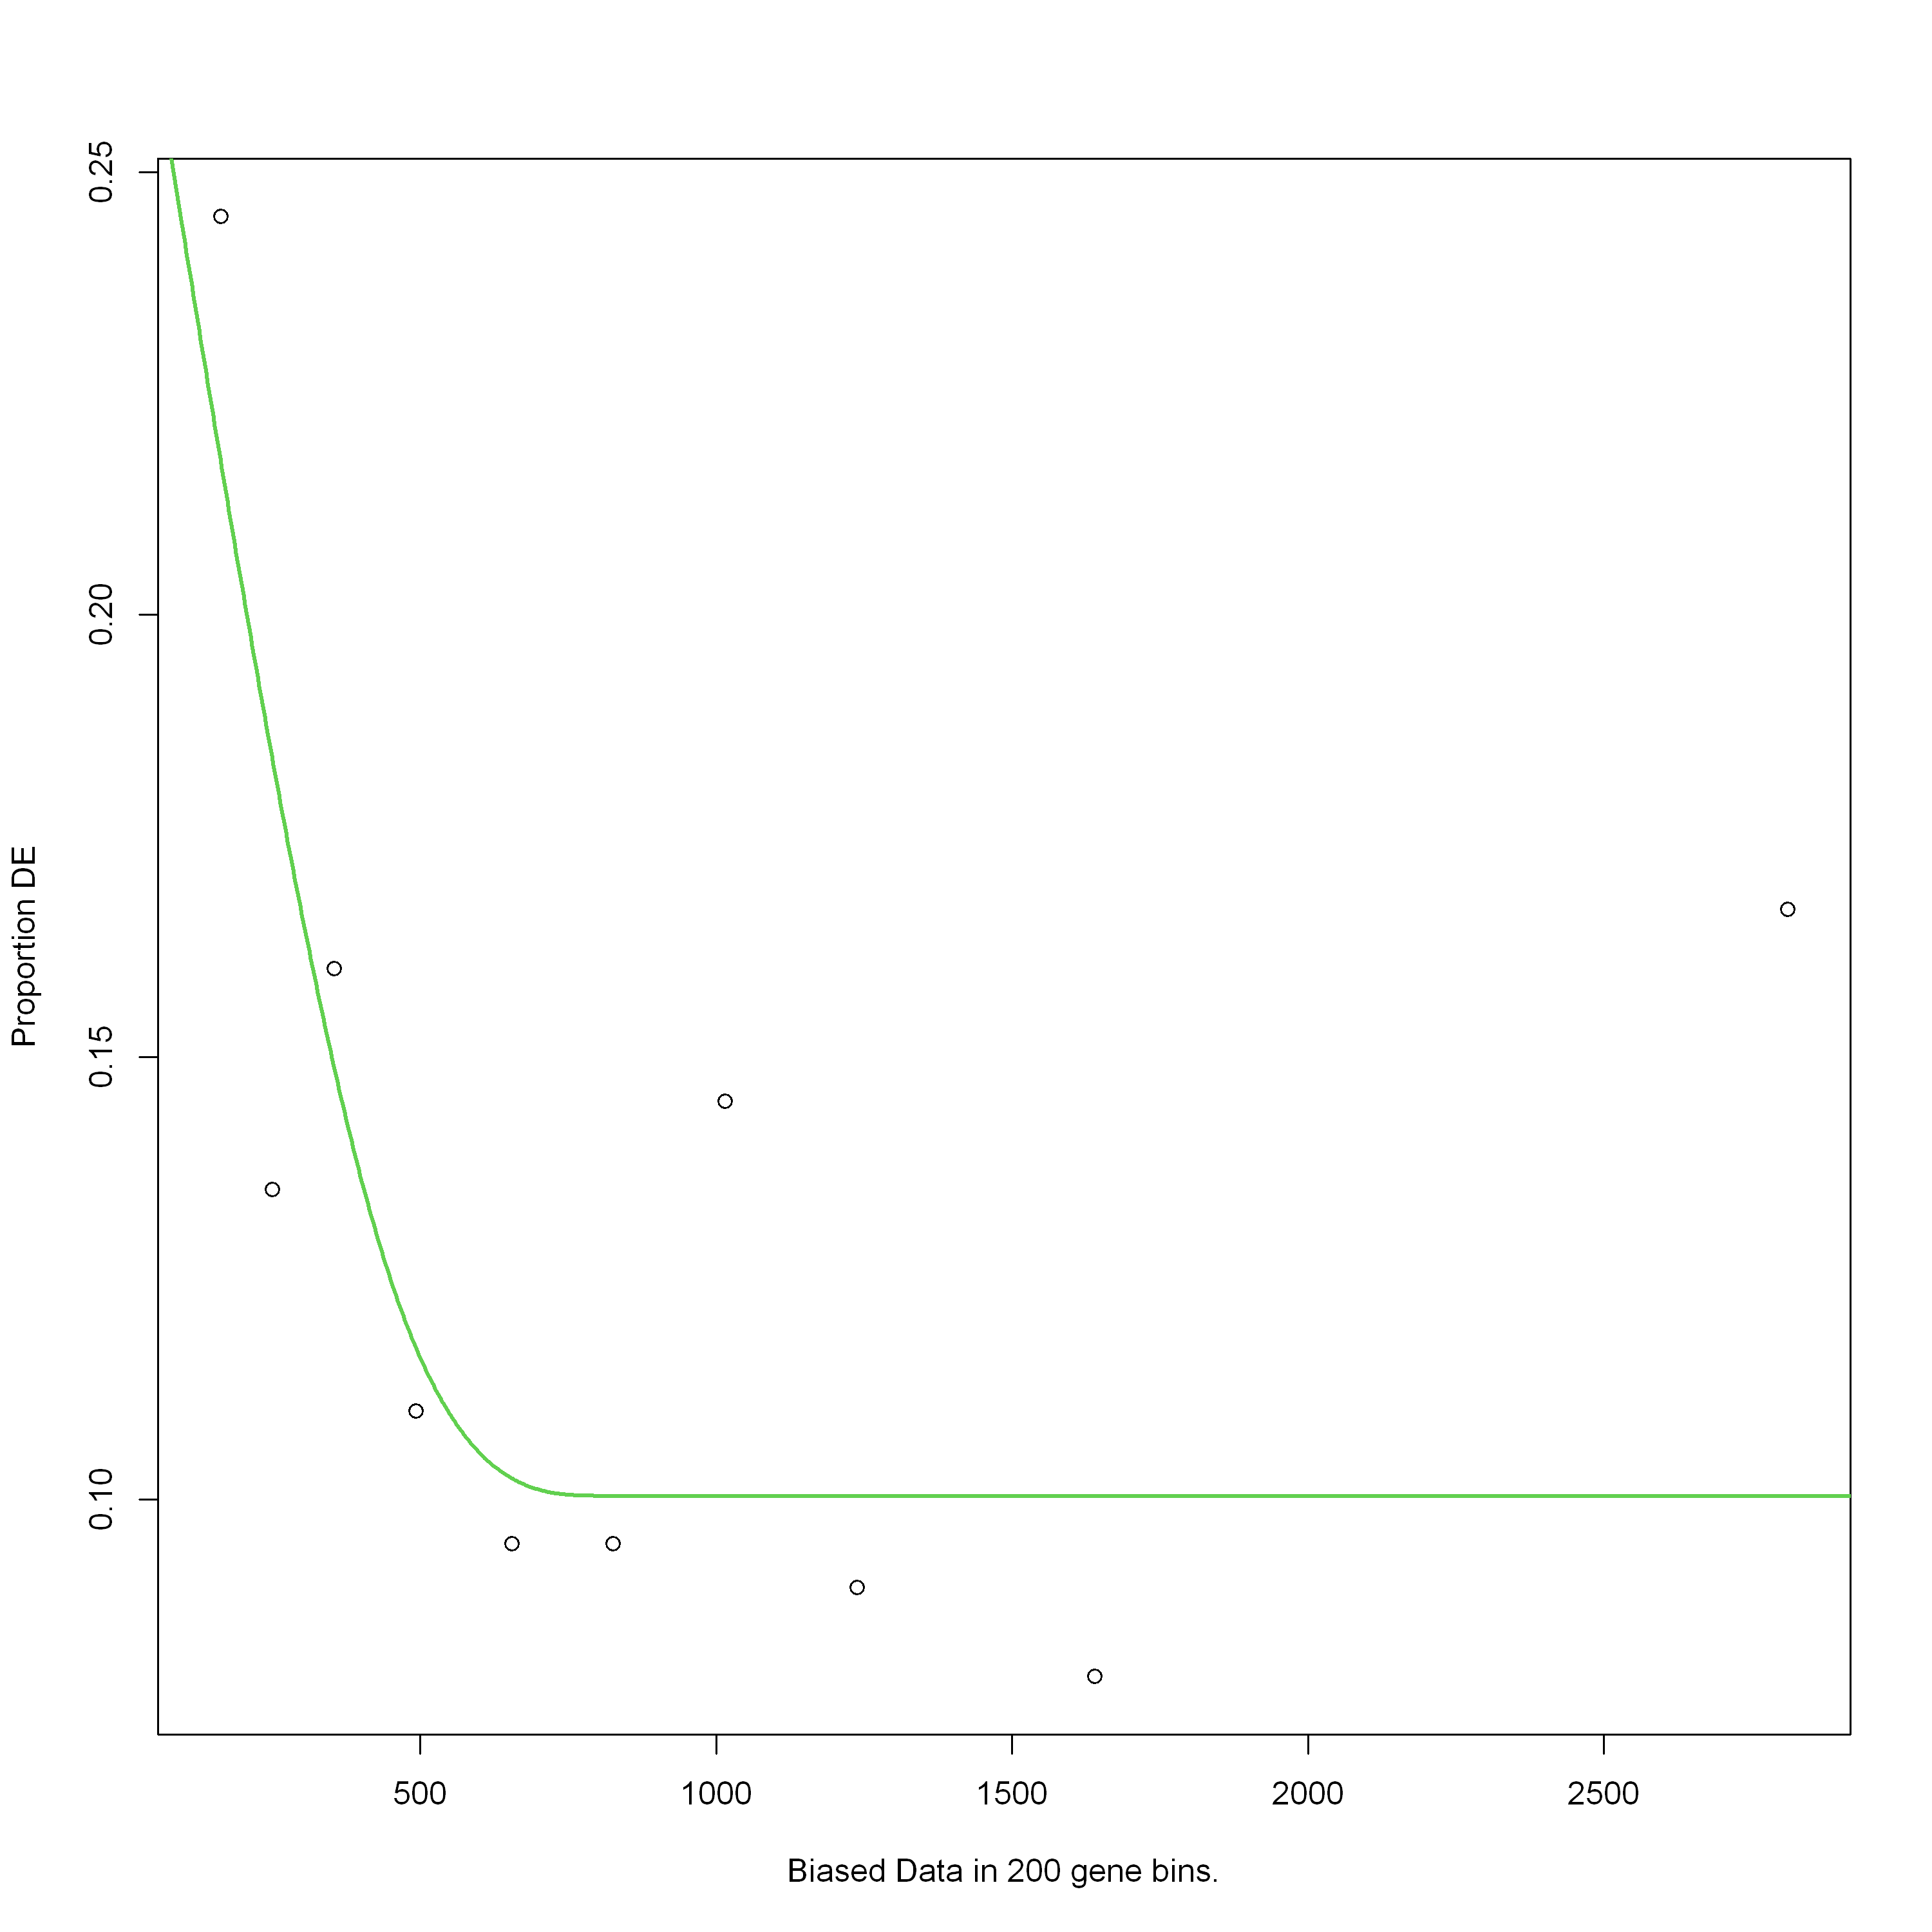

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



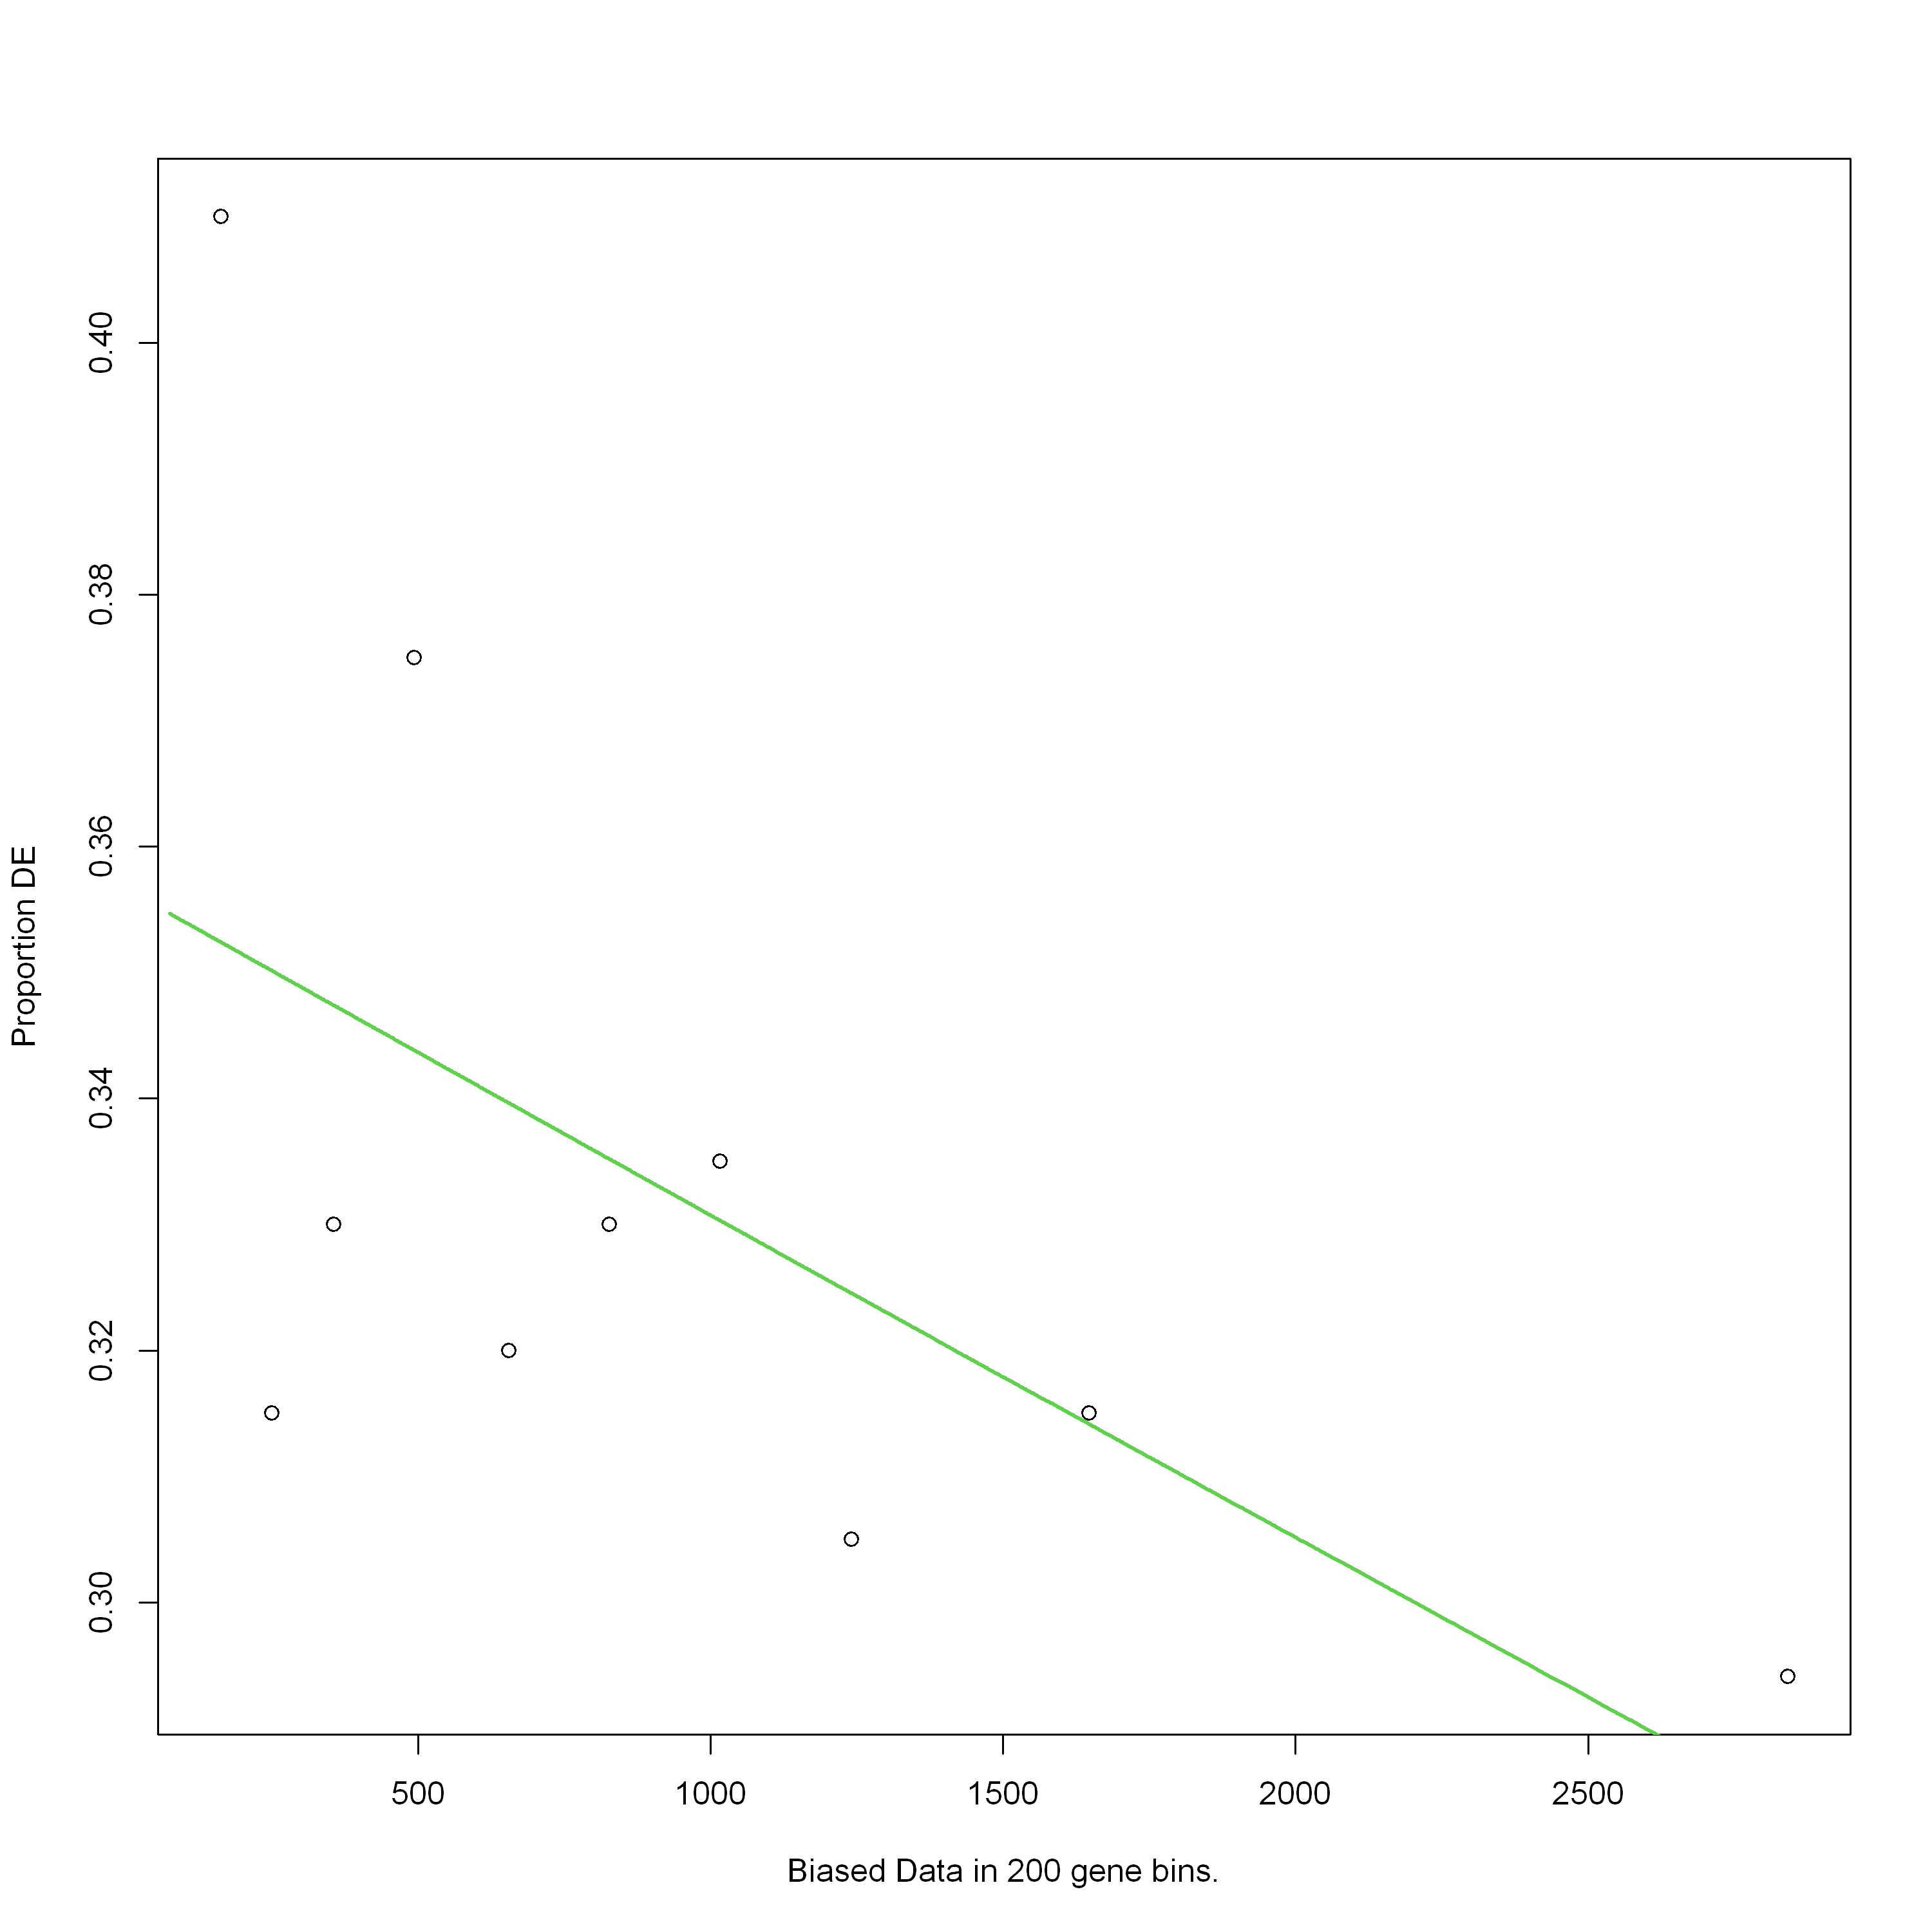

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


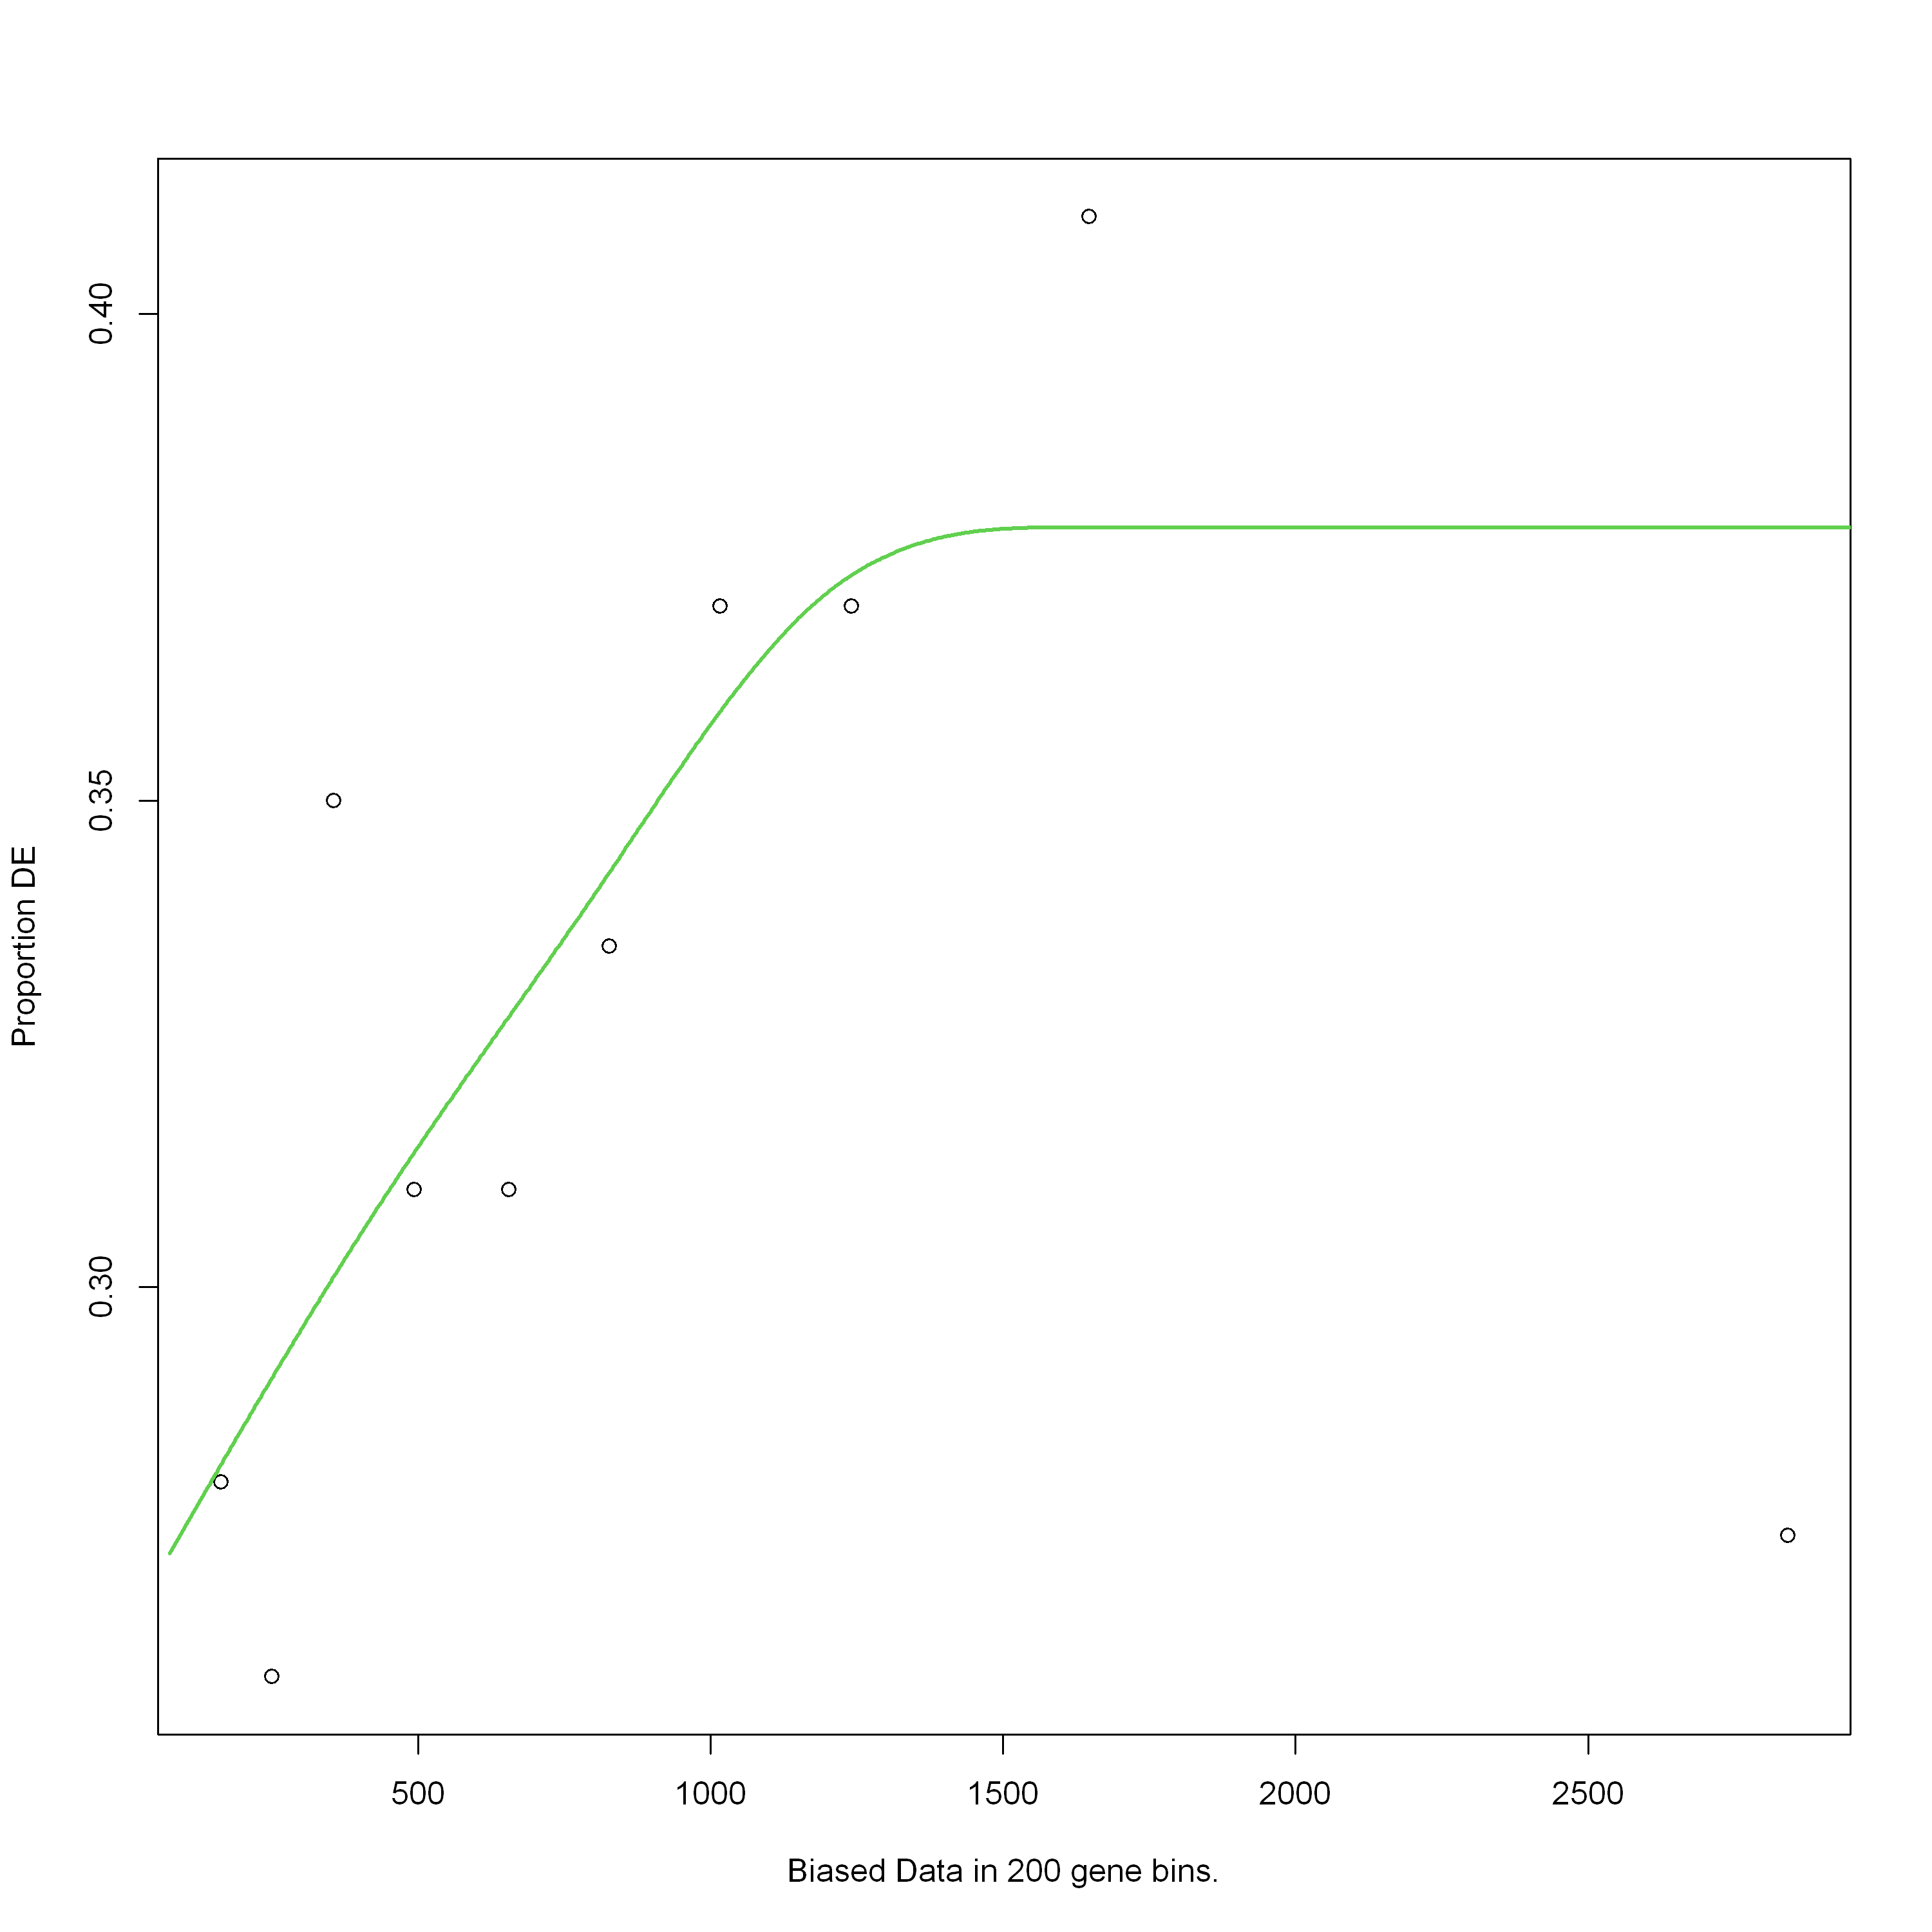

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


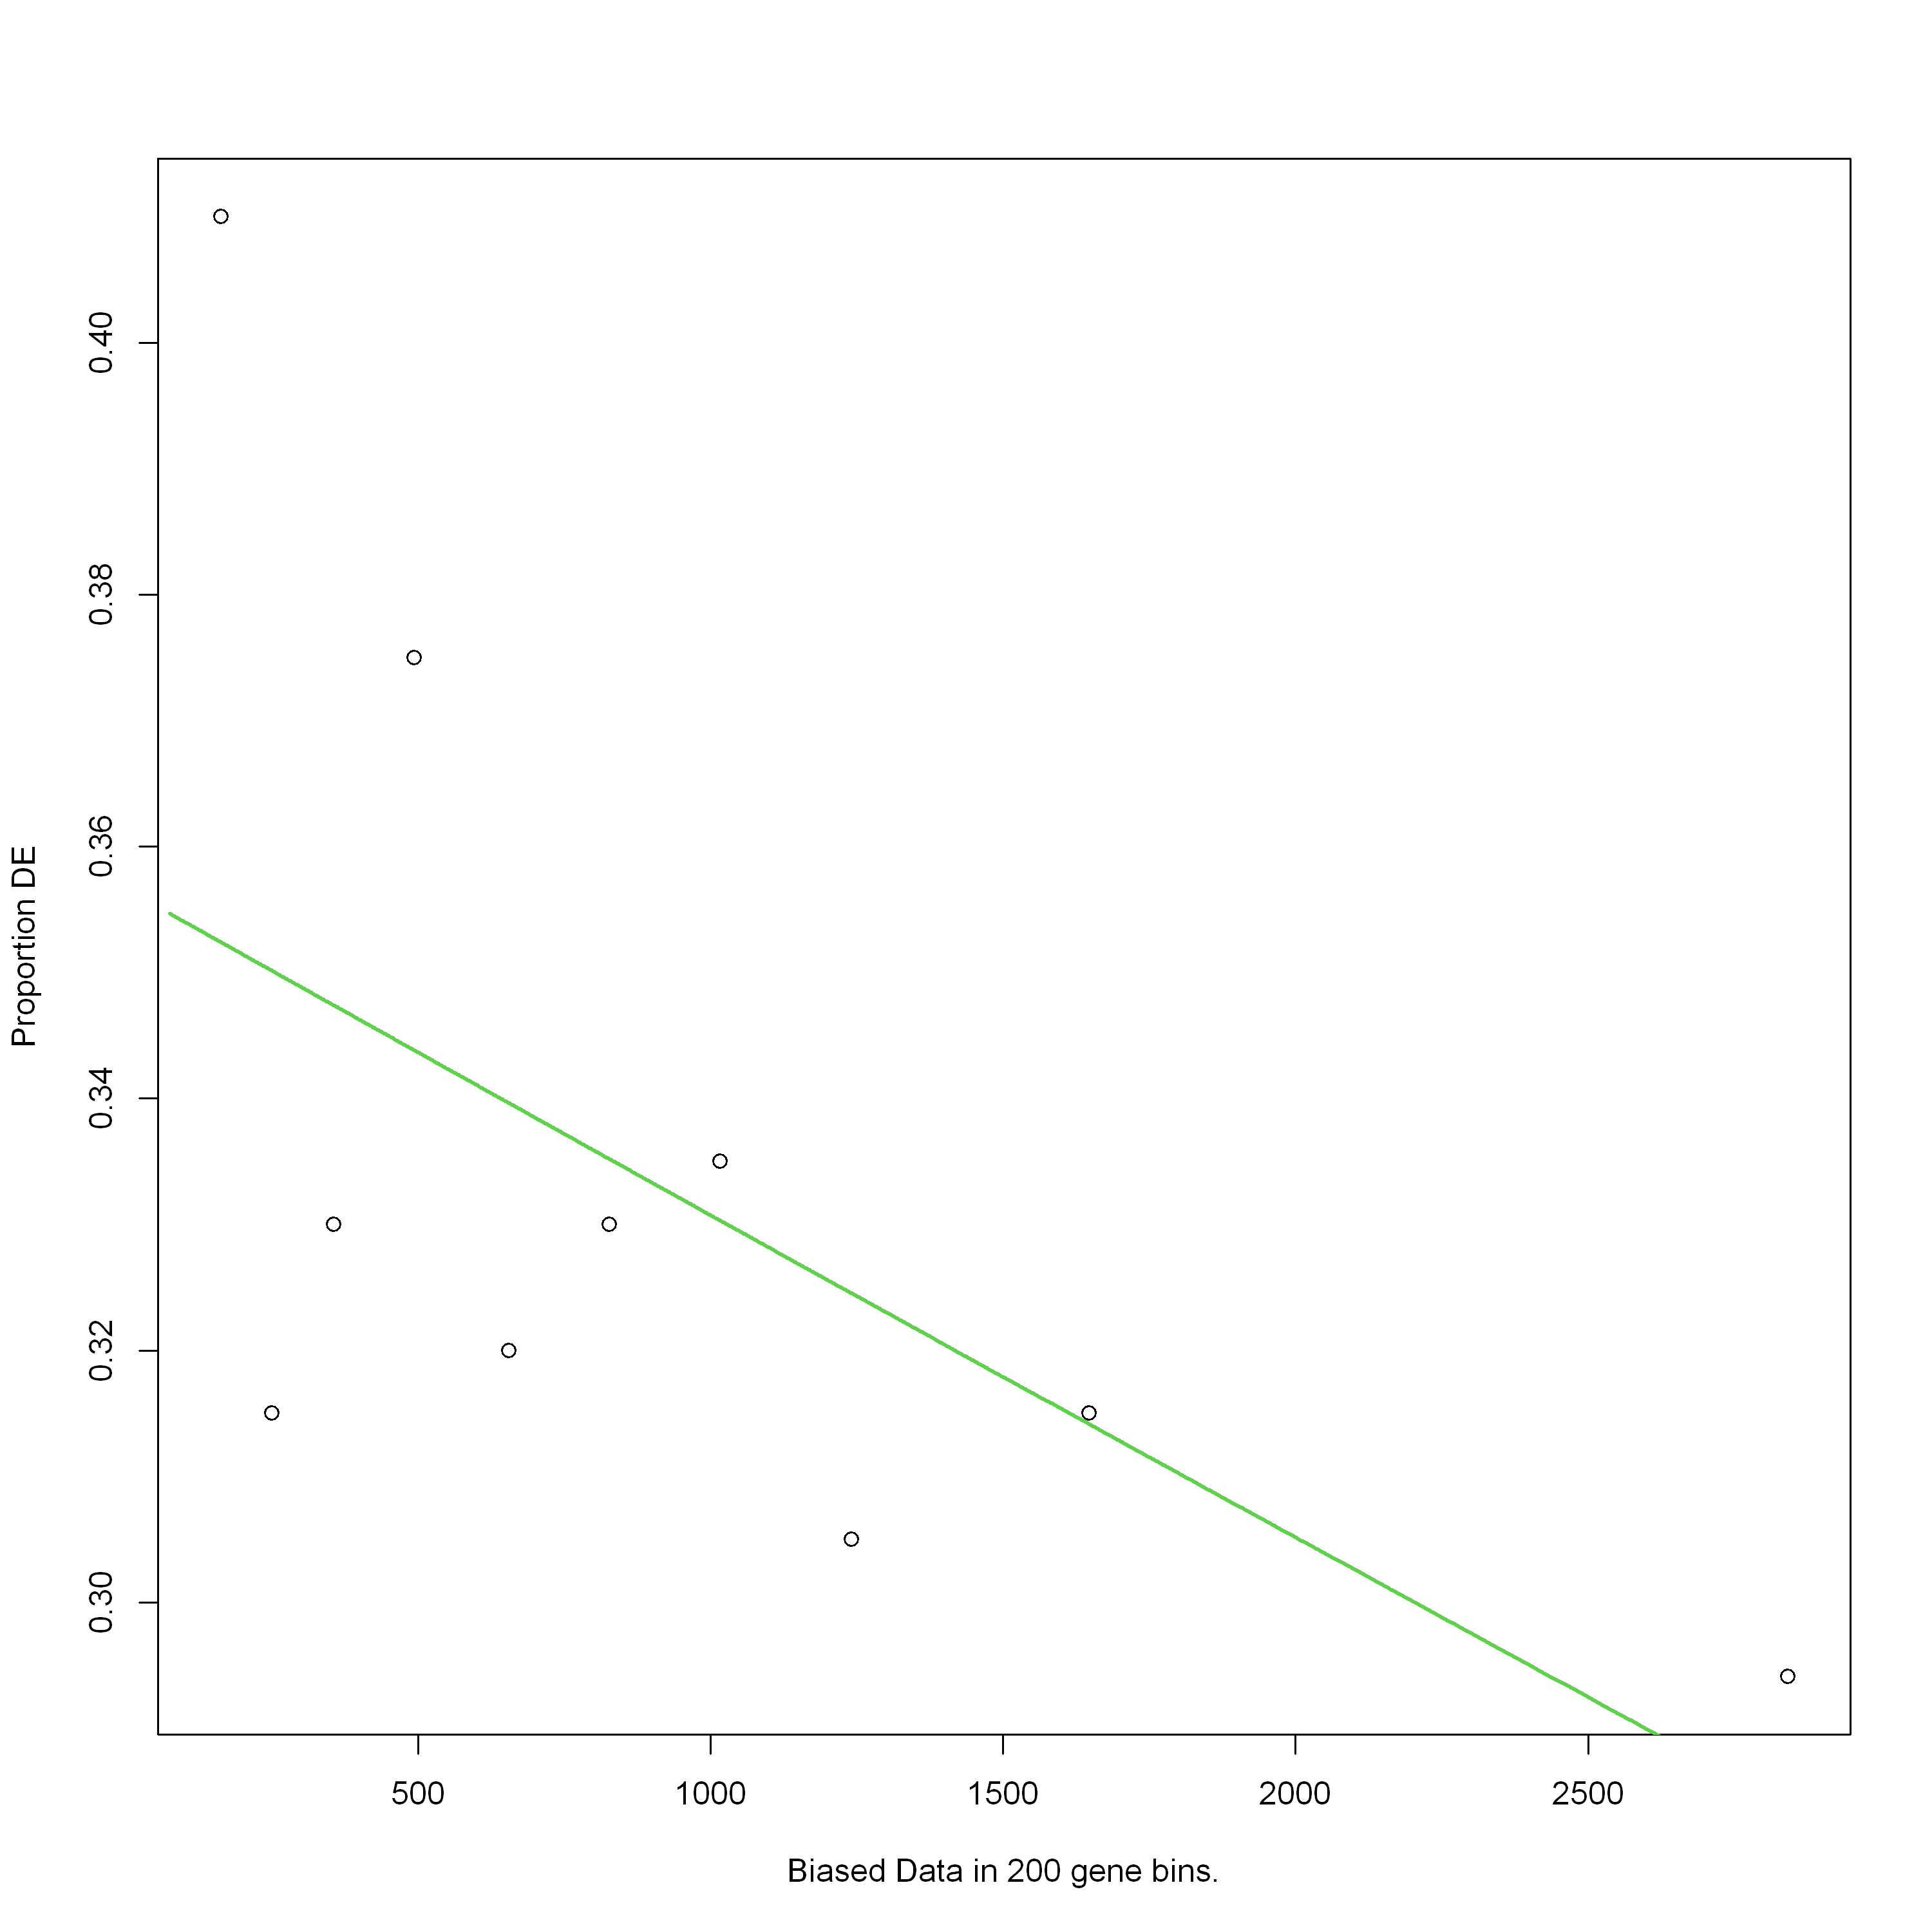

Using manually entered categories.

For 49 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



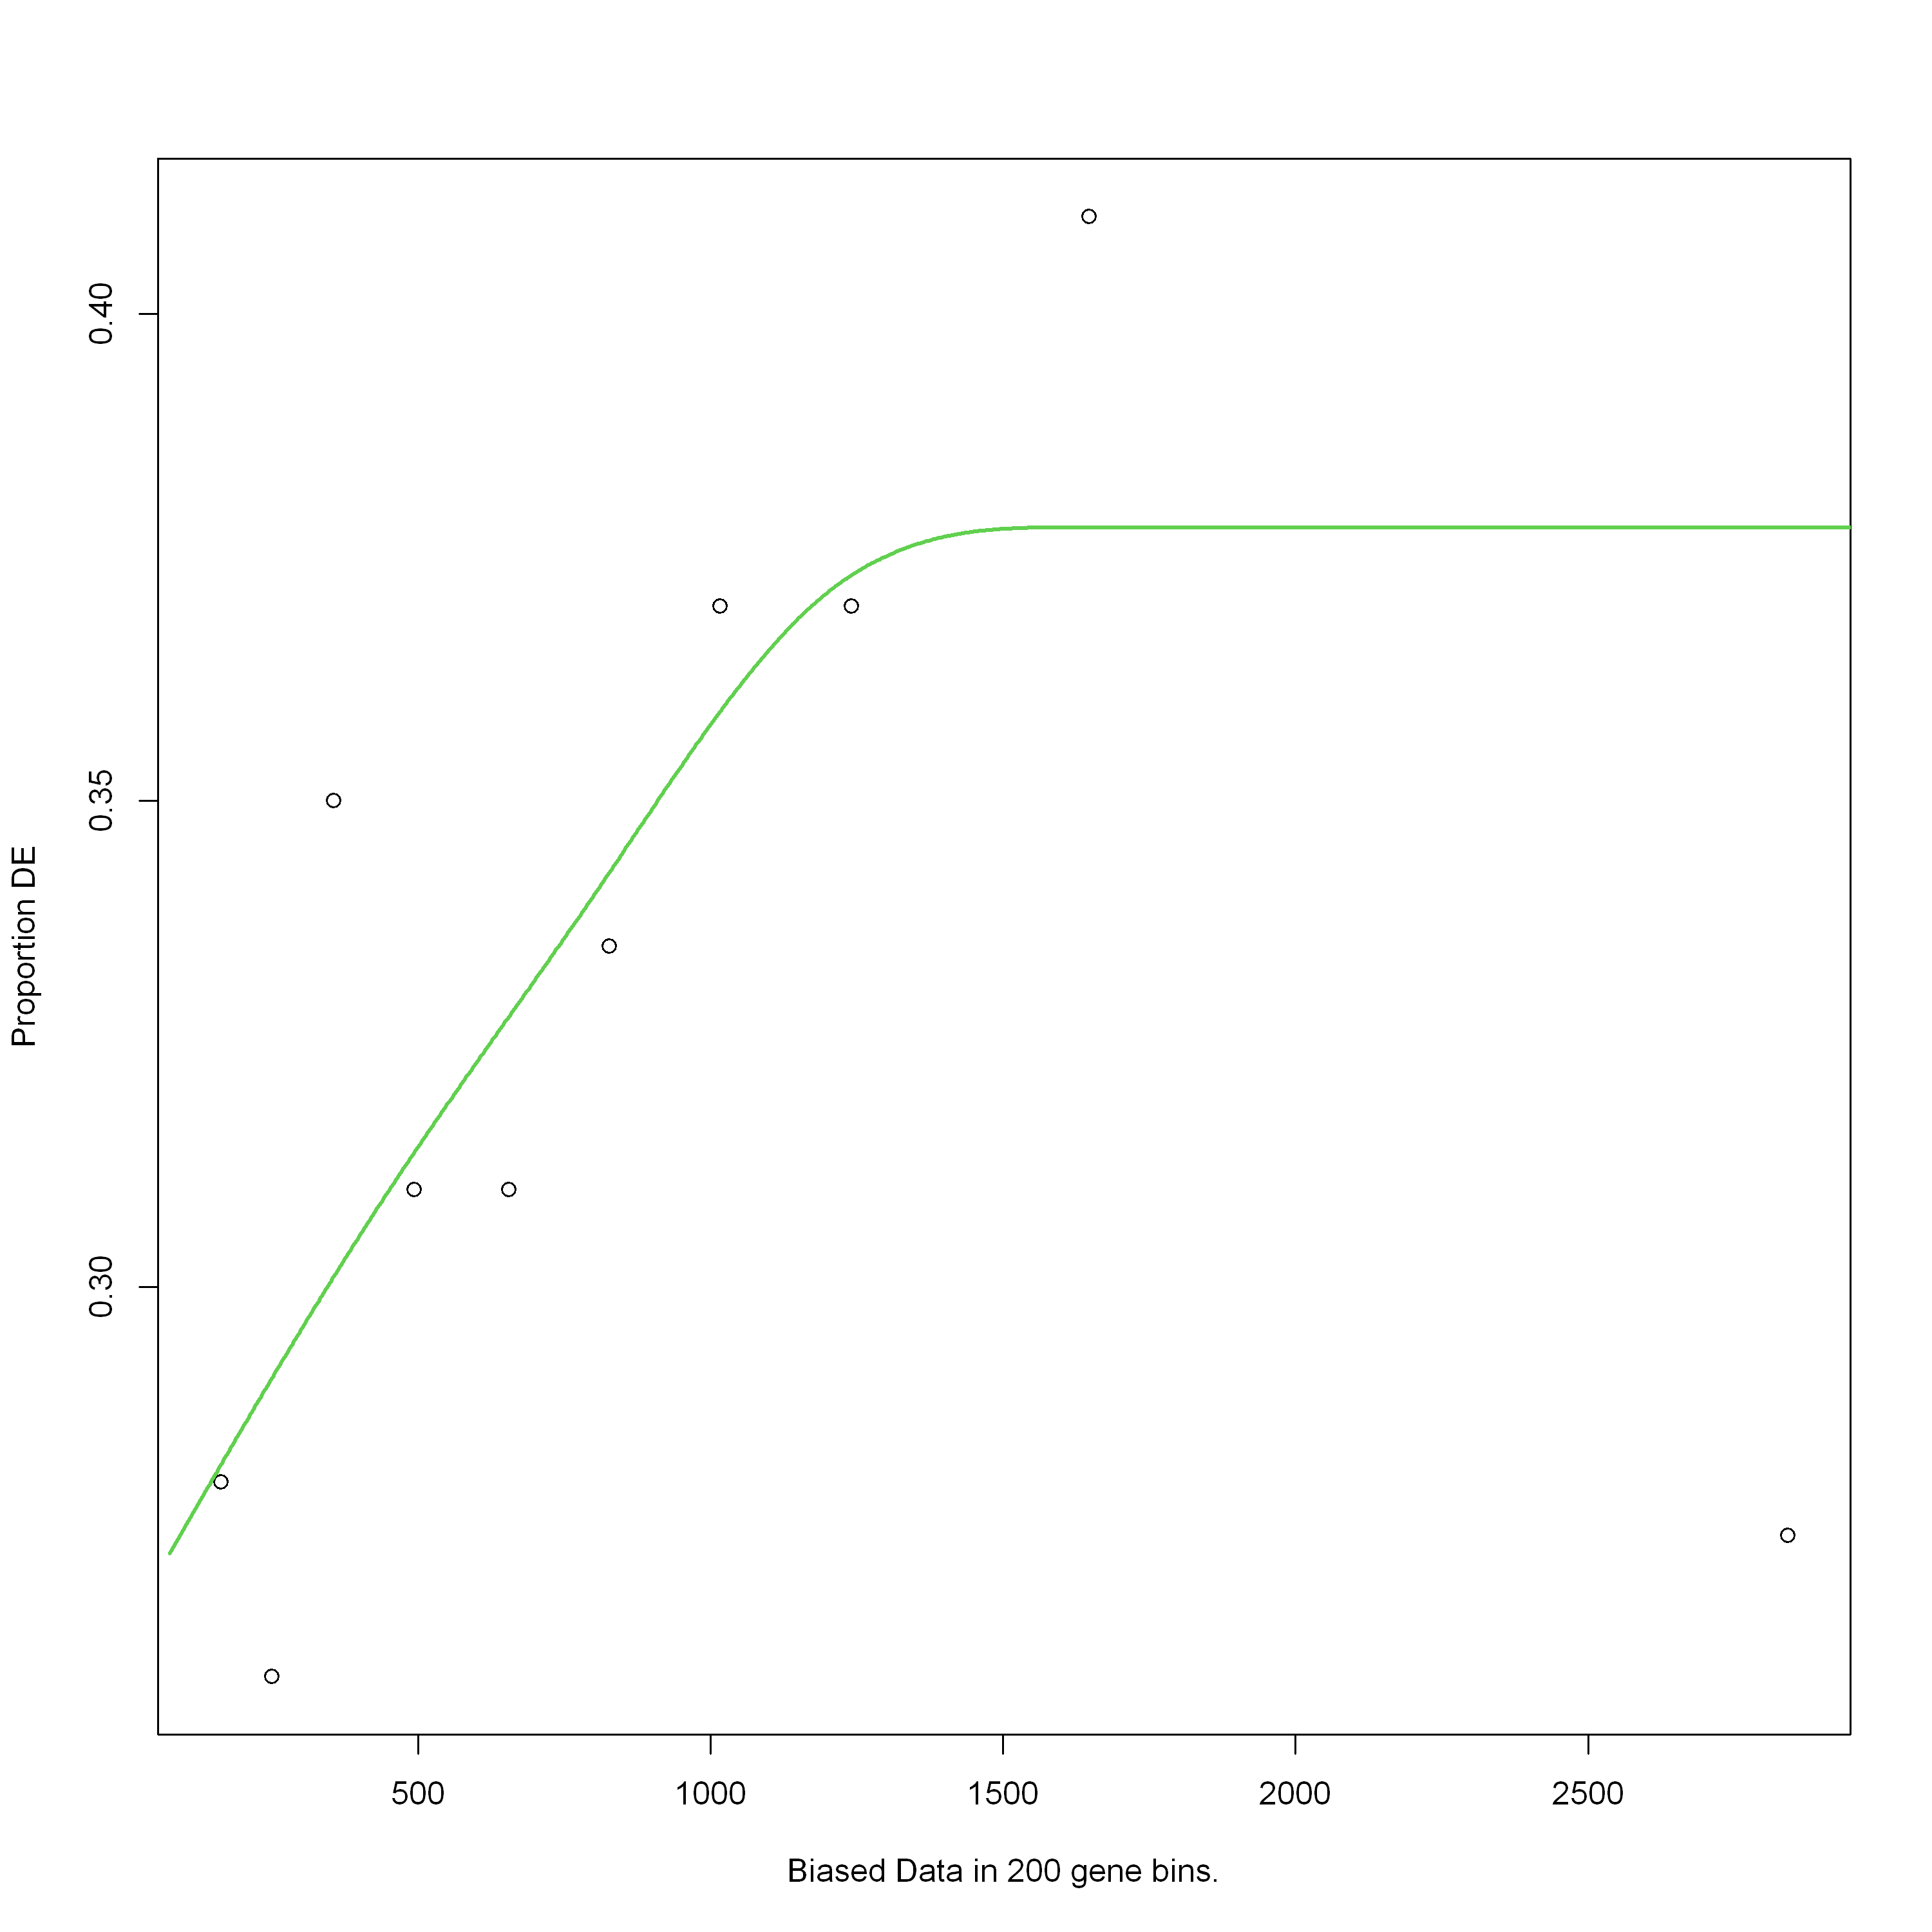

Using manually entered categories.

For 49 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


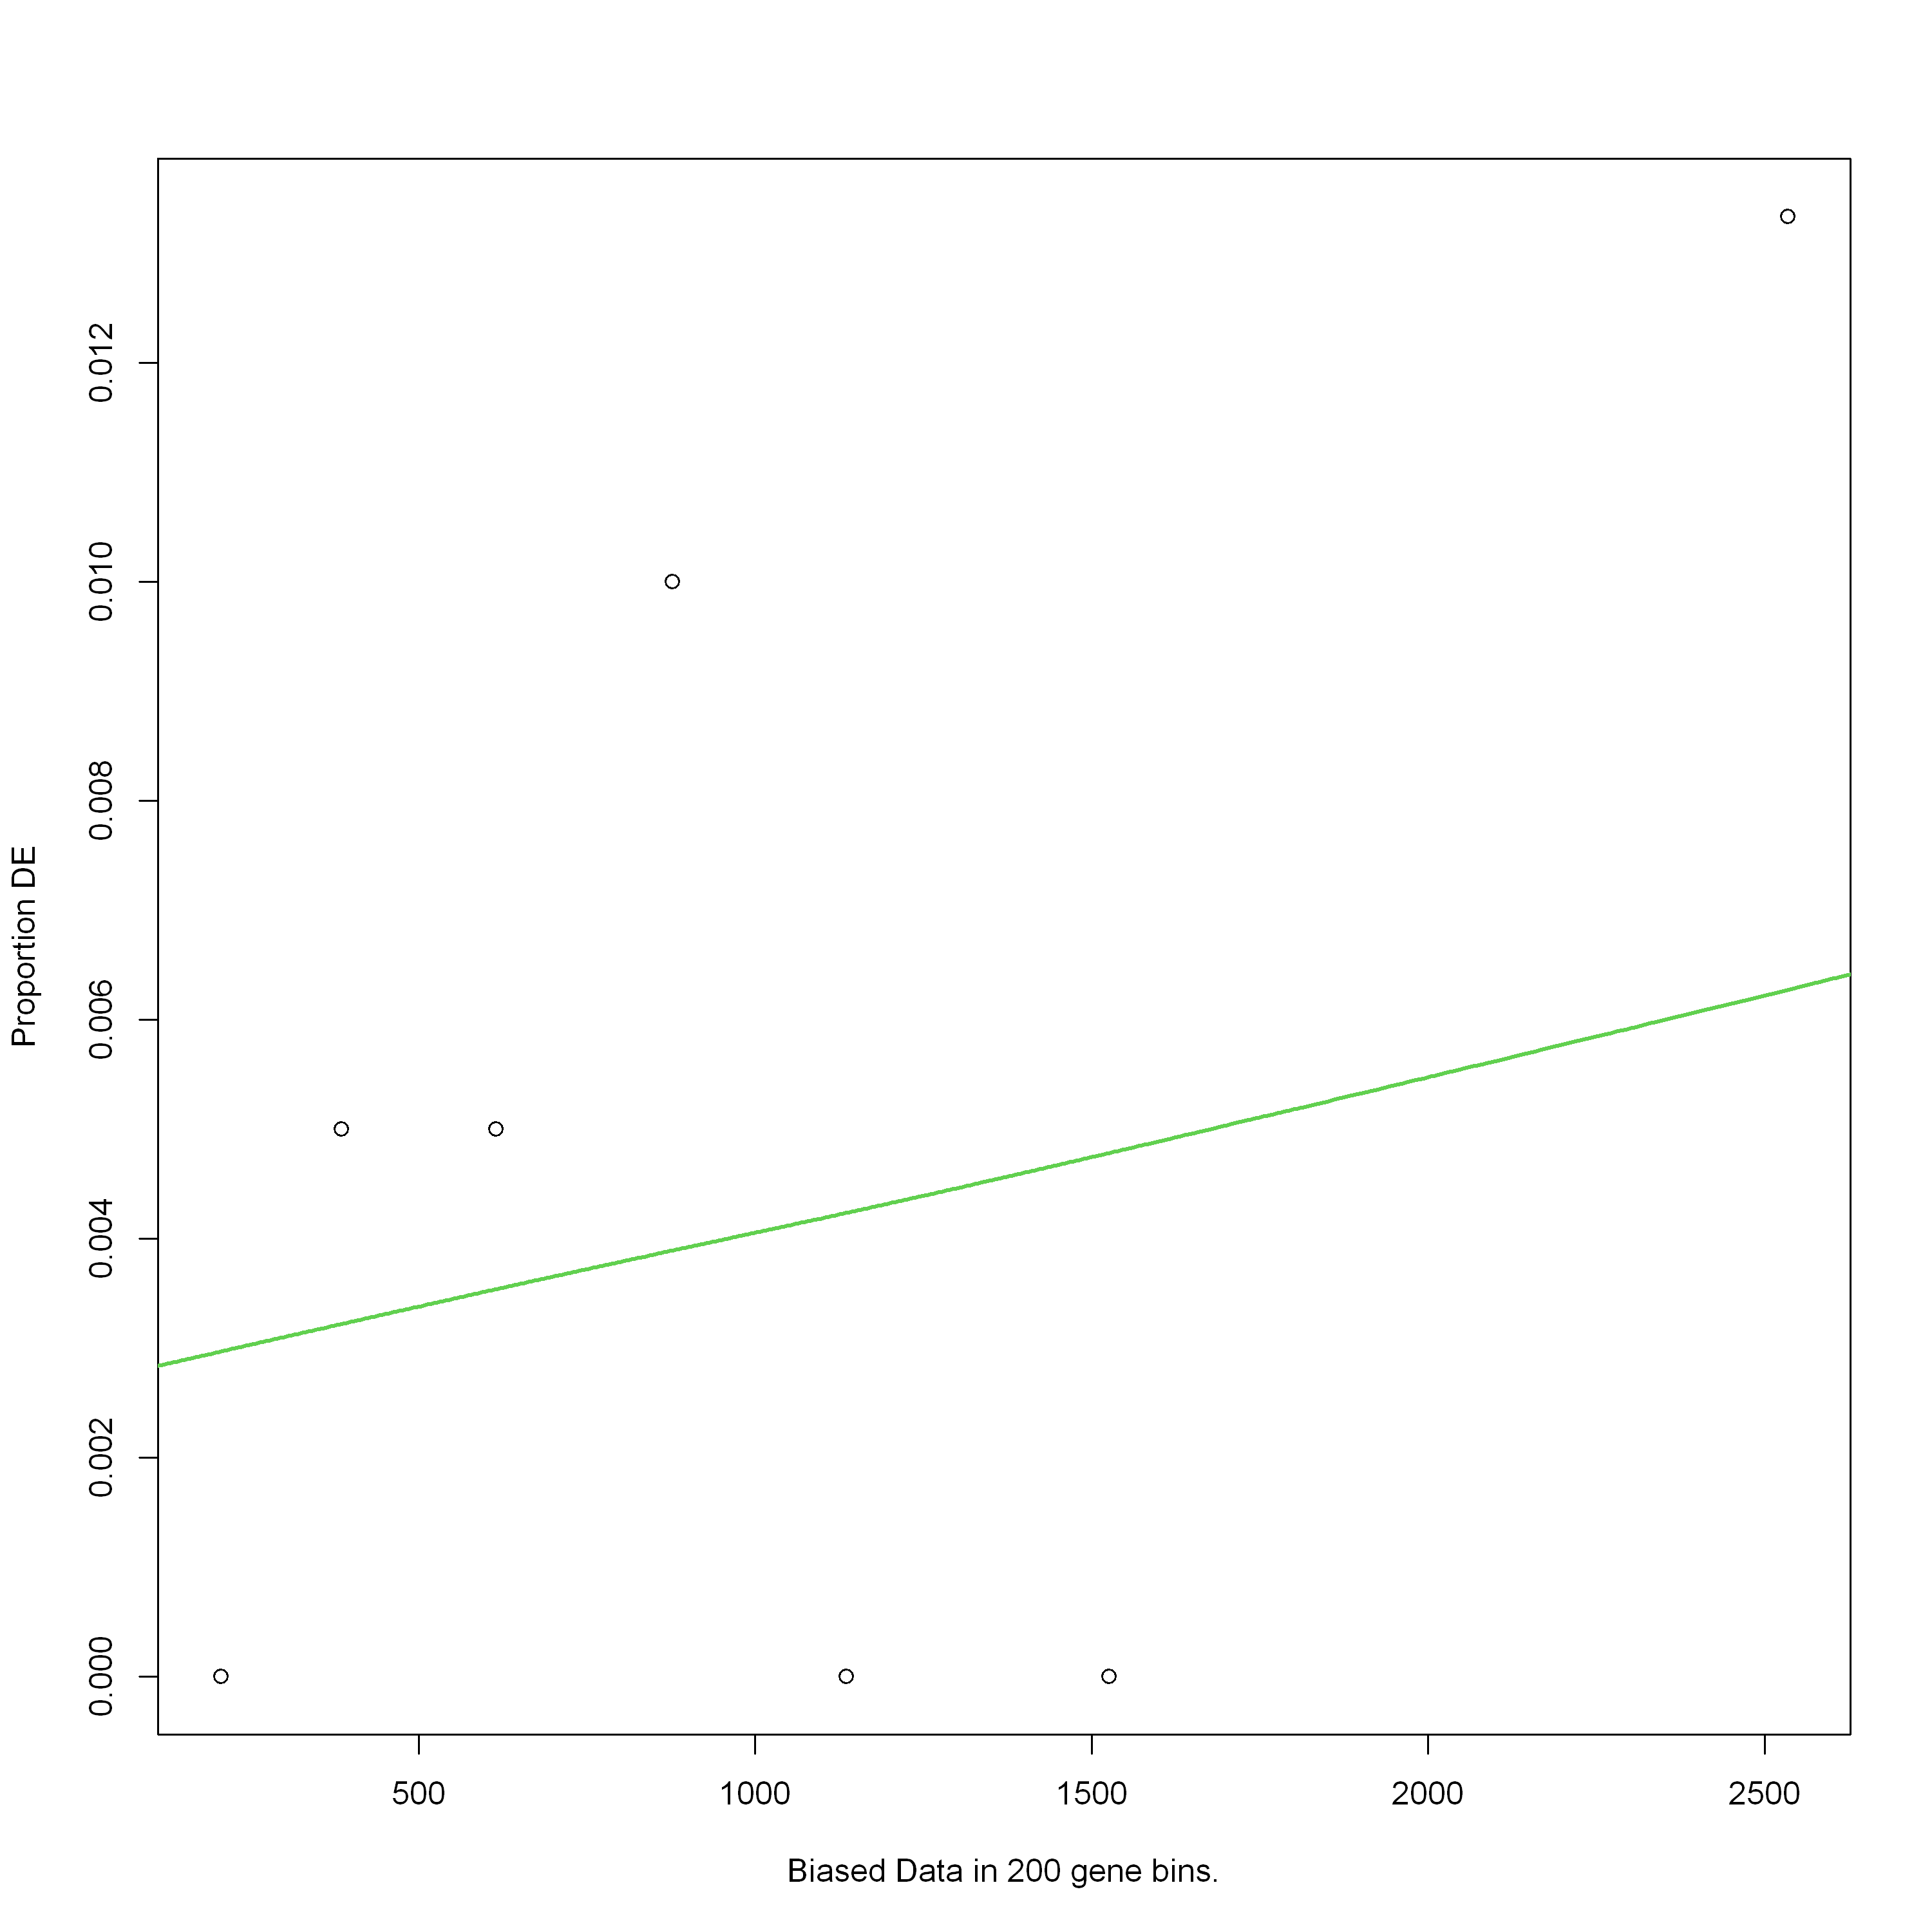

Using manually entered categories.

For 49 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



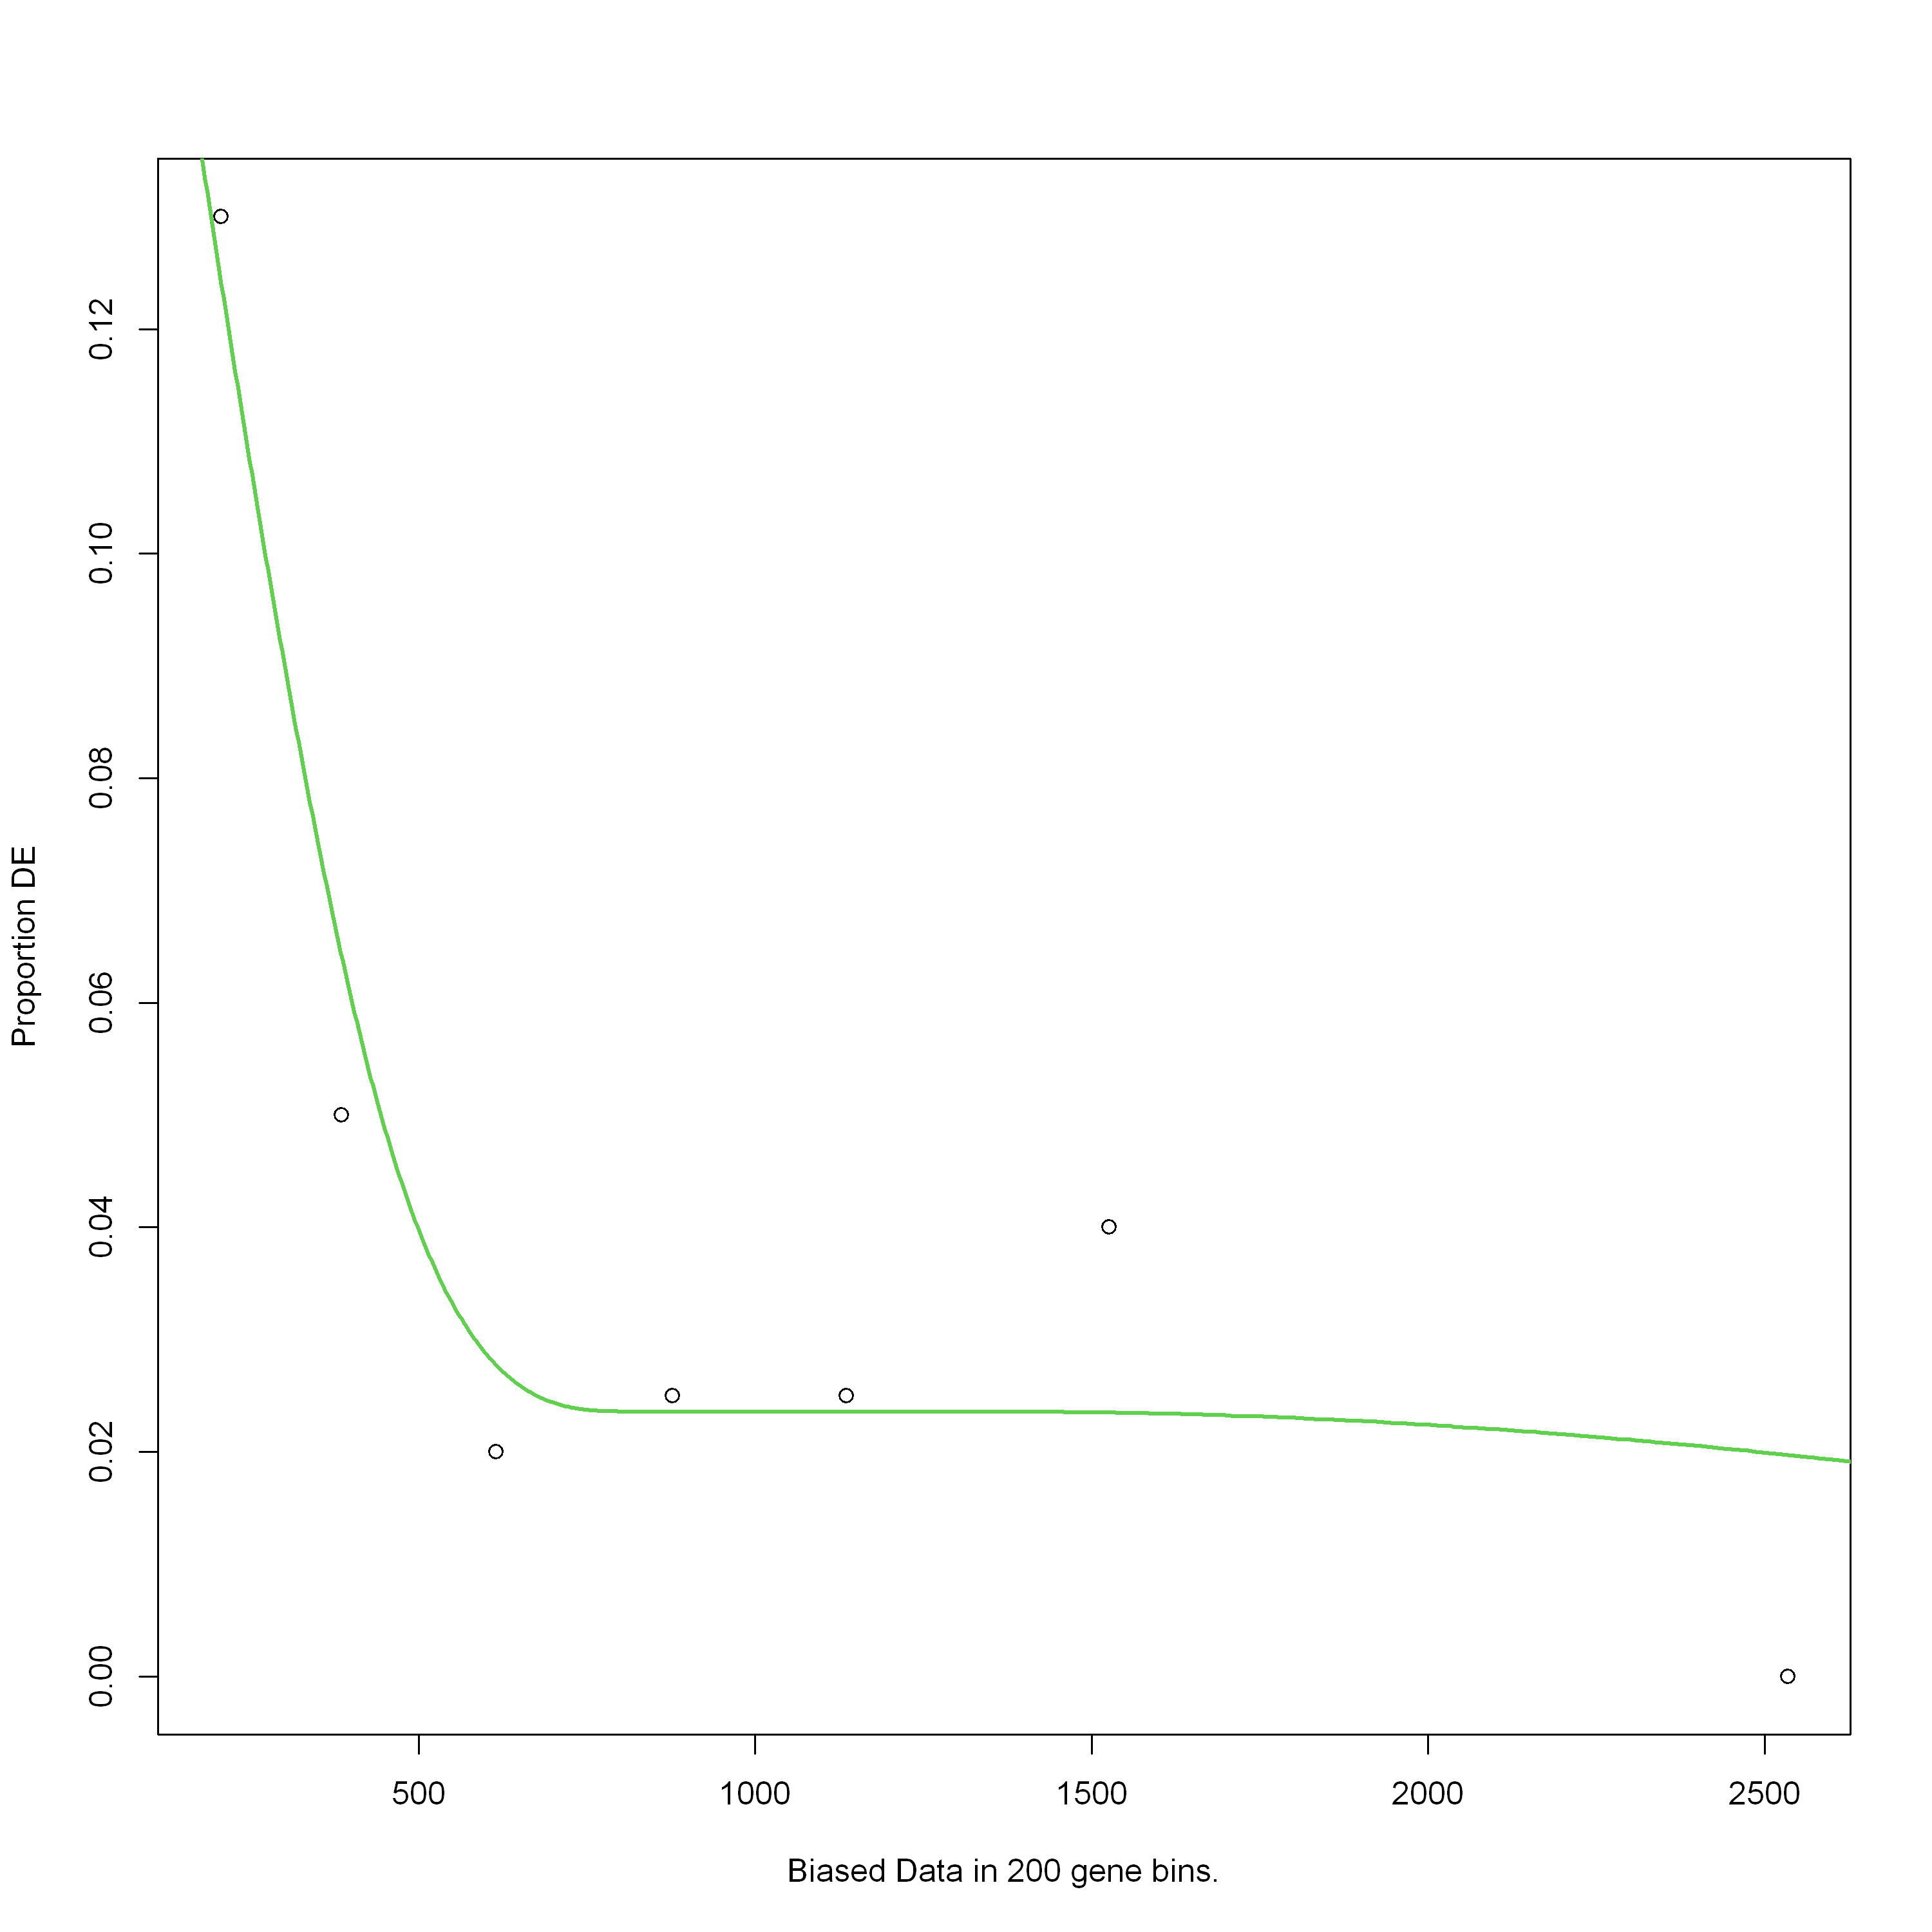

Using manually entered categories.

For 49 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



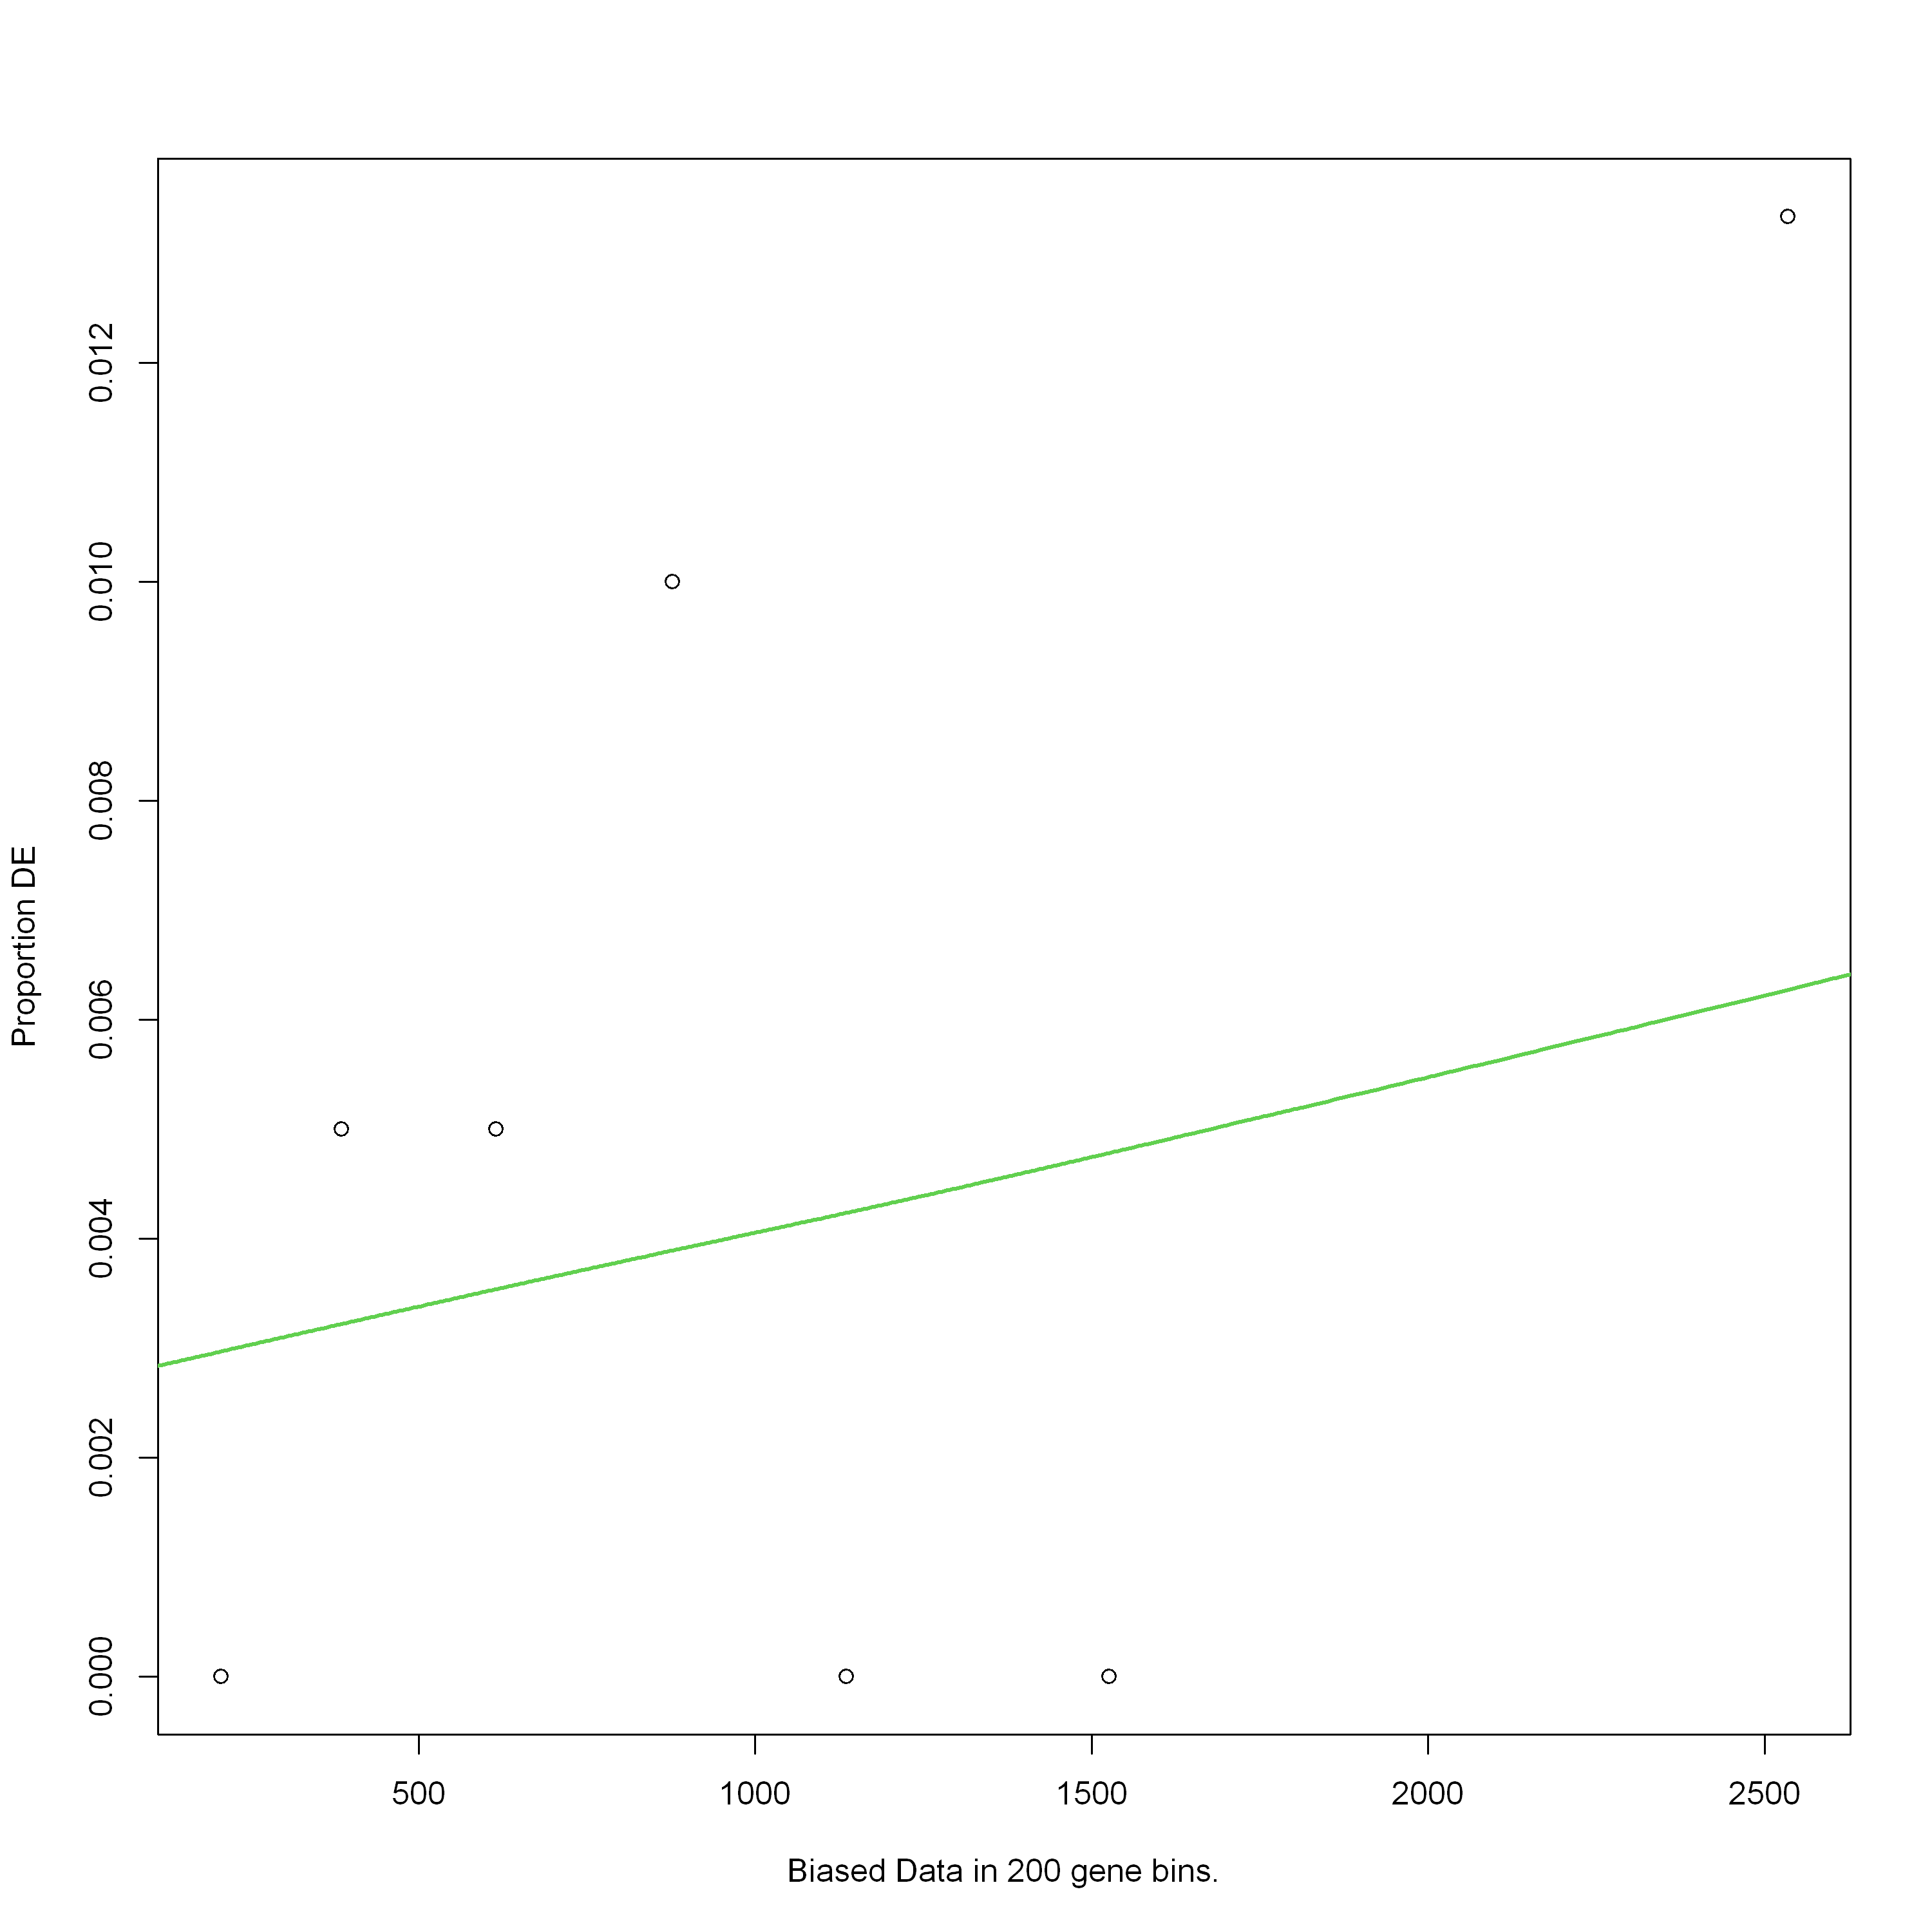

Using manually entered categories.

For 38 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



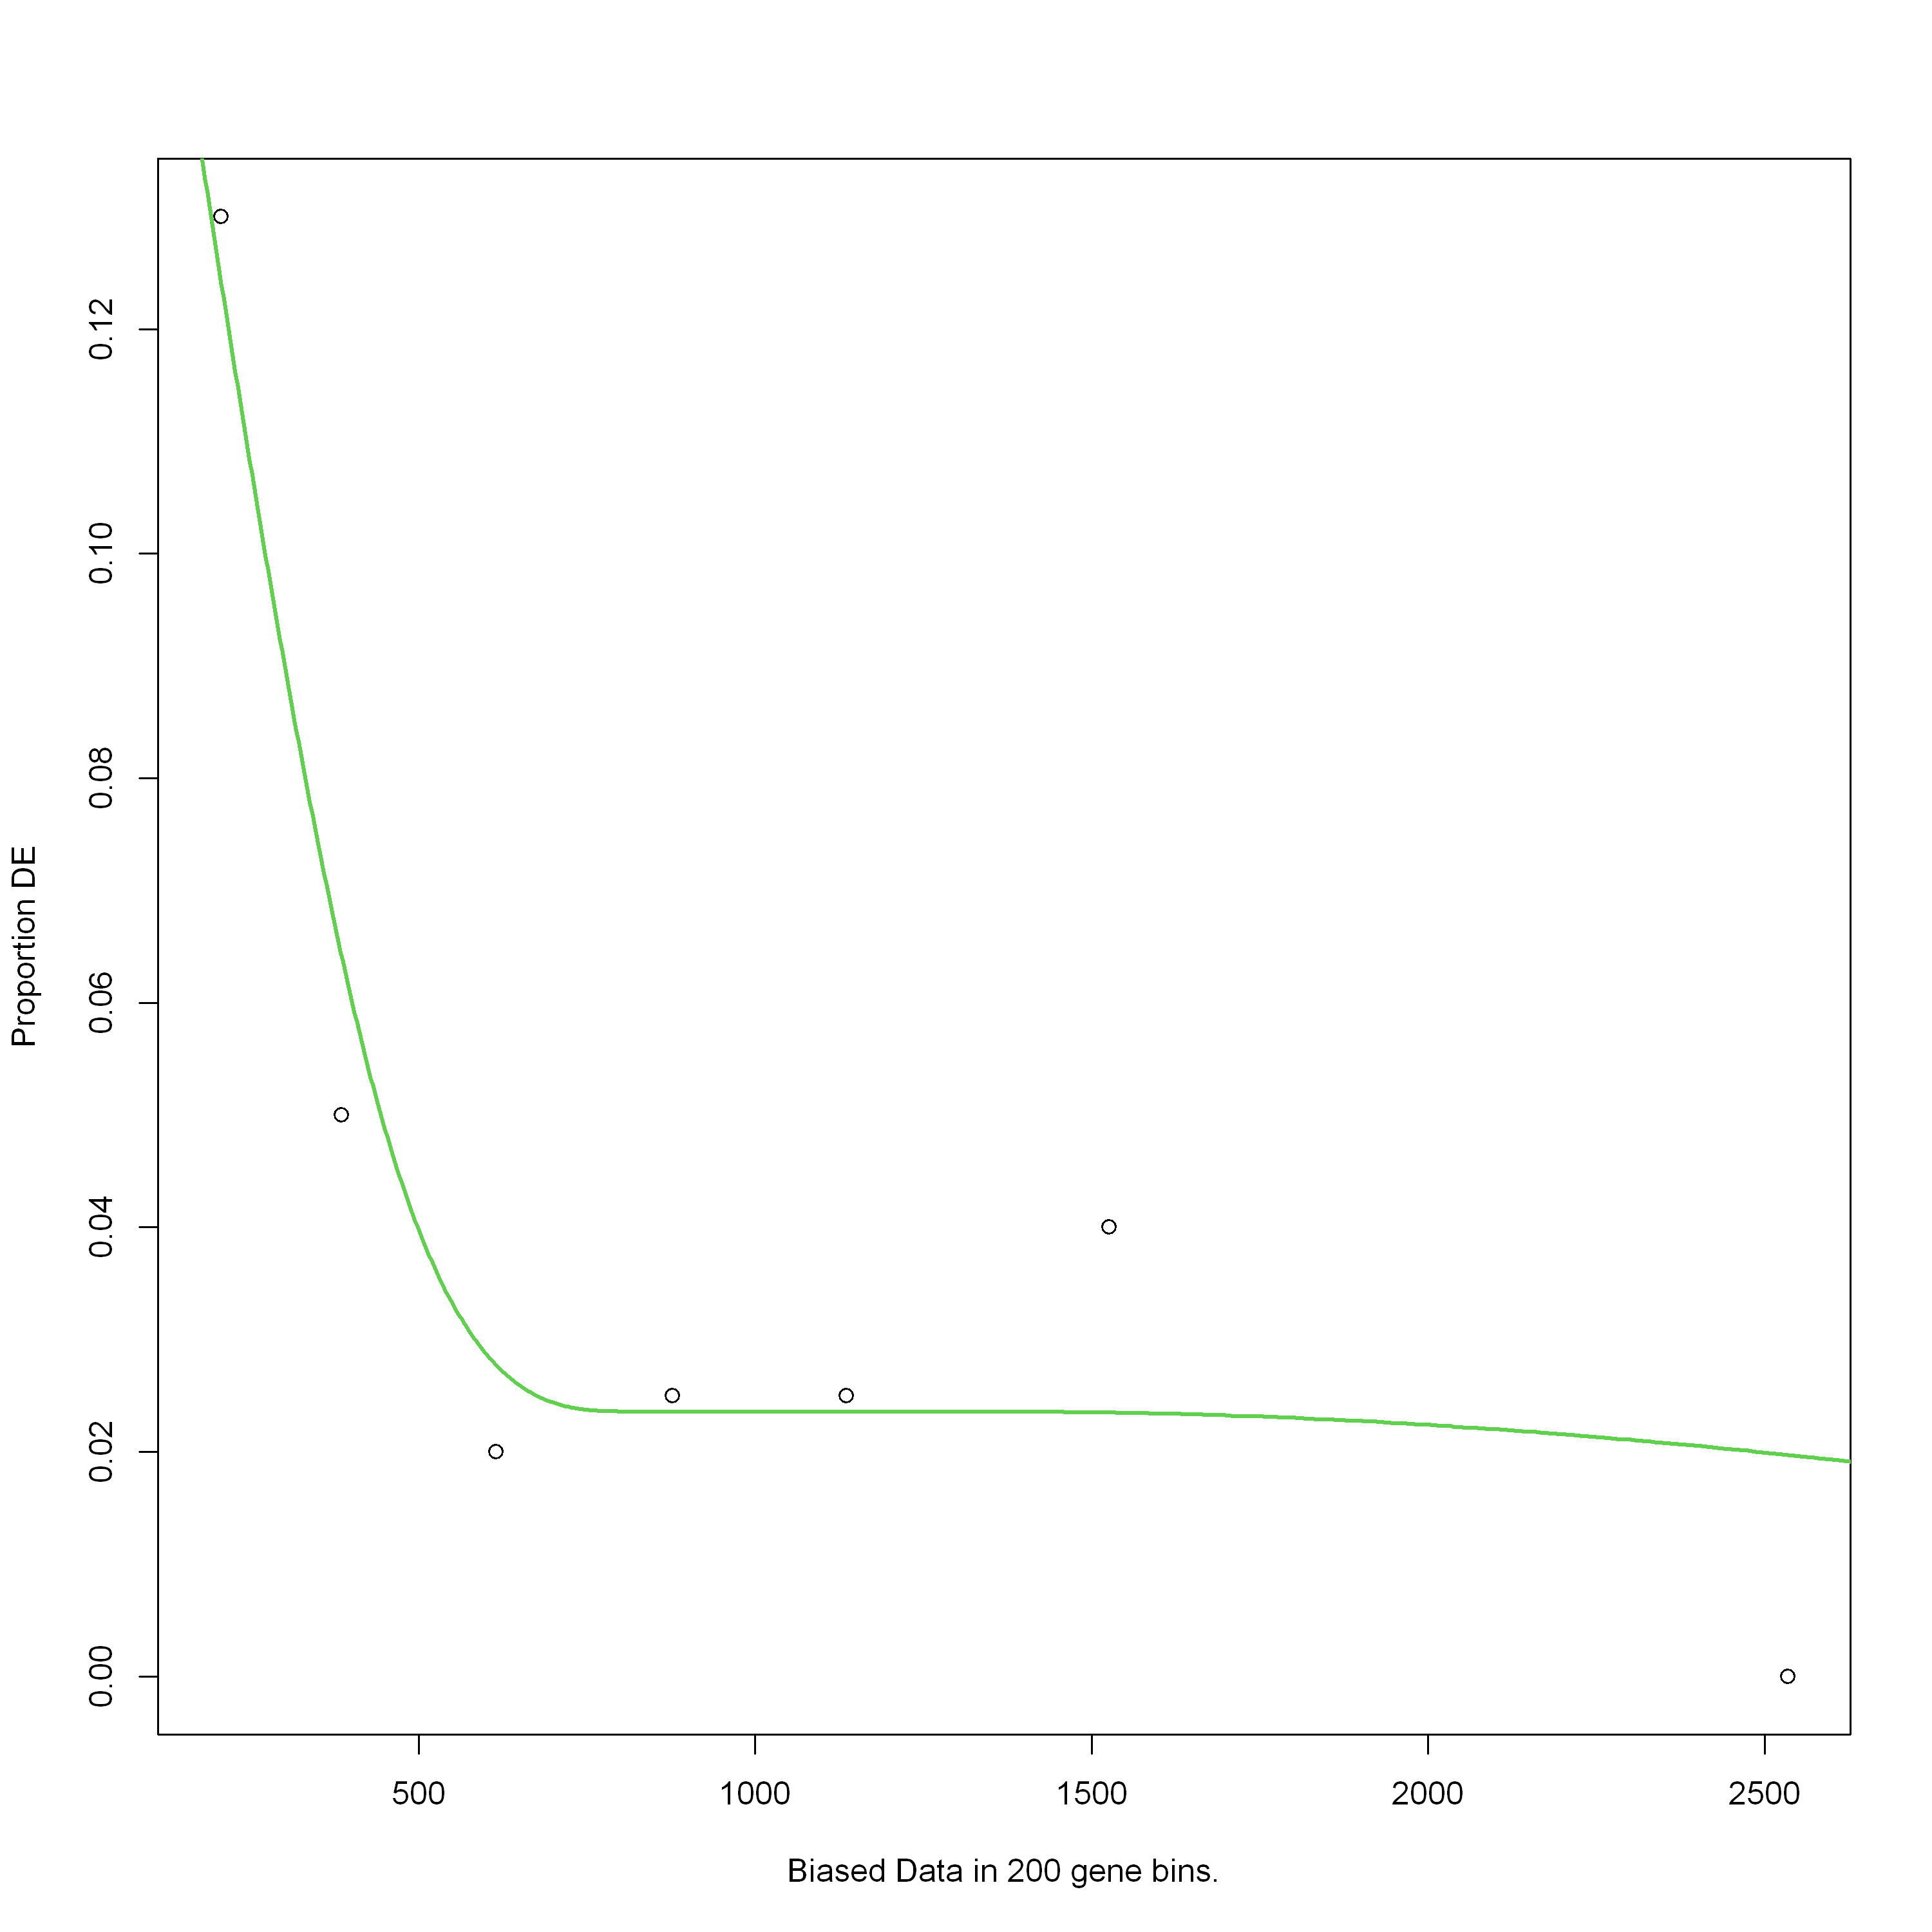

Using manually entered categories.

For 38 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



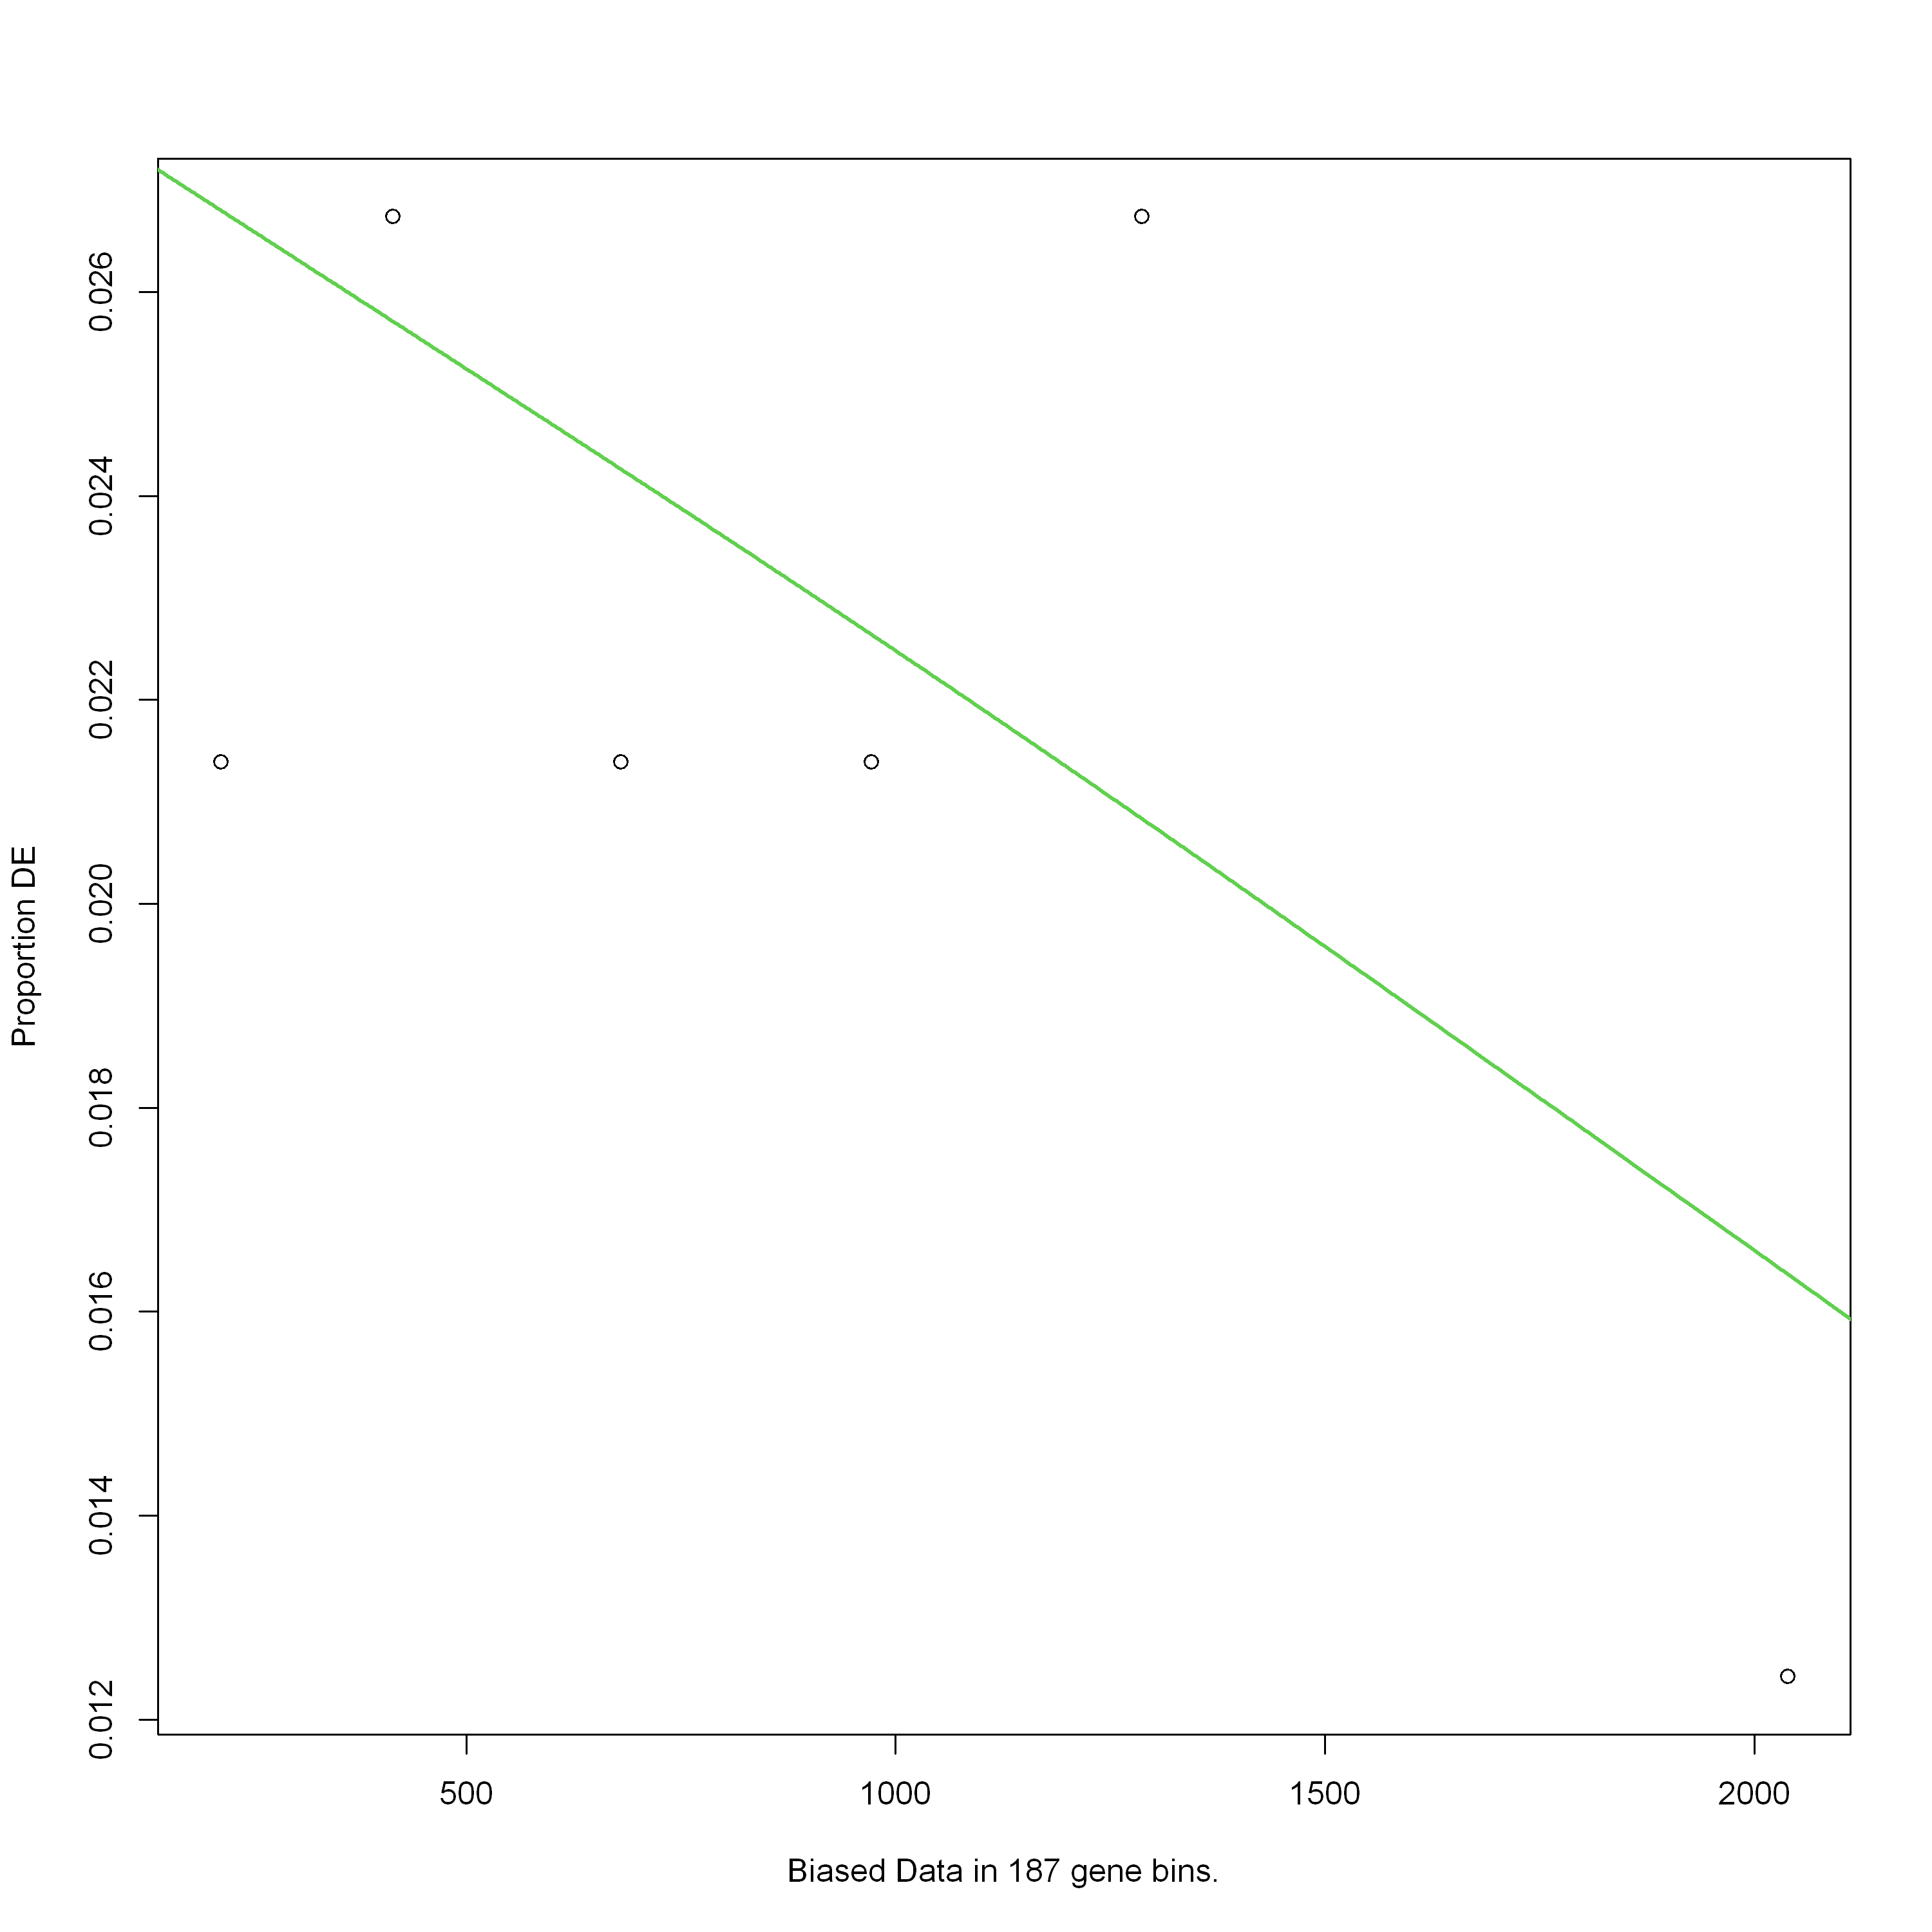

Using manually entered categories.

For 38 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



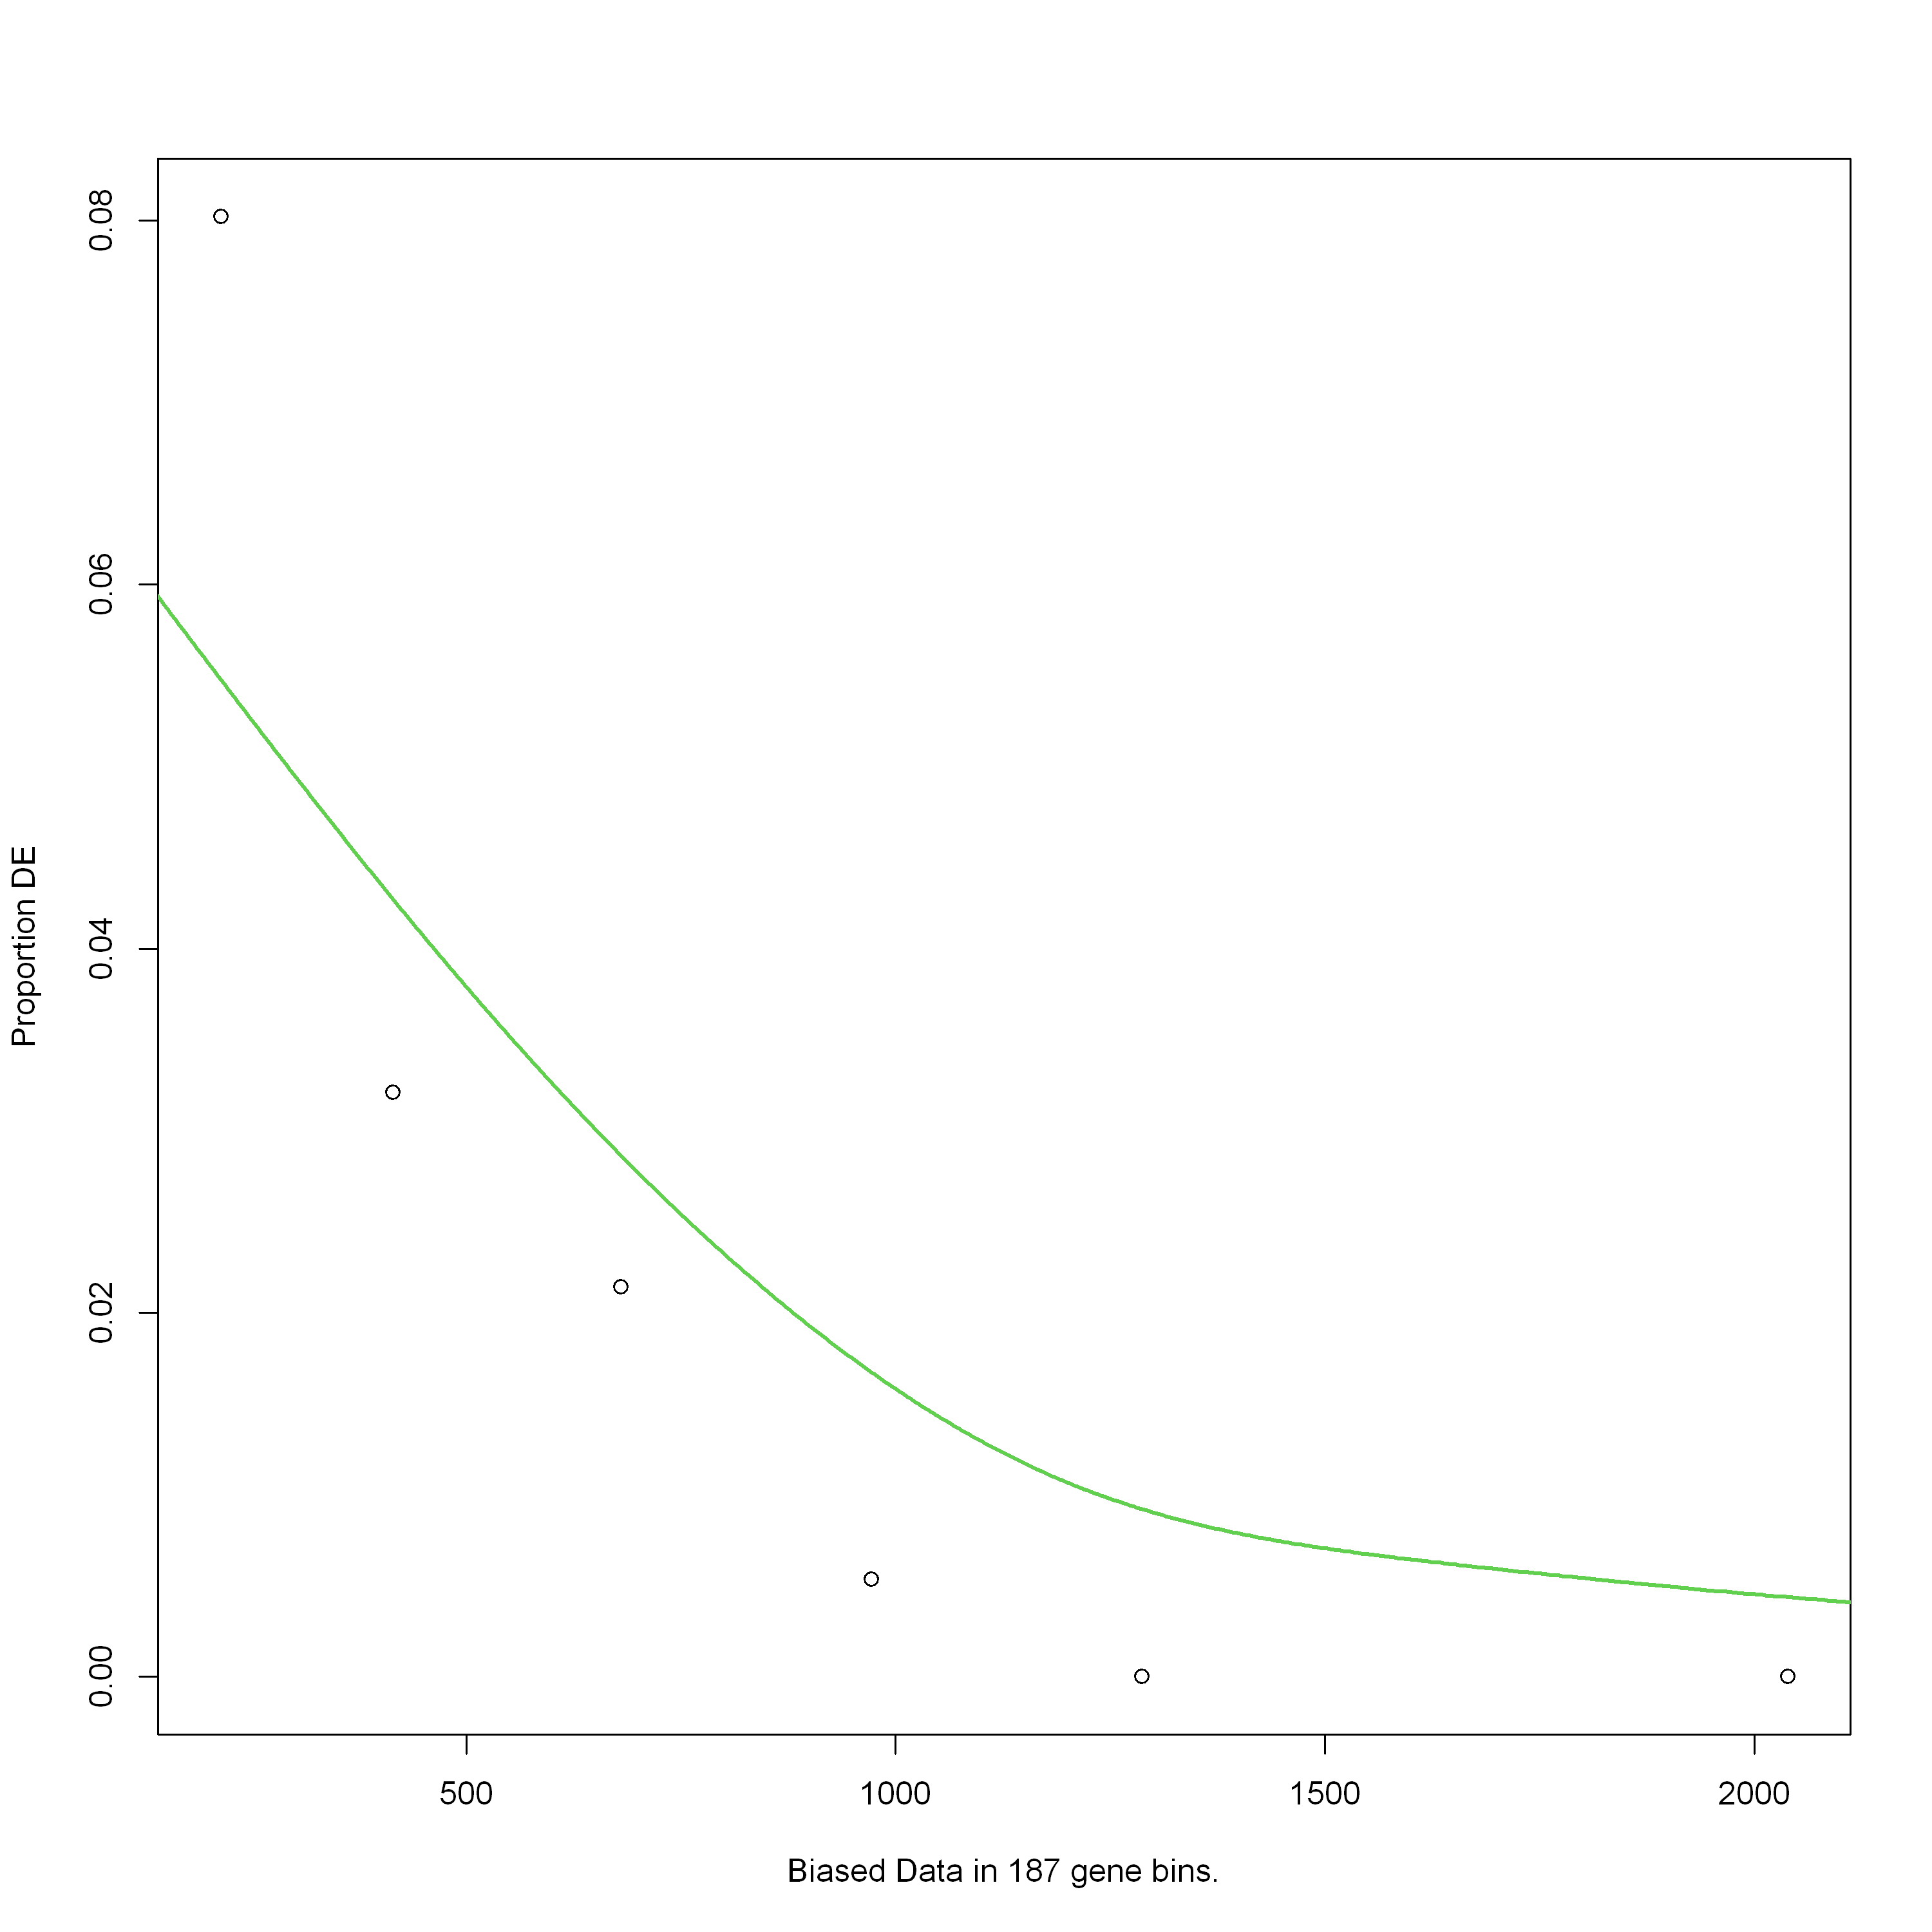

Using manually entered categories.

For 38 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



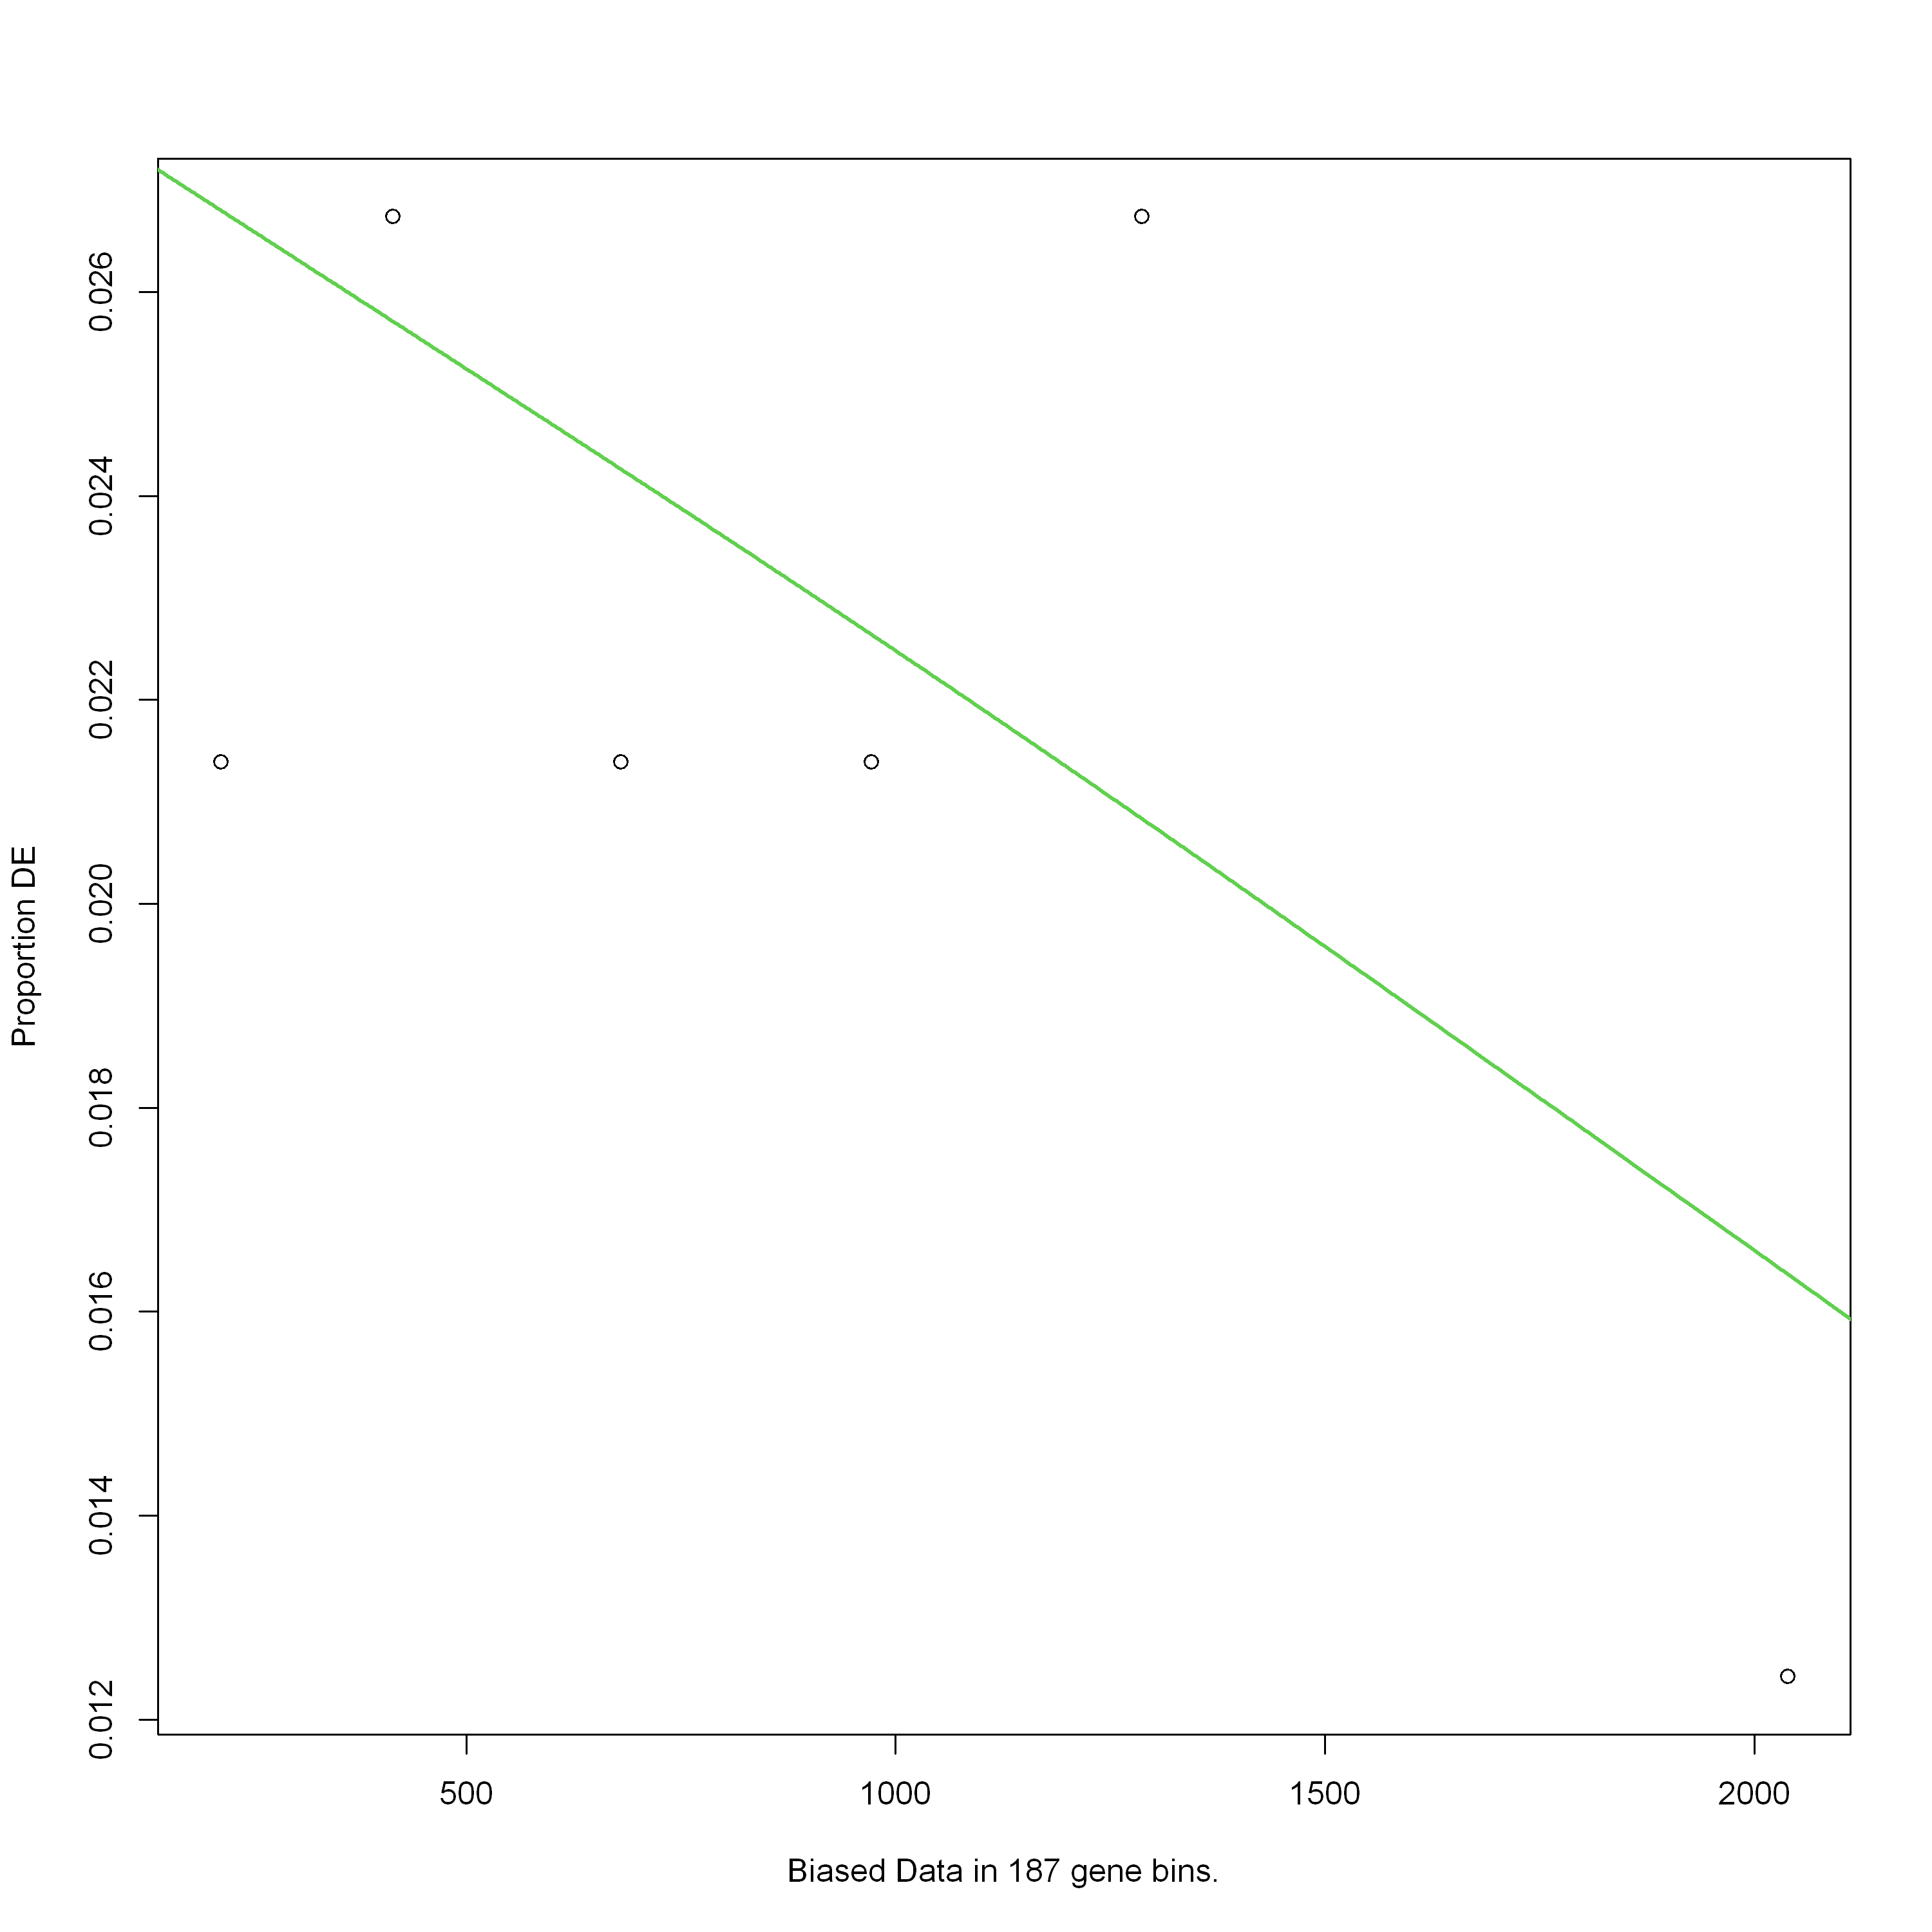

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



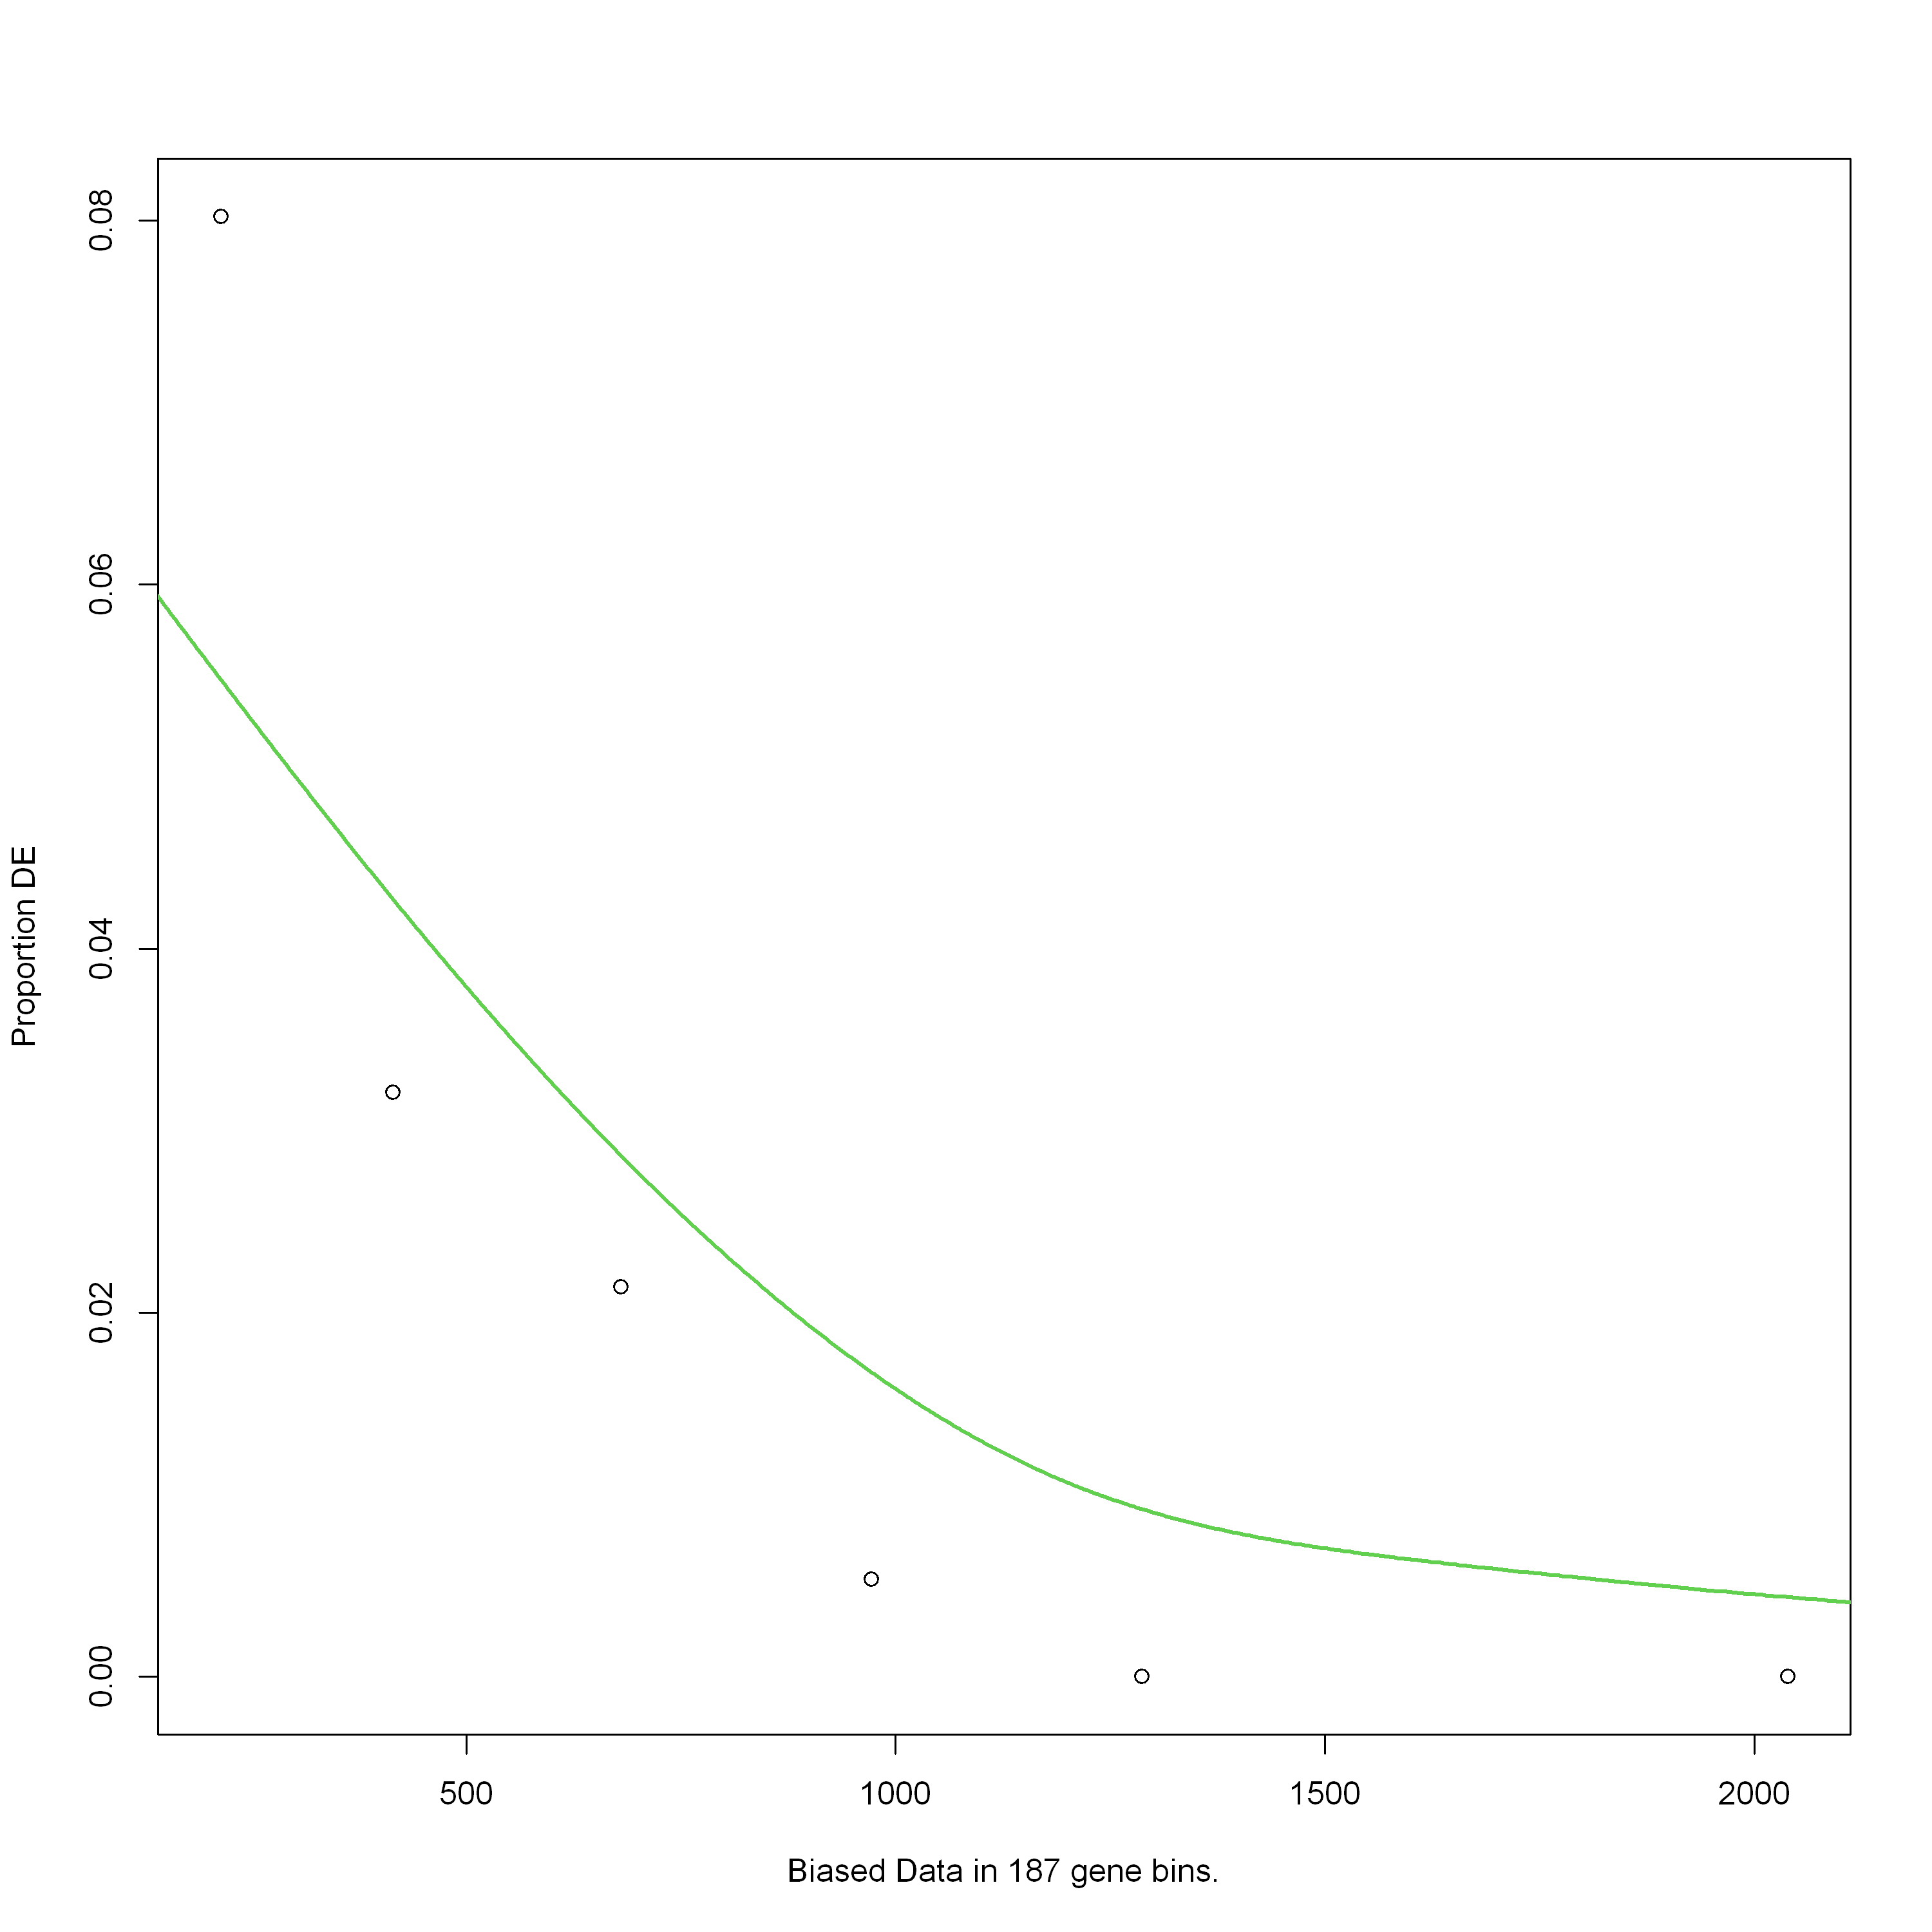

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



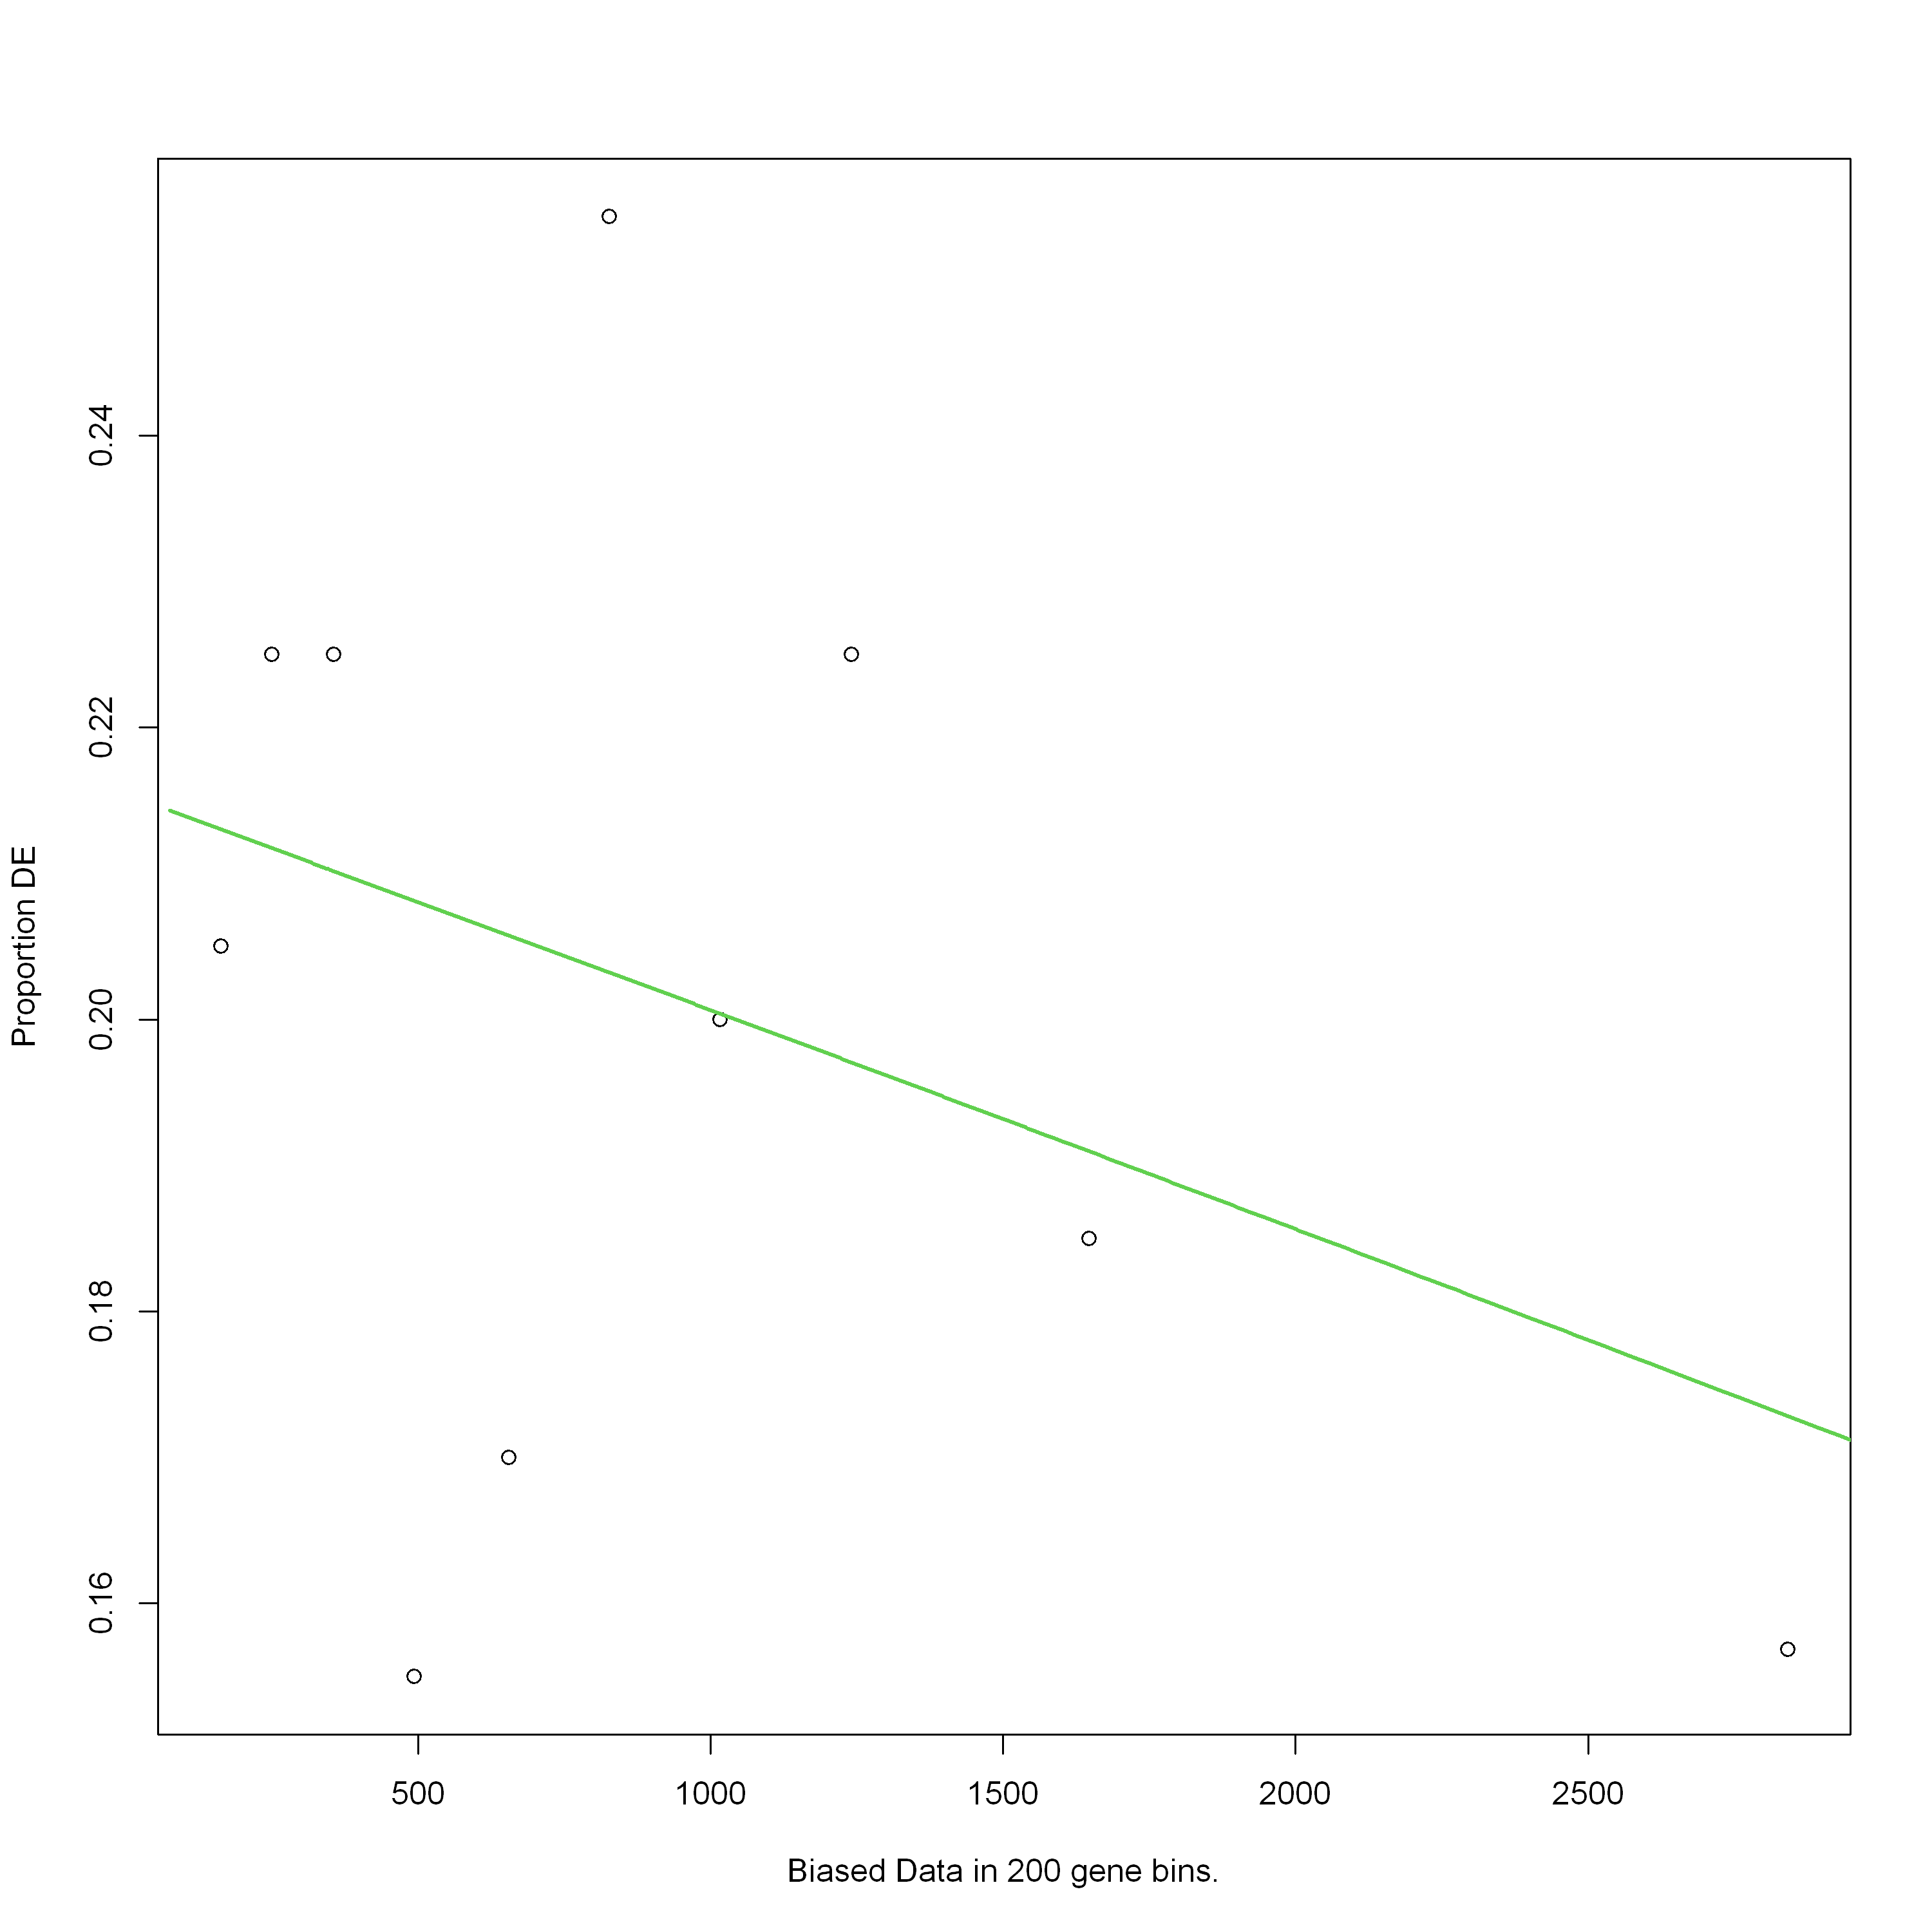

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



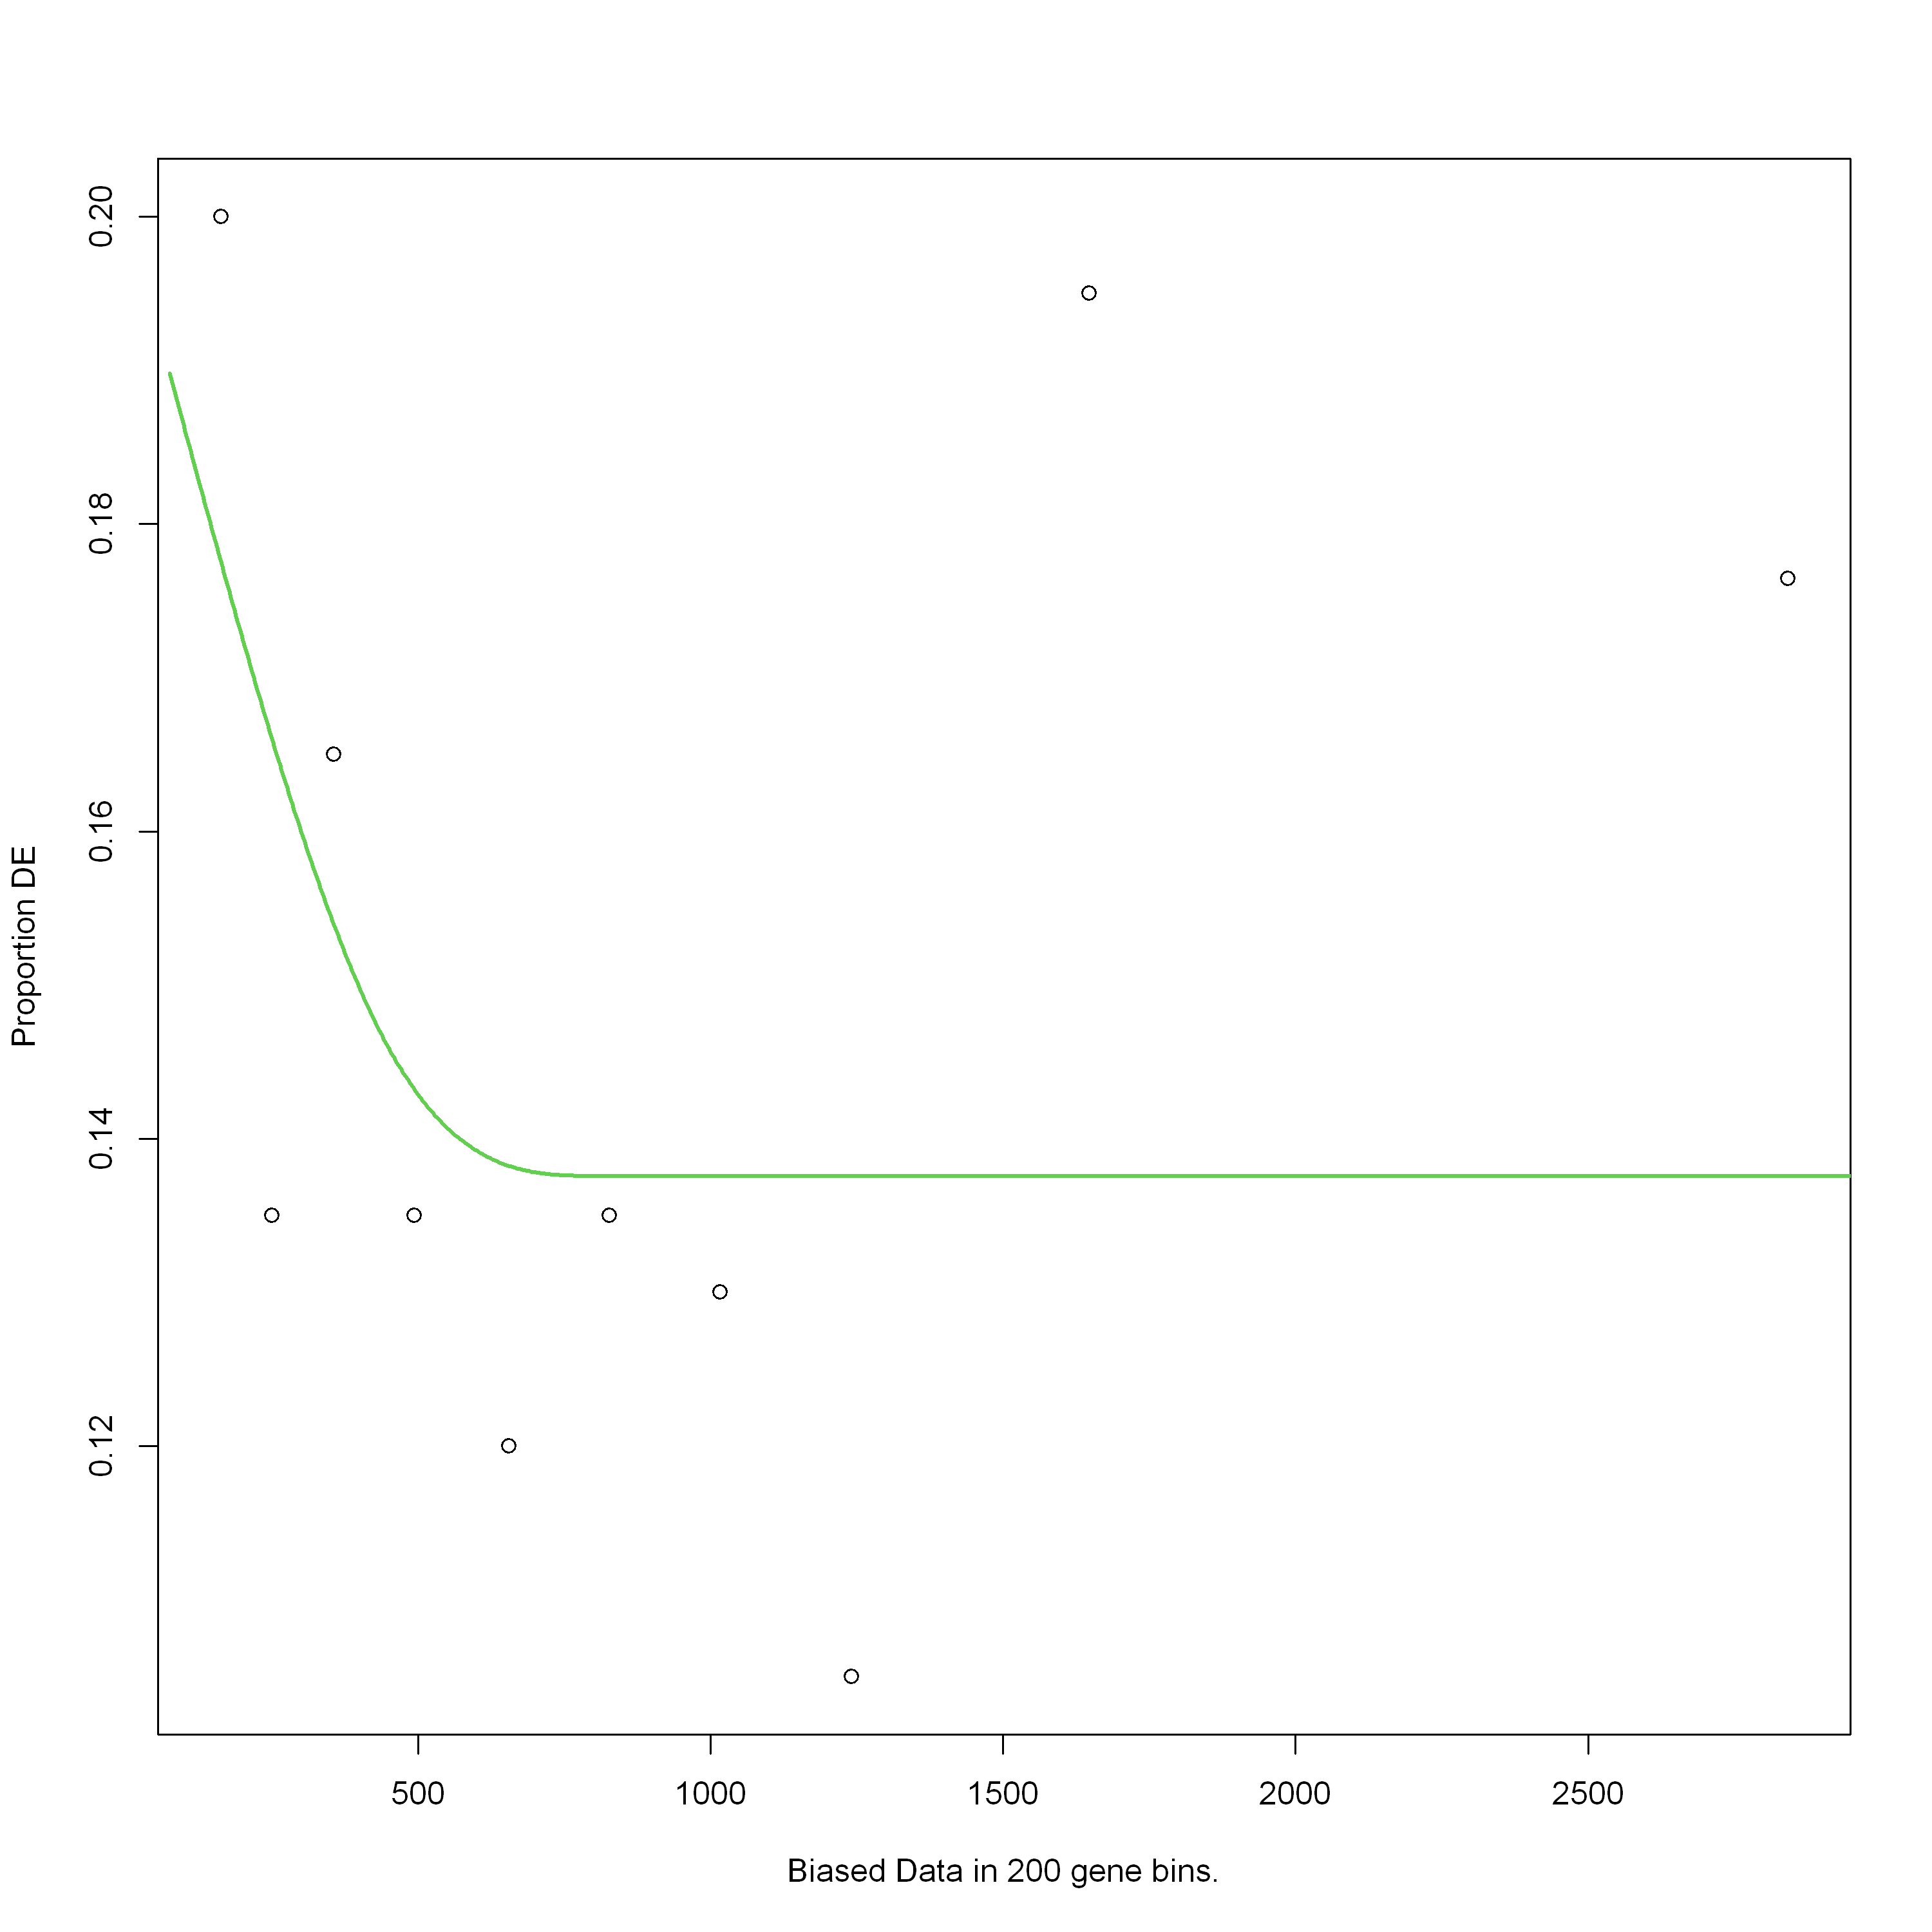

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



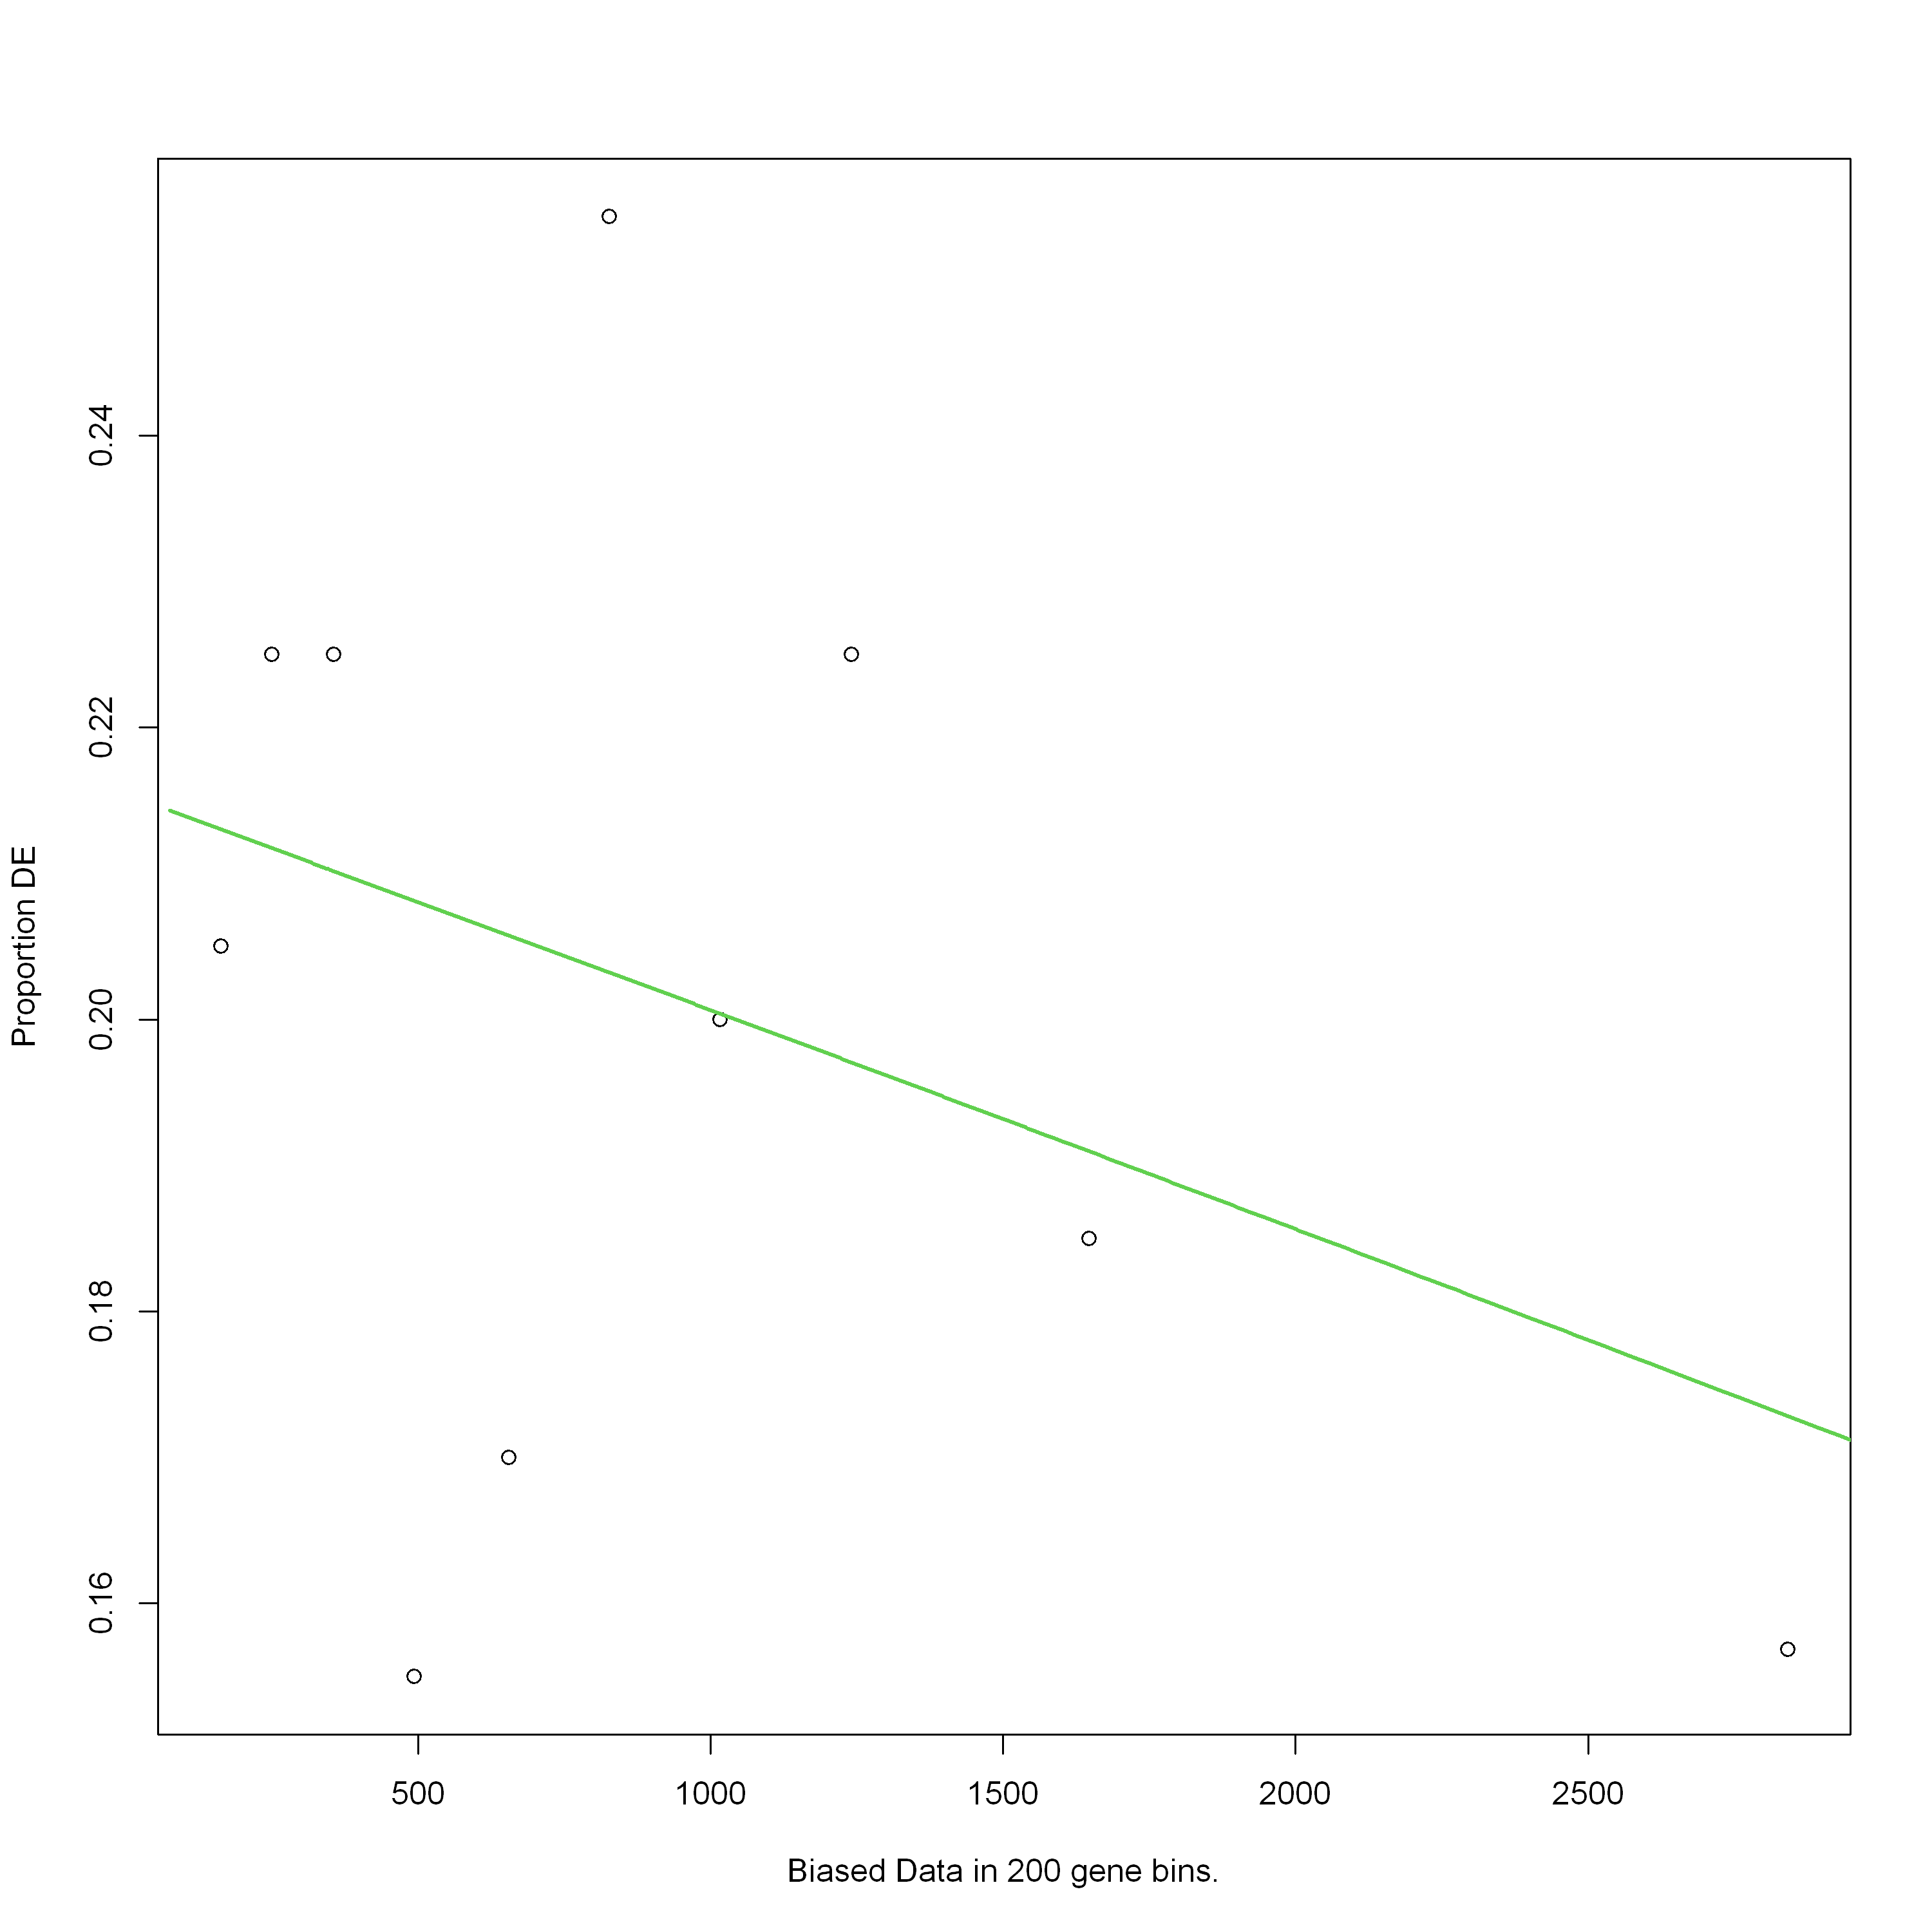

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


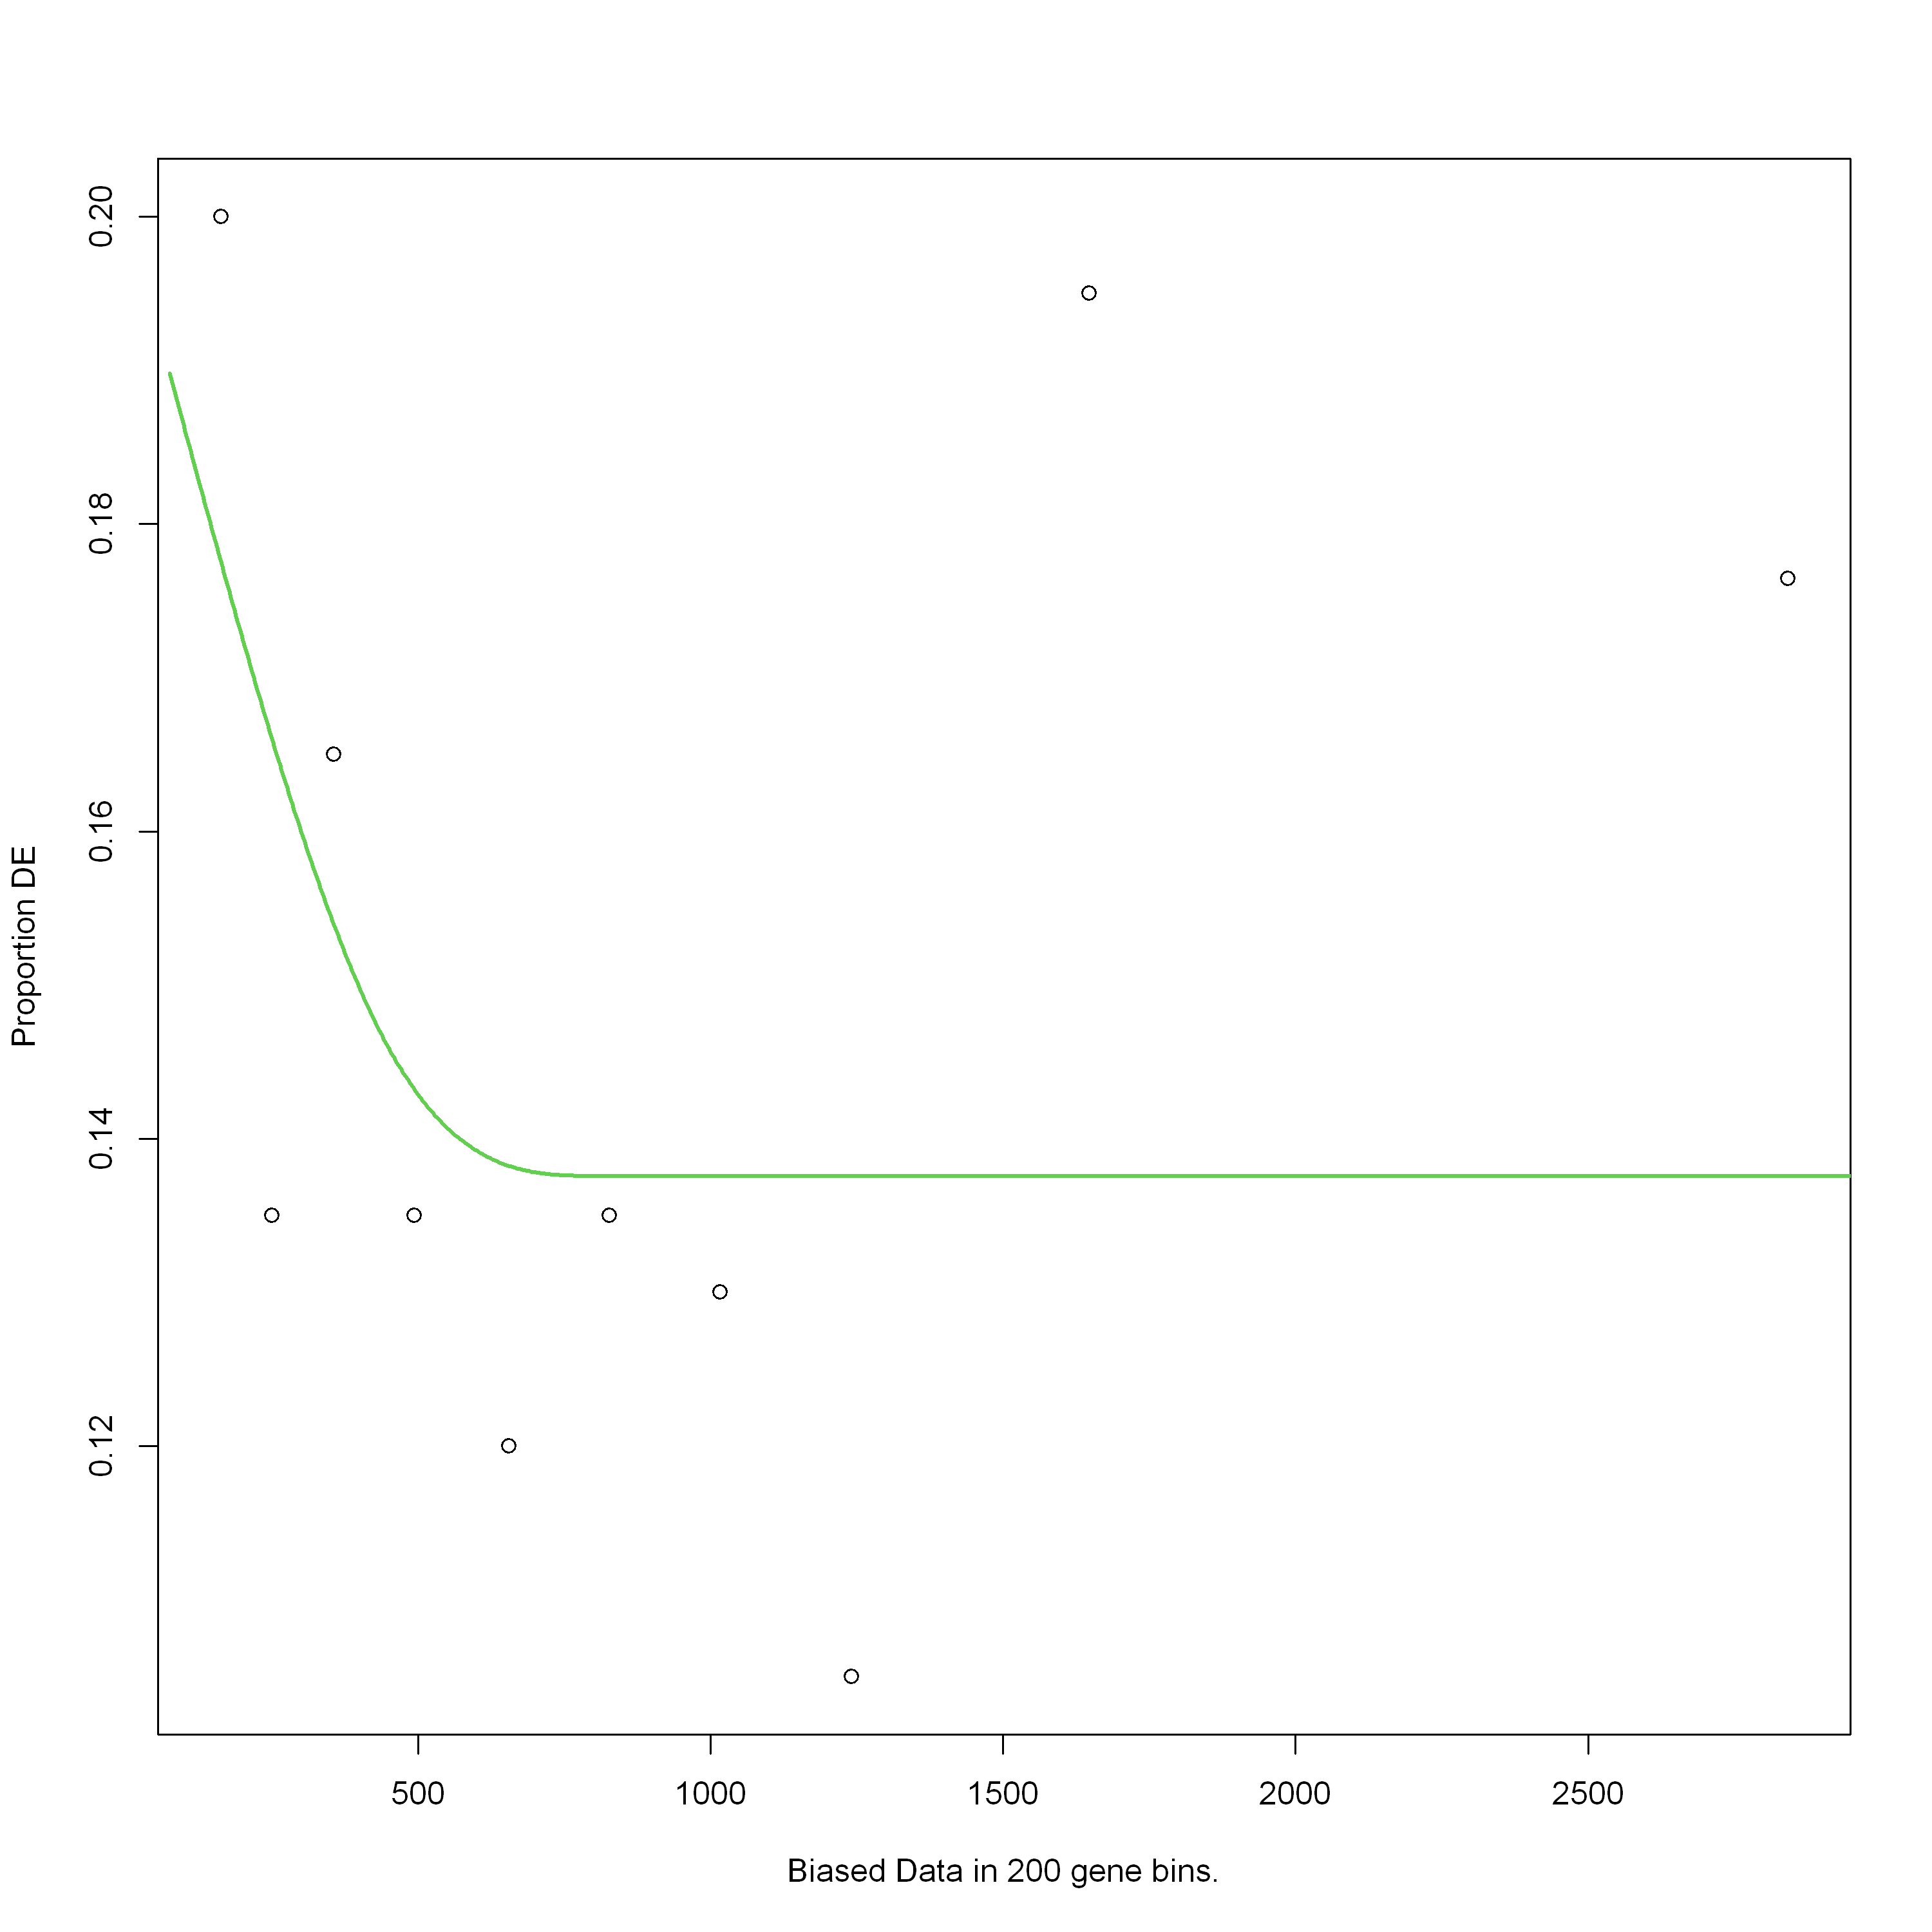

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



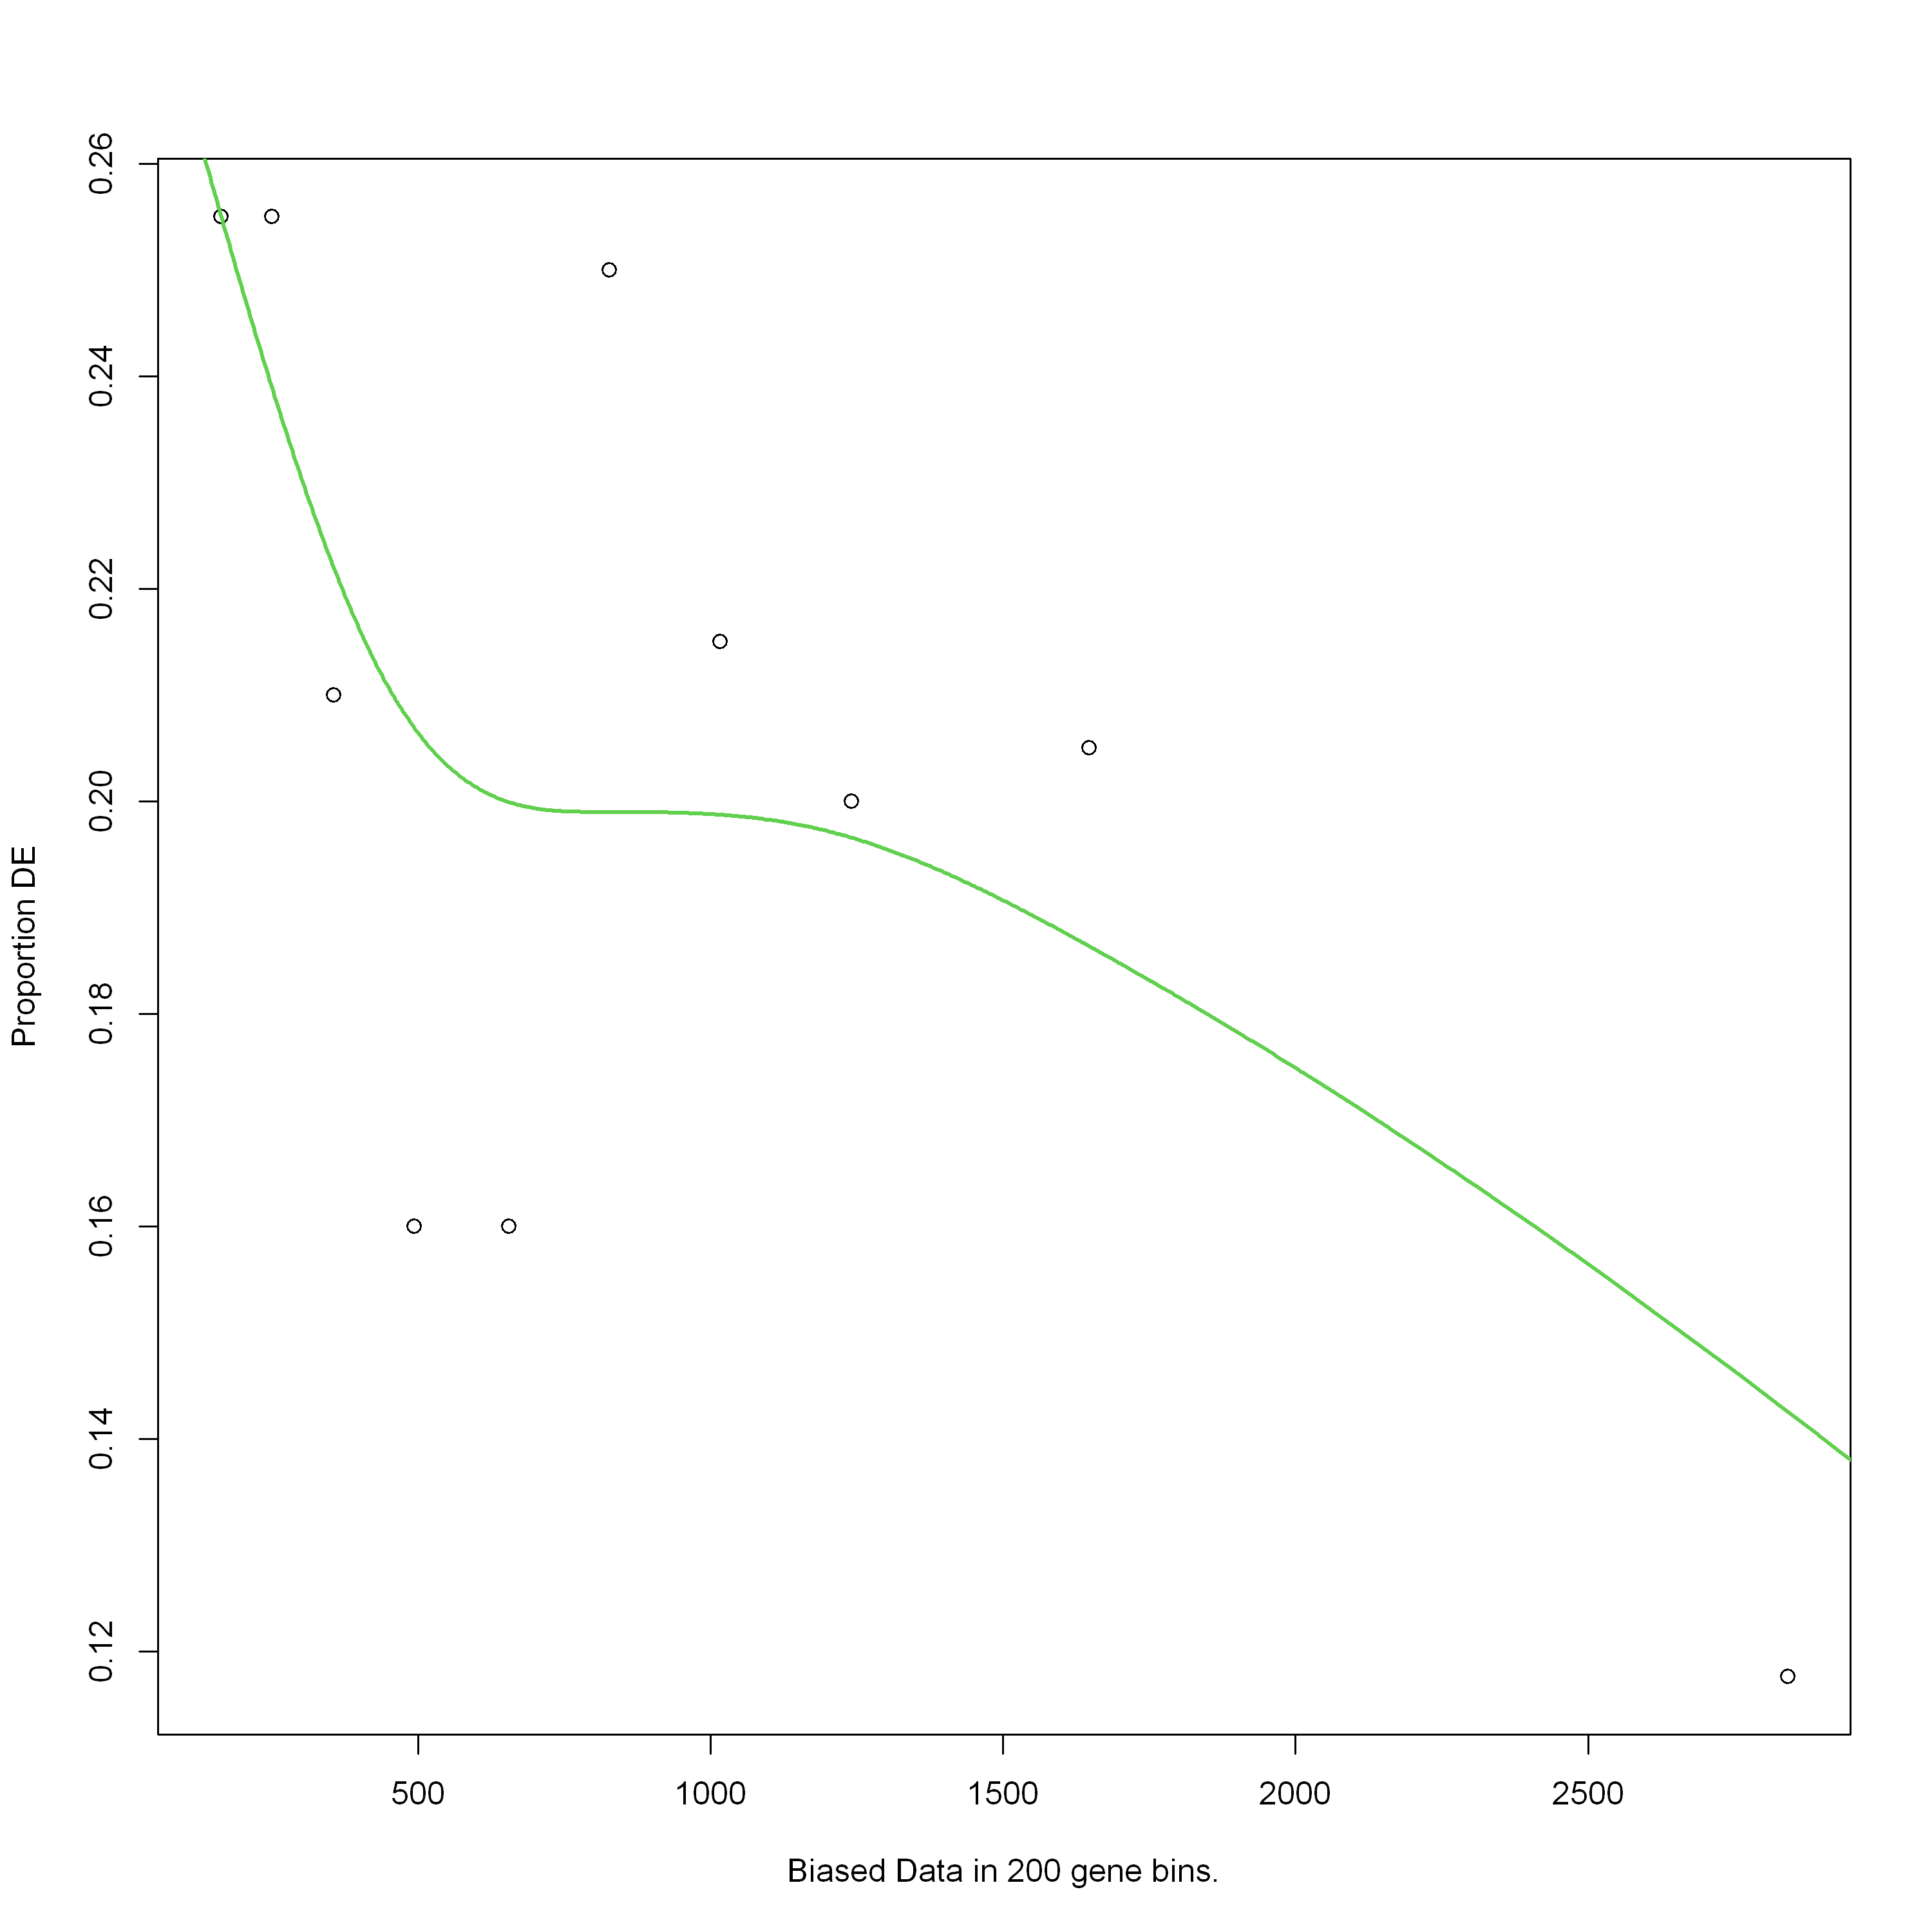

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


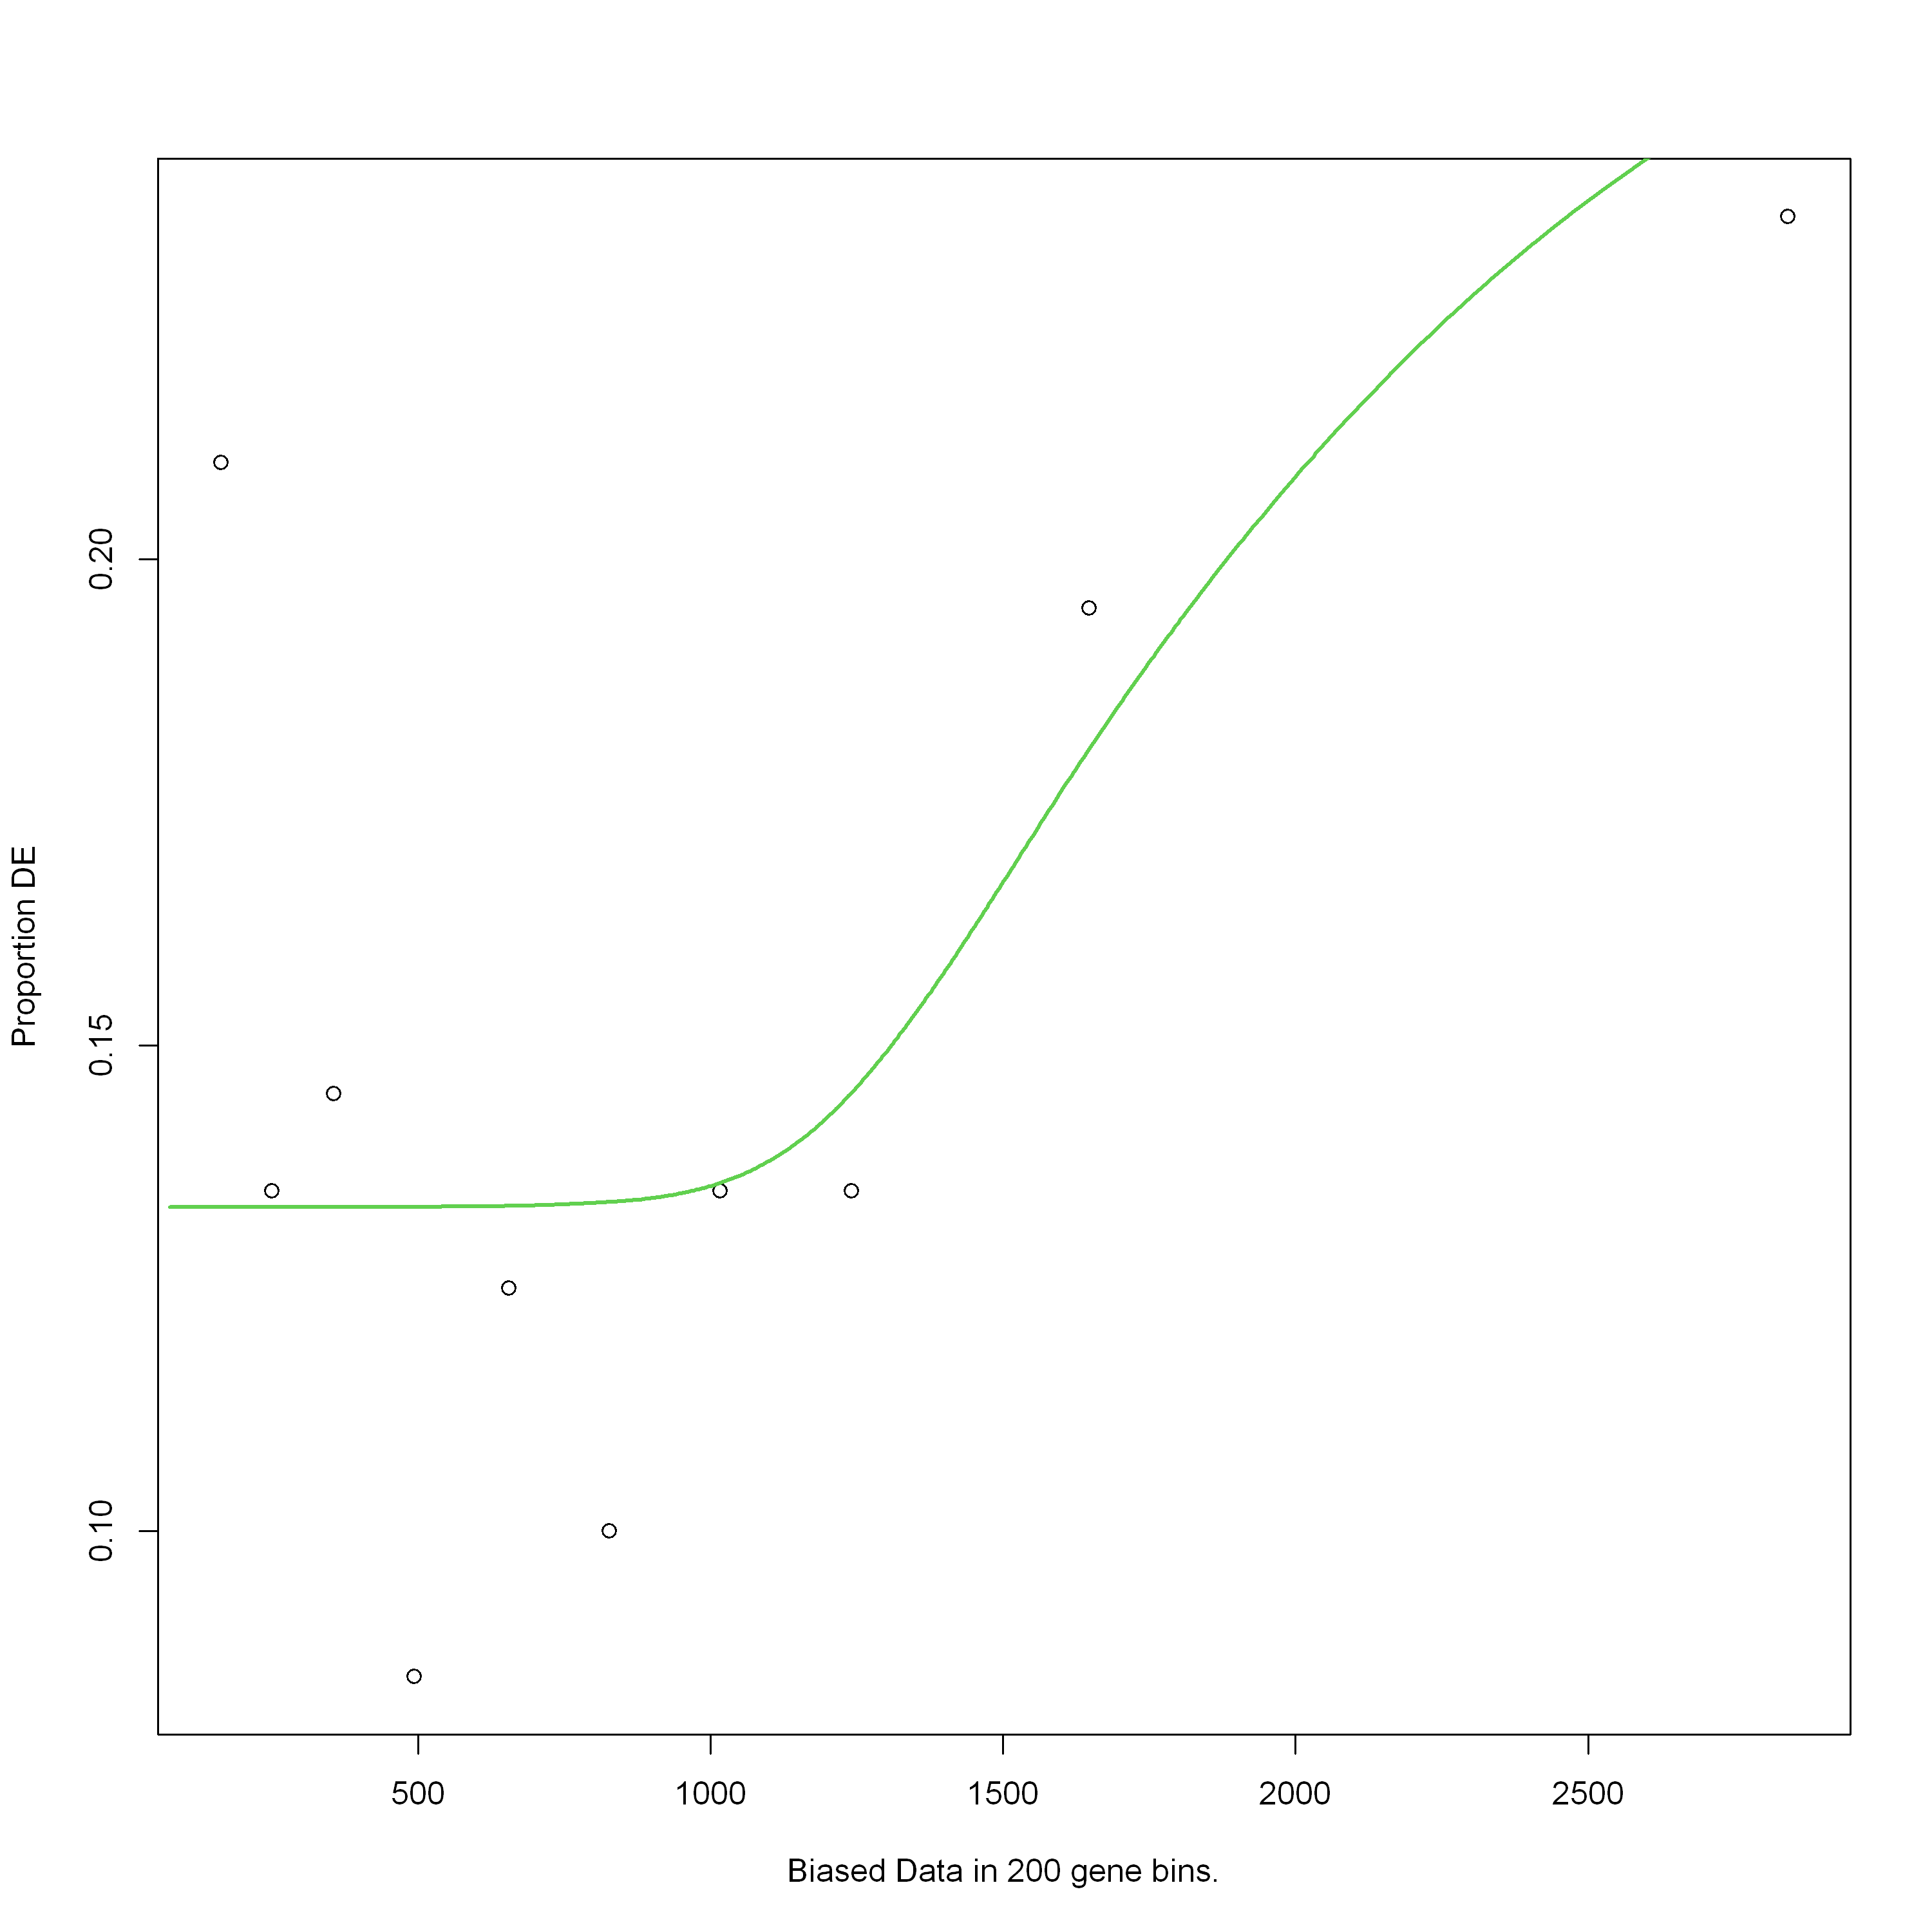

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



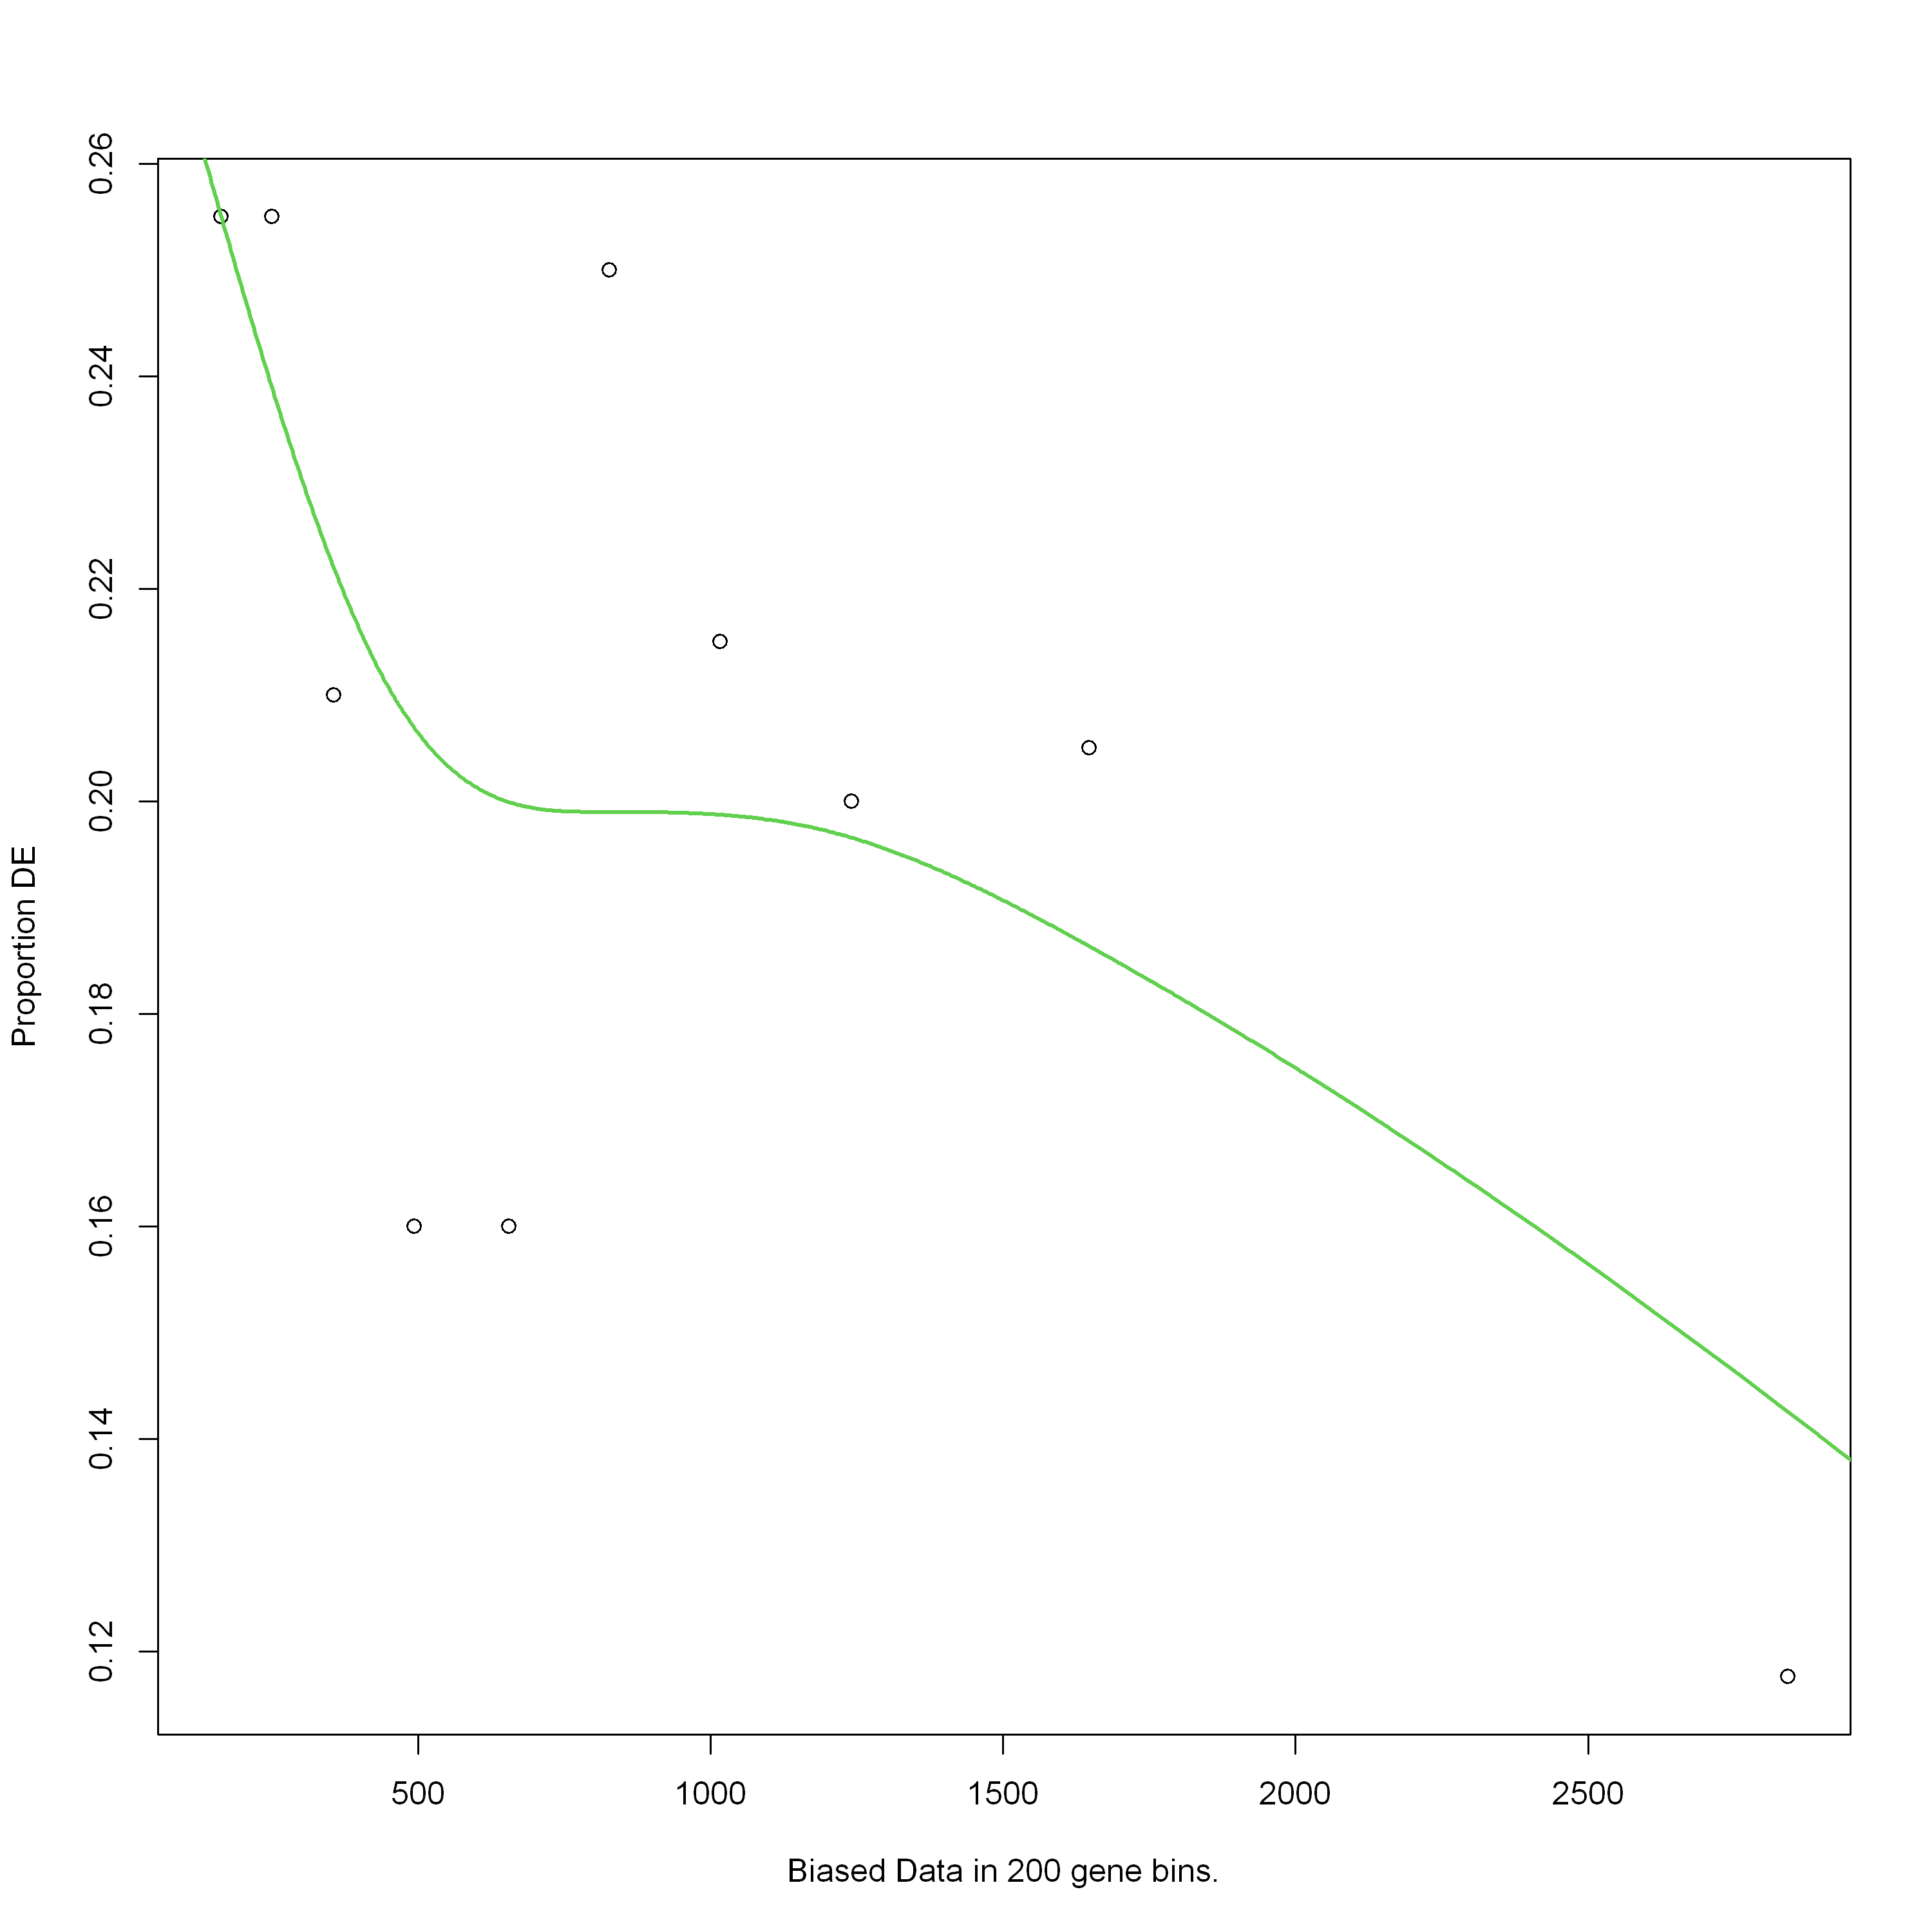

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


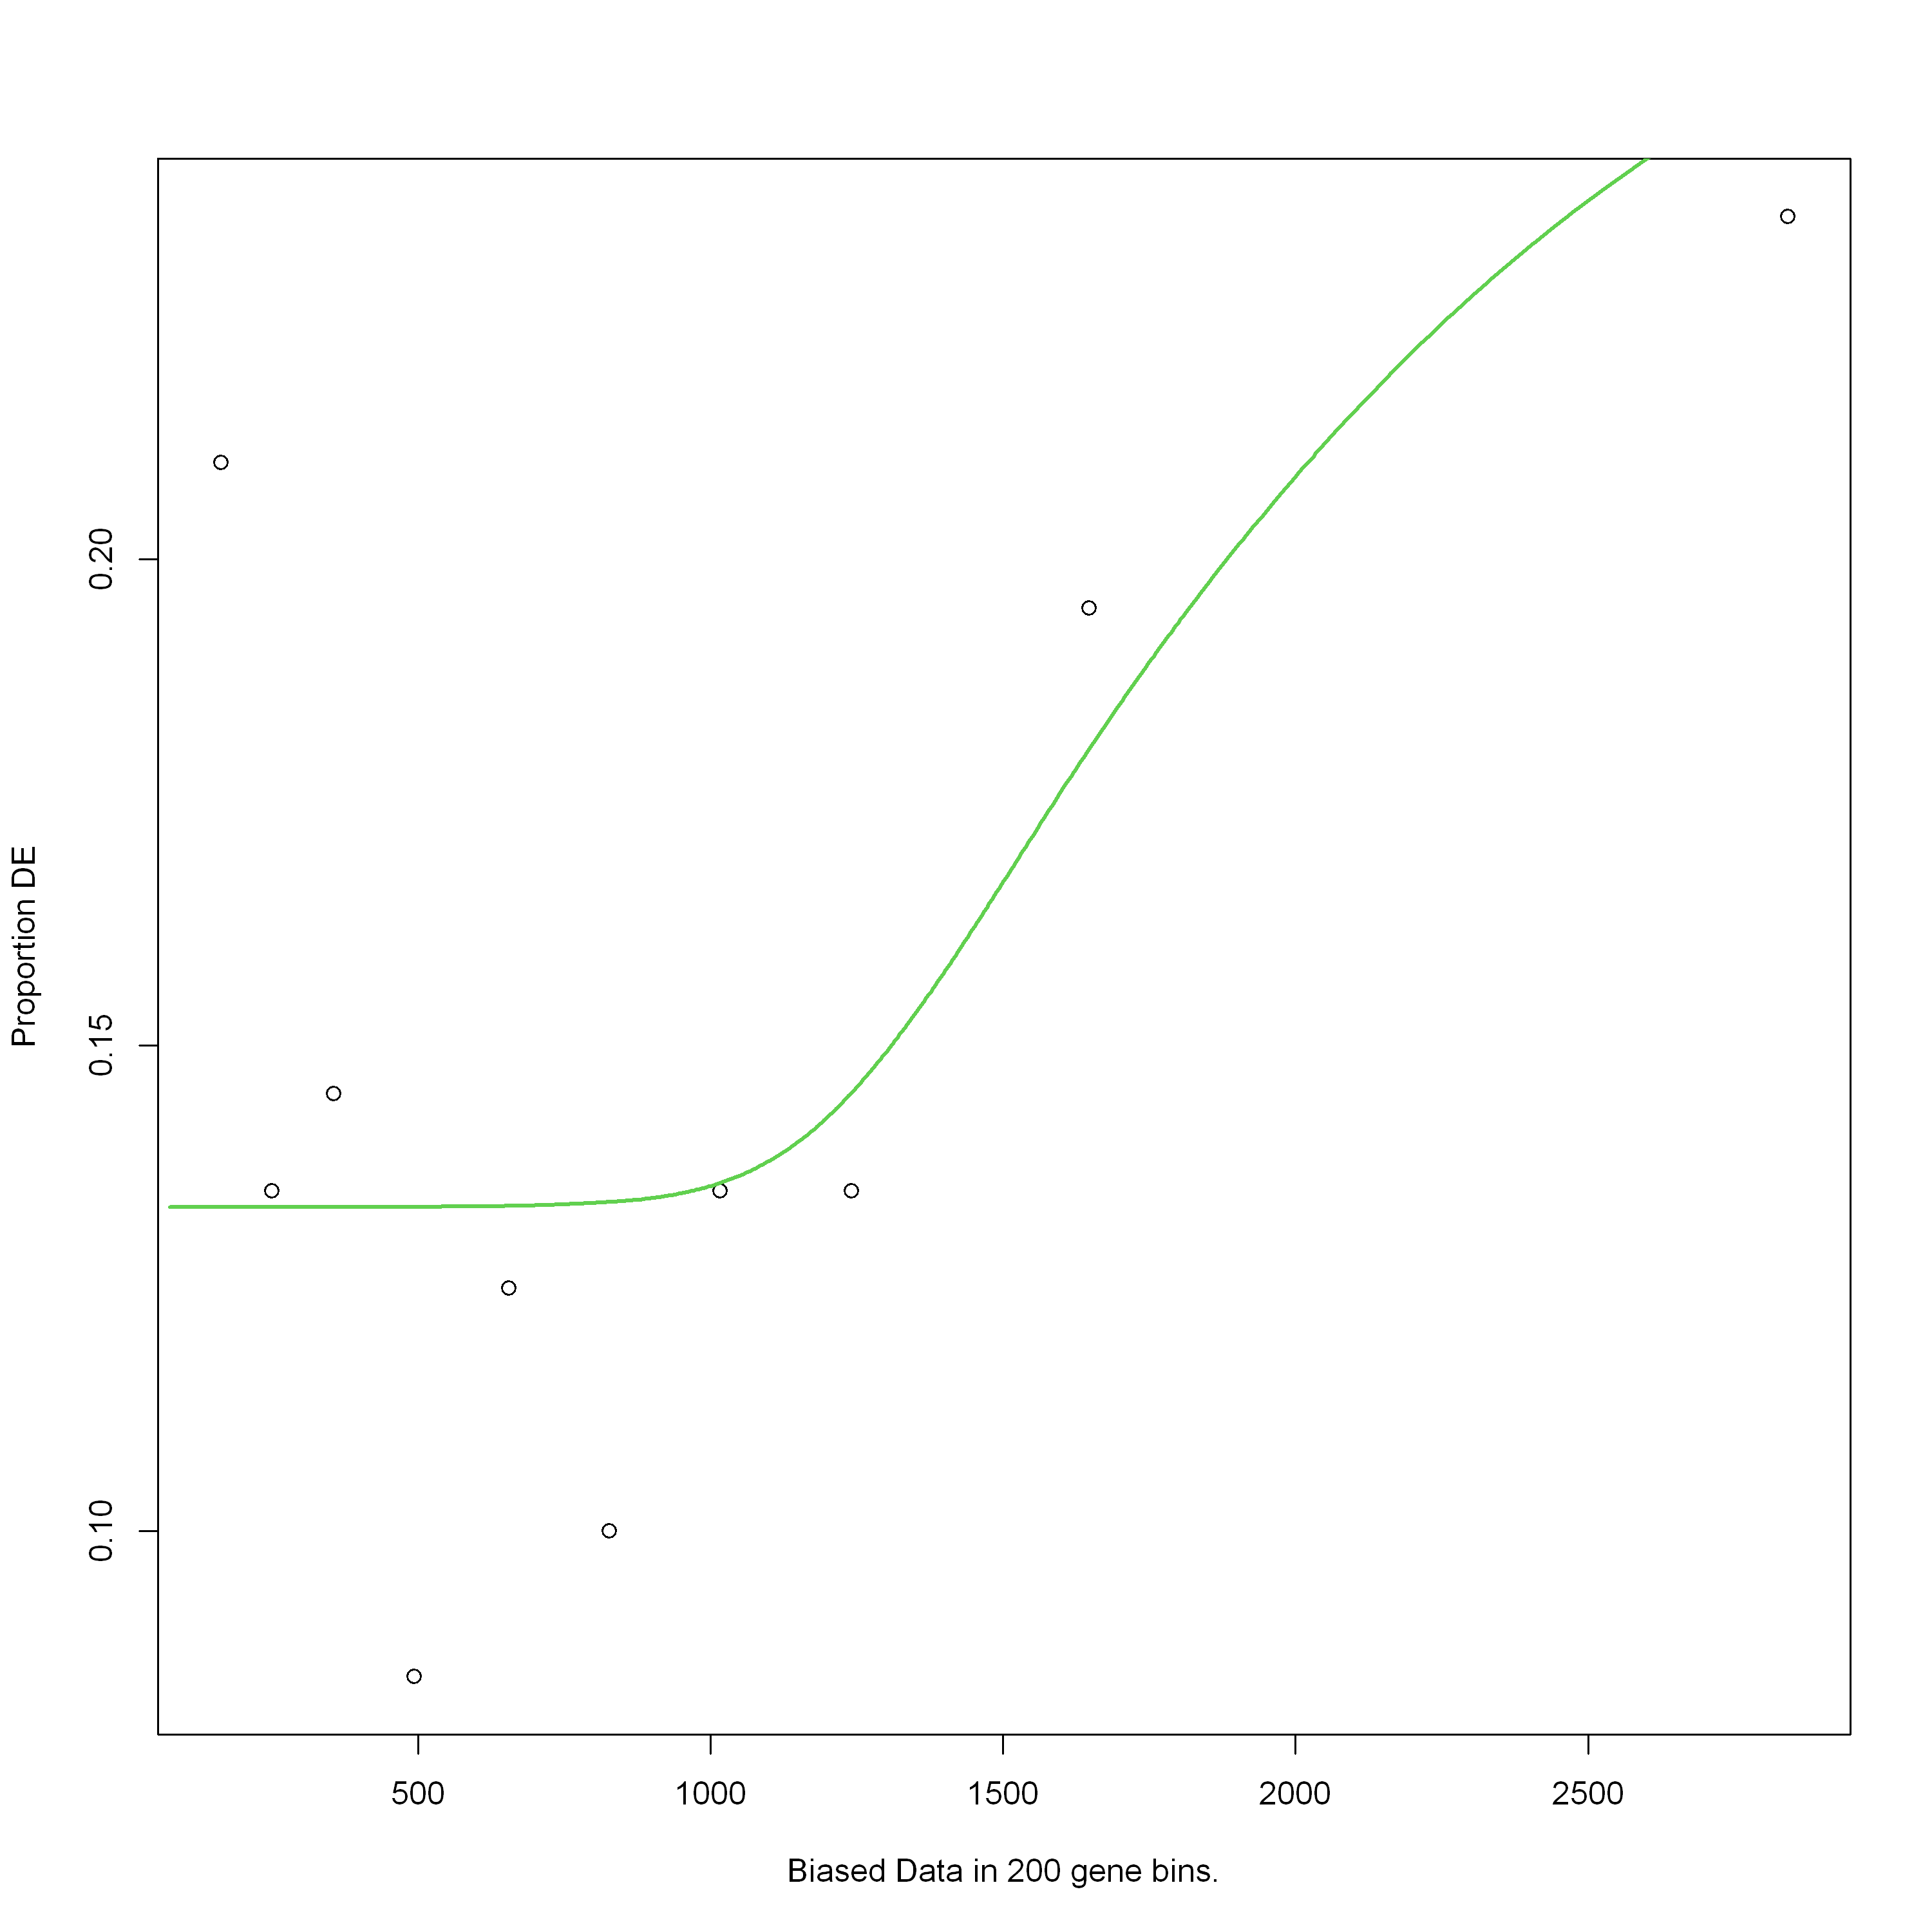

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



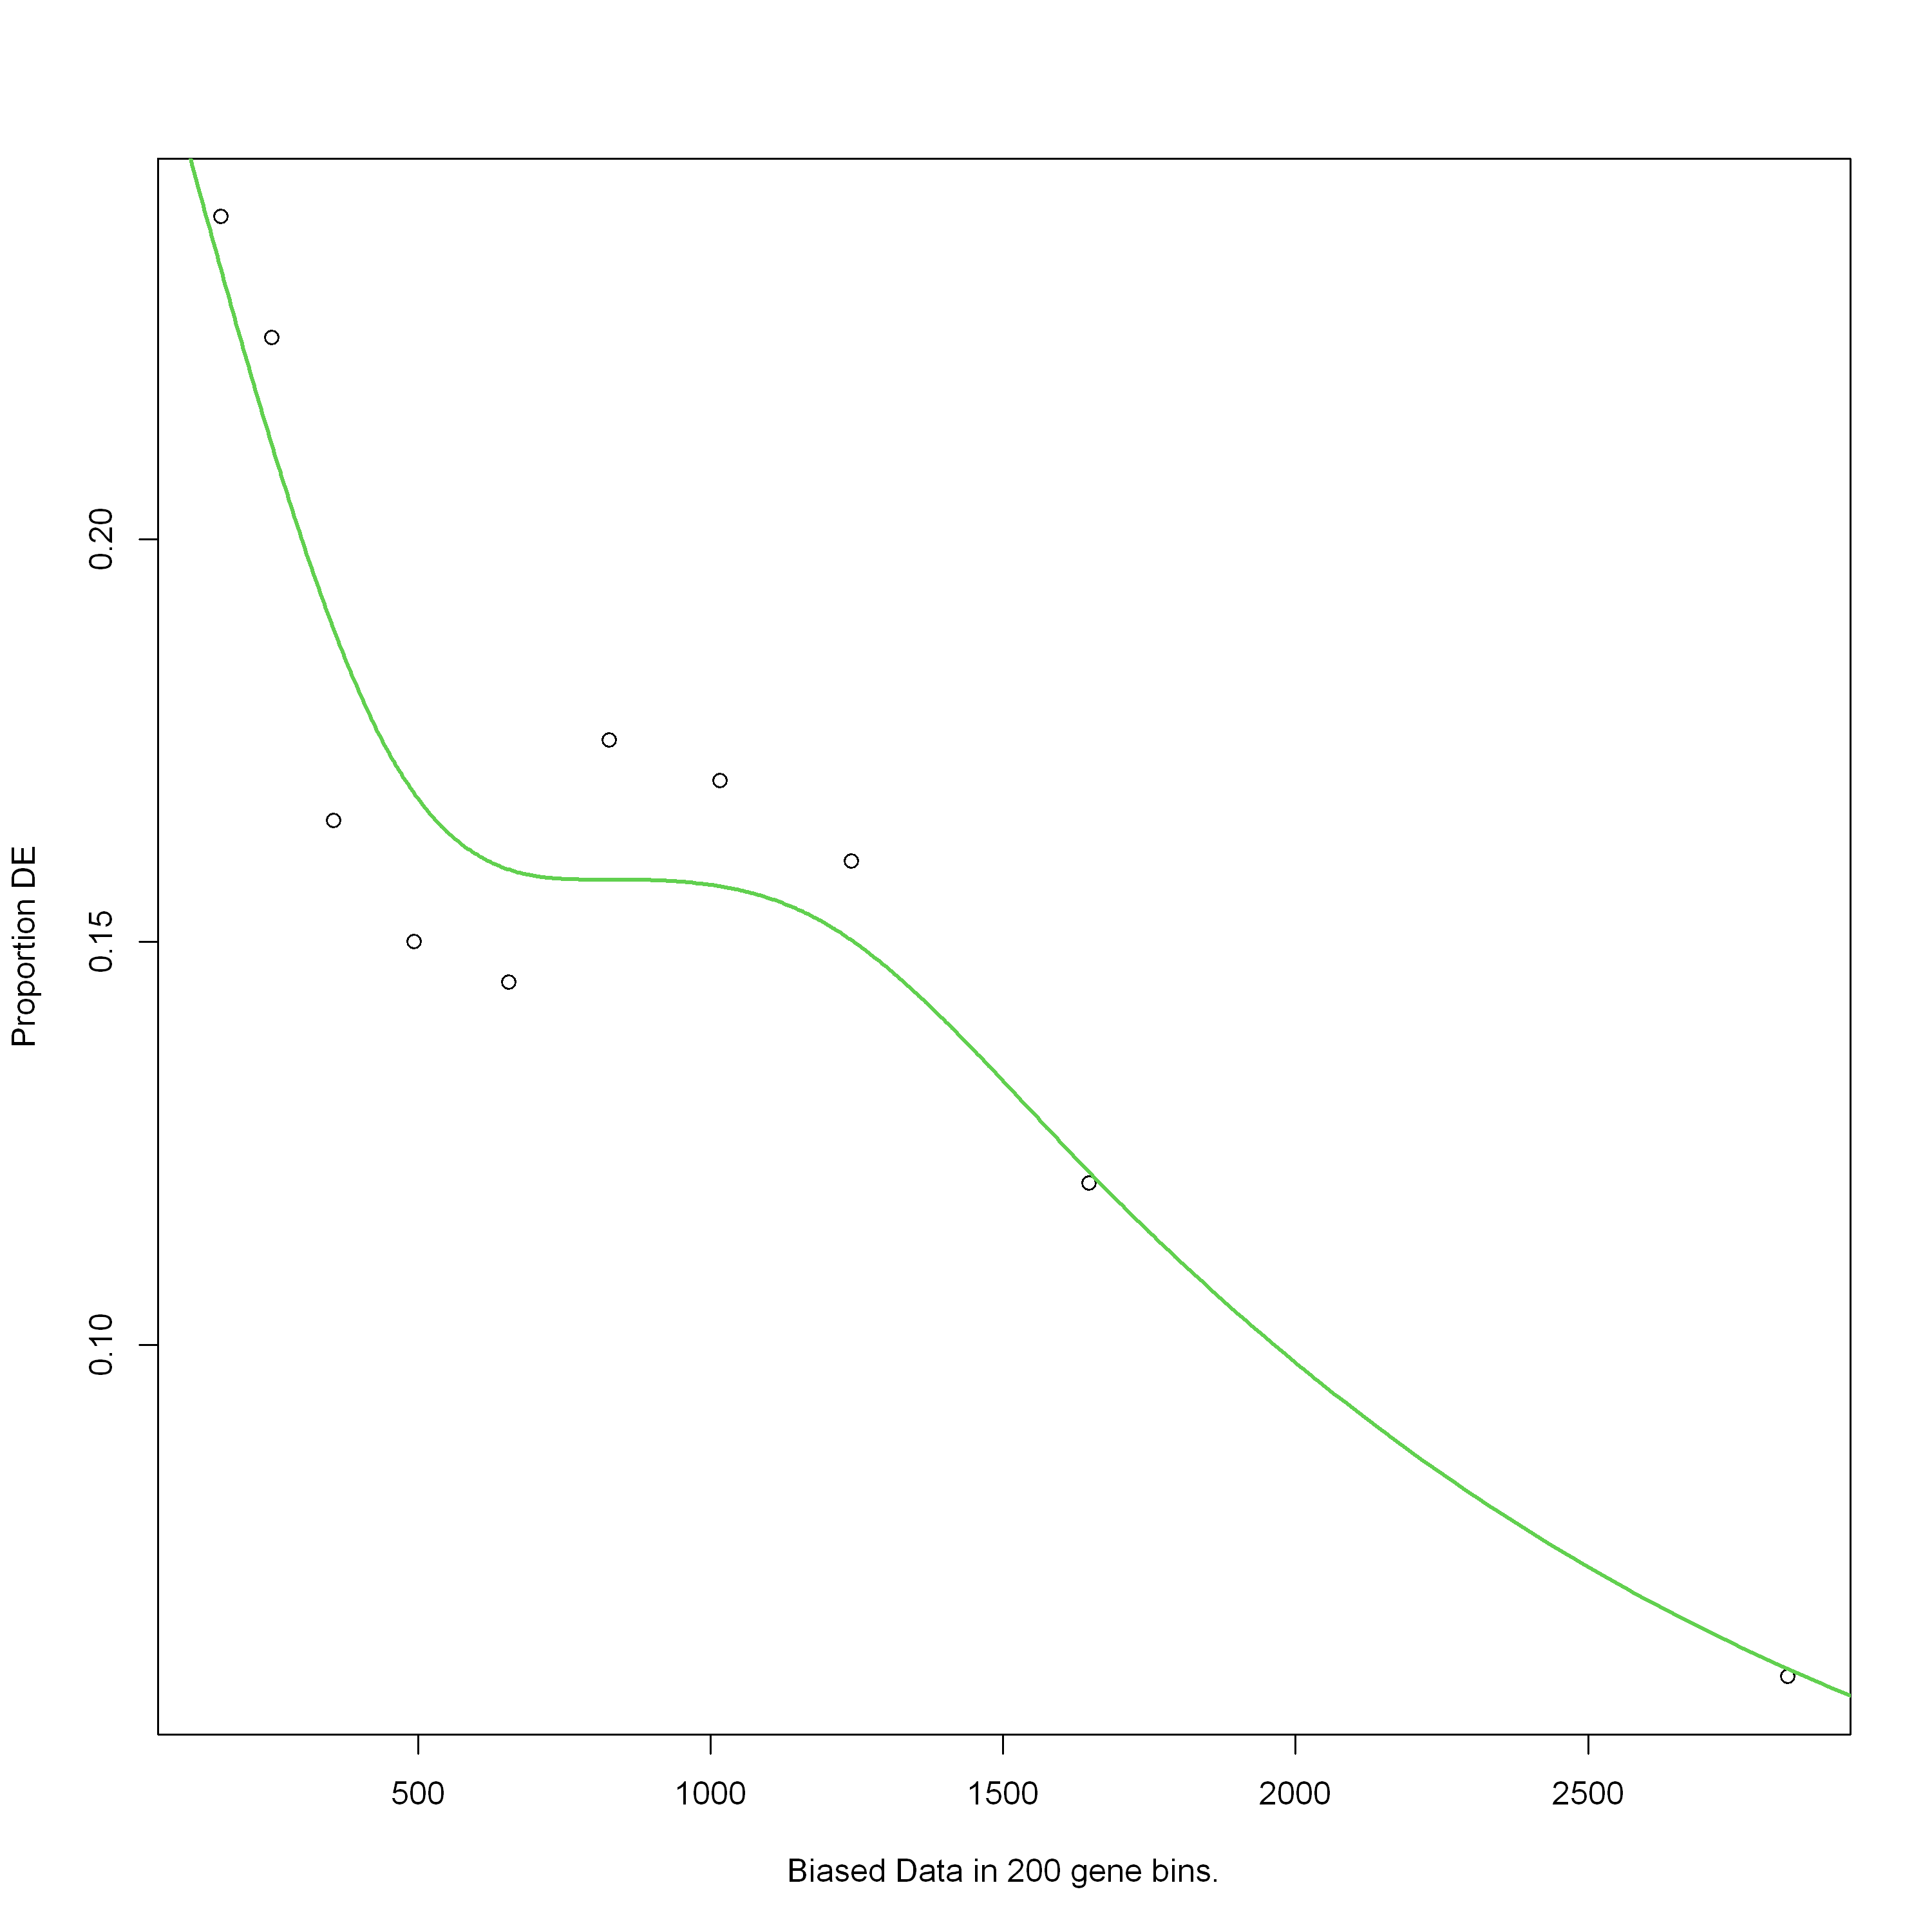

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


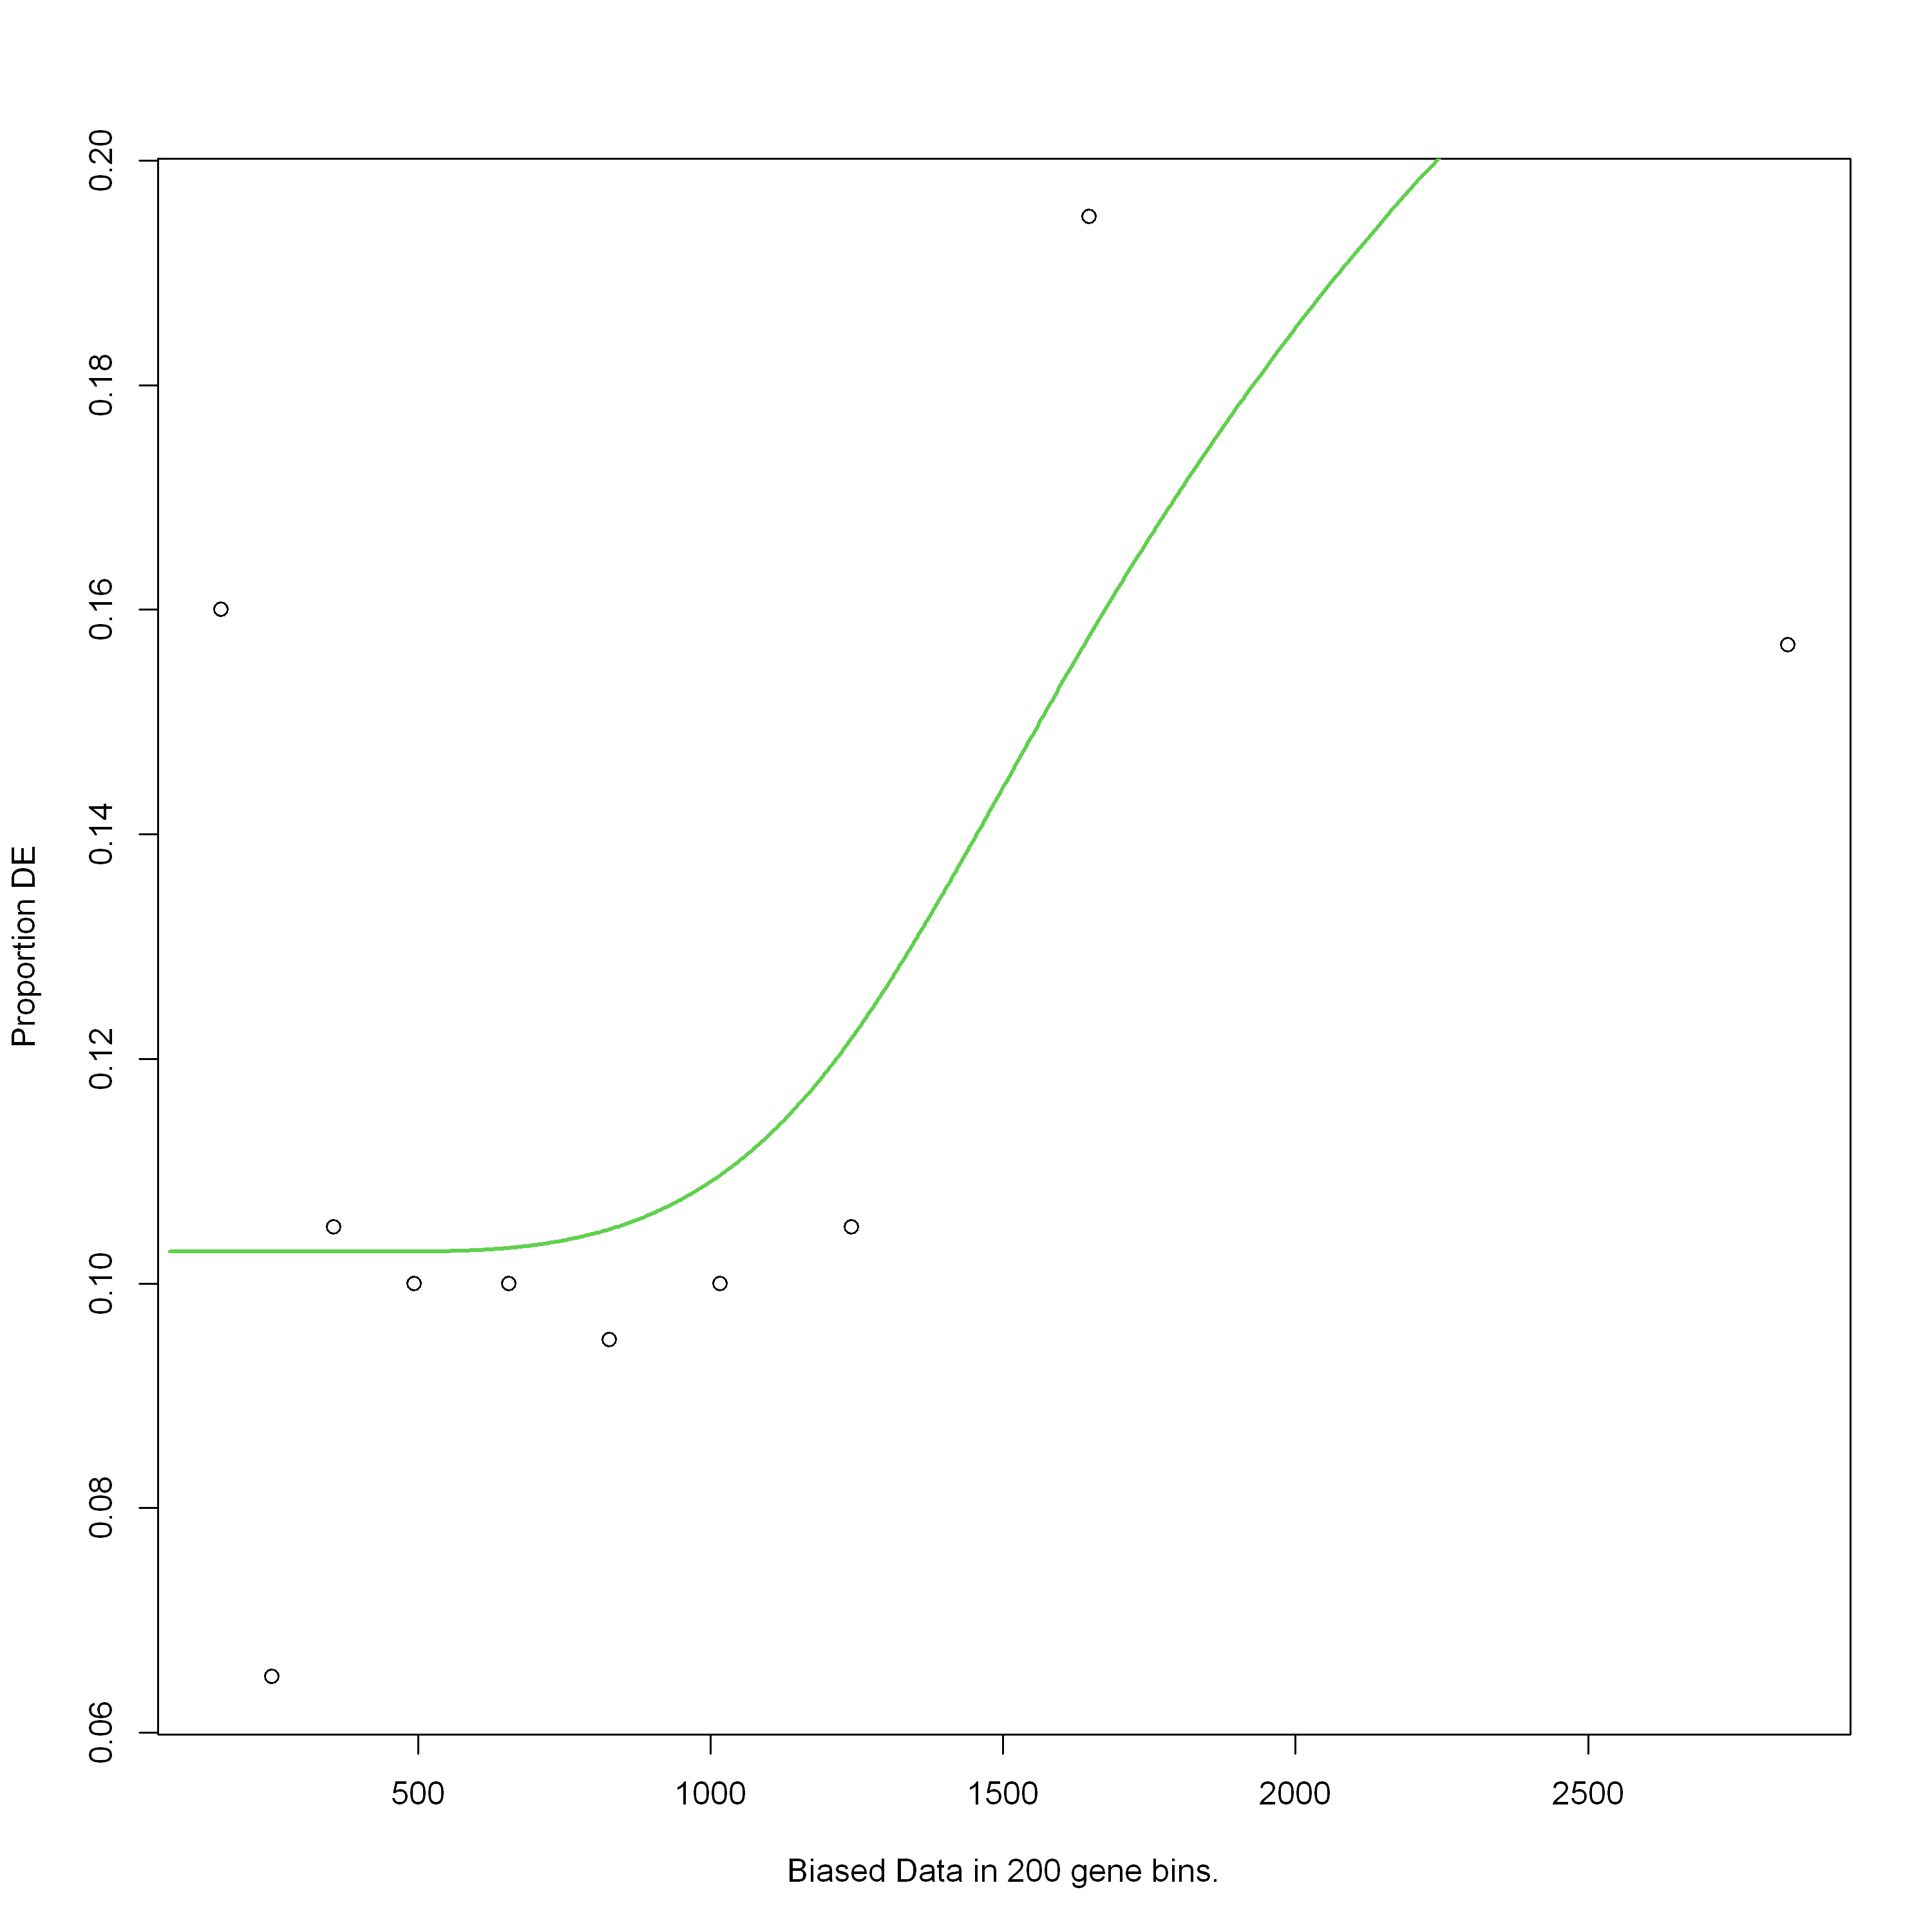

Using manually entered categories.

For 106 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



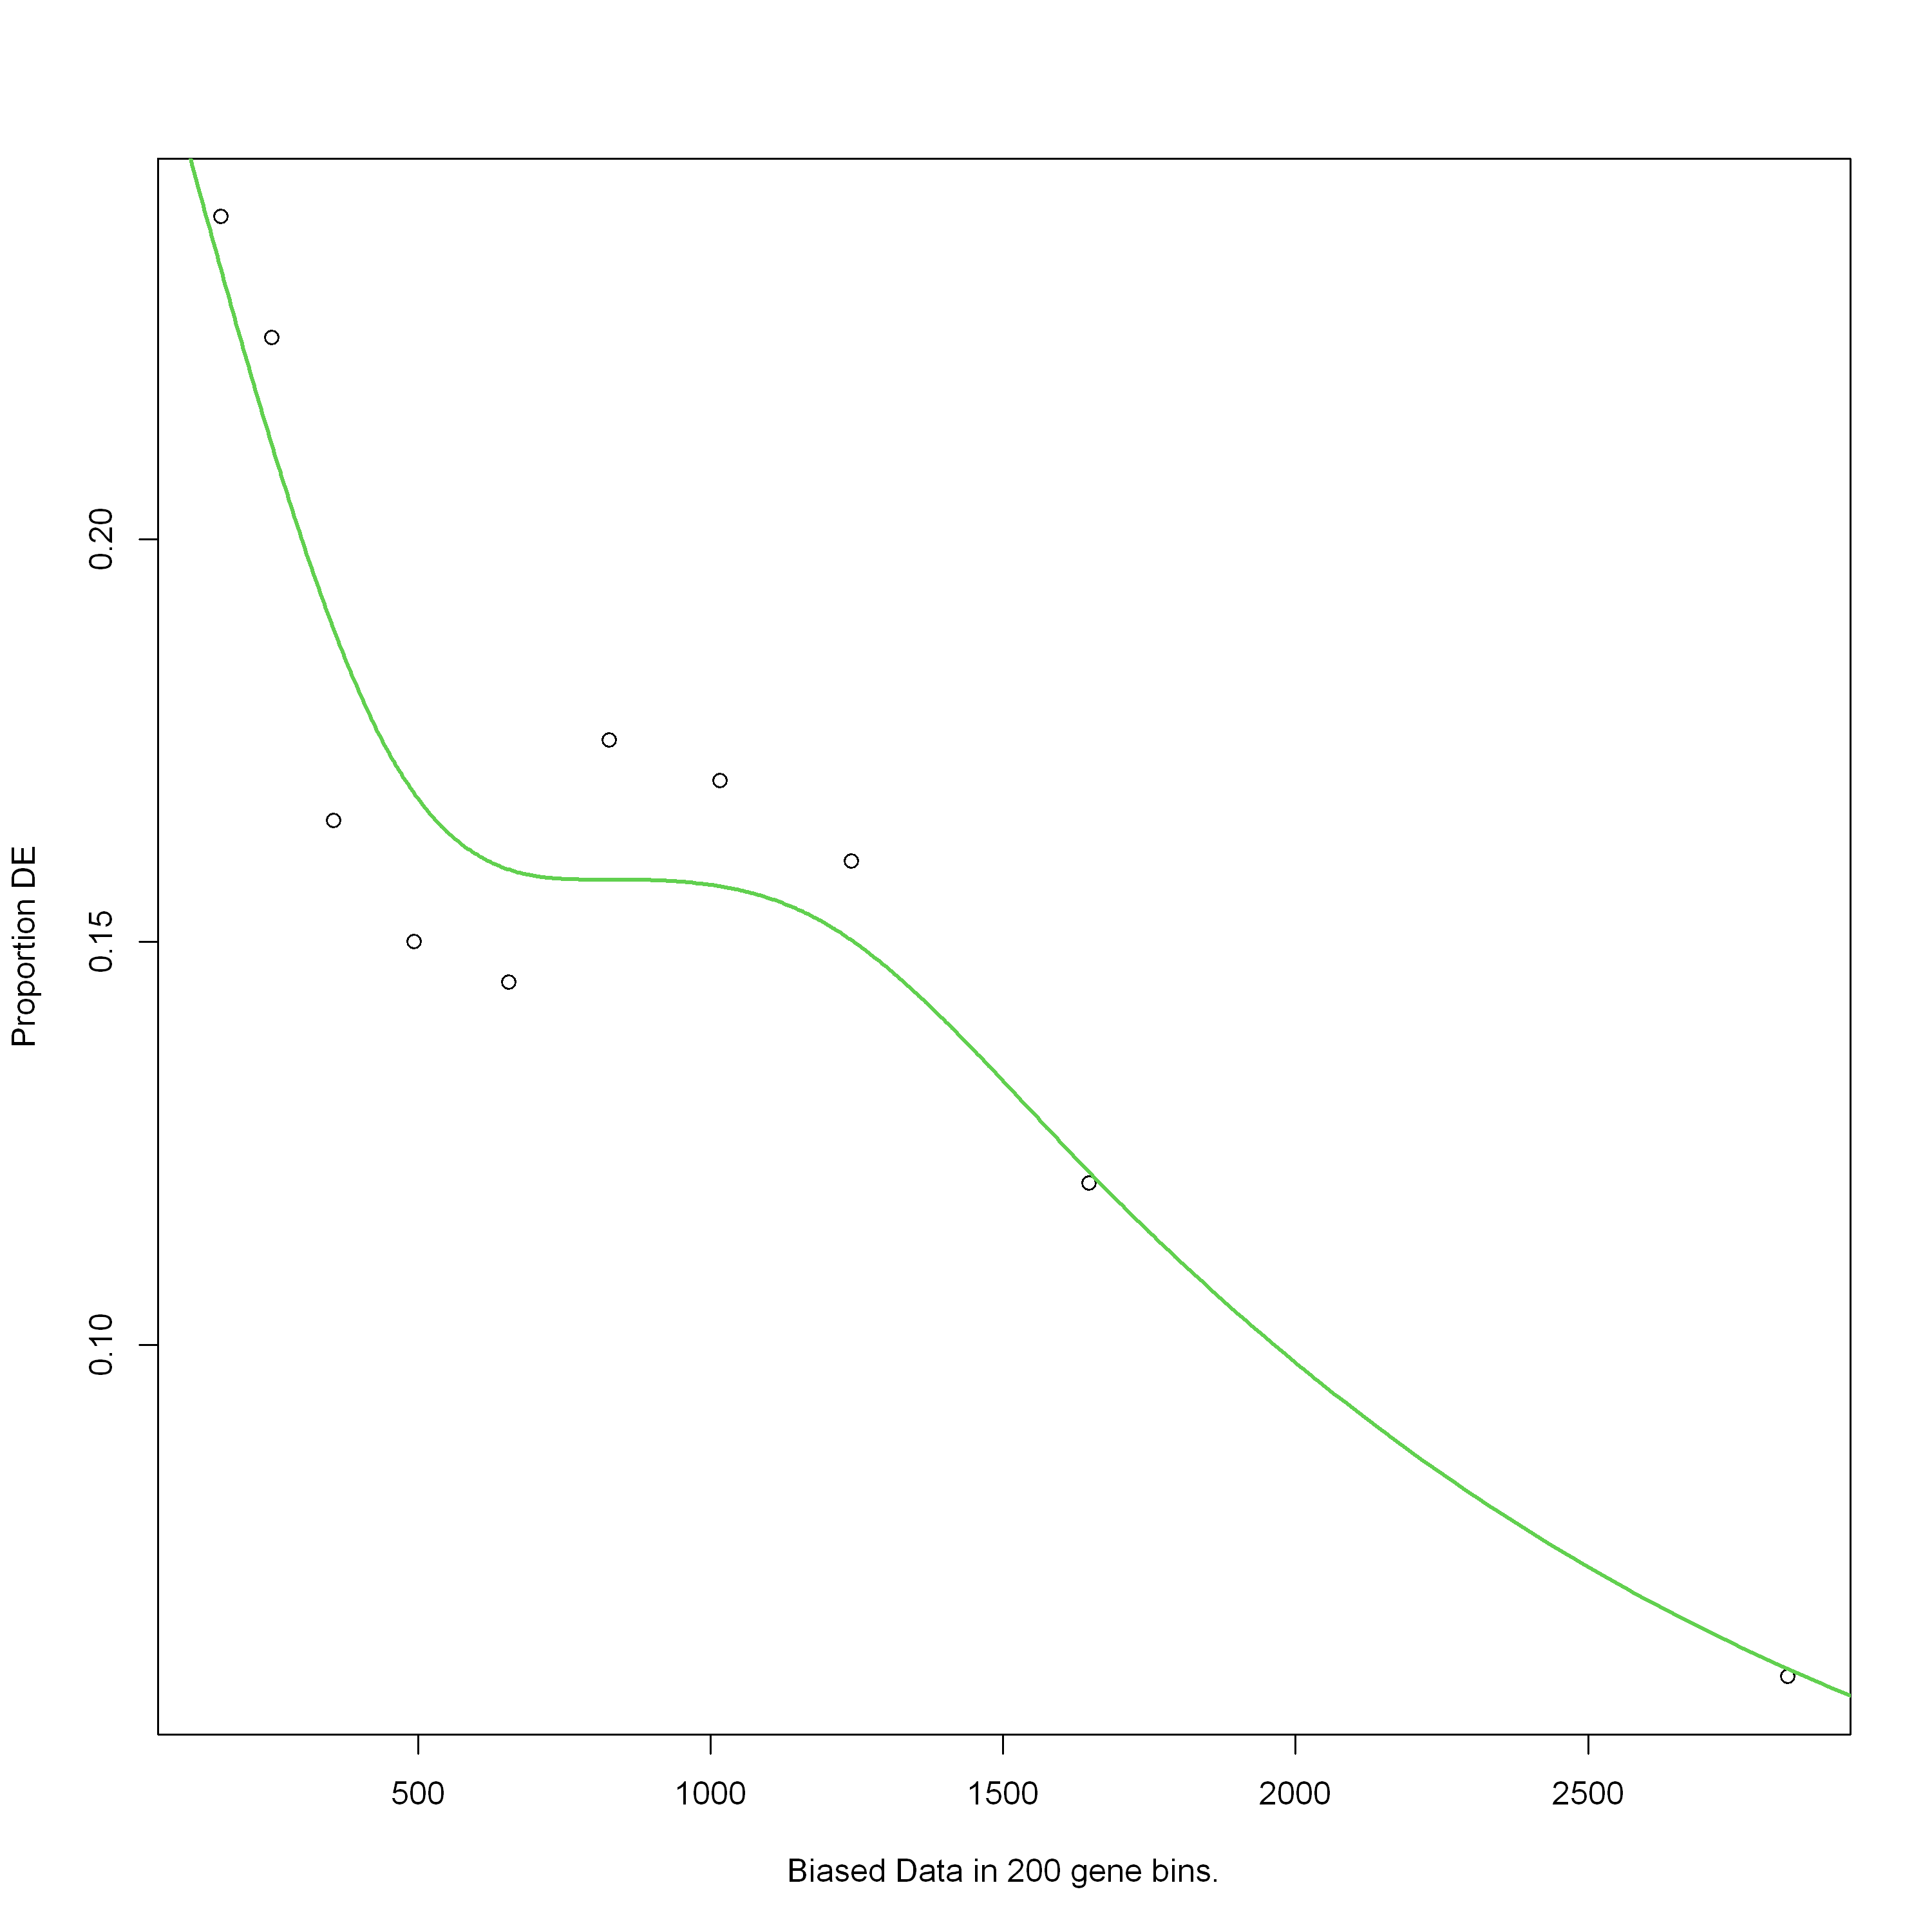

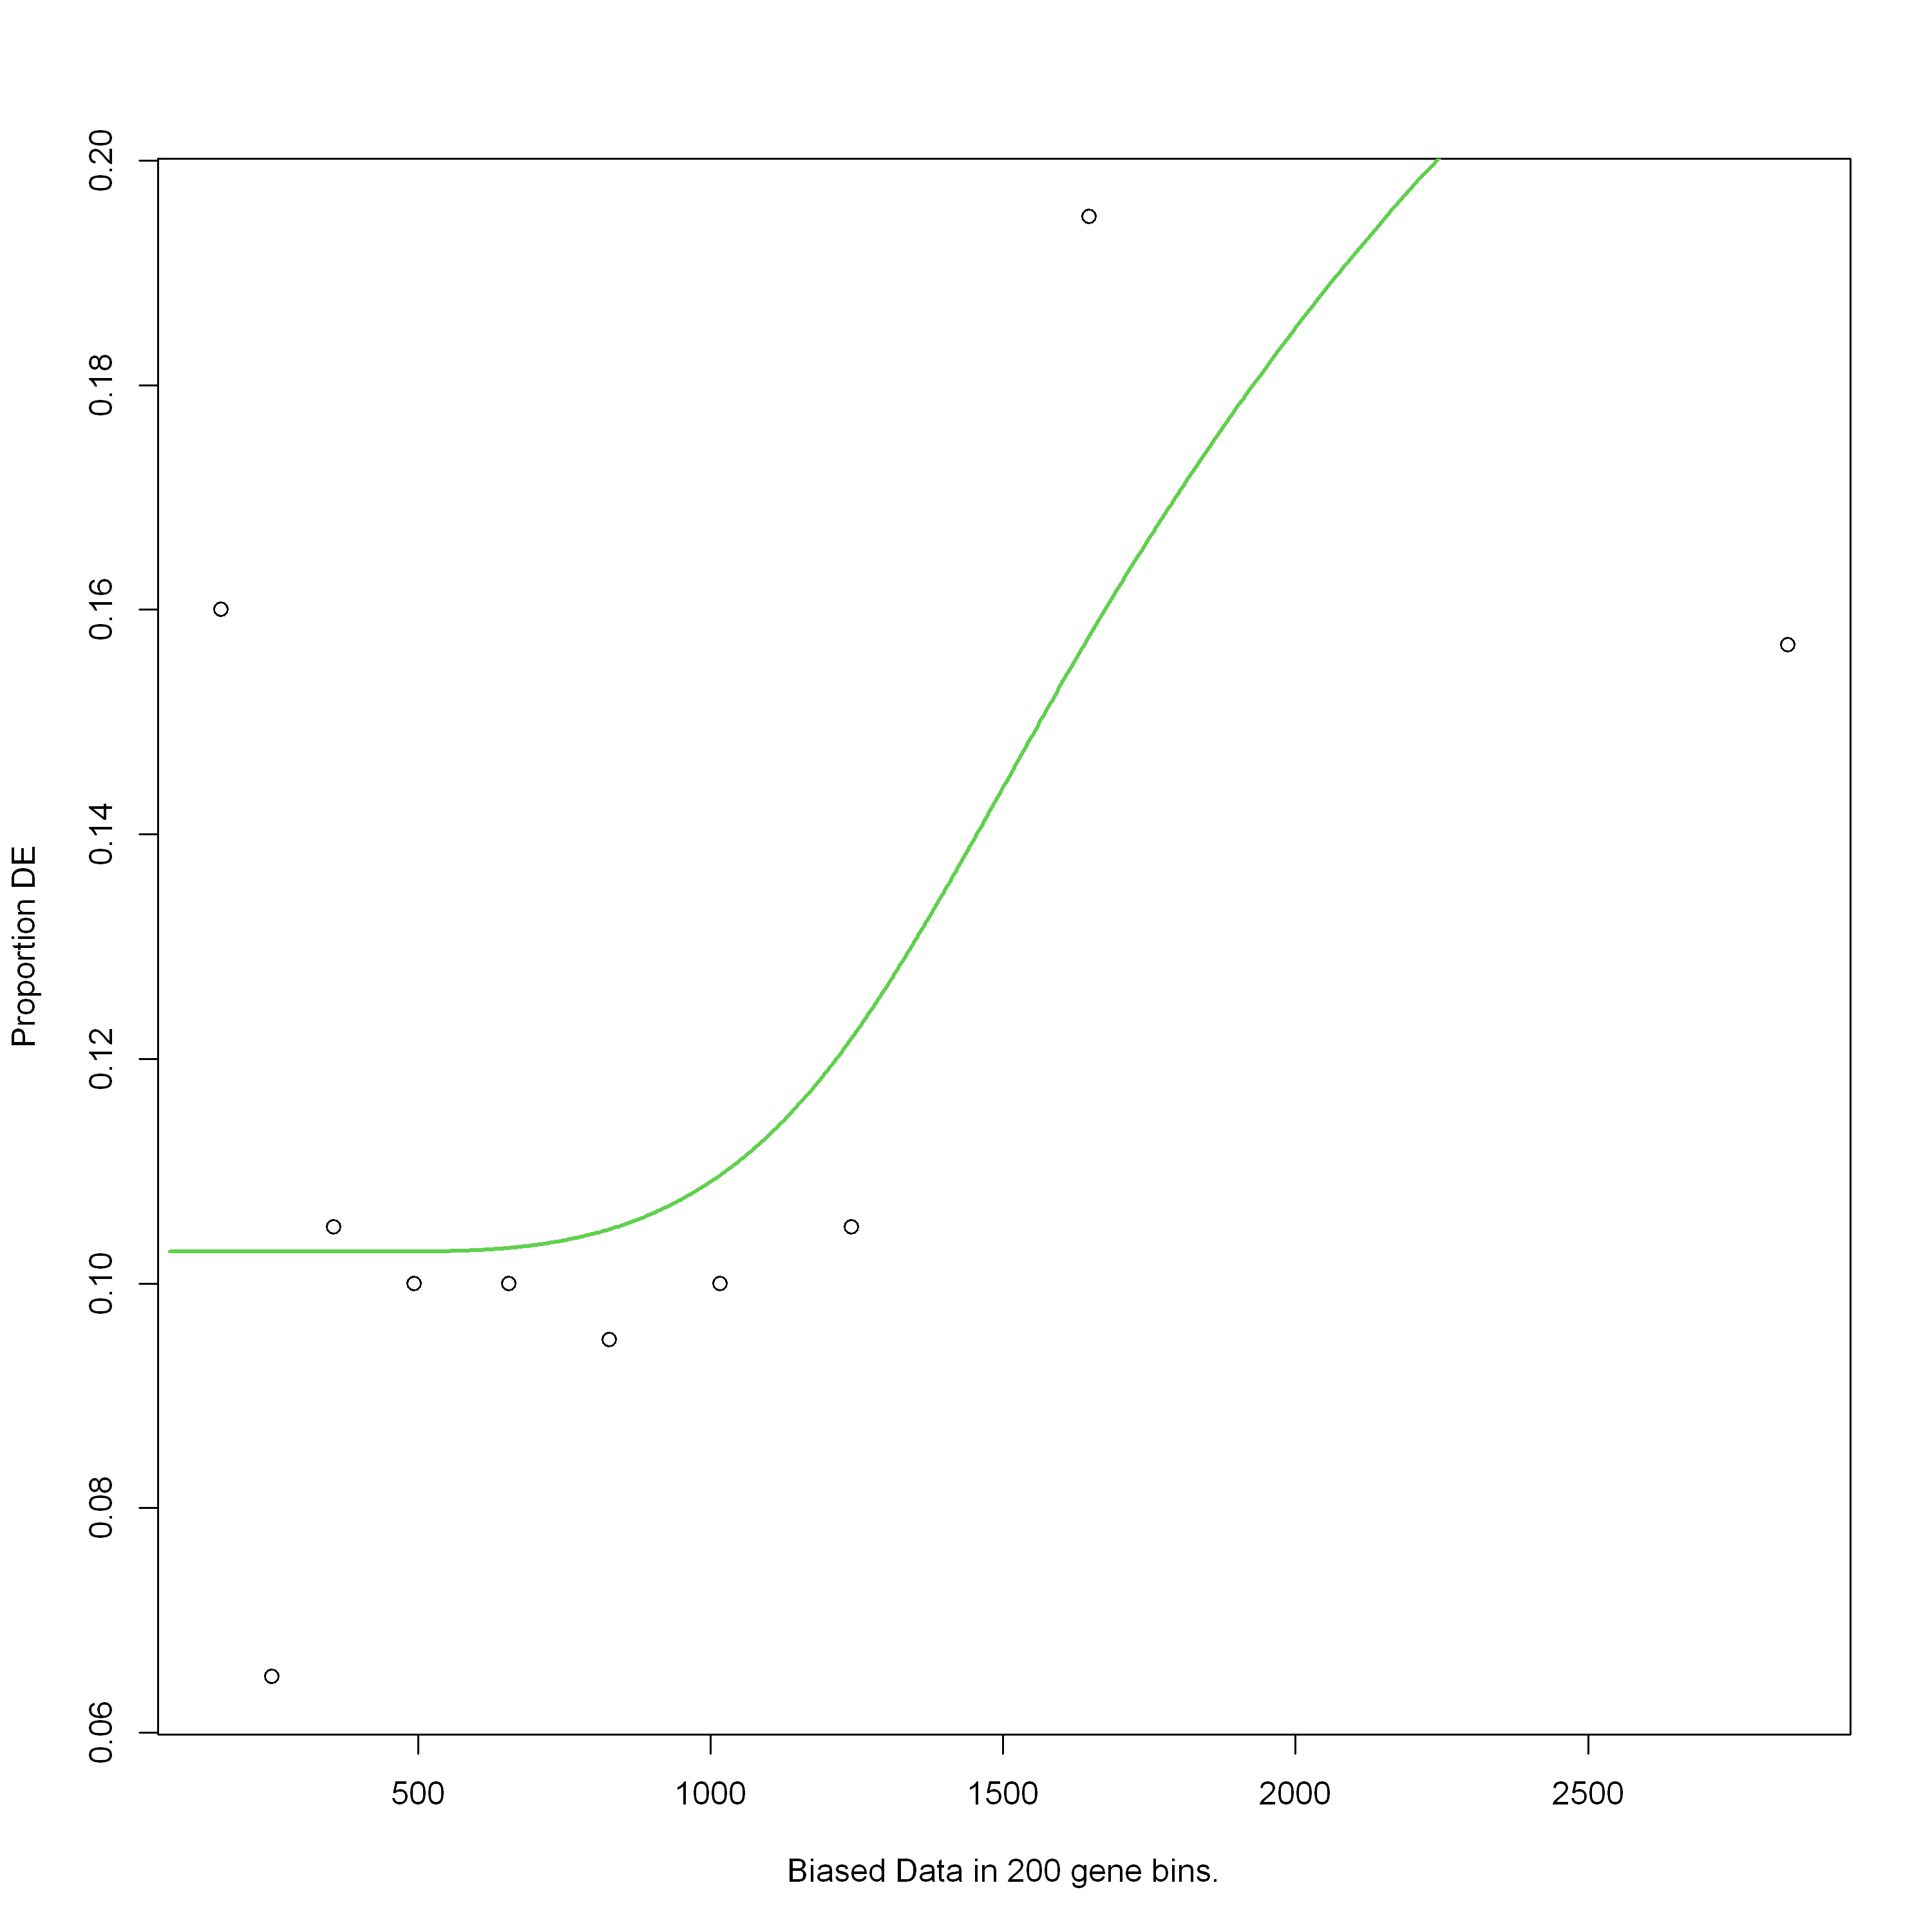

In [71]:
dlist = list()

for (contrastname in unique(df_all$contrast1)) 
{
    for (col in c('Pathways.of.gene', 'Ontology...pathway.type')  #, 'main','ecpath')
             ) 
        {
        for (test in c('down', 'up')) 
            {
              dlist[[length(dlist) + 1]] <- run_enrichment(contrastname, col, test)
        }

    }
}
goseq_res = bind_rows(dlist)


In [72]:
goseq_res %>% arrange(padj, over_represented_pvalue) %>% tail()

category                                                                              
2729 Aminoacyl-tRNA Charging                                                               
2730 Amino Acid Degradation                                                                
2731 <i>trans</i>-lycopene biosynthesis II (oxygenic phototrophs and green sulfur bacteria)
2732 tetrapyrrole biosynthesis I (from glutamate)                                          
2733 5-aminoimidazole ribonucleotide biosynthesis II                                       
2734 partial TCA cycle (obligate autotrophs)                                               
     over_represented_pvalue padj under_represented_pvalue numDEInCat numInCat
2729 1                       1    0.62621487               0          29      
2730 1                       1    0.81169902               0          21      
2731 1                       1    0.14078025               0           5      
2732 1                       1    0.07238664               0           6      
2733 1                       1    0.04019634               0           8      
2734 1                       1    0.06755270               0           7      
     type enrich                  contrast   organism
2729 down Ontology...pathway.type C2vsC1_rna MED4    
2730 up   Ontology...pathway.type C2vsC1_rna MED4    
2731 down Pathways.of.gene        P2vsP1_rna MED4    
2732 up   Pathways.of.gene        P2vsP1_rna MED4    
2733 down Pathways.of.gene        P2vsP1_rna MED4    
2734 down Pathways.of.gene        P2vsP1_rna MED4

In [73]:
table(goseq_res$enrich)


Ontology...pathway.type        Pathways.of.gene 
                    616                    2118 

In [74]:
goseq_res1 = goseq_res

In [75]:
goseq_res = goseq_res %>%
    mutate(
        pathway = category,
        #module = Ontology...pathway.type 
    )

In [102]:
goseq_res = goseq_res %>%
    mutate(
        pathway = str_replace(pathway, '<i>', ''),
        pathway = str_replace(pathway, '</i>', ''),
        pathway = str_replace(pathway, 'superpathway of ', ''),
        #module = Ontology...pathway.type 
    )

In [103]:
goseq_res %>% arrange(padj, over_represented_pvalue) %>% head()

category                       over_represented_pvalue padj        
1 oxygenic photosynthesis        6.371630e-14            4.778722e-12
2 photosynthesis light reactions 6.680910e-11            2.505341e-09
3 oxygenic photosynthesis        1.477599e-09            1.108199e-07
4 oxygenic photosynthesis        6.267160e-09            4.449684e-07
5 oxygenic photosynthesis        6.818599e-09            5.113950e-07
6 photosynthesis light reactions 7.230160e-09            5.133414e-07
  under_represented_pvalue numDEInCat numInCat type enrich          
1 1                        43         51       down Pathways.of.gene
2 1                        33         39       down Pathways.of.gene
3 1                        22         51       down Pathways.of.gene
4 1                        25         38       down Pathways.of.gene
5 1                        30         51       down Pathways.of.gene
6 1                        19         26       down Pathways.of.gene
  contrast       organism pathway                       
1 P2vsP1_rna     MED4     oxygenic photosynthesis       
2 P2vsP1_rna     MED4     photosynthesis light reactions
3 LATEvsC1P1_rna MED4     oxygenic photosynthesis       
4 C5vsC1_prot    MED4     oxygenic photosynthesis       
5 C4vsC1_rna     MED4     oxygenic photosynthesis       
6 C3vsC1_prot    MED4     photosynthesis light reactions

In [104]:
goseq_res %>% 
    filter(padj < 0.05) %>%
    distinct(pathway)

pathway                                                                        
1  partial TCA cycle (obligate autotrophs)                                        
2  5-aminoimidazole ribonucleotide biosynthesis I                                 
3  5-aminoimidazole ribonucleotide biosynthesis II                                
4  5-aminoimidazole ribonucleotide biosynthesis                                   
5  L-arginine biosynthesis I (via L-ornithine)                                    
6  L-arginine biosynthesis II (acetyl cycle)                                      
7  Amino Acid Biosynthesis                                                        
8  Nucleoside and Nucleotide Biosynthesis                                         
9  photosynthesis light reactions                                                 
10 oxygenic photosynthesis                                                        
11 protective electron sinks in the thylakoid membrane                            
12 Generation of Precursor Metabolites and Energy                                 
13 3,8-divinyl-chlorophyllide a biosynthesis I (aerobic, light-dependent)         
14 Fatty Acid and Lipid Biosynthesis                                              
15 Entner-Doudoroff pathway I                                                     
16 L-histidine biosynthesis                                                       
17 Carbohydrate Degradation                                                       
18 Amino Acid Degradation                                                         
19 Aminoacyl-tRNA Charging                                                        
20 Carbohydrate Biosynthesis                                                      
21 Calvin-Benson-Bassham cycle                                                    
22 sucrose biosynthesis I (from photosynthesis)                                   
23 gluconeogenesis I                                                              
24 3,8-divinyl-chlorophyllide a biosynthesis III (aerobic, light independent)     
25 trans-lycopene biosynthesis II (oxygenic phototrophs and green sulfur bacteria)
26 C1 Compound Utilization and Assimilation                                       
27 Tetrapyrrole Biosynthesis                                                      
28 Secondary Metabolite Biosynthesis                                              
29 ATP biosynthesis                                                               
30 S-adenosyl-L-methionine biosynthesis                                           
31 L-methionine biosynthesis (transsulfuration)                                   
32 L-homoserine and L-methionine biosynthesis

In [105]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

Assay Group      
C1vsP1_rna     rna   Coculture  
C2vsC1_rna     rna   Coculture  
C3vsC1_rna     rna   Coculture  
C4vsC1_rna     rna   Coculture  
C5vsC1_rna     rna   Coculture  
LATEvsC1P1_rna rna   Coculture  
C2vsC1_prot    prot  Coculture  
C3vsC1_prot    prot  Coculture  
C4vsC1_prot    prot  Coculture  
C5vsC1_prot    prot  Coculture  
LATEvsC1_prot  prot  Coculture  
P2vsP1_rna     rna   Axenic     
P2vsP1_prot    prot  Axenic     
P3vsP1_prot    prot  Axenic late
P5vsP1_prot    prot  Axenic late

In [106]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [107]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [108]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [109]:
unique(goseq_res$enrich)

[1] "Pathways.of.gene"        "Ontology...pathway.type"

Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."


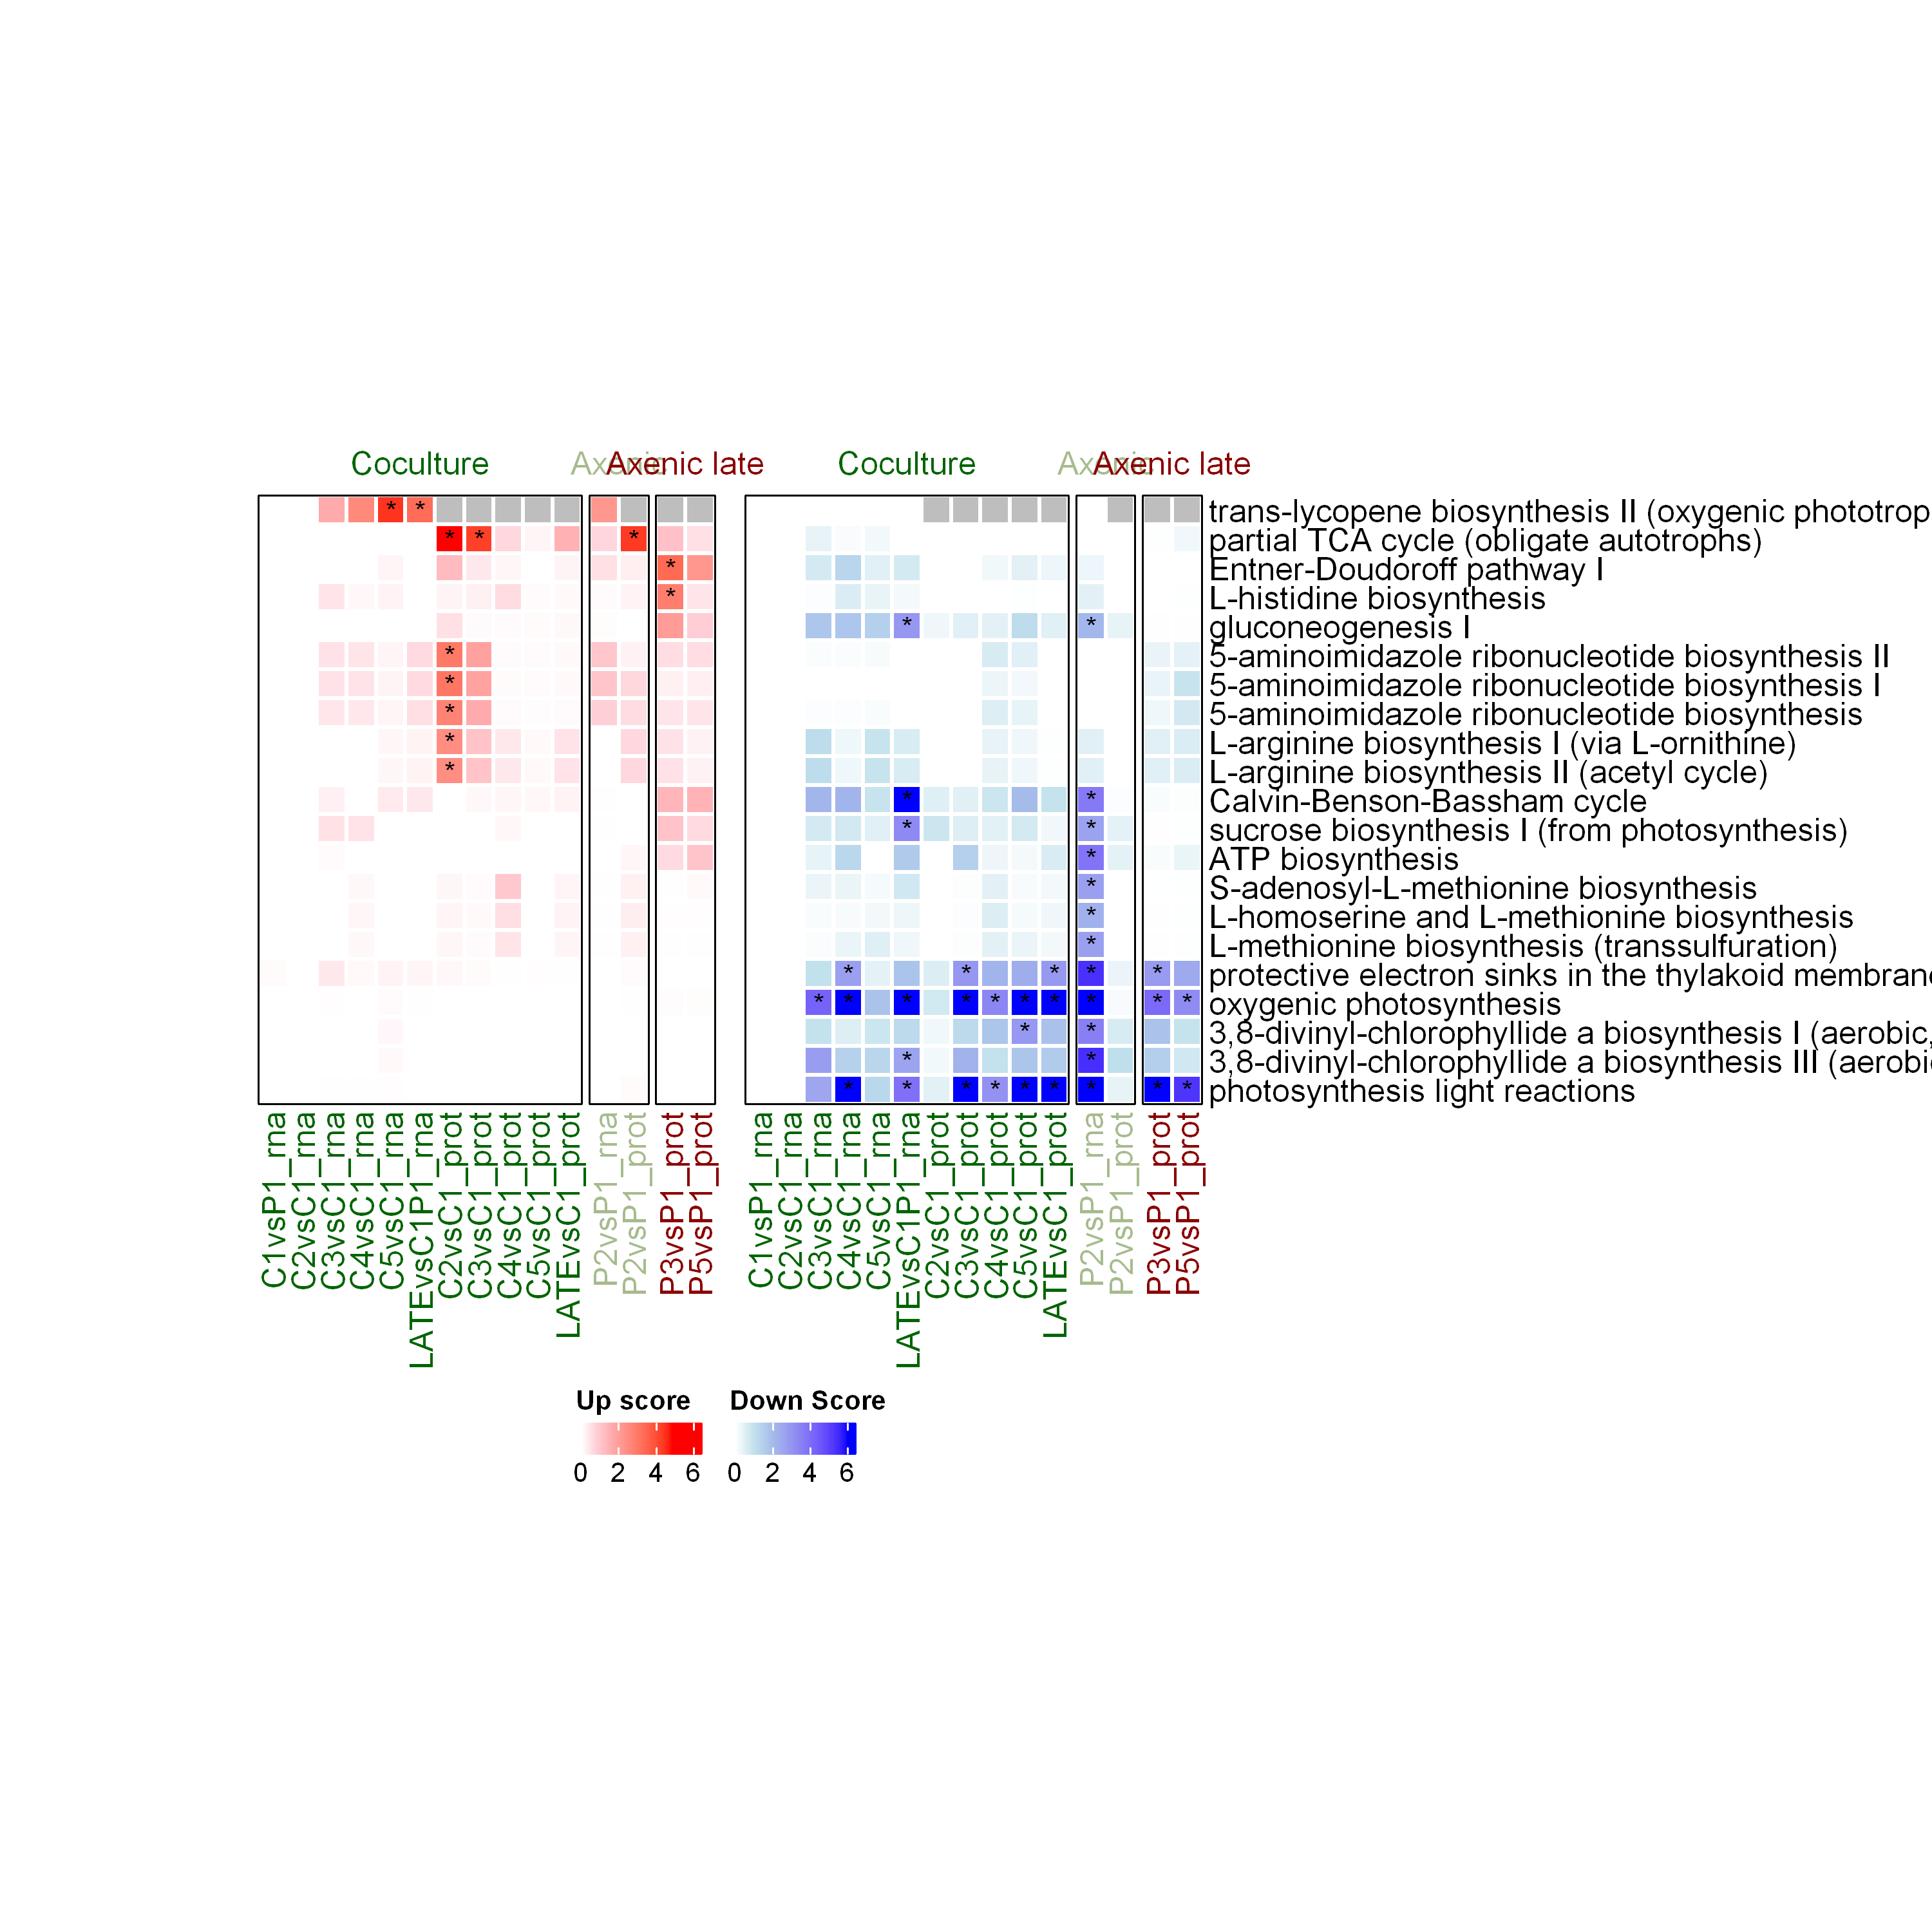

In [110]:
toppaths = goseq_res %>% 
    filter(enrich=='Pathways.of.gene', 
           padj < 0.05) %>% 
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

# module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
#     distinct(pathway, module) %>%
#     arrange(pathway) %>%
#     column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway, values_fill = '') %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway, values_fill = '') %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    #row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(8, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
        
    #row_labels = gt_render(letters[1:10], padding = unit(c(2, 10, 2, 10), "pt")),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Down Score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

#gene_type_col = 
# ann_mat = Heatmap(
#     module_mat, 
#     name='Module',
#     width=unit(0.5, 'cm'),
#     heatmap_legend_param = list(direction = "horizontal", ncol=3),
#     col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
#     row_title=FALSE,
# )

ht_list = up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."


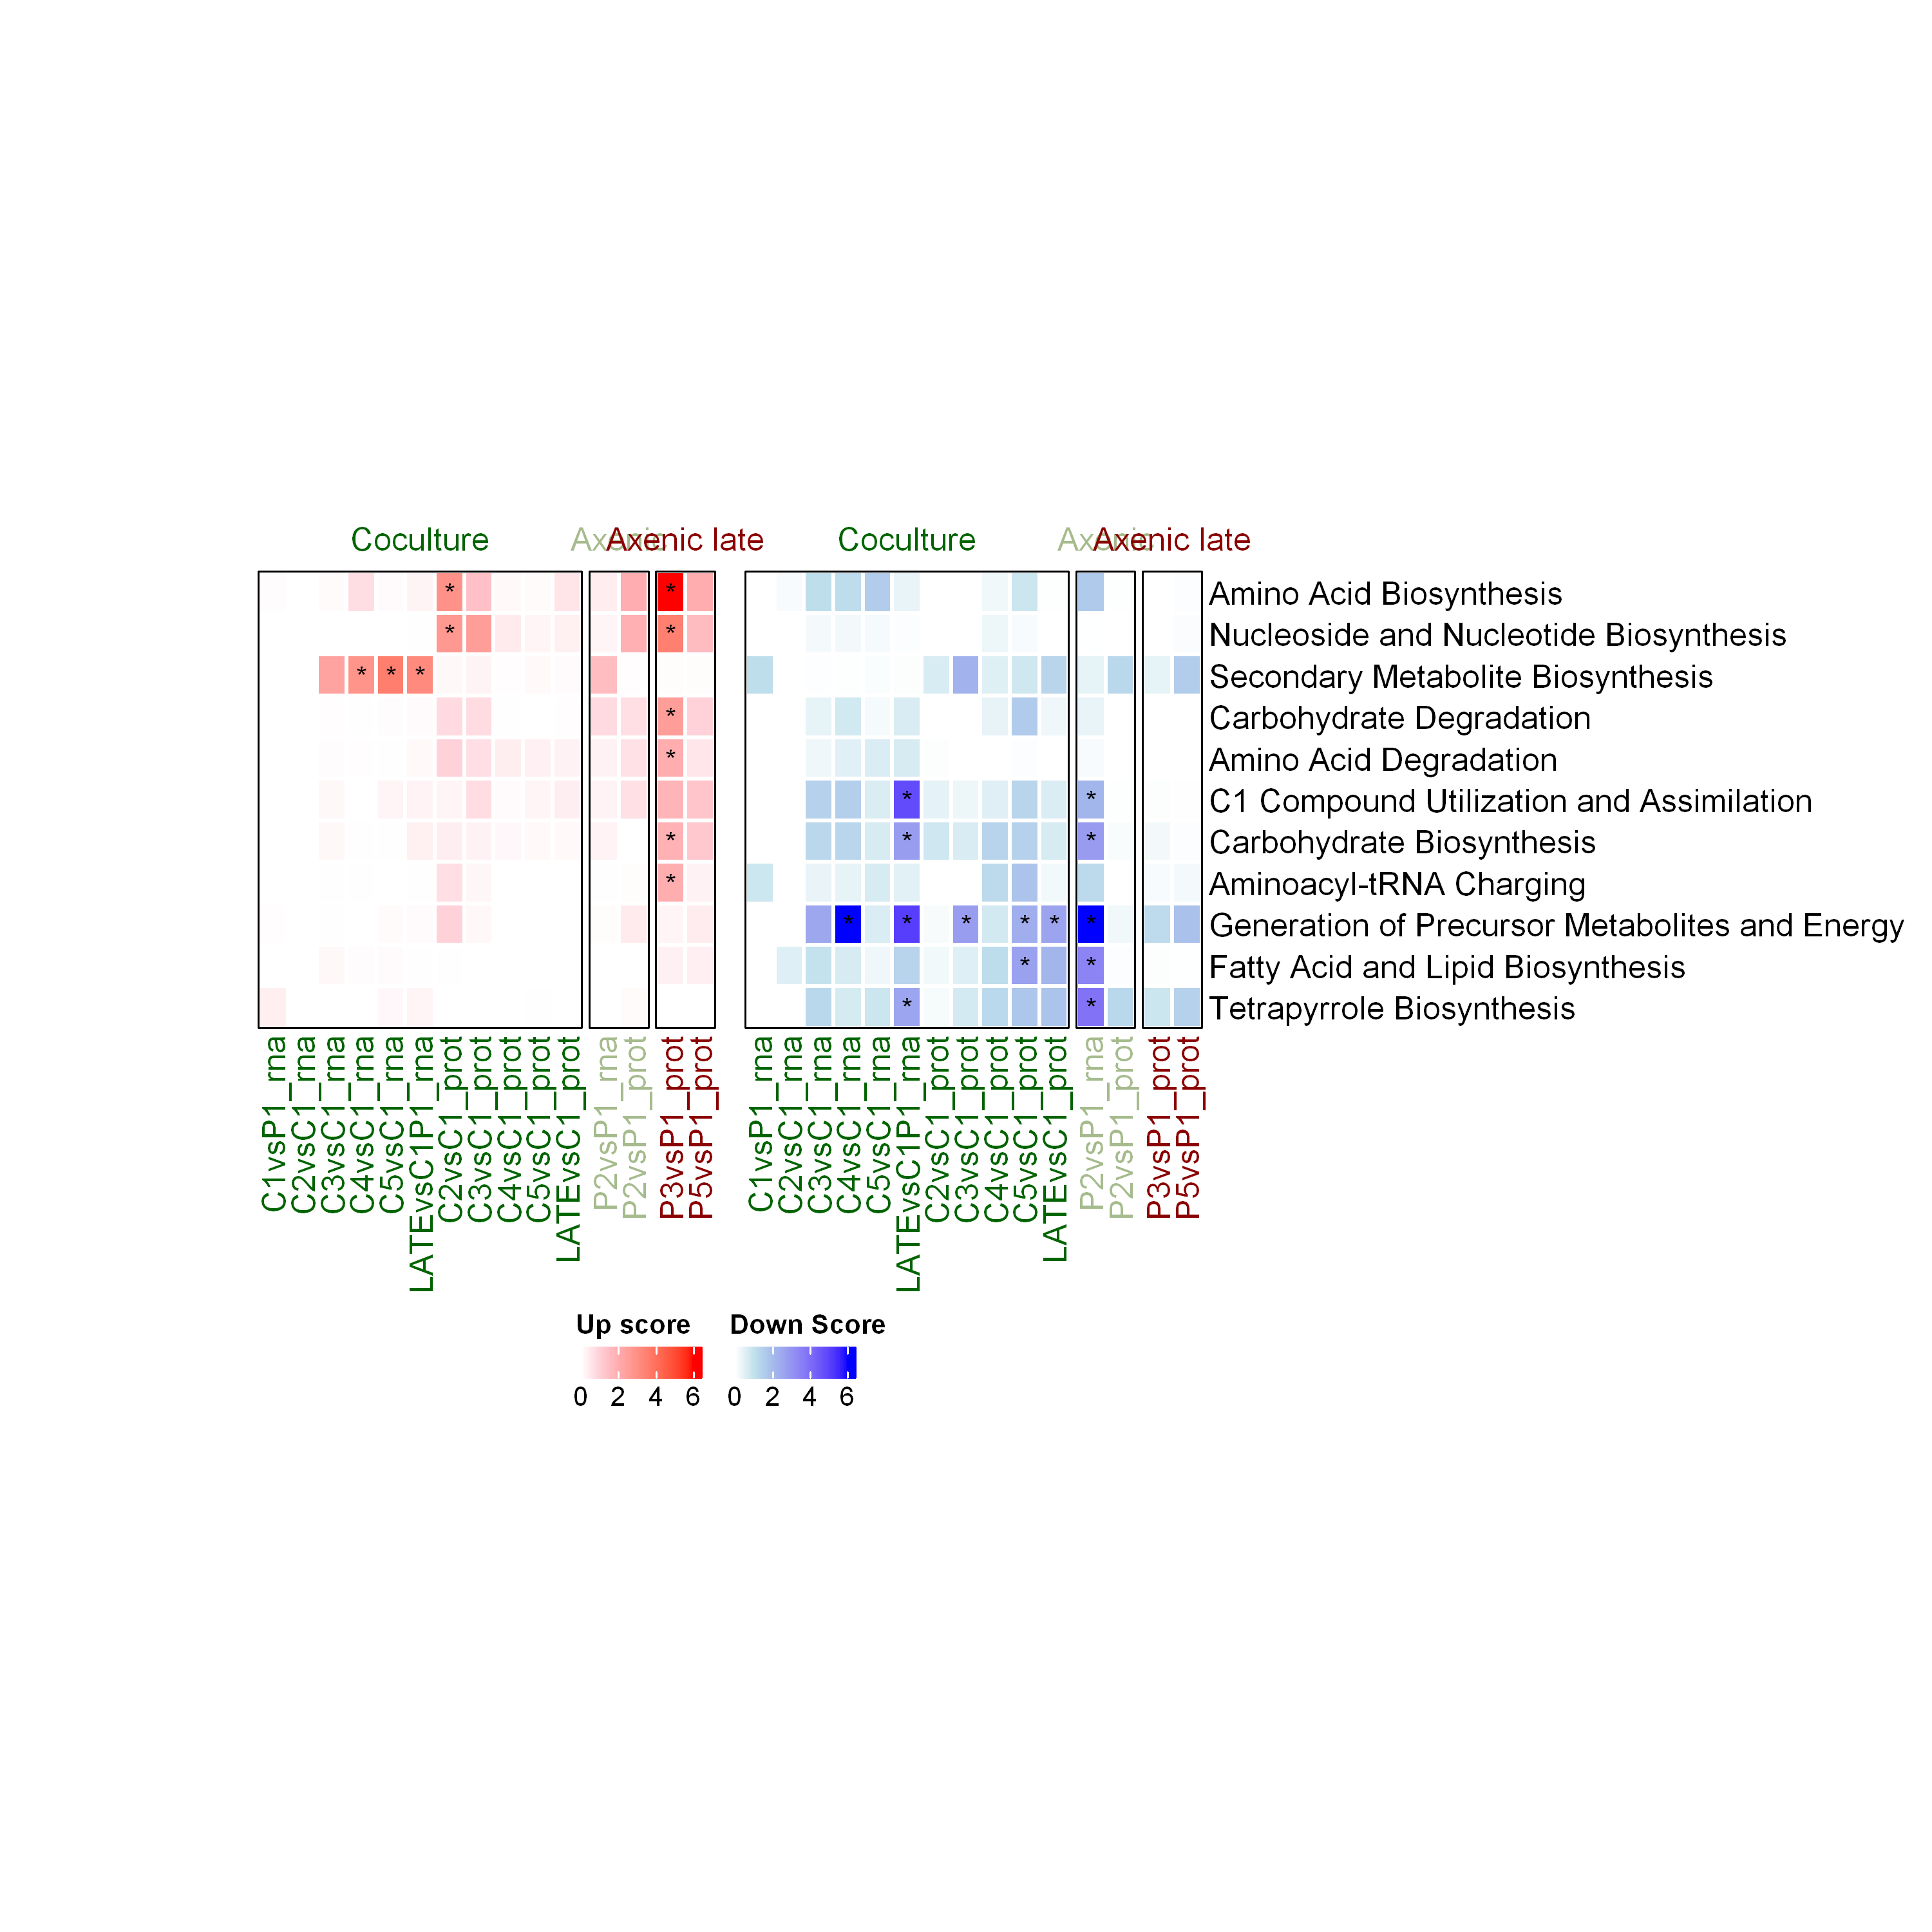

In [111]:
toppaths = goseq_res %>% 
    filter(enrich!='Pathways.of.gene', 
           padj < 0.05) %>% 
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

# module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
#     distinct(pathway, module) %>%
#     arrange(pathway) %>%
#     column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway, values_fill = '') %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway, values_fill = '') %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    #row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
        
    #row_labels = gt_render(letters[1:10], padding = unit(c(2, 10, 2, 10), "pt")),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Down Score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

#gene_type_col = 
# ann_mat = Heatmap(
#     module_mat, 
#     name='Module',
#     width=unit(0.5, 'cm'),
#     heatmap_legend_param = list(direction = "horizontal", ncol=3),
#     col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
#     row_title=FALSE,
# )

ht_list = up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

In [ ]:
sessionInfo()

In [112]:
hpath_df_to_export %>% distinct(gene_id) 

gene_id               
1    TX50_RS00020          
2    TX50_RS00025          
3    TX50_RS00030          
4    TX50_RS00035          
5    TX50_RS00040          
6    TX50_RS00045          
7    TX50_RS00050          
8    TX50_RS00055          
9    TX50_RS00060          
10   TX50_RS00065          
11   TX50_RS00070          
12   TX50_RS00075          
13   TX50_RS00080          
14   TX50_RS00085          
15   TX50_RS00090          
16   TX50_RS00095          
17   TX50_RS00100          
18   TX50_RS00105          
19   TX50_RS00110          
20   TX50_RS00115          
21   TX50_RS00120          
22   TX50_RS00125          
23   TX50_RS00130          
24   TX50_RS00135          
25   TX50_RS00140          
26   TX50_RS00145          
27   TX50_RS00150          
28   TX50_RS00155          
29   TX50_RS00160          
30   TX50_RS00165          
⋮    ⋮                     
1841 TX50_RS09770          
1842 TX50_RS09775          
1843 TX50_RS09780          
1844 TX50_RS09785          
1845 TX50_RS09790          
1846 TX50_RS09795          
1847 TX50_RS09800          
1848 TX50_RS09805          
1849 TX50_RS09810          
1850 TX50_RS09815          
1851 TX50_RS09820          
1852 TX50_RS09825          
1853 TX50_RS09830          
1854 TX50_RS09835          
1855 TX50_RS09840          
1856 TX50_RS09845          
1857 TX50_RS09850          
1858 TX50_RS09855          
1859 TX50_RS09860          
1860 TX50_RS09865          
1861 TX50_RS09870          
1862 TX50_RS09875          
1863 TX50_RS09880          
1864 TX50_RS09885          
1865 TX50_RS09890          
1866 __no_feature          
1867 __ambiguous           
1868 __too_low_aQual       
1869 __not_aligned         
1870 __alignment_not_unique